In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder
import matplotlib.pyplot as plt

In [3]:
head = ["age",
     "workclass",
     "fnlwgt",
     "education",
     "education-num",
     "marital-status",
     "occupation",
     "relationship",
     "race",
     "sex",
     "capital-gain",
     "capital-loss",
     "hours-per-week",
     "native-country",
     "income"]

train_features = ["age",
     "workclass",
     "fnlwgt",
     "education",
     "education-num",
     "marital-status",
     "occupation",
     "relationship",
     "race",
     "sex",
     "capital-gain",
     "capital-loss",
     "hours-per-week",
     "native-country"]

In [4]:
file_train = pd.read_csv("train.csv",header=None,names = head)
file_test = pd.read_csv("test.csv",header=None, names = head)


In [5]:
# X_test

In [6]:
X_train = file_train[train_features]
Y_train = file_train[["income"]]
temp_train = file_train.income

X_test = file_test[train_features]
Y_test = file_test[["income"]]
temp_test = file_test.income


In [7]:
enc = OneHotEncoder()

X_train_transformed = pd.DataFrame(enc.fit_transform(X_train[["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]]).toarray())
X_test_transformed = pd.DataFrame(enc.transform(X_test[["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]]).toarray())

X_train_2 =  X_train[["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]]
X_test_2 =  X_test[["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]]

In [8]:

# X_train_2 = (X_train_2-X_train_2.mean())/X_train_2.std()
X_train_2 = (X_train_2 - X_train_2.min())/(X_train_2.max() - X_train_2.min())


# X_test_2 = (X_test_2-X_test_2.mean())/X_test_2.std()
X_test_2 = (X_test_2 - X_test_2.min())/(X_test_2.max() - X_test_2.min())

In [9]:
X_train = pd.concat([X_train_transformed, X_train_2], axis=1)
X_test  = pd.concat([X_test_transformed, X_test_2], axis=1)

In [10]:
#since using a column matrix fit and transform was used again and again
enc_ordinal = OrdinalEncoder()

Y_train = pd.DataFrame(enc_ordinal.fit_transform(Y_train)).astype(int)
Y_test  = pd.DataFrame(enc_ordinal.fit_transform(Y_test)).astype(int)

In [11]:
pd.DataFrame(Y_train).value_counts()

0    22654
1     7508
dtype: int64

In [12]:
pd.DataFrame(temp_train).value_counts()

income
 <=50K    22654
 >50K      7508
dtype: int64

In [13]:
pd.DataFrame(Y_test).value_counts()

0    11360
1     3700
dtype: int64

In [14]:
pd.DataFrame(temp_test).value_counts()

income 
 <=50K.    11360
 >50K.      3700
dtype: int64

In [16]:
# from model_lor import LogisticRegression
class LogisticRegression:
    
    def __init__(self,n_iter = 1000,l_rate = 0.1,regularization = None, reg_lambda = 1):
        self.n_iter = n_iter   # Number of iterations for gradient descent
        self.l_rate = l_rate  # Learning rate to be used
        self.wt     = None    # Weights for a particular class instance / Regressor
        self.b      = None    # Bias for a particular class instance / Regressor
        self.accuracy_history = []
        self.loss_history = []
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.valid_accuracy_history = []
        self.valid_loss_history = []
    
    def sigmoid(self, Z):
        '''
        Implementation of Sigmoid function , which will be used while predicting y for a particular
        data point.
        '''
        return (1/ (1+ np.exp(-Z ) ) )
        
    def fit(self,X,Y,X_valid = None,Y_valid = None):

        n_samples  = X.shape[0] # Variable to store the number of samples in the given training sample
        n_features = X.shape[1] # Variable to store the number of features in the given training sample
        
        
        X = np.hstack((np.ones([n_samples,1]),X))

        self.wt = np.ones((n_features+1,1))
        
#         print(X.shape)
#         print(self.wt.shape)
        
        for iter_ in range(self.n_iter):
            
            print("Iteration : ",iter_,end=" ")           
            Z = np.dot(X,self.wt) 
            y_pred = self.sigmoid(Z)

            if(self.regularization == "L2"):
                self.wt -= self.l_rate *((np.dot(X.T,y_pred-Y) + self.reg_lambda*(self.wt) )/n_samples ) 

            
            elif(self.regularization == "L1"):
                self.wt -= self.l_rate *((np.dot(X.T,y_pred-Y) + self.reg_lambda*np.sign(self.wt) )/n_samples )

            else:
                self.wt = self.l_rate *((np.dot(X.T,y_pred-Y))/n_samples)

            current_loss = self.loss(Y,y_pred,n_samples)
            self.loss_history.append(current_loss)
                
            y_pred[y_pred < 0.5]  = 0
            y_pred[y_pred >= 0.5] = 1
            

            current_accuracy = my_accuracy_score(Y,y_pred)
            self.accuracy_history.append(current_accuracy)

            
            if(X_valid is not None):
                Y_valid_pred = self.predict_probability(X_valid)

                validation_loss = self.loss(Y_valid,Y_valid_pred,n_samples)
                self.valid_loss_history.append(validation_loss)

                Y_valid_pred[Y_valid_pred < 0.5]  = 0
                Y_valid_pred[Y_valid_pred >= 0.5] = 1
            
                validation_accuracy = my_accuracy_score(Y_valid,Y_valid_pred)
                self.valid_accuracy_history.append(validation_accuracy)

                
                
            print(current_accuracy,current_loss)
            
    def predict_probability(self,X,internal = False):
        Z = np.dot(X,self.wt[1:]) + self.wt[0] 
        y_pred = self.sigmoid(Z)
        return(y_pred)
            
    def predict(self,X):
        Z = np.dot(X,self.wt[1:]) + self.wt[0] 
        y_pred = self.sigmoid(Z)
        y_pred[y_pred < 0.5]  = 0
        y_pred[y_pred >= 0.5] = 1        
        return y_pred
    
    def loss(self,y_orignal,y_predicted,n_samples):
        
        loss =  -1 * np.sum(y_orignal*np.log(y_predicted + 0.0000001)) - np.sum((1-y_orignal)*np.log(1- y_predicted + 0.0000001))
        loss /= n_samples

            
        if(self.regularization == "L2"):
            loss += (self.reg_lambda/(2*n_samples))*np.sum(self.wt*self.wt)
        
        elif(self.regularization == "L1"):
            loss += (self.reg_lambda/(n_samples))*np.sum(np.absolute(self.wt))

        return loss    

def my_accuracy_score(y_orignal,y_predicted): 
    accuracy_matrix = np.array((y_orignal == y_predicted))
    accuracy_score=0
    for i in range(len(accuracy_matrix)):
        if(accuracy_matrix[i][0]):
            accuracy_score+=1
    return(accuracy_score/len(accuracy_matrix))

def split_train_valid(X_,Y_,train_size = 80,shuffle = False):
    data = np.hstack((X_,Y_))
    if(shuffle == True):
        np.random.shuffle(data)

    X_ = data[:,0:-1]
    Y_ = data[:,(-1,)]
    
    print(train_size,X_.shape)
    train_size *= X_.shape[0]
    train_size = train_size//100
    print(train_size,X_.shape[0] - train_size)
    
    X_train = X_[:train_size]
    Y_train = Y_[:train_size]
    
    X_valid = X_[train_size:]
    Y_valid = Y_[train_size:]
    
    return(X_train,Y_train,X_valid,Y_valid)

In [17]:
X_train,Y_train,X_valid,Y_valid = split_train_valid(np.array(X_train),np.array(Y_train),shuffle = True)

80 (30162, 104)
24129 6033


In [18]:
print(X_train.shape,Y_train.shape,X_valid.shape,Y_valid.shape)

pd.DataFrame(Y_valid).value_counts()

(24129, 104) (24129, 1) (6033, 104) (6033, 1)


0.0    4508
1.0    1525
dtype: int64

In [56]:
model = LogisticRegression(n_iter=60000,l_rate=0.01,regularization = "L1" )

In [57]:
model.fit(np.array(X_train),np.array(Y_train),np.array(X_valid),np.array(Y_valid))
# model.fit(np.array(X_train),np.array(Y_train))

Iteration :  0 0.24795888764557172 7.799100548821738
Iteration :  1 0.24795888764557172 7.7702780694170706
Iteration :  2 0.24795888764557172 7.741452090132388
Iteration :  3 0.24795888764557172 7.712622752950081
Iteration :  4 0.24795888764557172 7.6837901946785605
Iteration :  5 0.24795888764557172 7.6549545471627445
Iteration :  6 0.24795888764557172 7.626115937487777
Iteration :  7 0.24795888764557172 7.597274488175046
Iteration :  8 0.24795888764557172 7.568430317371736
Iteration :  9 0.24795888764557172 7.539583539033538
Iteration :  10 0.24795888764557172 7.510734263101071
Iteration :  11 0.24795888764557172 7.481882595670333
Iteration :  12 0.24795888764557172 7.45302863915714
Iteration :  13 0.24795888764557172 7.424172492456135
Iteration :  14 0.24795888764557172 7.3953142510943035
Iteration :  15 0.24795888764557172 7.366454007379458
Iteration :  16 0.24795888764557172 7.337591850543778
Iteration :  17 0.24795888764557172 7.308727866882557
Iteration :  18 0.24795888764557172

Iteration :  152 0.24795888764557172 3.430680327119846
Iteration :  153 0.24795888764557172 3.402772002607612
Iteration :  154 0.24795888764557172 3.3749040399777863
Iteration :  155 0.24795888764557172 3.347077981200883
Iteration :  156 0.24795888764557172 3.3192954208157825
Iteration :  157 0.24795888764557172 3.291558007197465
Iteration :  158 0.24795888764557172 3.263867609800842
Iteration :  159 0.24795888764557172 3.2362261680079643
Iteration :  160 0.24795888764557172 3.208634641981236
Iteration :  161 0.24795888764557172 3.1810954203753194
Iteration :  162 0.24795888764557172 3.153610439155291
Iteration :  163 0.24795888764557172 3.1261816952454637
Iteration :  164 0.24795888764557172 3.098811247580903
Iteration :  165 0.24795888764557172 3.071501218102457
Iteration :  166 0.24795888764557172 3.044253792687679
Iteration :  167 0.24795888764557172 3.01707122200957
Iteration :  168 0.24795888764557172 2.989955822314661
Iteration :  169 0.24795888764557172 2.9629099761115554
Itera

Iteration :  309 0.5182974843549256 0.878566628543613
Iteration :  310 0.5199137966761987 0.8750209928100958
Iteration :  311 0.5210327821293879 0.8715442704798821
Iteration :  312 0.522276099299598 0.8681349010675216
Iteration :  313 0.5238509677151975 0.8647913590506838
Iteration :  314 0.5251771726967549 0.8615121532677888
Iteration :  315 0.5265862654896597 0.85829582631039
Iteration :  316 0.5279124704712173 0.8551409539117916
Iteration :  317 0.5296531145095114 0.8520461443332581
Iteration :  318 0.5315595341705003 0.8490100377490732
Iteration :  319 0.5329686269634051 0.8460313056316036
Iteration :  320 0.5343777197563099 0.843108650137426
Iteration :  321 0.5356624808321936 0.8402408034954869
Iteration :  322 0.5369057980024038 0.837426527398182
Iteration :  323 0.5388536615690662 0.8346646123961613
Iteration :  324 0.5395996518711923 0.8319538772975881
Iteration :  325 0.5404699738903395 0.8292931685725184
Iteration :  326 0.5417132910605496 0.8266813597629928
Iteration :  327

Iteration :  466 0.6562642463425753 0.6762324035309571
Iteration :  467 0.6567201293049857 0.6757821703007246
Iteration :  468 0.6570931244560487 0.6753350647854869
Iteration :  469 0.6573832317957644 0.6748910391714764
Iteration :  470 0.6577562269468274 0.67445004655642
Iteration :  471 0.6581292220978905 0.6740120409304425
Iteration :  472 0.6585022172489535 0.6735769771574031
Iteration :  473 0.6587923245886692 0.6731448109566556
Iteration :  474 0.6592896514567533 0.6727154988852226
Iteration :  475 0.65970409051349 0.6722890278973596
Iteration :  476 0.6603257490985951 0.6718653672194741
Iteration :  477 0.660574412532637 0.6714443649958443
Iteration :  478 0.6609059637780265 0.6710260515120113
Iteration :  479 0.6611960711177421 0.670610387253181
Iteration :  480 0.6616519540801525 0.670197333443529
Iteration :  481 0.6618177297028472 0.6697868520309944
Iteration :  482 0.6620249492312156 0.6693789056724095
Iteration :  483 0.6622736126652575 0.6689734577189633
Iteration :  484 

Iteration :  621 0.6897923660325749 0.62735125500974
Iteration :  622 0.6900410294666169 0.6271134395183714
Iteration :  623 0.6901653611836379 0.6268762198850826
Iteration :  624 0.6902068050893116 0.6266395923450749
Iteration :  625 0.6903311368063326 0.6264035531828173
Iteration :  626 0.690289692900659 0.6261680987312209
Iteration :  627 0.690538356334701 0.6259332253708272
Iteration :  628 0.6907455758630693 0.6256989295290123
Iteration :  629 0.690787019768743 0.6254652076792043
Iteration :  630 0.6909942392971113 0.625232056340116
Iteration :  631 0.6910771271084587 0.6249994720749903
Iteration :  632 0.6914501222595217 0.624767451490859
Iteration :  633 0.6916573417878901 0.6245359912378163
Iteration :  634 0.6918231174105848 0.6243050880083043
Iteration :  635 0.6918645613162584 0.624074738536411
Iteration :  636 0.6919888930332795 0.6238449395971818
Iteration :  637 0.6920303369389531 0.6236156880059424
Iteration :  638 0.6920717808446268 0.623386980617635
Iteration :  639 0.

Iteration :  784 0.7059140453396328 0.594684844092316
Iteration :  785 0.7060383770566538 0.5945147860797073
Iteration :  786 0.7060798209623275 0.5943450332581753
Iteration :  787 0.7060798209623275 0.5941755847609722
Iteration :  788 0.7061627087736748 0.5940064397259492
Iteration :  789 0.7061627087736748 0.5938375972955058
Iteration :  790 0.7062455965850222 0.5936690566165382
Iteration :  791 0.7062455965850222 0.5935008168403898
Iteration :  792 0.7063284843963695 0.5933328771228017
Iteration :  793 0.7064528161133905 0.5931652366238631
Iteration :  794 0.7064942600190642 0.5929978945079651
Iteration :  795 0.7065357039247379 0.592830849943753
Iteration :  796 0.7066600356417588 0.5926641021040796
Iteration :  797 0.7066600356417588 0.5924976501659597
Iteration :  798 0.7067843673587799 0.5923314933105257
Iteration :  799 0.7068672551701273 0.5921656307229828
Iteration :  800 0.7069086990758009 0.5920000615925659
Iteration :  801 0.7069915868871482 0.5918347851124962
Iteration : 

Iteration :  936 0.7139956069459986 0.5719158504268634
Iteration :  937 0.7140370508516722 0.5717841261672603
Iteration :  938 0.7141199386630196 0.5716526097675712
Iteration :  939 0.7142857142857143 0.5715213007419535
Iteration :  940 0.7143686020970617 0.571390198605998
Iteration :  941 0.7143686020970617 0.5712593028767204
Iteration :  942 0.7144100460027353 0.5711286130725552
Iteration :  943 0.7144100460027353 0.5709981287133495
Iteration :  944 0.7146172655311036 0.5708678493203561
Iteration :  945 0.7146587094367773 0.5707377744162272
Iteration :  946 0.7148659289651457 0.5706079035250078
Iteration :  947 0.7148659289651457 0.5704782361721293
Iteration :  948 0.7149073728708193 0.5703487718844037
Iteration :  949 0.7149902606821666 0.5702195101900168
Iteration :  950 0.7150317045878404 0.570090450618522
Iteration :  951 0.715073148493514 0.5699615927008351
Iteration :  952 0.7152389241162087 0.5698329359692269
Iteration :  953 0.7152803680218823 0.5697044799573183
Iteration :  

Iteration :  1088 0.7221186124580381 0.5540275306784691
Iteration :  1089 0.7221186124580381 0.5539225344154715
Iteration :  1090 0.721994280741017 0.5538176857220423
Iteration :  1091 0.7220357246466907 0.5537129842770465
Iteration :  1092 0.7220357246466907 0.5536084297601815
Iteration :  1093 0.7221600563637117 0.5535040218519734
Iteration :  1094 0.7222015002693853 0.5533997602337759
Iteration :  1095 0.7222843880807327 0.5532956445877669
Iteration :  1096 0.7222843880807327 0.5531916745969464
Iteration :  1097 0.7223258319864064 0.5530878499451343
Iteration :  1098 0.7224501637034274 0.5529841703169678
Iteration :  1099 0.7226573832317957 0.5528806353978988
Iteration :  1100 0.7226573832317957 0.5527772448741917
Iteration :  1101 0.7226988271374695 0.5526739984329213
Iteration :  1102 0.7226573832317957 0.5525708957619696
Iteration :  1103 0.7228646027601641 0.5524679365500247
Iteration :  1104 0.7229060466658378 0.5523651204865768
Iteration :  1105 0.7230303783828588 0.5522624472

Iteration :  1251 0.7276720958183099 0.5386555205387251
Iteration :  1252 0.7277135397239836 0.5385708654133308
Iteration :  1253 0.7276720958183099 0.538486314981939
Iteration :  1254 0.7276720958183099 0.5384018690320035
Iteration :  1255 0.7277135397239836 0.538317527351504
Iteration :  1256 0.7277135397239836 0.5382332897289438
Iteration :  1257 0.7278378714410046 0.53814915595335
Iteration :  1258 0.7278378714410046 0.5380651258142704
Iteration :  1259 0.7278378714410046 0.5379811991017733
Iteration :  1260 0.7278378714410046 0.537897375606445
Iteration :  1261 0.7279207592523519 0.5378136551193898
Iteration :  1262 0.7280036470636992 0.5377300374322271
Iteration :  1263 0.7280865348750466 0.5376465223370908
Iteration :  1264 0.728169422686394 0.537563109626628
Iteration :  1265 0.728169422686394 0.5374797990939972
Iteration :  1266 0.728169422686394 0.5373965905328668
Iteration :  1267 0.728169422686394 0.5373134837374146
Iteration :  1268 0.7280865348750466 0.5372304785023251
It

Iteration :  1408 0.7310704960835509 0.526524077755353
Iteration :  1409 0.7310704960835509 0.5264535572639589
Iteration :  1410 0.7311119399892246 0.5263831137185462
Iteration :  1411 0.7311533838948983 0.5263127469738673
Iteration :  1412 0.7312362717062456 0.5262424568850185
Iteration :  1413 0.731319159517593 0.526172243307439
Iteration :  1414 0.7314849351402877 0.5261021060969108
Iteration :  1415 0.7315263790459613 0.5260320451095565
Iteration :  1416 0.7315678229516349 0.5259620602018397
Iteration :  1417 0.7315678229516349 0.5258921512305628
Iteration :  1418 0.7316507107629823 0.5258223180528672
Iteration :  1419 0.7316507107629823 0.525752560526232
Iteration :  1420 0.731692154668656 0.525682878508473
Iteration :  1421 0.731692154668656 0.5256132718577418
Iteration :  1422 0.7317335985743296 0.5255437404325247
Iteration :  1423 0.7317335985743296 0.5254742840916432
Iteration :  1424 0.7317750424800034 0.5254049026942504
Iteration :  1425 0.7317750424800034 0.5253355960998332

Iteration :  1557 0.7350491110282233 0.5167927517823242
Iteration :  1558 0.7350491110282233 0.5167322639490057
Iteration :  1559 0.7350491110282233 0.5166718347657507
Iteration :  1560 0.7351319988395706 0.516611464129748
Iteration :  1561 0.7351319988395706 0.5165511519384193
Iteration :  1562 0.7351319988395706 0.5164908980894183
Iteration :  1563 0.7351319988395706 0.5164307024806299
Iteration :  1564 0.7351319988395706 0.5163705650101703
Iteration :  1565 0.7351319988395706 0.5163104855763858
Iteration :  1566 0.7352148866509179 0.5162504640778522
Iteration :  1567 0.7352148866509179 0.5161905004133746
Iteration :  1568 0.7352148866509179 0.5161305944819865
Iteration :  1569 0.735339218367939 0.5160707461829495
Iteration :  1570 0.7354221061792864 0.516010955415752
Iteration :  1571 0.7353806622736127 0.5159512220801098
Iteration :  1572 0.7354221061792864 0.5158915460759644
Iteration :  1573 0.7354221061792864 0.5158319273034832
Iteration :  1574 0.7354221061792864 0.515772365663

Iteration :  1709 0.7374943014629699 0.5082172941023644
Iteration :  1710 0.7374943014629699 0.5081646628868283
Iteration :  1711 0.7374528575572962 0.5081120770528351
Iteration :  1712 0.7374528575572962 0.5080595365269208
Iteration :  1713 0.7374943014629699 0.5080070412357792
Iteration :  1714 0.7375357453686435 0.5079545911062622
Iteration :  1715 0.7375357453686435 0.5079021860653788
Iteration :  1716 0.7375357453686435 0.5078498260402956
Iteration :  1717 0.7374943014629699 0.5077975109583355
Iteration :  1718 0.7374528575572962 0.5077452407469774
Iteration :  1719 0.7374943014629699 0.5076930153338566
Iteration :  1720 0.7375357453686435 0.5076408346467636
Iteration :  1721 0.7375771892743173 0.5075886986136441
Iteration :  1722 0.7375771892743173 0.5075366071625983
Iteration :  1723 0.7376600770856645 0.5074845602218812
Iteration :  1724 0.7377429648970119 0.5074325577199009
Iteration :  1725 0.7376600770856645 0.5073805995852202
Iteration :  1726 0.7377015209913382 0.507328685

Iteration :  1867 0.7412656968792739 0.500420719347176
Iteration :  1868 0.7412656968792739 0.5003744402208368
Iteration :  1869 0.7413071407849475 0.5003281966020009
Iteration :  1870 0.7413071407849475 0.5002819884379458
Iteration :  1871 0.7413485846906213 0.5002358156760565
Iteration :  1872 0.7413900285962949 0.5001896782638254
Iteration :  1873 0.7413900285962949 0.5001435761488521
Iteration :  1874 0.7413900285962949 0.5000975092788428
Iteration :  1875 0.7413900285962949 0.5000514776016102
Iteration :  1876 0.7413900285962949 0.5000054810650737
Iteration :  1877 0.7414314725019686 0.4999595196172587
Iteration :  1878 0.7414729164076422 0.4999135932062963
Iteration :  1879 0.7414729164076422 0.49986770178042295
Iteration :  1880 0.7415558042189896 0.49982184528798074
Iteration :  1881 0.7416386920303369 0.4997760236774169
Iteration :  1882 0.7416801359360106 0.4997302368972832
Iteration :  1883 0.7417630237473579 0.4996844848962359
Iteration :  1884 0.7417630237473579 0.49963876

Iteration :  2021 0.7450370922955779 0.4936828525490446
Iteration :  2022 0.7450785362012516 0.4936414796113806
Iteration :  2023 0.7451199801069253 0.4936001351979785
Iteration :  2024 0.7451199801069253 0.4935588192700166
Iteration :  2025 0.7451199801069253 0.49351753178874797
Iteration :  2026 0.7451199801069253 0.4934762727155008
Iteration :  2027 0.745161424012599 0.493435042011678
Iteration :  2028 0.7451199801069253 0.4933938396387564
Iteration :  2029 0.7451199801069253 0.4933526655582879
Iteration :  2030 0.745161424012599 0.49331151973189835
Iteration :  2031 0.745161424012599 0.49327040212128737
Iteration :  2032 0.7452028679182726 0.49322931268822856
Iteration :  2033 0.7452443118239462 0.49318825139456923
Iteration :  2034 0.7452443118239462 0.4931472182022301
Iteration :  2035 0.7452443118239462 0.49310621307320535
Iteration :  2036 0.7453686435409673 0.4930652359695621
Iteration :  2037 0.745410087446641 0.49302428685344046
Iteration :  2038 0.745410087446641 0.49298336

Iteration :  2168 0.7483526047494716 0.48788830342311784
Iteration :  2169 0.7483940486551452 0.48785074288023
Iteration :  2170 0.748435492560819 0.48781320587838667
Iteration :  2171 0.7484769364664926 0.48777569238815804
Iteration :  2172 0.7484769364664926 0.4877382023801686
Iteration :  2173 0.74855982427784 0.48770073582509604
Iteration :  2174 0.7486012681835136 0.48766329269367276
Iteration :  2175 0.7486012681835136 0.4876258729566836
Iteration :  2176 0.7486012681835136 0.48758847658496757
Iteration :  2177 0.7486427120891873 0.4875511035494168
Iteration :  2178 0.7486841559948609 0.4875137538209766
Iteration :  2179 0.7486841559948609 0.48747642737064534
Iteration :  2180 0.7486841559948609 0.4874391241694744
Iteration :  2181 0.7486841559948609 0.48740184418856797
Iteration :  2182 0.7487255999005347 0.4873645873990833
Iteration :  2183 0.7487255999005347 0.4873273537722298
Iteration :  2184 0.7487255999005347 0.4872901432792697
Iteration :  2185 0.7487255999005347 0.487252

Iteration :  2317 0.7510464586182601 0.48253644522451505
Iteration :  2318 0.7510050147125865 0.48250209475350425
Iteration :  2319 0.7511707903352812 0.4824677639742577
Iteration :  2320 0.7511707903352812 0.48243345286421513
Iteration :  2321 0.7512122342409548 0.482399161400855
Iteration :  2322 0.7512536781466286 0.48236488956169504
Iteration :  2323 0.7512951220523022 0.48233063732429154
Iteration :  2324 0.7513365659579759 0.4822964046662402
Iteration :  2325 0.7513365659579759 0.48226219156517486
Iteration :  2326 0.7513780098636496 0.48222799799876864
Iteration :  2327 0.7513780098636496 0.48219382394473265
Iteration :  2328 0.7513780098636496 0.4821596693808168
Iteration :  2329 0.7513780098636496 0.4821255342848095
Iteration :  2330 0.7513780098636496 0.4820914186345374
Iteration :  2331 0.7513365659579759 0.48205732240786536
Iteration :  2332 0.7513365659579759 0.4820232455826965
Iteration :  2333 0.7513365659579759 0.481989188136972
Iteration :  2334 0.7513365659579759 0.48

Iteration :  2463 0.7535330929586804 0.47771896729523444
Iteration :  2464 0.7535330929586804 0.4776872722270004
Iteration :  2465 0.753574536864354 0.47765559393747575
Iteration :  2466 0.7536574246757014 0.4776239324090043
Iteration :  2467 0.7536988685813751 0.47759228762395856
Iteration :  2468 0.7537403124870488 0.47756065956473986
Iteration :  2469 0.7536988685813751 0.4775290482137785
Iteration :  2470 0.7537403124870488 0.4774974535535334
Iteration :  2471 0.7538232002983961 0.477465875566492
Iteration :  2472 0.7537817563927225 0.47743431423517074
Iteration :  2473 0.7537817563927225 0.4774027695421142
Iteration :  2474 0.7538232002983961 0.47737124146989574
Iteration :  2475 0.7538646442040698 0.47733973000111707
Iteration :  2476 0.7538646442040698 0.47730823511840836
Iteration :  2477 0.7538646442040698 0.4772767568044279
Iteration :  2478 0.7538646442040698 0.47724529504186247
Iteration :  2479 0.7538646442040698 0.477213849813427
Iteration :  2480 0.7538232002983961 0.477

Iteration :  2615 0.7572630444693108 0.47308432091352215
Iteration :  2616 0.7573044883749844 0.47305498899803844
Iteration :  2617 0.7573873761863318 0.4730256714782465
Iteration :  2618 0.7574288200920055 0.47299636834028097
Iteration :  2619 0.7574702639976791 0.4729670795702981
Iteration :  2620 0.7575117079033528 0.472937805154475
Iteration :  2621 0.7575531518090265 0.4729085450790104
Iteration :  2622 0.7575531518090265 0.472879299330124
Iteration :  2623 0.7575945957147001 0.47285006789405704
Iteration :  2624 0.7575945957147001 0.4728208507570714
Iteration :  2625 0.7575945957147001 0.47279164790545064
Iteration :  2626 0.7576360396203738 0.4727624593254989
Iteration :  2627 0.7576774835260475 0.47273328500354167
Iteration :  2628 0.7577189274317212 0.4727041249259251
Iteration :  2629 0.7577189274317212 0.47267497907901673
Iteration :  2630 0.7578018152430686 0.4726458474492046
Iteration :  2631 0.7578432591487422 0.47261673002289795
Iteration :  2632 0.7578432591487422 0.472

Iteration :  2762 0.7619462058104356 0.46892019567754206
Iteration :  2763 0.762029093621783 0.46889284148572064
Iteration :  2764 0.7620705375274566 0.4688654998605788
Iteration :  2765 0.7620705375274566 0.46883817079098794
Iteration :  2766 0.7621119814331303 0.4688108542658355
Iteration :  2767 0.7621119814331303 0.4687835502740251
Iteration :  2768 0.7621534253388039 0.46875625880447636
Iteration :  2769 0.7621948692444775 0.4687289798461248
Iteration :  2770 0.7621948692444775 0.4687017133879223
Iteration :  2771 0.7621948692444775 0.4686744594188364
Iteration :  2772 0.7622363131501513 0.46864721792785075
Iteration :  2773 0.7622777570558249 0.46861998890396456
Iteration :  2774 0.7623606448671723 0.4685927723361934
Iteration :  2775 0.7624435326785196 0.46856556821356854
Iteration :  2776 0.7624435326785196 0.4685383765251369
Iteration :  2777 0.7624435326785196 0.4685111972599615
Iteration :  2778 0.7624435326785196 0.46848403040712067
Iteration :  2779 0.7624849765841933 0.46

Iteration :  2914 0.766049152472129 0.46490051459539955
Iteration :  2915 0.7660905963778026 0.46487495147166763
Iteration :  2916 0.7660905963778026 0.46484939939206926
Iteration :  2917 0.7661320402834764 0.46482385834761447
Iteration :  2918 0.7662149280948236 0.46479832832932544
Iteration :  2919 0.76617348418915 0.46477280932823656
Iteration :  2920 0.7662563720004973 0.46474730133539416
Iteration :  2921 0.766297815906171 0.46472180434185706
Iteration :  2922 0.7662149280948236 0.46469631833869585
Iteration :  2923 0.7662563720004973 0.46467084331699354
Iteration :  2924 0.7662149280948236 0.4646453792678448
Iteration :  2925 0.7662563720004973 0.4646199261823568
Iteration :  2926 0.7662563720004973 0.4645944840516485
Iteration :  2927 0.766297815906171 0.4645690528668509
Iteration :  2928 0.766422147623192 0.4645436326191067
Iteration :  2929 0.7663807037175183 0.46451822329957115
Iteration :  2930 0.7664635915288657 0.464492824899411
Iteration :  2931 0.7665050354345394 0.46446

Iteration :  3067 0.7708152016246012 0.46111277037436676
Iteration :  3068 0.7708566455302748 0.46108879915590867
Iteration :  3069 0.7708566455302748 0.46106483773611323
Iteration :  3070 0.7708980894359484 0.46104088610762717
Iteration :  3071 0.7708566455302748 0.46101694426310663
Iteration :  3072 0.7708980894359484 0.4609930121952172
Iteration :  3073 0.7709395333416221 0.46096908989663354
Iteration :  3074 0.7709395333416221 0.46094517736003976
Iteration :  3075 0.7709809772472958 0.4609212745781293
Iteration :  3076 0.7710224211529695 0.4608973815436046
Iteration :  3077 0.7710224211529695 0.4608734982491776
Iteration :  3078 0.7710224211529695 0.46084962468756907
Iteration :  3079 0.7711053089643168 0.4608257608515095
Iteration :  3080 0.7711881967756642 0.4608019067337383
Iteration :  3081 0.7712296406813378 0.46077806232700386
Iteration :  3082 0.7712710845870114 0.46075422762406393
Iteration :  3083 0.7712710845870114 0.4607304026176856
Iteration :  3084 0.7712710845870114 0

Iteration :  3226 0.7739234945501264 0.45741982101646694
Iteration :  3227 0.7739234945501264 0.4573973211678713
Iteration :  3228 0.7739649384558001 0.4573748300562023
Iteration :  3229 0.7739234945501264 0.4573523476754083
Iteration :  3230 0.7739234945501264 0.45732987401944475
Iteration :  3231 0.7738820506444527 0.4573074090822745
Iteration :  3232 0.7738820506444527 0.45728495285786713
Iteration :  3233 0.7737991628331053 0.4572625053401996
Iteration :  3234 0.7738820506444527 0.4572400665232559
Iteration :  3235 0.7739234945501264 0.457217636401027
Iteration :  3236 0.7739234945501264 0.45719521496751125
Iteration :  3237 0.7739234945501264 0.4571728022167137
Iteration :  3238 0.7738820506444527 0.4571503981426465
Iteration :  3239 0.7738820506444527 0.45712800273932935
Iteration :  3240 0.7739649384558001 0.45710561600078803
Iteration :  3241 0.7740063823614738 0.45708323792105626
Iteration :  3242 0.7740478262671474 0.45706086849417416
Iteration :  3243 0.7740478262671474 0.45

Iteration :  3386 0.7769074557586307 0.4539271035739548
Iteration :  3387 0.7769074557586307 0.45390592915351524
Iteration :  3388 0.7769074557586307 0.4538847625853498
Iteration :  3389 0.776866011852957 0.45386360386441543
Iteration :  3390 0.7769074557586307 0.4538424529856745
Iteration :  3391 0.7769488996643044 0.4538213099440948
Iteration :  3392 0.7769488996643044 0.45380017473464984
Iteration :  3393 0.776990343569978 0.4537790473523185
Iteration :  3394 0.7769488996643044 0.4537579277920853
Iteration :  3395 0.7769488996643044 0.45373681604893995
Iteration :  3396 0.7770317874756517 0.453715712117878
Iteration :  3397 0.776990343569978 0.4536946159939002
Iteration :  3398 0.776990343569978 0.453673527672013
Iteration :  3399 0.7770317874756517 0.4536524471472281
Iteration :  3400 0.7770732313813253 0.4536313744145628
Iteration :  3401 0.7770732313813253 0.4536103094690397
Iteration :  3402 0.7770732313813253 0.45358925230568703
Iteration :  3403 0.776990343569978 0.45356820291

Iteration :  3547 0.7798914169671349 0.4506158587552107
Iteration :  3548 0.7798914169671349 0.4505958871528423
Iteration :  3549 0.7798499730614613 0.4505759226565942
Iteration :  3550 0.7798499730614613 0.4505559652622132
Iteration :  3551 0.7798499730614613 0.4505360149654504
Iteration :  3552 0.7799328608728087 0.4505160717620615
Iteration :  3553 0.7799743047784823 0.4504961356478064
Iteration :  3554 0.7799743047784823 0.450476206618449
Iteration :  3555 0.780015748684156 0.4504562846697581
Iteration :  3556 0.7799743047784823 0.45043636979750645
Iteration :  3557 0.7799328608728087 0.4504164619974711
Iteration :  3558 0.7799743047784823 0.4503965612654333
Iteration :  3559 0.7799743047784823 0.4503766675971788
Iteration :  3560 0.780015748684156 0.45035678098849763
Iteration :  3561 0.780015748684156 0.45033690143518385
Iteration :  3562 0.780015748684156 0.45031702893303605
Iteration :  3563 0.7799743047784823 0.4502971634778569
Iteration :  3564 0.7799328608728087 0.4502773050

Iteration :  3706 0.782916822081313 0.4475269466986088
Iteration :  3707 0.7828753781756392 0.44750805429092694
Iteration :  3708 0.7828753781756392 0.44748916836492747
Iteration :  3709 0.7828339342699656 0.44747028891697166
Iteration :  3710 0.782916822081313 0.4474514159434242
Iteration :  3711 0.782916822081313 0.4474325494406531
Iteration :  3712 0.782916822081313 0.4474136894050302
Iteration :  3713 0.782916822081313 0.4473948358329302
Iteration :  3714 0.7829582659869866 0.44737598872073175
Iteration :  3715 0.7828753781756392 0.44735714806481686
Iteration :  3716 0.7828753781756392 0.4473383138615705
Iteration :  3717 0.7828753781756392 0.4473194861073816
Iteration :  3718 0.7829582659869866 0.44730066479864217
Iteration :  3719 0.7829582659869866 0.4472818499317478
Iteration :  3720 0.7829582659869866 0.44726304150309737
Iteration :  3721 0.7829582659869866 0.44724423950909314
Iteration :  3722 0.7829997098926603 0.44722544394614083
Iteration :  3723 0.7830411537983339 0.44720

Iteration :  3856 0.7848646856479755 0.4447635793889436
Iteration :  3857 0.7849061295536491 0.4447456203774554
Iteration :  3858 0.7849061295536491 0.4447276673378471
Iteration :  3859 0.7849890173649965 0.444709720266947
Iteration :  3860 0.7850304612706701 0.4446917791615866
Iteration :  3861 0.7850304612706701 0.44467384401859983
Iteration :  3862 0.7850719051763438 0.4446559148348236
Iteration :  3863 0.7851133490820175 0.4446379916070978
Iteration :  3864 0.7851133490820175 0.44462007433226497
Iteration :  3865 0.7851547929876912 0.44460216300717026
Iteration :  3866 0.7852376807990386 0.4445842576286618
Iteration :  3867 0.7852376807990386 0.4445663581935904
Iteration :  3868 0.7851962368933648 0.44454846469880993
Iteration :  3869 0.7851962368933648 0.4445305771411766
Iteration :  3870 0.7851547929876912 0.44451269551754957
Iteration :  3871 0.7851547929876912 0.44449481982479094
Iteration :  3872 0.7851547929876912 0.4444769500597653
Iteration :  3873 0.7852376807990386 0.4444

Iteration :  4017 0.7868539931203117 0.4419470040341077
Iteration :  4018 0.7868539931203117 0.4419299674672542
Iteration :  4019 0.7868539931203117 0.4419129363954399
Iteration :  4020 0.7868539931203117 0.4418959108159009
Iteration :  4021 0.7868539931203117 0.44187889072587616
Iteration :  4022 0.7868539931203117 0.44186187612260647
Iteration :  4023 0.786812549214638 0.44184486700333503
Iteration :  4024 0.7868539931203117 0.44182786336530744
Iteration :  4025 0.7868954370259853 0.4418108652057712
Iteration :  4026 0.7868954370259853 0.44179387252197655
Iteration :  4027 0.7868954370259853 0.4417768853111758
Iteration :  4028 0.7868954370259853 0.4417599035706233
Iteration :  4029 0.786936880931659 0.44174292729757586
Iteration :  4030 0.7868954370259853 0.44172595648929275
Iteration :  4031 0.7868954370259853 0.4417089911430351
Iteration :  4032 0.786936880931659 0.44169203125606643
Iteration :  4033 0.786936880931659 0.4416750768256525
Iteration :  4034 0.786936880931659 0.441658

Iteration :  4176 0.7890919640266899 0.43930545265423443
Iteration :  4177 0.7890919640266899 0.4392892565133062
Iteration :  4178 0.7890919640266899 0.43927306545486394
Iteration :  4179 0.7890919640266899 0.43925687947647324
Iteration :  4180 0.7890919640266899 0.43924069857570175
Iteration :  4181 0.7890919640266899 0.43922452275011886
Iteration :  4182 0.7891334079323635 0.43920835199729585
Iteration :  4183 0.7890919640266899 0.4391921863148059
Iteration :  4184 0.7890919640266899 0.4391760257002241
Iteration :  4185 0.7891334079323635 0.4391598701511274
Iteration :  4186 0.7891748518380373 0.4391437196650944
Iteration :  4187 0.7891748518380373 0.43912757423970583
Iteration :  4188 0.7891748518380373 0.43911143387254425
Iteration :  4189 0.7892162957437109 0.439095298561194
Iteration :  4190 0.7892162957437109 0.43907916830324134
Iteration :  4191 0.7892577396493845 0.4390630430962742
Iteration :  4192 0.7892577396493845 0.43904692293788256
Iteration :  4193 0.7892577396493845 0.

Iteration :  4334 0.7917443739898048 0.4368079756970067
Iteration :  4335 0.7917858178954784 0.4367925535535685
Iteration :  4336 0.7917858178954784 0.43677713612992186
Iteration :  4337 0.7918272618011521 0.4367617234239036
Iteration :  4338 0.7918272618011521 0.43674631543335196
Iteration :  4339 0.7918687057068258 0.43673091215610665
Iteration :  4340 0.7918687057068258 0.4367155135900094
Iteration :  4341 0.7919101496124995 0.4367001197329029
Iteration :  4342 0.7919101496124995 0.43668473058263185
Iteration :  4343 0.7918687057068258 0.43666934613704234
Iteration :  4344 0.7919101496124995 0.436653966393982
Iteration :  4345 0.7918687057068258 0.4366385913513
Iteration :  4346 0.7919101496124995 0.4366232210068472
Iteration :  4347 0.7919101496124995 0.43660785535847596
Iteration :  4348 0.7919101496124995 0.43659249440403985
Iteration :  4349 0.7919101496124995 0.4365771381413945
Iteration :  4350 0.7919101496124995 0.43656178656839684
Iteration :  4351 0.7919101496124995 0.43654

Iteration :  4480 0.7935679058394464 0.4346052301866045
Iteration :  4481 0.7935679058394464 0.4345904749990837
Iteration :  4482 0.7935679058394464 0.4345757242312361
Iteration :  4483 0.7935679058394464 0.43456097788110964
Iteration :  4484 0.79360934974512 0.4345462359467536
Iteration :  4485 0.79360934974512 0.4345314984262187
Iteration :  4486 0.79360934974512 0.43451676531755645
Iteration :  4487 0.79360934974512 0.43450203661882036
Iteration :  4488 0.79360934974512 0.43448731232806515
Iteration :  4489 0.7936922375564673 0.43447259244334635
Iteration :  4490 0.7936922375564673 0.4344578769627214
Iteration :  4491 0.793733681462141 0.4344431658842489
Iteration :  4492 0.793733681462141 0.4344284592059886
Iteration :  4493 0.7937751253678147 0.4344137569260017
Iteration :  4494 0.7937751253678147 0.4343990590423506
Iteration :  4495 0.793733681462141 0.4343843655530992
Iteration :  4496 0.7938165692734883 0.43436967645631286
Iteration :  4497 0.7938994570848357 0.4343549917500579

Iteration :  4637 0.7956401011231299 0.43234159637509245
Iteration :  4638 0.7956401011231299 0.4323275121387713
Iteration :  4639 0.7956815450288035 0.4323134320340774
Iteration :  4640 0.7957229889344772 0.4322993560592494
Iteration :  4641 0.7957229889344772 0.43228528421252727
Iteration :  4642 0.7957644328401509 0.43227121649215194
Iteration :  4643 0.7957644328401509 0.4322571528963655
Iteration :  4644 0.7958058767458245 0.4322430934234112
Iteration :  4645 0.7958473206514982 0.4322290380715335
Iteration :  4646 0.7958473206514982 0.43221498683897797
Iteration :  4647 0.7958473206514982 0.432200939723991
Iteration :  4648 0.7958473206514982 0.43218689672482064
Iteration :  4649 0.7958473206514982 0.4321728578397156
Iteration :  4650 0.7959302084628456 0.4321588230669261
Iteration :  4651 0.7959302084628456 0.43214479240470316
Iteration :  4652 0.7959302084628456 0.43213076585129906
Iteration :  4653 0.7959716523685192 0.43211674340496736
Iteration :  4654 0.7959302084628456 0.43

Iteration :  4792 0.797007750010361 0.43020680420545
Iteration :  4793 0.797007750010361 0.43019334001796455
Iteration :  4794 0.7970491939160347 0.4301798797020349
Iteration :  4795 0.7970491939160347 0.43016642325606375
Iteration :  4796 0.7970906378217083 0.4301529706784544
Iteration :  4797 0.797132081727382 0.43013952196761135
Iteration :  4798 0.797132081727382 0.43012607712193995
Iteration :  4799 0.797132081727382 0.43011263613984674
Iteration :  4800 0.7970906378217083 0.4300991990197389
Iteration :  4801 0.797256413444403 0.43008576576002505
Iteration :  4802 0.7972978573500766 0.43007233635911435
Iteration :  4803 0.7973393012557504 0.4300589108154171
Iteration :  4804 0.7973393012557504 0.4300454891273447
Iteration :  4805 0.7973393012557504 0.4300320712933093
Iteration :  4806 0.7973393012557504 0.43001865731172423
Iteration :  4807 0.7973393012557504 0.43000524718100347
Iteration :  4808 0.7973393012557504 0.4299918408995623
Iteration :  4809 0.7973393012557504 0.42997843

Iteration :  4941 0.7986655062373078 0.42824248376205337
Iteration :  4942 0.7986655062373078 0.42822957933406913
Iteration :  4943 0.7986655062373078 0.428216678549939
Iteration :  4944 0.7986655062373078 0.428203781408202
Iteration :  4945 0.7987069501429814 0.4281908879073977
Iteration :  4946 0.7987069501429814 0.428177998046067
Iteration :  4947 0.7987069501429814 0.4281651118227513
Iteration :  4948 0.7987069501429814 0.42815222923599283
Iteration :  4949 0.7987069501429814 0.42813935028433503
Iteration :  4950 0.7987483940486552 0.42812647496632156
Iteration :  4951 0.7987898379543288 0.4281136032804976
Iteration :  4952 0.7987898379543288 0.42810073522540876
Iteration :  4953 0.7987483940486552 0.4280878707996017
Iteration :  4954 0.7987483940486552 0.4280750100016239
Iteration :  4955 0.7987483940486552 0.4280621528300235
Iteration :  4956 0.7987483940486552 0.4280492992833496
Iteration :  4957 0.7987483940486552 0.4280364493601524
Iteration :  4958 0.7987483940486552 0.428023

Iteration :  5088 0.7995358282564549 0.42638390001863735
Iteration :  5089 0.7995358282564549 0.42637151603367324
Iteration :  5090 0.7996187160678022 0.4263591354876149
Iteration :  5091 0.7996187160678022 0.4263467583791191
Iteration :  5092 0.799660159973476 0.4263343847068442
Iteration :  5093 0.799660159973476 0.4263220144694486
Iteration :  5094 0.799660159973476 0.4263096476655918
Iteration :  5095 0.799660159973476 0.42629728429393404
Iteration :  5096 0.799660159973476 0.4262849243531363
Iteration :  5097 0.799660159973476 0.42627256784186013
Iteration :  5098 0.7997430477848232 0.42626021475876796
Iteration :  5099 0.7997430477848232 0.4262478651025232
Iteration :  5100 0.7997844916904969 0.42623551887178956
Iteration :  5101 0.7997844916904969 0.4262231760652317
Iteration :  5102 0.7997844916904969 0.4262108366815151
Iteration :  5103 0.7997844916904969 0.426198500719306
Iteration :  5104 0.7997844916904969 0.4261861681772712
Iteration :  5105 0.7997844916904969 0.4261738390

Iteration :  5238 0.8002403746529073 0.4245640066035423
Iteration :  5239 0.8002403746529073 0.42455212385013874
Iteration :  5240 0.8002403746529073 0.42454024434227744
Iteration :  5241 0.8002403746529073 0.4245283680787215
Iteration :  5242 0.8002403746529073 0.4245164950582348
Iteration :  5243 0.8002403746529073 0.42450462527958194
Iteration :  5244 0.8002403746529073 0.42449275874152786
Iteration :  5245 0.8002403746529073 0.42448089544283857
Iteration :  5246 0.8002818185585809 0.4244690353822806
Iteration :  5247 0.8002818185585809 0.4244571785586208
Iteration :  5248 0.8003232624642547 0.4244453249706272
Iteration :  5249 0.8003232624642547 0.42443347461706826
Iteration :  5250 0.8003232624642547 0.424421627496713
Iteration :  5251 0.8003232624642547 0.4244097836083313
Iteration :  5252 0.8003232624642547 0.4243979429506935
Iteration :  5253 0.8003232624642547 0.4243861055225708
Iteration :  5254 0.8003232624642547 0.4243742713227349
Iteration :  5255 0.8003647063699283 0.4243

Iteration :  5398 0.8017737991628331 0.4227032378133884
Iteration :  5399 0.8017737991628331 0.42269185904557877
Iteration :  5400 0.8017737991628331 0.422680483333524
Iteration :  5401 0.8017737991628331 0.42266911067608726
Iteration :  5402 0.8018152430685068 0.4226577410721321
Iteration :  5403 0.8018152430685068 0.4226463745205228
Iteration :  5404 0.8018152430685068 0.42263501102012396
Iteration :  5405 0.8018566869741804 0.4226236505698012
Iteration :  5406 0.8018981308798541 0.4226122931684205
Iteration :  5407 0.8018981308798541 0.42260093881484834
Iteration :  5408 0.8018566869741804 0.42258958750795184
Iteration :  5409 0.8018981308798541 0.42257823924659876
Iteration :  5410 0.8018981308798541 0.4225668940296573
Iteration :  5411 0.8018981308798541 0.4225555518559965
Iteration :  5412 0.8018981308798541 0.42254421272448583
Iteration :  5413 0.8018981308798541 0.42253287663399525
Iteration :  5414 0.8018981308798541 0.42252154358339533
Iteration :  5415 0.8018981308798541 0.4

Iteration :  5555 0.8030171163330432 0.4209534866413944
Iteration :  5556 0.8030585602387169 0.42094257406450647
Iteration :  5557 0.8030585602387169 0.42093166437178287
Iteration :  5558 0.8030585602387169 0.42092075756217345
Iteration :  5559 0.8030585602387169 0.4209098536346291
Iteration :  5560 0.8031000041443905 0.42089895258810034
Iteration :  5561 0.8031000041443905 0.4208880544215389
Iteration :  5562 0.8031414480500643 0.4208771591338969
Iteration :  5563 0.8031000041443905 0.4208662667241268
Iteration :  5564 0.8031000041443905 0.4208553771911818
Iteration :  5565 0.8031000041443905 0.42084449053401546
Iteration :  5566 0.8031414480500643 0.4208336067515819
Iteration :  5567 0.8031828919557379 0.4208227258428357
Iteration :  5568 0.8031828919557379 0.4208118478067322
Iteration :  5569 0.8031828919557379 0.4208009726422269
Iteration :  5570 0.8032243358614116 0.420790100348276
Iteration :  5571 0.8032243358614116 0.42077923092383646
Iteration :  5572 0.8032243358614116 0.4207

Iteration :  5706 0.8042604335032534 0.4193377707178974
Iteration :  5707 0.8042604335032534 0.4193272820443311
Iteration :  5708 0.8042604335032534 0.41931679610208483
Iteration :  5709 0.8042604335032534 0.4193063128901833
Iteration :  5710 0.804301877408927 0.41929583240765167
Iteration :  5711 0.804301877408927 0.4192853546535158
Iteration :  5712 0.8043433213146007 0.4192748796268019
Iteration :  5713 0.8043847652202744 0.4192644073265365
Iteration :  5714 0.8043847652202744 0.41925393775174685
Iteration :  5715 0.8043847652202744 0.41924347090146036
Iteration :  5716 0.8043847652202744 0.41923300677470526
Iteration :  5717 0.8043847652202744 0.4192225453705102
Iteration :  5718 0.8043847652202744 0.4192120866879038
Iteration :  5719 0.804426209125948 0.4192016307259158
Iteration :  5720 0.804426209125948 0.4191911774835761
Iteration :  5721 0.804426209125948 0.419180726959915
Iteration :  5722 0.804426209125948 0.41917027915396343
Iteration :  5723 0.804426209125948 0.41915983406

Iteration :  5860 0.8047577603713374 0.4177541209282711
Iteration :  5861 0.8047577603713374 0.41774404166223805
Iteration :  5862 0.8047577603713374 0.4177339649826892
Iteration :  5863 0.8047577603713374 0.41772389088871825
Iteration :  5864 0.8047577603713374 0.4177138193794191
Iteration :  5865 0.8047577603713374 0.41770375045388597
Iteration :  5866 0.8047163164656638 0.41769368411121377
Iteration :  5867 0.8047163164656638 0.41768362035049755
Iteration :  5868 0.80467487255999 0.41767355917083315
Iteration :  5869 0.80467487255999 0.41766350057131635
Iteration :  5870 0.80467487255999 0.41765344455104375
Iteration :  5871 0.80467487255999 0.4176433911091122
Iteration :  5872 0.80467487255999 0.417633340244619
Iteration :  5873 0.80467487255999 0.41762329195666187
Iteration :  5874 0.80467487255999 0.417613246244339
Iteration :  5875 0.80467487255999 0.4176032031067488
Iteration :  5876 0.80467487255999 0.41759316254299056
Iteration :  5877 0.8046334286543164 0.41758312455216334
I

Iteration :  6020 0.805172199428074 0.41617376065994083
Iteration :  6021 0.805172199428074 0.4161640841571173
Iteration :  6022 0.805172199428074 0.4161544101021637
Iteration :  6023 0.805172199428074 0.416144738494237
Iteration :  6024 0.805172199428074 0.41613506933249456
Iteration :  6025 0.805172199428074 0.41612540261609443
Iteration :  6026 0.805172199428074 0.4161157383441948
Iteration :  6027 0.805172199428074 0.41610607651595444
Iteration :  6028 0.805172199428074 0.4160964171305322
Iteration :  6029 0.805172199428074 0.41608676018708757
Iteration :  6030 0.805172199428074 0.41607710568478046
Iteration :  6031 0.805172199428074 0.41606745362277087
Iteration :  6032 0.805172199428074 0.4160578040002195
Iteration :  6033 0.805172199428074 0.41604815681628726
Iteration :  6034 0.805172199428074 0.4160385120701353
Iteration :  6035 0.805172199428074 0.4160288697609256
Iteration :  6036 0.805172199428074 0.41601922988782003
Iteration :  6037 0.805172199428074 0.41600959244998115
I

Iteration :  6178 0.8060839653528948 0.41467469990968864
Iteration :  6179 0.8061254092585686 0.4146653999571297
Iteration :  6180 0.8061254092585686 0.41465610232386424
Iteration :  6181 0.8061254092585686 0.4146468070091069
Iteration :  6182 0.8061254092585686 0.41463751401207294
Iteration :  6183 0.8061668531642422 0.41462822333197774
Iteration :  6184 0.8061668531642422 0.4146189349680371
Iteration :  6185 0.8062082970699158 0.41460964891946717
Iteration :  6186 0.8062082970699158 0.4146003651854845
Iteration :  6187 0.8062497409755895 0.4145910837653058
Iteration :  6188 0.8062497409755895 0.4145818046581485
Iteration :  6189 0.8062911848812632 0.41457252786322996
Iteration :  6190 0.8062911848812632 0.4145632533797679
Iteration :  6191 0.8062911848812632 0.4145539812069809
Iteration :  6192 0.8063326287869369 0.4145447113440872
Iteration :  6193 0.8062911848812632 0.4145354437903061
Iteration :  6194 0.8062911848812632 0.4145261785448565
Iteration :  6195 0.8062911848812632 0.414

Iteration :  6340 0.8071615069004103 0.41319781677531436
Iteration :  6341 0.8071615069004103 0.4131888825439289
Iteration :  6342 0.807202950806084 0.4131799505090167
Iteration :  6343 0.807202950806084 0.4131710206698461
Iteration :  6344 0.807202950806084 0.41316209302568596
Iteration :  6345 0.807202950806084 0.41315316757580534
Iteration :  6346 0.807202950806084 0.4131442443194734
Iteration :  6347 0.807202950806084 0.41313532325596003
Iteration :  6348 0.807202950806084 0.4131264043845352
Iteration :  6349 0.8072443947117577 0.413117487704469
Iteration :  6350 0.8072443947117577 0.41310857321503236
Iteration :  6351 0.8072443947117577 0.41309966091549594
Iteration :  6352 0.8072443947117577 0.41309075080513113
Iteration :  6353 0.8072443947117577 0.4130818428832094
Iteration :  6354 0.8072858386174313 0.41307293714900284
Iteration :  6355 0.8073272825231049 0.41306403360178334
Iteration :  6356 0.8073272825231049 0.4130551322408236
Iteration :  6357 0.8073272825231049 0.41304623

Iteration :  6498 0.8079074972025364 0.4118129869798932
Iteration :  6499 0.8079074972025364 0.4118043909164296
Iteration :  6500 0.8079074972025364 0.4117957969376472
Iteration :  6501 0.8079074972025364 0.41178720504286187
Iteration :  6502 0.8079074972025364 0.41177861523139025
Iteration :  6503 0.8079074972025364 0.41177002750254876
Iteration :  6504 0.8079074972025364 0.4117614418556545
Iteration :  6505 0.8078660532968627 0.4117528582900245
Iteration :  6506 0.8078660532968627 0.41174427680497655
Iteration :  6507 0.8078660532968627 0.4117356973998283
Iteration :  6508 0.8078660532968627 0.4117271200738979
Iteration :  6509 0.8078660532968627 0.41171854482650355
Iteration :  6510 0.8078660532968627 0.41170997165696427
Iteration :  6511 0.8079074972025364 0.41170140056459864
Iteration :  6512 0.80794894110821 0.4116928315487262
Iteration :  6513 0.80794894110821 0.41168426460866636
Iteration :  6514 0.8079074972025364 0.41167569974373897
Iteration :  6515 0.8079074972025364 0.4116

Iteration :  6648 0.8085705996933151 0.41054650247315405
Iteration :  6649 0.8085705996933151 0.41053821162476545
Iteration :  6650 0.8085705996933151 0.4105299227616045
Iteration :  6651 0.8085705996933151 0.41052163588302876
Iteration :  6652 0.8085705996933151 0.4105133509883961
Iteration :  6653 0.8085291557876414 0.4105050680770646
Iteration :  6654 0.8085291557876414 0.41049678714839266
Iteration :  6655 0.8085291557876414 0.4104885082017388
Iteration :  6656 0.8085291557876414 0.41048023123646216
Iteration :  6657 0.8085291557876414 0.41047195625192173
Iteration :  6658 0.8085291557876414 0.410463683247477
Iteration :  6659 0.8085291557876414 0.41045541222248766
Iteration :  6660 0.8085291557876414 0.4104471431763135
Iteration :  6661 0.8085291557876414 0.4104388761083151
Iteration :  6662 0.8085291557876414 0.41043061101785255
Iteration :  6663 0.8085291557876414 0.41042234790428694
Iteration :  6664 0.8085291557876414 0.410414086766979
Iteration :  6665 0.8085291557876414 0.41

Iteration :  6810 0.8094823656181358 0.4092288495349165
Iteration :  6811 0.8094823656181358 0.4092208722514488
Iteration :  6812 0.8094823656181358 0.40921289685368795
Iteration :  6813 0.8094823656181358 0.40920492334103187
Iteration :  6814 0.8094823656181358 0.40919695171287906
Iteration :  6815 0.8094823656181358 0.40918898196862796
Iteration :  6816 0.8094823656181358 0.4091810141076773
Iteration :  6817 0.8094823656181358 0.4091730481294265
Iteration :  6818 0.8094823656181358 0.40916508403327445
Iteration :  6819 0.8094823656181358 0.40915712181862085
Iteration :  6820 0.8094823656181358 0.40914916148486546
Iteration :  6821 0.8094823656181358 0.4091412030314083
Iteration :  6822 0.8095238095238095 0.4091332464576496
Iteration :  6823 0.8095238095238095 0.40912529176298995
Iteration :  6824 0.8095238095238095 0.40911733894683
Iteration :  6825 0.8095238095238095 0.40910938800857094
Iteration :  6826 0.8095238095238095 0.4091014389476137
Iteration :  6827 0.8095238095238095 0.40

Iteration :  6964 0.8099382485805462 0.40802220950296386
Iteration :  6965 0.8099382485805462 0.4080145156695796
Iteration :  6966 0.8099382485805462 0.40800682363199947
Iteration :  6967 0.8099382485805462 0.40799913338965793
Iteration :  6968 0.8099382485805462 0.4079914449419893
Iteration :  6969 0.8099382485805462 0.40798375828842787
Iteration :  6970 0.8099382485805462 0.40797607342840875
Iteration :  6971 0.8099382485805462 0.40796839036136673
Iteration :  6972 0.8099382485805462 0.40796070908673704
Iteration :  6973 0.8099382485805462 0.40795302960395524
Iteration :  6974 0.8099382485805462 0.40794535191245707
Iteration :  6975 0.8099796924862199 0.4079376760116783
Iteration :  6976 0.8099796924862199 0.40793000190105516
Iteration :  6977 0.8100211363918935 0.407922329580024
Iteration :  6978 0.8100211363918935 0.4079146590480213
Iteration :  6979 0.8100211363918935 0.4079069903044839
Iteration :  6980 0.8100211363918935 0.40789932334884893
Iteration :  6981 0.8100211363918935 0

Iteration :  7124 0.8105184632599777 0.40681366551131765
Iteration :  7125 0.8105184632599777 0.4068062519561608
Iteration :  7126 0.8105184632599777 0.4067988401090505
Iteration :  7127 0.8105184632599777 0.4067914299694551
Iteration :  7128 0.8105184632599777 0.40678402153684345
Iteration :  7129 0.8105184632599777 0.4067766148106849
Iteration :  7130 0.8105184632599777 0.40676920979044856
Iteration :  7131 0.8105184632599777 0.40676180647560384
Iteration :  7132 0.8105184632599777 0.4067544048656205
Iteration :  7133 0.8105184632599777 0.40674700495996846
Iteration :  7134 0.8105184632599777 0.40673960675811793
Iteration :  7135 0.8105184632599777 0.406732210259539
Iteration :  7136 0.8105184632599777 0.4067248154637025
Iteration :  7137 0.8105599071656513 0.40671742237007874
Iteration :  7138 0.8105599071656513 0.40671003097813907
Iteration :  7139 0.8105599071656513 0.4067026412873544
Iteration :  7140 0.8105599071656513 0.4066952532971961
Iteration :  7141 0.8105599071656513 0.40

Iteration :  7280 0.811596004807493 0.4056774762741375
Iteration :  7281 0.811596004807493 0.4056703228765456
Iteration :  7282 0.811596004807493 0.4056631711065545
Iteration :  7283 0.811596004807493 0.40565602096366377
Iteration :  7284 0.811596004807493 0.40564887244737347
Iteration :  7285 0.8116374487131667 0.40564172555718375
Iteration :  7286 0.8116788926188404 0.4056345802925952
Iteration :  7287 0.8116788926188404 0.405627436653108
Iteration :  7288 0.8116788926188404 0.4056202946382231
Iteration :  7289 0.811720336524514 0.4056131542474414
Iteration :  7290 0.811720336524514 0.40560601548026387
Iteration :  7291 0.8117617804301878 0.4055988783361922
Iteration :  7292 0.8117617804301878 0.4055917428147276
Iteration :  7293 0.8117617804301878 0.4055846089153719
Iteration :  7294 0.8117617804301878 0.40557747663762683
Iteration :  7295 0.8118032243358614 0.4055703459809946
Iteration :  7296 0.8118446682415351 0.4055632169449775
Iteration :  7297 0.8118446682415351 0.405556089529

Iteration :  7438 0.8125906585436612 0.4045671086942623
Iteration :  7439 0.8125906585436612 0.40456020637488554
Iteration :  7440 0.8126321024493348 0.40455330560639674
Iteration :  7441 0.8126735463550085 0.4045464063883249
Iteration :  7442 0.8127149902606822 0.4045395087201992
Iteration :  7443 0.8127149902606822 0.40453261260154905
Iteration :  7444 0.8127149902606822 0.40452571803190374
Iteration :  7445 0.8127149902606822 0.40451882501079317
Iteration :  7446 0.8127149902606822 0.4045119335377471
Iteration :  7447 0.8127149902606822 0.4045050436122957
Iteration :  7448 0.8127149902606822 0.4044981552339692
Iteration :  7449 0.8127149902606822 0.40449126840229777
Iteration :  7450 0.8127149902606822 0.4044843831168123
Iteration :  7451 0.8127149902606822 0.40447749937704325
Iteration :  7452 0.8127564341663558 0.40447061718252175
Iteration :  7453 0.8127564341663558 0.4044637365327789
Iteration :  7454 0.8127564341663558 0.4044568574273459
Iteration :  7455 0.8127564341663558 0.4

Iteration :  7596 0.8135024244684819 0.40349547849111056
Iteration :  7597 0.8135024244684819 0.4034888154826223
Iteration :  7598 0.8135024244684819 0.4034821539527535
Iteration :  7599 0.8135024244684819 0.40347549390106024
Iteration :  7600 0.8135024244684819 0.40346883532709865
Iteration :  7601 0.8134609805628082 0.4034621782304253
Iteration :  7602 0.8135024244684819 0.40345552261059675
Iteration :  7603 0.8135438683741556 0.40344886846716976
Iteration :  7604 0.8135438683741556 0.40344221579970097
Iteration :  7605 0.8135438683741556 0.4034355646077476
Iteration :  7606 0.8135024244684819 0.40342891489086674
Iteration :  7607 0.8135024244684819 0.4034222666486161
Iteration :  7608 0.8135024244684819 0.4034156198805528
Iteration :  7609 0.8135024244684819 0.40340897458623487
Iteration :  7610 0.8135024244684819 0.4034023307652201
Iteration :  7611 0.8135024244684819 0.4033956884170664
Iteration :  7612 0.8135024244684819 0.4033890475413321
Iteration :  7613 0.8135438683741556 0.4

Iteration :  7751 0.814124083053587 0.402480093045666
Iteration :  7752 0.814124083053587 0.40247365402352325
Iteration :  7753 0.814124083053587 0.4024672164131139
Iteration :  7754 0.814124083053587 0.4024607802140187
Iteration :  7755 0.814124083053587 0.4024543454258185
Iteration :  7756 0.814124083053587 0.4024479120480943
Iteration :  7757 0.8140826391479133 0.40244148008042757
Iteration :  7758 0.8140826391479133 0.4024350495223995
Iteration :  7759 0.8140826391479133 0.40242862037359156
Iteration :  7760 0.8140826391479133 0.4024221926335856
Iteration :  7761 0.8140826391479133 0.40241576630196335
Iteration :  7762 0.814124083053587 0.4024093413783067
Iteration :  7763 0.814124083053587 0.40240291786219784
Iteration :  7764 0.814124083053587 0.40239649575321923
Iteration :  7765 0.814124083053587 0.4023900750509532
Iteration :  7766 0.814124083053587 0.4023836557549823
Iteration :  7767 0.814124083053587 0.40237723786488927
Iteration :  7768 0.8141655269592606 0.402370821380257

Iteration :  7905 0.814870073355713 0.4015048684343108
Iteration :  7906 0.814870073355713 0.40149864197017315
Iteration :  7907 0.814870073355713 0.4014924168549747
Iteration :  7908 0.814870073355713 0.4014861930883193
Iteration :  7909 0.814870073355713 0.40147997066981056
Iteration :  7910 0.814870073355713 0.4014737495990524
Iteration :  7911 0.814870073355713 0.4014675298756489
Iteration :  7912 0.8148286294500394 0.40146131149920433
Iteration :  7913 0.8148286294500394 0.40145509446932287
Iteration :  7914 0.8148286294500394 0.40144887878560914
Iteration :  7915 0.8148286294500394 0.4014426644476677
Iteration :  7916 0.8148286294500394 0.4014364514551033
Iteration :  7917 0.814870073355713 0.4014302398075208
Iteration :  7918 0.8148286294500394 0.4014240295045254
Iteration :  7919 0.8148286294500394 0.40141782054572217
Iteration :  7920 0.8148286294500394 0.4014116129307165
Iteration :  7921 0.8148286294500394 0.40140540665911384
Iteration :  7922 0.8148286294500394 0.4013992017

Iteration :  8053 0.8155746197521655 0.4005978183774755
Iteration :  8054 0.8155746197521655 0.4005917873192031
Iteration :  8055 0.8155746197521655 0.4005857575527316
Iteration :  8056 0.8155746197521655 0.4005797290776853
Iteration :  8057 0.8155746197521655 0.4005737018936884
Iteration :  8058 0.8155746197521655 0.40056767600036536
Iteration :  8059 0.8155746197521655 0.4005616513973407
Iteration :  8060 0.8155746197521655 0.4005556280842389
Iteration :  8061 0.8155746197521655 0.4005496060606854
Iteration :  8062 0.8155746197521655 0.4005435853263046
Iteration :  8063 0.8155746197521655 0.40053756588072165
Iteration :  8064 0.8155746197521655 0.400531547723562
Iteration :  8065 0.8155746197521655 0.40052553085445086
Iteration :  8066 0.8156160636578391 0.40051951527301377
Iteration :  8067 0.8156160636578391 0.4005135009788763
Iteration :  8068 0.8156160636578391 0.4005074879716644
Iteration :  8069 0.8156160636578391 0.40050147625100363
Iteration :  8070 0.8156160636578391 0.40049

Iteration :  8207 0.8157403953748601 0.3996840348226625
Iteration :  8208 0.8157403953748601 0.3996781983567568
Iteration :  8209 0.8157403953748601 0.39967236312636967
Iteration :  8210 0.8157403953748601 0.39966652913114553
Iteration :  8211 0.8157403953748601 0.39966069637072904
Iteration :  8212 0.8157403953748601 0.39965486484476487
Iteration :  8213 0.8157403953748601 0.3996490345528981
Iteration :  8214 0.8158232831862074 0.3996432054947736
Iteration :  8215 0.8158647270918812 0.3996373776700365
Iteration :  8216 0.8158647270918812 0.3996315510783321
Iteration :  8217 0.8158647270918812 0.39962572571930566
Iteration :  8218 0.8158647270918812 0.39961990159260297
Iteration :  8219 0.8158647270918812 0.3996140786978694
Iteration :  8220 0.8158647270918812 0.3996082570347508
Iteration :  8221 0.8158647270918812 0.3996024366028931
Iteration :  8222 0.8158647270918812 0.39959661740194224
Iteration :  8223 0.8158647270918812 0.39959079943154446
Iteration :  8224 0.8158647270918812 0.3

Iteration :  8356 0.8161962783372705 0.3988278346148098
Iteration :  8357 0.8161962783372705 0.39882217838834905
Iteration :  8358 0.8161962783372705 0.3988165233457947
Iteration :  8359 0.8161962783372705 0.39881086948680955
Iteration :  8360 0.8161962783372705 0.39880521681105624
Iteration :  8361 0.8162377222429442 0.3987995653181976
Iteration :  8362 0.8162791661486178 0.3987939150078967
Iteration :  8363 0.8162791661486178 0.3987882658798166
Iteration :  8364 0.8162791661486178 0.39878261793362035
Iteration :  8365 0.8162791661486178 0.3987769711689715
Iteration :  8366 0.8162791661486178 0.3987713255855335
Iteration :  8367 0.8162791661486178 0.3987656811829698
Iteration :  8368 0.8162791661486178 0.39876003796094406
Iteration :  8369 0.8162791661486178 0.3987543959191202
Iteration :  8370 0.8162791661486178 0.39874875505716206
Iteration :  8371 0.8162791661486178 0.39874311537473367
Iteration :  8372 0.8162791661486178 0.3987374768714992
Iteration :  8373 0.8163206100542915 0.39

Iteration :  8506 0.8166107173940073 0.39799244747954154
Iteration :  8507 0.8166107173940073 0.3979869651130144
Iteration :  8508 0.8166107173940073 0.39798148388066623
Iteration :  8509 0.8166521612996809 0.3979760037821765
Iteration :  8510 0.8166521612996809 0.39797052481722495
Iteration :  8511 0.8166521612996809 0.3979650469854912
Iteration :  8512 0.8166521612996809 0.39795957028665524
Iteration :  8513 0.8166521612996809 0.39795409472039717
Iteration :  8514 0.8166521612996809 0.397948620286397
Iteration :  8515 0.8166521612996809 0.39794314698433514
Iteration :  8516 0.8166521612996809 0.39793767481389164
Iteration :  8517 0.8166521612996809 0.3979322037747474
Iteration :  8518 0.8166521612996809 0.3979267338665826
Iteration :  8519 0.8166521612996809 0.39792126508907827
Iteration :  8520 0.8166521612996809 0.397915797441915
Iteration :  8521 0.8166521612996809 0.39791033092477374
Iteration :  8522 0.8166521612996809 0.3979048655373356
Iteration :  8523 0.8166521612996809 0.39

Iteration :  8661 0.8171909320734386 0.39715602463169214
Iteration :  8662 0.8171909320734386 0.39715071430612253
Iteration :  8663 0.8171909320734386 0.3971454050663794
Iteration :  8664 0.8171909320734386 0.39714009691215907
Iteration :  8665 0.8171909320734386 0.3971347898431578
Iteration :  8666 0.8171909320734386 0.3971294838590724
Iteration :  8667 0.8171909320734386 0.39712417895959945
Iteration :  8668 0.8171909320734386 0.39711887514443583
Iteration :  8669 0.8171909320734386 0.39711357241327844
Iteration :  8670 0.8171909320734386 0.3971082707658241
Iteration :  8671 0.8171909320734386 0.39710297020176993
Iteration :  8672 0.8171909320734386 0.39709767072081337
Iteration :  8673 0.8171909320734386 0.39709237232265154
Iteration :  8674 0.8171909320734386 0.3970870750069818
Iteration :  8675 0.8171909320734386 0.3970817787735018
Iteration :  8676 0.8171909320734386 0.397076483621909
Iteration :  8677 0.8171909320734386 0.3970711895519013
Iteration :  8678 0.8171909320734386 0.3

Iteration :  8807 0.8177297028471964 0.39639205816326273
Iteration :  8808 0.8177297028471964 0.39638690320629594
Iteration :  8809 0.8177297028471964 0.39638174929190034
Iteration :  8810 0.8177297028471964 0.396376596419787
Iteration :  8811 0.8177297028471964 0.3963714445896669
Iteration :  8812 0.8177297028471964 0.3963662938012515
Iteration :  8813 0.81777114675287 0.39636114405425193
Iteration :  8814 0.81777114675287 0.3963559953483797
Iteration :  8815 0.8178125906585436 0.3963508476833464
Iteration :  8816 0.8178125906585436 0.3963457010588634
Iteration :  8817 0.8178540345642173 0.3963405554746428
Iteration :  8818 0.8178540345642173 0.39633541093039604
Iteration :  8819 0.8178540345642173 0.39633026742583527
Iteration :  8820 0.8178540345642173 0.3963251249606724
Iteration :  8821 0.8178540345642173 0.39631998353461956
Iteration :  8822 0.8178540345642173 0.39631484314738896
Iteration :  8823 0.8178540345642173 0.39630970379869285
Iteration :  8824 0.8178540345642173 0.39630

Iteration :  8954 0.8182270297152804 0.3956453192404303
Iteration :  8955 0.818268473620954 0.3956403144902796
Iteration :  8956 0.8182270297152804 0.3956353107412462
Iteration :  8957 0.8182270297152804 0.39563030799305476
Iteration :  8958 0.8182270297152804 0.3956253062454306
Iteration :  8959 0.8182270297152804 0.39562030549809857
Iteration :  8960 0.8182270297152804 0.3956153057507838
Iteration :  8961 0.8182270297152804 0.3956103070032118
Iteration :  8962 0.8182270297152804 0.395605309255108
Iteration :  8963 0.8182270297152804 0.39560031250619754
Iteration :  8964 0.818268473620954 0.3955953167562062
Iteration :  8965 0.818268473620954 0.39559032200485966
Iteration :  8966 0.818268473620954 0.39558532825188353
Iteration :  8967 0.818268473620954 0.3955803354970038
Iteration :  8968 0.8183099175266277 0.39557534373994635
Iteration :  8969 0.8183099175266277 0.3955703529804371
Iteration :  8970 0.8183099175266277 0.3955653632182022
Iteration :  8971 0.8183099175266277 0.395560374

Iteration :  9117 0.8187243565833644 0.3948425703698674
Iteration :  9118 0.8187243565833644 0.3948377252338506
Iteration :  9119 0.8187243565833644 0.3948328810552974
Iteration :  9120 0.8187243565833644 0.3948280378339474
Iteration :  9121 0.8187243565833644 0.3948231955695399
Iteration :  9122 0.8187243565833644 0.3948183542618144
Iteration :  9123 0.8187658004890381 0.3948135139105108
Iteration :  9124 0.8187658004890381 0.39480867451536866
Iteration :  9125 0.8187658004890381 0.3948038360761278
Iteration :  9126 0.8187658004890381 0.3947989985925282
Iteration :  9127 0.8187658004890381 0.3947941620643098
Iteration :  9128 0.8188072443947118 0.3947893264912126
Iteration :  9129 0.8188072443947118 0.3947844918729769
Iteration :  9130 0.8188072443947118 0.39477965820934285
Iteration :  9131 0.8188072443947118 0.3947748255000509
Iteration :  9132 0.8188072443947118 0.39476999374484123
Iteration :  9133 0.8188072443947118 0.3947651629434546
Iteration :  9134 0.8188486883003854 0.394760

Iteration :  9265 0.8193460151684695 0.39413576919218396
Iteration :  9266 0.8193460151684695 0.3941310629706856
Iteration :  9267 0.8193460151684695 0.3941263576689971
Iteration :  9268 0.8193460151684695 0.39412165328687027
Iteration :  9269 0.8193460151684695 0.39411694982405693
Iteration :  9270 0.8193460151684695 0.39411224728030886
Iteration :  9271 0.8193460151684695 0.3941075456553782
Iteration :  9272 0.8193460151684695 0.39410284494901676
Iteration :  9273 0.8193460151684695 0.394098145160977
Iteration :  9274 0.8193460151684695 0.394093446291011
Iteration :  9275 0.8193874590741431 0.3940887483388709
Iteration :  9276 0.8193874590741431 0.3940840513043095
Iteration :  9277 0.8193874590741431 0.39407935518707904
Iteration :  9278 0.8193874590741431 0.3940746599869319
Iteration :  9279 0.8193874590741431 0.394069965703621
Iteration :  9280 0.8193874590741431 0.3940652723368988
Iteration :  9281 0.8193874590741431 0.3940605798865183
Iteration :  9282 0.8193874590741431 0.394055

Iteration :  9415 0.8196775664138588 0.39343997960215826
Iteration :  9416 0.8196775664138588 0.39343540862192167
Iteration :  9417 0.8196775664138588 0.39343083852514527
Iteration :  9418 0.8196775664138588 0.3934262693115925
Iteration :  9419 0.8196775664138588 0.39342170098102697
Iteration :  9420 0.8196775664138588 0.39341713353321234
Iteration :  9421 0.8197190103195325 0.39341256696791255
Iteration :  9422 0.8197190103195325 0.3934080012848914
Iteration :  9423 0.8197190103195325 0.39340343648391285
Iteration :  9424 0.8197604542252062 0.3933988725647408
Iteration :  9425 0.8197604542252062 0.3933943095271395
Iteration :  9426 0.8197604542252062 0.39338974737087307
Iteration :  9427 0.8197604542252062 0.3933851860957058
Iteration :  9428 0.8198018981308799 0.3933806257014019
Iteration :  9429 0.8198433420365535 0.39337606618772575
Iteration :  9430 0.8198433420365535 0.3933715075544421
Iteration :  9431 0.8198433420365535 0.3933669498013151
Iteration :  9432 0.8198433420365535 0.

Iteration :  9569 0.8202163371876166 0.3927463172608274
Iteration :  9570 0.8201748932819429 0.39274187959295115
Iteration :  9571 0.8201748932819429 0.39273744277300743
Iteration :  9572 0.8201748932819429 0.3927330068007709
Iteration :  9573 0.8202163371876166 0.3927285716760169
Iteration :  9574 0.8202163371876166 0.39272413739852047
Iteration :  9575 0.8201748932819429 0.39271970396805694
Iteration :  9576 0.8201748932819429 0.3927152713844015
Iteration :  9577 0.8201748932819429 0.39271083964732945
Iteration :  9578 0.8201748932819429 0.39270640875661644
Iteration :  9579 0.8201748932819429 0.3927019787120378
Iteration :  9580 0.8201748932819429 0.39269754951336916
Iteration :  9581 0.8201748932819429 0.3926931211603862
Iteration :  9582 0.8201748932819429 0.3926886936528645
Iteration :  9583 0.8201748932819429 0.3926842669905802
Iteration :  9584 0.8201748932819429 0.39267984117330873
Iteration :  9585 0.8201748932819429 0.3926754162008263
Iteration :  9586 0.8201748932819429 0.3

Iteration :  9717 0.8202577810932903 0.3920986484814508
Iteration :  9718 0.8202577810932903 0.3920943338977436
Iteration :  9719 0.8202577810932903 0.39209002012944
Iteration :  9720 0.8202577810932903 0.3920857071763253
Iteration :  9721 0.8202577810932903 0.3920813950381853
Iteration :  9722 0.8202577810932903 0.3920770837148053
Iteration :  9723 0.8202577810932903 0.39207277320597095
Iteration :  9724 0.8202577810932903 0.39206846351146796
Iteration :  9725 0.8202577810932903 0.39206415463108196
Iteration :  9726 0.8202577810932903 0.39205984656459875
Iteration :  9727 0.8202577810932903 0.3920555393118043
Iteration :  9728 0.8202992249989639 0.3920512328724845
Iteration :  9729 0.8202992249989639 0.3920469272464253
Iteration :  9730 0.8202992249989639 0.392042622433413
Iteration :  9731 0.8202577810932903 0.3920383184332334
Iteration :  9732 0.8202577810932903 0.39203401524567294
Iteration :  9733 0.8202577810932903 0.39202971287051785
Iteration :  9734 0.8202577810932903 0.392025

Iteration :  9866 0.8209623274897426 0.3914646515340208
Iteration :  9867 0.8209623274897426 0.3914604561155628
Iteration :  9868 0.8209623274897426 0.3914562614812707
Iteration :  9869 0.8209623274897426 0.3914520676309397
Iteration :  9870 0.8209623274897426 0.3914478745643654
Iteration :  9871 0.8209623274897426 0.39144368228134285
Iteration :  9872 0.8209623274897426 0.3914394907816679
Iteration :  9873 0.8209623274897426 0.39143530006513577
Iteration :  9874 0.8209623274897426 0.3914311101315423
Iteration :  9875 0.8209623274897426 0.391426920980683
Iteration :  9876 0.820920883584069 0.3914227326123537
Iteration :  9877 0.820920883584069 0.3914185450263502
Iteration :  9878 0.820920883584069 0.39141435822246823
Iteration :  9879 0.820920883584069 0.3914101722005039
Iteration :  9880 0.820920883584069 0.3914059869602532
Iteration :  9881 0.820920883584069 0.39140180250151196
Iteration :  9882 0.820920883584069 0.39139761882407653
Iteration :  9883 0.820920883584069 0.3913934359277

Iteration :  10014 0.820920883584069 0.3908521691637233
Iteration :  10015 0.820920883584069 0.3908480877403058
Iteration :  10016 0.820920883584069 0.3908440070735344
Iteration :  10017 0.820920883584069 0.3908399271632117
Iteration :  10018 0.820920883584069 0.39083584800914106
Iteration :  10019 0.820920883584069 0.3908317696111259
Iteration :  10020 0.820920883584069 0.39082769196896927
Iteration :  10021 0.820920883584069 0.39082361508247476
Iteration :  10022 0.8209623274897426 0.3908195389514459
Iteration :  10023 0.8209623274897426 0.39081546357568614
Iteration :  10024 0.8209623274897426 0.39081138895499906
Iteration :  10025 0.8209623274897426 0.3908073150891884
Iteration :  10026 0.820920883584069 0.390803241978058
Iteration :  10027 0.820920883584069 0.39079916962141176
Iteration :  10028 0.820920883584069 0.3907950980190533
Iteration :  10029 0.820920883584069 0.39079102717078684
Iteration :  10030 0.820920883584069 0.3907869570764164
Iteration :  10031 0.820920883584069 0

Iteration :  10175 0.821169547018111 0.3902046730301388
Iteration :  10176 0.821169547018111 0.39020071093674175
Iteration :  10177 0.821169547018111 0.39019674956913997
Iteration :  10178 0.821169547018111 0.39019278892714687
Iteration :  10179 0.821169547018111 0.39018882901057594
Iteration :  10180 0.821169547018111 0.3901848698192404
Iteration :  10181 0.821169547018111 0.3901809113529539
Iteration :  10182 0.821169547018111 0.3901769536115301
Iteration :  10183 0.821169547018111 0.3901729965947824
Iteration :  10184 0.821169547018111 0.3901690403025246
Iteration :  10185 0.821169547018111 0.3901650847345705
Iteration :  10186 0.821169547018111 0.3901611298907337
Iteration :  10187 0.821169547018111 0.39015717577082826
Iteration :  10188 0.821169547018111 0.390153222374668
Iteration :  10189 0.821169547018111 0.39014926970206687
Iteration :  10190 0.821169547018111 0.39014531775283895
Iteration :  10191 0.821169547018111 0.3901413665267982
Iteration :  10192 0.821169547018111 0.390

Iteration :  10327 0.8215839860748477 0.3896106581768727
Iteration :  10328 0.8215839860748477 0.3896068042949672
Iteration :  10329 0.821542542169174 0.38960295111113585
Iteration :  10330 0.821542542169174 0.3895990986252009
Iteration :  10331 0.8216254299805213 0.38959524683698415
Iteration :  10332 0.8216254299805213 0.38959139574630763
Iteration :  10333 0.8216254299805213 0.38958754535299334
Iteration :  10334 0.8215839860748477 0.38958369565686335
Iteration :  10335 0.8215839860748477 0.3895798466577401
Iteration :  10336 0.8216254299805213 0.38957599835544543
Iteration :  10337 0.8216668738861951 0.3895721507498018
Iteration :  10338 0.8216668738861951 0.38956830384063146
Iteration :  10339 0.8217083177918687 0.3895644576277569
Iteration :  10340 0.8217083177918687 0.3895606121110004
Iteration :  10341 0.8217083177918687 0.3895567672901847
Iteration :  10342 0.8217083177918687 0.3895529231651321
Iteration :  10343 0.8217083177918687 0.38954907973566527
Iteration :  10344 0.8217

Iteration :  10480 0.8220813129429317 0.38902902839721165
Iteration :  10481 0.8220813129429317 0.3890252792811886
Iteration :  10482 0.8220813129429317 0.3890215308366136
Iteration :  10483 0.8220813129429317 0.38901778306331675
Iteration :  10484 0.8220813129429317 0.3890140359611282
Iteration :  10485 0.8220813129429317 0.389010289529878
Iteration :  10486 0.8220813129429317 0.38900654376939625
Iteration :  10487 0.8220813129429317 0.3890027986795134
Iteration :  10488 0.8220813129429317 0.3889990542600596
Iteration :  10489 0.8220813129429317 0.3889953105108653
Iteration :  10490 0.8220813129429317 0.38899156743176083
Iteration :  10491 0.8220813129429317 0.38898782502257667
Iteration :  10492 0.8220813129429317 0.3889840832831433
Iteration :  10493 0.8220813129429317 0.3889803422132913
Iteration :  10494 0.8220813129429317 0.3889766018128513
Iteration :  10495 0.8220813129429317 0.38897286208165394
Iteration :  10496 0.8220813129429317 0.3889691230195299
Iteration :  10497 0.82203

Iteration :  10631 0.8222470885656264 0.38847042149667993
Iteration :  10632 0.8222470885656264 0.38846677187330636
Iteration :  10633 0.8222470885656264 0.388463122896294
Iteration :  10634 0.8222885324713001 0.3884594745654807
Iteration :  10635 0.8222885324713001 0.388455826880704
Iteration :  10636 0.8222885324713001 0.38845217984180186
Iteration :  10637 0.8222885324713001 0.3884485334486119
Iteration :  10638 0.8222885324713001 0.3884448877009722
Iteration :  10639 0.8222885324713001 0.38844124259872054
Iteration :  10640 0.8222885324713001 0.3884375981416949
Iteration :  10641 0.8222885324713001 0.38843395432973327
Iteration :  10642 0.8222885324713001 0.3884303111626738
Iteration :  10643 0.8223299763769738 0.3884266686403545
Iteration :  10644 0.8223299763769738 0.3884230267626137
Iteration :  10645 0.8223714202826474 0.3884193855292894
Iteration :  10646 0.8223714202826474 0.3884157449402199
Iteration :  10647 0.8223714202826474 0.38841210499524376
Iteration :  10648 0.822371

Iteration :  10775 0.8229930788677525 0.3879514523940043
Iteration :  10776 0.8229930788677525 0.38794789419901127
Iteration :  10777 0.8229930788677525 0.38794433662750266
Iteration :  10778 0.8229930788677525 0.38794077967932306
Iteration :  10779 0.8229930788677525 0.387937223354317
Iteration :  10780 0.8229930788677525 0.3879336676523293
Iteration :  10781 0.8229930788677525 0.3879301125732046
Iteration :  10782 0.8229930788677525 0.38792655811678783
Iteration :  10783 0.8229930788677525 0.38792300428292353
Iteration :  10784 0.8229930788677525 0.3879194510714568
Iteration :  10785 0.8229930788677525 0.3879158984822324
Iteration :  10786 0.8229930788677525 0.38791234651509543
Iteration :  10787 0.8229930788677525 0.3879087951698908
Iteration :  10788 0.8229930788677525 0.38790524444646357
Iteration :  10789 0.8229930788677525 0.3879016943446588
Iteration :  10790 0.8229930788677525 0.3878981448643217
Iteration :  10791 0.8229930788677525 0.3878945960052975
Iteration :  10792 0.8229

Iteration :  10928 0.8231174105847735 0.3874142084929295
Iteration :  10929 0.8231174105847735 0.3874107439109293
Iteration :  10930 0.8231174105847735 0.38740727992916985
Iteration :  10931 0.8231174105847735 0.3874038165475029
Iteration :  10932 0.8231174105847735 0.38740035376577997
Iteration :  10933 0.8231174105847735 0.38739689158385265
Iteration :  10934 0.8231174105847735 0.38739343000157267
Iteration :  10935 0.8231174105847735 0.3873899690187918
Iteration :  10936 0.8231174105847735 0.38738650863536184
Iteration :  10937 0.8231174105847735 0.38738304885113456
Iteration :  10938 0.8231174105847735 0.3873795896659618
Iteration :  10939 0.8231174105847735 0.3873761310796955
Iteration :  10940 0.8231174105847735 0.3873726730921878
Iteration :  10941 0.8231174105847735 0.38736921570329047
Iteration :  10942 0.8231174105847735 0.3873657589128557
Iteration :  10943 0.8231174105847735 0.3873623027207355
Iteration :  10944 0.8231174105847735 0.3873588471267821
Iteration :  10945 0.823

Iteration :  11078 0.8232831862074682 0.38690114794050445
Iteration :  11079 0.8233246301131418 0.3868977717599945
Iteration :  11080 0.8233246301131418 0.3868943961579476
Iteration :  11081 0.8233660740188156 0.38689102113422136
Iteration :  11082 0.8233660740188156 0.38688764668867415
Iteration :  11083 0.8233660740188156 0.38688427282116394
Iteration :  11084 0.8233660740188156 0.3868808995315491
Iteration :  11085 0.8233660740188156 0.3868775268196875
Iteration :  11086 0.8233660740188156 0.38687415468543773
Iteration :  11087 0.8233660740188156 0.3868707831286579
Iteration :  11088 0.8234075179244892 0.38686741214920656
Iteration :  11089 0.8234075179244892 0.3868640417469419
Iteration :  11090 0.8233660740188156 0.38686067192172235
Iteration :  11091 0.8233660740188156 0.38685730267340657
Iteration :  11092 0.8233660740188156 0.386853934001853
Iteration :  11093 0.8233660740188156 0.3868505659069201
Iteration :  11094 0.8233660740188156 0.3868471983884665
Iteration :  11095 0.823

Iteration :  11221 0.8234489618301629 0.38642416022101816
Iteration :  11222 0.8234489618301629 0.38642086533935854
Iteration :  11223 0.8234489618301629 0.3864175710162843
Iteration :  11224 0.8234489618301629 0.3864142772516592
Iteration :  11225 0.8234489618301629 0.3864109840453474
Iteration :  11226 0.8234489618301629 0.38640769139721276
Iteration :  11227 0.8234489618301629 0.3864043993071194
Iteration :  11228 0.8234904057358365 0.3864011077749314
Iteration :  11229 0.8235318496415102 0.38639781680051305
Iteration :  11230 0.8235318496415102 0.3863945263837282
Iteration :  11231 0.8235318496415102 0.3863912365244414
Iteration :  11232 0.8235732935471839 0.38638794722251674
Iteration :  11233 0.8235732935471839 0.3863846584778185
Iteration :  11234 0.8235732935471839 0.386381370290211
Iteration :  11235 0.8235732935471839 0.38637808265955886
Iteration :  11236 0.8235732935471839 0.38637479558572624
Iteration :  11237 0.8235732935471839 0.38637150906857753
Iteration :  11238 0.823

Iteration :  11364 0.8236976252642049 0.3859586033314311
Iteration :  11365 0.8236976252642049 0.38595538697069665
Iteration :  11366 0.8236976252642049 0.38595217114955227
Iteration :  11367 0.8236976252642049 0.38594895586786776
Iteration :  11368 0.8237390691698786 0.38594574112551294
Iteration :  11369 0.8237390691698786 0.38594252692235764
Iteration :  11370 0.8237390691698786 0.3859393132582715
Iteration :  11371 0.8237390691698786 0.38593610013312485
Iteration :  11372 0.8237390691698786 0.38593288754678723
Iteration :  11373 0.8237390691698786 0.3859296754991288
Iteration :  11374 0.8237390691698786 0.3859264639900197
Iteration :  11375 0.8237390691698786 0.38592325301932967
Iteration :  11376 0.8237390691698786 0.38592004258692897
Iteration :  11377 0.8237390691698786 0.38591683269268784
Iteration :  11378 0.8237390691698786 0.3859136233364764
Iteration :  11379 0.8237390691698786 0.38591041451816455
Iteration :  11380 0.8237390691698786 0.3859072062376229
Iteration :  11381 0

Iteration :  11521 0.8236561813585312 0.38546016100977765
Iteration :  11522 0.8236976252642049 0.3854570277930336
Iteration :  11523 0.8236976252642049 0.3854538950958805
Iteration :  11524 0.8236976252642049 0.38545076291819397
Iteration :  11525 0.8236976252642049 0.3854476312598495
Iteration :  11526 0.8236976252642049 0.38544450012072246
Iteration :  11527 0.8236976252642049 0.3854413695006886
Iteration :  11528 0.8237390691698786 0.38543823939962335
Iteration :  11529 0.8237390691698786 0.38543510981740253
Iteration :  11530 0.8237390691698786 0.38543198075390167
Iteration :  11531 0.8237390691698786 0.3854288522089967
Iteration :  11532 0.8237390691698786 0.3854257241825632
Iteration :  11533 0.8237390691698786 0.3854225966744769
Iteration :  11534 0.8237390691698786 0.3854194696846139
Iteration :  11535 0.8237390691698786 0.38541634321284973
Iteration :  11536 0.8237390691698786 0.3854132172590606
Iteration :  11537 0.8237390691698786 0.3854100918231222
Iteration :  11538 0.823

Iteration :  11665 0.8241120643209416 0.3850142704747713
Iteration :  11666 0.8241120643209416 0.38501121084229534
Iteration :  11667 0.8241120643209416 0.38500815171228625
Iteration :  11668 0.8241120643209416 0.3850050930846246
Iteration :  11669 0.8241120643209416 0.3850020349591911
Iteration :  11670 0.8241120643209416 0.3849989773358665
Iteration :  11671 0.8241120643209416 0.38499592021453194
Iteration :  11672 0.8241120643209416 0.3849928635950676
Iteration :  11673 0.8241120643209416 0.3849898074773548
Iteration :  11674 0.8241120643209416 0.38498675186127423
Iteration :  11675 0.8241120643209416 0.384983696746707
Iteration :  11676 0.8241120643209416 0.3849806421335339
Iteration :  11677 0.8241120643209416 0.3849775880216361
Iteration :  11678 0.8241120643209416 0.3849745344108944
Iteration :  11679 0.8241120643209416 0.3849714813011901
Iteration :  11680 0.8240706204152679 0.38496842869240405
Iteration :  11681 0.8240706204152679 0.3849653765844177
Iteration :  11682 0.824070

Iteration :  11809 0.8243607277549836 0.38457879921541244
Iteration :  11810 0.8243607277549836 0.38457581072564395
Iteration :  11811 0.8243607277549836 0.3845728227214949
Iteration :  11812 0.8244021716606573 0.38456983520285015
Iteration :  11813 0.8244021716606573 0.38456684816959547
Iteration :  11814 0.8244021716606573 0.384563861621616
Iteration :  11815 0.8244021716606573 0.3845608755587971
Iteration :  11816 0.8244021716606573 0.38455788998102414
Iteration :  11817 0.8244021716606573 0.3845549048881828
Iteration :  11818 0.8244021716606573 0.3845519202801582
Iteration :  11819 0.8244021716606573 0.3845489361568362
Iteration :  11820 0.8244021716606573 0.38454595251810214
Iteration :  11821 0.824443615566331 0.38454296936384147
Iteration :  11822 0.824443615566331 0.3845399866939401
Iteration :  11823 0.824443615566331 0.38453700450828343
Iteration :  11824 0.824443615566331 0.38453402280675714
Iteration :  11825 0.824443615566331 0.38453104158924706
Iteration :  11826 0.824443

Iteration :  11969 0.8247337229060466 0.3841067418986871
Iteration :  11970 0.8247337229060466 0.3841038296696738
Iteration :  11971 0.8247337229060466 0.3841009179083205
Iteration :  11972 0.8247337229060466 0.38409800661451765
Iteration :  11973 0.8247337229060466 0.3840950957881556
Iteration :  11974 0.8247337229060466 0.3840921854291244
Iteration :  11975 0.8247337229060466 0.3840892755373146
Iteration :  11976 0.824692279000373 0.3840863661126164
Iteration :  11977 0.824692279000373 0.3840834571549203
Iteration :  11978 0.824692279000373 0.3840805486641167
Iteration :  11979 0.824692279000373 0.3840776406400961
Iteration :  11980 0.8246508350946993 0.3840747330827489
Iteration :  11981 0.8246093911890257 0.38407182599196554
Iteration :  11982 0.8246093911890257 0.384068919367637
Iteration :  11983 0.8246093911890257 0.38406601320965345
Iteration :  11984 0.8246093911890257 0.38406310751790557
Iteration :  11985 0.8246093911890257 0.384060202292284
Iteration :  11986 0.824609391189

Iteration :  12129 0.8248580546230677 0.38364666116859114
Iteration :  12130 0.8248580546230677 0.38364382238952216
Iteration :  12131 0.8248580546230677 0.383640984060939
Iteration :  12132 0.8248580546230677 0.3836381461827367
Iteration :  12133 0.8248580546230677 0.38363530875481033
Iteration :  12134 0.8248580546230677 0.38363247177705495
Iteration :  12135 0.8248580546230677 0.3836296352493659
Iteration :  12136 0.8248580546230677 0.38362679917163817
Iteration :  12137 0.8248580546230677 0.38362396354376715
Iteration :  12138 0.8248580546230677 0.3836211283656481
Iteration :  12139 0.824816610717394 0.38361829363717626
Iteration :  12140 0.824816610717394 0.3836154593582468
Iteration :  12141 0.824816610717394 0.3836126255287553
Iteration :  12142 0.824816610717394 0.3836097921485969
Iteration :  12143 0.824816610717394 0.38360695921766735
Iteration :  12144 0.8248580546230677 0.38360412673586175
Iteration :  12145 0.8248580546230677 0.38360129470307563
Iteration :  12146 0.824858

Iteration :  12287 0.8251067180571097 0.38320365451399324
Iteration :  12288 0.8251481619627834 0.3832008856292171
Iteration :  12289 0.8251481619627834 0.38319811717871094
Iteration :  12290 0.8251481619627834 0.3831953491623746
Iteration :  12291 0.8251481619627834 0.3831925815801075
Iteration :  12292 0.825189605868457 0.3831898144318096
Iteration :  12293 0.825189605868457 0.3831870477173805
Iteration :  12294 0.825189605868457 0.38318428143672
Iteration :  12295 0.825189605868457 0.3831815155897279
Iteration :  12296 0.825189605868457 0.38317875017630404
Iteration :  12297 0.825189605868457 0.38317598519634827
Iteration :  12298 0.825189605868457 0.3831732206497604
Iteration :  12299 0.825189605868457 0.3831704565364404
Iteration :  12300 0.825189605868457 0.3831676928562882
Iteration :  12301 0.825189605868457 0.38316492960920384
Iteration :  12302 0.825189605868457 0.38316216679508724
Iteration :  12303 0.825189605868457 0.3831594044138384
Iteration :  12304 0.825189605868457 0.

Iteration :  12447 0.8256869327365411 0.38276609037784265
Iteration :  12448 0.8256869327365411 0.38276338971859714
Iteration :  12449 0.8256869327365411 0.38276068947792025
Iteration :  12450 0.8256869327365411 0.38275798965571606
Iteration :  12451 0.8256869327365411 0.3827552902518888
Iteration :  12452 0.8256869327365411 0.38275259126634253
Iteration :  12453 0.8256869327365411 0.3827498926989814
Iteration :  12454 0.8256869327365411 0.3827471945497095
Iteration :  12455 0.8256869327365411 0.38274449681843115
Iteration :  12456 0.8256869327365411 0.38274179950505055
Iteration :  12457 0.8256869327365411 0.38273910260947197
Iteration :  12458 0.8256869327365411 0.3827364061315997
Iteration :  12459 0.8256869327365411 0.382733710071338
Iteration :  12460 0.8256869327365411 0.38273101442859125
Iteration :  12461 0.8256869327365411 0.3827283192032638
Iteration :  12462 0.8256869327365411 0.3827256243952599
Iteration :  12463 0.8256869327365411 0.38272293000448443
Iteration :  12464 0.8

Iteration :  12591 0.8256869327365411 0.3823814587365287
Iteration :  12592 0.8256869327365411 0.3823788173764359
Iteration :  12593 0.8256869327365411 0.3823761764213706
Iteration :  12594 0.8256869327365411 0.38237353587124057
Iteration :  12595 0.8256869327365411 0.3823708957259538
Iteration :  12596 0.8256869327365411 0.3823682559854181
Iteration :  12597 0.8256869327365411 0.38236561664954155
Iteration :  12598 0.8256869327365411 0.382362977718232
Iteration :  12599 0.8256869327365411 0.38236033919139745
Iteration :  12600 0.8256869327365411 0.382357701068946
Iteration :  12601 0.8256869327365411 0.38235506335078545
Iteration :  12602 0.8256869327365411 0.382352426036824
Iteration :  12603 0.8256869327365411 0.3823497891269699
Iteration :  12604 0.8256869327365411 0.38234715262113106
Iteration :  12605 0.8256869327365411 0.38234451651921564
Iteration :  12606 0.8256869327365411 0.38234188082113185
Iteration :  12607 0.8256869327365411 0.3823392455267878
Iteration :  12608 0.825686

Iteration :  12751 0.8258941522649095 0.3819639320106596
Iteration :  12752 0.8258941522649095 0.3819613542998821
Iteration :  12753 0.8258941522649095 0.3819587769797103
Iteration :  12754 0.8258941522649095 0.38195620005005604
Iteration :  12755 0.8258941522649095 0.3819536235108312
Iteration :  12756 0.8258941522649095 0.38195104736194774
Iteration :  12757 0.8258941522649095 0.3819484716033176
Iteration :  12758 0.8258941522649095 0.3819458962348526
Iteration :  12759 0.8258941522649095 0.38194332125646485
Iteration :  12760 0.8258941522649095 0.3819407466680664
Iteration :  12761 0.8258941522649095 0.38193817246956907
Iteration :  12762 0.8258941522649095 0.3819355986608852
Iteration :  12763 0.8258941522649095 0.38193302524192674
Iteration :  12764 0.8258941522649095 0.3819304522126058
Iteration :  12765 0.8258941522649095 0.3819278795728344
Iteration :  12766 0.8258941522649095 0.38192530732252494
Iteration :  12767 0.8258941522649095 0.38192273546158945
Iteration :  12768 0.825

Iteration :  12895 0.8260599278876041 0.38159672079727575
Iteration :  12896 0.8260599278876041 0.38159419843801845
Iteration :  12897 0.8260599278876041 0.38159167645692266
Iteration :  12898 0.8260599278876041 0.3815891548539036
Iteration :  12899 0.8260599278876041 0.3815866336288766
Iteration :  12900 0.8260599278876041 0.3815841127817571
Iteration :  12901 0.8260599278876041 0.3815815923124604
Iteration :  12902 0.8260599278876041 0.3815790722209018
Iteration :  12903 0.8260599278876041 0.38157655250699696
Iteration :  12904 0.8260599278876041 0.3815740331706612
Iteration :  12905 0.8260599278876041 0.3815715142118097
Iteration :  12906 0.8260599278876041 0.3815689956303584
Iteration :  12907 0.8260599278876041 0.3815664774262226
Iteration :  12908 0.8260599278876041 0.3815639595993177
Iteration :  12909 0.8260599278876041 0.3815614421495595
Iteration :  12910 0.8260599278876041 0.38155892507686334
Iteration :  12911 0.8260599278876041 0.3815564083811452
Iteration :  12912 0.82605

Iteration :  13039 0.8263085913216461 0.3812373537329044
Iteration :  13040 0.8263085913216461 0.38123488496804736
Iteration :  13041 0.8263085913216461 0.3812324165693912
Iteration :  13042 0.8263085913216461 0.38122994853685466
Iteration :  13043 0.8263500352273199 0.38122748087035613
Iteration :  13044 0.8263500352273199 0.38122501356981436
Iteration :  13045 0.8263500352273199 0.381222546635148
Iteration :  13046 0.8263085913216461 0.3812200800662756
Iteration :  13047 0.8263085913216461 0.3812176138631159
Iteration :  13048 0.8263085913216461 0.38121514802558776
Iteration :  13049 0.8263085913216461 0.3812126825536097
Iteration :  13050 0.8263085913216461 0.38121021744710065
Iteration :  13051 0.8263500352273199 0.3812077527059793
Iteration :  13052 0.8263500352273199 0.3812052883301644
Iteration :  13053 0.8263500352273199 0.381202824319575
Iteration :  13054 0.8263500352273199 0.38120036067412977
Iteration :  13055 0.8263500352273199 0.3811978973937475
Iteration :  13056 0.82635

Iteration :  13199 0.8263500352273199 0.38084695546685315
Iteration :  13200 0.8263500352273199 0.3808445442732256
Iteration :  13201 0.8263500352273199 0.3808421334330507
Iteration :  13202 0.8263500352273199 0.3808397229462503
Iteration :  13203 0.8263500352273199 0.3808373128127464
Iteration :  13204 0.8263500352273199 0.38083490303246126
Iteration :  13205 0.8263500352273199 0.38083249360531696
Iteration :  13206 0.8263500352273199 0.3808300845312357
Iteration :  13207 0.8263500352273199 0.38082767581013954
Iteration :  13208 0.8263500352273199 0.38082526744195055
Iteration :  13209 0.8263500352273199 0.3808228594265912
Iteration :  13210 0.8263500352273199 0.3808204517639837
Iteration :  13211 0.8263500352273199 0.38081804445405
Iteration :  13212 0.8263500352273199 0.3808156374967127
Iteration :  13213 0.8263500352273199 0.3808132308918938
Iteration :  13214 0.8263500352273199 0.3808108246395159
Iteration :  13215 0.8263500352273199 0.38080841873950116
Iteration :  13216 0.826350

Iteration :  13343 0.8263500352273199 0.3805033451065737
Iteration :  13344 0.8263500352273199 0.38050098401780547
Iteration :  13345 0.8263500352273199 0.38049862327148065
Iteration :  13346 0.8263500352273199 0.3804962628675244
Iteration :  13347 0.8263500352273199 0.3804939028058617
Iteration :  13348 0.8263500352273199 0.3804915430864177
Iteration :  13349 0.8263500352273199 0.3804891837091175
Iteration :  13350 0.8263500352273199 0.3804868246738861
Iteration :  13351 0.8263500352273199 0.3804844659806488
Iteration :  13352 0.8263500352273199 0.38048210762933055
Iteration :  13353 0.8263500352273199 0.38047974961985676
Iteration :  13354 0.8263500352273199 0.38047739195215247
Iteration :  13355 0.8263500352273199 0.38047503462614307
Iteration :  13356 0.8263500352273199 0.38047267764175363
Iteration :  13357 0.8263500352273199 0.38047032099890954
Iteration :  13358 0.8263500352273199 0.38046796469753597
Iteration :  13359 0.8263500352273199 0.38046560873755825
Iteration :  13360 0.

Iteration :  13496 0.8264743669443408 0.38014603702534927
Iteration :  13497 0.8264743669443408 0.3801437274705021
Iteration :  13498 0.8264743669443408 0.38014141824686126
Iteration :  13499 0.8265158108500145 0.3801391093543548
Iteration :  13500 0.8265158108500145 0.3801368007929106
Iteration :  13501 0.8265158108500145 0.380134492562457
Iteration :  13502 0.8265158108500145 0.380132184662922
Iteration :  13503 0.8265158108500145 0.3801298770942338
Iteration :  13504 0.8265158108500145 0.38012756985632057
Iteration :  13505 0.8265158108500145 0.38012526294911037
Iteration :  13506 0.8265158108500145 0.38012295637253163
Iteration :  13507 0.8265158108500145 0.38012065012651236
Iteration :  13508 0.8265158108500145 0.38011834421098073
Iteration :  13509 0.8265572547556882 0.3801160386258653
Iteration :  13510 0.8265572547556882 0.38011373337109405
Iteration :  13511 0.8265572547556882 0.38011142844659557
Iteration :  13512 0.8265572547556882 0.38010912385229795
Iteration :  13513 0.82

Iteration :  13652 0.8266401425670356 0.37978970656252137
Iteration :  13653 0.8266401425670356 0.37978744781799634
Iteration :  13654 0.8266401425670356 0.3797851893936855
Iteration :  13655 0.8266401425670356 0.37978293128951984
Iteration :  13656 0.8266401425670356 0.3797806735054303
Iteration :  13657 0.8266401425670356 0.37977841604134793
Iteration :  13658 0.8266401425670356 0.379776158897204
Iteration :  13659 0.8266401425670356 0.37977390207292927
Iteration :  13660 0.8266401425670356 0.379771645568455
Iteration :  13661 0.8266401425670356 0.37976938938371235
Iteration :  13662 0.8266401425670356 0.3797671335186323
Iteration :  13663 0.8266401425670356 0.3797648779731461
Iteration :  13664 0.8266401425670356 0.3797626227471849
Iteration :  13665 0.8266401425670356 0.37976036784068
Iteration :  13666 0.8266401425670356 0.3797581132535625
Iteration :  13667 0.8266401425670356 0.37975585898576364
Iteration :  13668 0.8266401425670356 0.3797536050372146
Iteration :  13669 0.8266401

Iteration :  13795 0.8270131377180986 0.37946993213177743
Iteration :  13796 0.8270131377180986 0.37946771854647066
Iteration :  13797 0.8270131377180986 0.3794655052722078
Iteration :  13798 0.8270131377180986 0.37946329230892245
Iteration :  13799 0.8270131377180986 0.37946107965654774
Iteration :  13800 0.8270131377180986 0.37945886731501705
Iteration :  13801 0.8270131377180986 0.3794566552842639
Iteration :  13802 0.8270131377180986 0.37945444356422187
Iteration :  13803 0.8270131377180986 0.3794522321548242
Iteration :  13804 0.8270131377180986 0.3794500210560044
Iteration :  13805 0.8270131377180986 0.379447810267696
Iteration :  13806 0.8270131377180986 0.3794455997898324
Iteration :  13807 0.8270131377180986 0.37944338962234736
Iteration :  13808 0.8270131377180986 0.37944117976517416
Iteration :  13809 0.8270545816237722 0.3794389702182465
Iteration :  13810 0.8270545816237722 0.3794367609814979
Iteration :  13811 0.8270545816237722 0.379434552054862
Iteration :  13812 0.8270

Iteration :  13939 0.8269716938124249 0.37915434618469596
Iteration :  13940 0.8269716938124249 0.379152176712215
Iteration :  13941 0.8269716938124249 0.379150007541363
Iteration :  13942 0.8269716938124249 0.37914783867207597
Iteration :  13943 0.8269716938124249 0.3791456701042894
Iteration :  13944 0.8269716938124249 0.3791435018379396
Iteration :  13945 0.8269716938124249 0.3791413338729623
Iteration :  13946 0.8269716938124249 0.3791391662092933
Iteration :  13947 0.8270131377180986 0.3791369988468688
Iteration :  13948 0.8270131377180986 0.37913483178562457
Iteration :  13949 0.8270131377180986 0.3791326650254969
Iteration :  13950 0.8270131377180986 0.3791304985664215
Iteration :  13951 0.8270131377180986 0.3791283324083345
Iteration :  13952 0.8270131377180986 0.37912616655117193
Iteration :  13953 0.8270131377180986 0.37912400099486987
Iteration :  13954 0.8270131377180986 0.3791218357393643
Iteration :  13955 0.8270131377180986 0.3791196707845914
Iteration :  13956 0.8270131

Iteration :  14099 0.8270131377180986 0.37881102478707607
Iteration :  14100 0.8270131377180986 0.37880890277070733
Iteration :  14101 0.8270131377180986 0.3788067810459188
Iteration :  14102 0.8270131377180986 0.3788046596126491
Iteration :  14103 0.8270131377180986 0.3788025384708367
Iteration :  14104 0.8270131377180986 0.37880041762042016
Iteration :  14105 0.8270131377180986 0.378798297061338
Iteration :  14106 0.8270131377180986 0.3787961767935289
Iteration :  14107 0.8270131377180986 0.3787940568169313
Iteration :  14108 0.8270131377180986 0.3787919371314839
Iteration :  14109 0.8270131377180986 0.37878981773712544
Iteration :  14110 0.8270131377180986 0.3787876986337944
Iteration :  14111 0.8270131377180986 0.37878557982142946
Iteration :  14112 0.8270131377180986 0.3787834612999694
Iteration :  14113 0.8270131377180986 0.37878134306935285
Iteration :  14114 0.8270131377180986 0.37877922512951856
Iteration :  14115 0.8270131377180986 0.3787771074804051
Iteration :  14116 0.8270

Iteration :  14243 0.8272203572464669 0.3785084268511768
Iteration :  14244 0.8272203572464669 0.37850634619710194
Iteration :  14245 0.8272203572464669 0.37850426582591734
Iteration :  14246 0.8272203572464669 0.3785021857375638
Iteration :  14247 0.8272618011521405 0.3785001059319821
Iteration :  14248 0.8272618011521405 0.378498026409113
Iteration :  14249 0.8272618011521405 0.3784959471688974
Iteration :  14250 0.8272618011521405 0.37849386821127606
Iteration :  14251 0.8272618011521405 0.3784917895361899
Iteration :  14252 0.8272618011521405 0.3784897111435799
Iteration :  14253 0.8272618011521405 0.37848763303338673
Iteration :  14254 0.8272618011521405 0.3784855552055516
Iteration :  14255 0.8272618011521405 0.3784834776600152
Iteration :  14256 0.8272618011521405 0.3784814003967185
Iteration :  14257 0.8272618011521405 0.3784793234156026
Iteration :  14258 0.8272618011521405 0.37847724671660826
Iteration :  14259 0.8272618011521405 0.37847517029967664
Iteration :  14260 0.82730

Iteration :  14403 0.82759335239753 0.37817908129751016
Iteration :  14404 0.82759335239753 0.37817704516290973
Iteration :  14405 0.82759335239753 0.37817500930191894
Iteration :  14406 0.8275519084918562 0.37817297371448066
Iteration :  14407 0.8275519084918562 0.37817093840053834
Iteration :  14408 0.8275519084918562 0.3781689033600351
Iteration :  14409 0.8275519084918562 0.3781668685929142
Iteration :  14410 0.8275519084918562 0.378164834099119
Iteration :  14411 0.8275519084918562 0.37816279987859264
Iteration :  14412 0.8275519084918562 0.37816076593127845
Iteration :  14413 0.8275519084918562 0.37815873225711977
Iteration :  14414 0.8275519084918562 0.3781566988560598
Iteration :  14415 0.8275519084918562 0.37815466572804196
Iteration :  14416 0.8275519084918562 0.3781526328730096
Iteration :  14417 0.8275519084918562 0.378150600290906
Iteration :  14418 0.8275519084918562 0.3781485679816746
Iteration :  14419 0.8275519084918562 0.37814653594525893
Iteration :  14420 0.82755190

Iteration :  14555 0.8276762402088773 0.3778726964991599
Iteration :  14556 0.8276762402088773 0.3778707013096844
Iteration :  14557 0.8276762402088773 0.37786870638535075
Iteration :  14558 0.8276762402088773 0.37786671172610437
Iteration :  14559 0.8276762402088773 0.37786471733189053
Iteration :  14560 0.8276762402088773 0.3778627232026546
Iteration :  14561 0.8276762402088773 0.3778607293383423
Iteration :  14562 0.8276762402088773 0.3778587357388988
Iteration :  14563 0.8276762402088773 0.3778567424042696
Iteration :  14564 0.8276762402088773 0.37785474933440016
Iteration :  14565 0.8276762402088773 0.37785275652923606
Iteration :  14566 0.8276762402088773 0.3778507639887227
Iteration :  14567 0.8276762402088773 0.3778487717128057
Iteration :  14568 0.8276762402088773 0.3778467797014304
Iteration :  14569 0.8276762402088773 0.3778447879545424
Iteration :  14570 0.8276762402088773 0.37784279647208735
Iteration :  14571 0.8276762402088773 0.3778408052540108
Iteration :  14572 0.8276

Iteration :  14699 0.8277591280202247 0.37758809273697513
Iteration :  14700 0.8277591280202247 0.3775861351723613
Iteration :  14701 0.8277591280202247 0.37758417786516696
Iteration :  14702 0.8277591280202247 0.3775822208153397
Iteration :  14703 0.8277591280202247 0.37758026402282674
Iteration :  14704 0.8277591280202247 0.37757830748757554
Iteration :  14705 0.8277591280202247 0.3775763512095335
Iteration :  14706 0.8277591280202247 0.37757439518864794
Iteration :  14707 0.8277591280202247 0.37757243942486646
Iteration :  14708 0.8277591280202247 0.3775704839181364
Iteration :  14709 0.8277591280202247 0.37756852866840523
Iteration :  14710 0.8277591280202247 0.3775665736756205
Iteration :  14711 0.8277591280202247 0.37756461893972953
Iteration :  14712 0.8277591280202247 0.3775626644606801
Iteration :  14713 0.8277591280202247 0.37756071023841936
Iteration :  14714 0.8277591280202247 0.3775587562728951
Iteration :  14715 0.8277591280202247 0.37755680256405477
Iteration :  14716 0.

Iteration :  14850 0.8278005719258983 0.3772953864285713
Iteration :  14851 0.8278005719258983 0.3772934671457031
Iteration :  14852 0.8278005719258983 0.3772915481124566
Iteration :  14853 0.8278005719258983 0.3772896293287813
Iteration :  14854 0.8278005719258983 0.3772877107946265
Iteration :  14855 0.8278005719258983 0.3772857925099415
Iteration :  14856 0.8278005719258983 0.3772838744746757
Iteration :  14857 0.8278005719258983 0.37728195668877873
Iteration :  14858 0.8278005719258983 0.37728003915219965
Iteration :  14859 0.8278005719258983 0.3772781218648882
Iteration :  14860 0.8278005719258983 0.3772762048267937
Iteration :  14861 0.8278005719258983 0.37727428803786556
Iteration :  14862 0.8278005719258983 0.37727237149805326
Iteration :  14863 0.8278005719258983 0.37727045520730634
Iteration :  14864 0.8278005719258983 0.3772685391655743
Iteration :  14865 0.827842015831572 0.37726662337280653
Iteration :  14866 0.827842015831572 0.3772647078289527
Iteration :  14867 0.827842

Iteration :  14994 0.8278005719258983 0.3770215553376284
Iteration :  14995 0.8278005719258983 0.3770196714850324
Iteration :  14996 0.8278005719258983 0.3770177878748956
Iteration :  14997 0.8278005719258983 0.3770159045071692
Iteration :  14998 0.8278005719258983 0.3770140213818043
Iteration :  14999 0.8278005719258983 0.3770121384987521
Iteration :  15000 0.8278005719258983 0.37701025585796377
Iteration :  15001 0.8278005719258983 0.3770083734593906
Iteration :  15002 0.8278005719258983 0.37700649130298375
Iteration :  15003 0.8278005719258983 0.37700460938869457
Iteration :  15004 0.8278005719258983 0.37700272771647425
Iteration :  15005 0.8278005719258983 0.377000846286274
Iteration :  15006 0.8278005719258983 0.3769989650980452
Iteration :  15007 0.8278005719258983 0.37699708415173905
Iteration :  15008 0.8278005719258983 0.37699520344730697
Iteration :  15009 0.8278005719258983 0.3769933229847001
Iteration :  15010 0.8278005719258983 0.37699144276387
Iteration :  15011 0.8278005

Iteration :  15138 0.8278005719258983 0.37675275333549374
Iteration :  15139 0.8278005719258983 0.3767509039001916
Iteration :  15140 0.8278005719258983 0.37674905470044195
Iteration :  15141 0.8278005719258983 0.3767472057361979
Iteration :  15142 0.8278005719258983 0.3767453570074122
Iteration :  15143 0.8278005719258983 0.37674350851403804
Iteration :  15144 0.8278005719258983 0.37674166025602795
Iteration :  15145 0.8278005719258983 0.37673981223333536
Iteration :  15146 0.8278005719258983 0.3767379644459129
Iteration :  15147 0.8278005719258983 0.37673611689371367
Iteration :  15148 0.8278005719258983 0.37673426957669054
Iteration :  15149 0.8278005719258983 0.3767324224947966
Iteration :  15150 0.8278005719258983 0.37673057564798507
Iteration :  15151 0.8278005719258983 0.37672872903620874
Iteration :  15152 0.8278005719258983 0.37672688265942056
Iteration :  15153 0.8277591280202247 0.3767250365175737
Iteration :  15154 0.8277591280202247 0.3767231906106214
Iteration :  15155 0.

Iteration :  15297 0.8277591280202247 0.3764616212429389
Iteration :  15298 0.8277591280202247 0.376459808676668
Iteration :  15299 0.8277591280202247 0.3764579963386083
Iteration :  15300 0.8277591280202247 0.37645618422871474
Iteration :  15301 0.8277591280202247 0.37645437234694207
Iteration :  15302 0.8277591280202247 0.376452560693245
Iteration :  15303 0.8277591280202247 0.3764507492675784
Iteration :  15304 0.8277591280202247 0.3764489380698968
Iteration :  15305 0.8277591280202247 0.37644712710015543
Iteration :  15306 0.8277591280202247 0.37644531635830886
Iteration :  15307 0.8277591280202247 0.3764435058443118
Iteration :  15308 0.8277591280202247 0.3764416955581193
Iteration :  15309 0.8277591280202247 0.3764398854996861
Iteration :  15310 0.8277591280202247 0.3764380756689671
Iteration :  15311 0.8277591280202247 0.37643626606591724
Iteration :  15312 0.8277591280202247 0.3764344566904912
Iteration :  15313 0.8277591280202247 0.3764326475426441
Iteration :  15314 0.8277591

Iteration :  15458 0.827966347548593 0.3761727068457986
Iteration :  15459 0.827966347548593 0.3761709304463196
Iteration :  15460 0.827966347548593 0.37616915426790953
Iteration :  15461 0.827966347548593 0.3761673783105248
Iteration :  15462 0.827966347548593 0.3761656025741221
Iteration :  15463 0.827966347548593 0.3761638270586579
Iteration :  15464 0.827966347548593 0.3761620517640887
Iteration :  15465 0.827966347548593 0.3761602766903713
Iteration :  15466 0.827966347548593 0.37615850183746197
Iteration :  15467 0.827966347548593 0.3761567272053175
Iteration :  15468 0.827966347548593 0.3761549527938944
Iteration :  15469 0.827966347548593 0.37615317860314934
Iteration :  15470 0.827966347548593 0.3761514046330388
Iteration :  15471 0.827966347548593 0.37614963088351977
Iteration :  15472 0.827966347548593 0.3761478573545485
Iteration :  15473 0.827966347548593 0.3761460840460817
Iteration :  15474 0.827966347548593 0.3761443109580763
Iteration :  15475 0.827966347548593 0.37614

Iteration :  15619 0.8281735670769613 0.37588952450721486
Iteration :  15620 0.8281735670769613 0.37588778314714366
Iteration :  15621 0.8281735670769613 0.3758860420012787
Iteration :  15622 0.8281735670769613 0.375884301069578
Iteration :  15623 0.8281321231712877 0.37588256035199996
Iteration :  15624 0.8281321231712877 0.3758808198485028
Iteration :  15625 0.8281321231712877 0.37587907955904476
Iteration :  15626 0.8281735670769613 0.37587733948358404
Iteration :  15627 0.8281735670769613 0.37587559962207895
Iteration :  15628 0.8281735670769613 0.3758738599744878
Iteration :  15629 0.8281735670769613 0.37587212054076896
Iteration :  15630 0.8281735670769613 0.37587038132088046
Iteration :  15631 0.8281735670769613 0.375868642314781
Iteration :  15632 0.8281735670769613 0.3758669035224285
Iteration :  15633 0.8281735670769613 0.37586516494378164
Iteration :  15634 0.8281735670769613 0.3758634265787986
Iteration :  15635 0.8281735670769613 0.3758616884274377
Iteration :  15636 0.828

Iteration :  15768 0.8282978987939823 0.37563240132328946
Iteration :  15769 0.8282978987939823 0.37563069142479255
Iteration :  15770 0.8282978987939823 0.37562898173438874
Iteration :  15771 0.8282978987939823 0.3756272722520378
Iteration :  15772 0.828339342699656 0.37562556297769945
Iteration :  15773 0.828339342699656 0.37562385391133335
Iteration :  15774 0.828339342699656 0.3756221450528994
Iteration :  15775 0.828339342699656 0.37562043640235737
Iteration :  15776 0.828339342699656 0.375618727959667
Iteration :  15777 0.828339342699656 0.3756170197247879
Iteration :  15778 0.828339342699656 0.37561531169768003
Iteration :  15779 0.828339342699656 0.37561360387830317
Iteration :  15780 0.828339342699656 0.3756118962666171
Iteration :  15781 0.828339342699656 0.37561018886258185
Iteration :  15782 0.828339342699656 0.3756084816661569
Iteration :  15783 0.828339342699656 0.37560677467730236
Iteration :  15784 0.828339342699656 0.375605067895978
Iteration :  15785 0.828339342699656

Iteration :  15925 0.828463674416677 0.37536647032303916
Iteration :  15926 0.828463674416677 0.3753647926081197
Iteration :  15927 0.828463674416677 0.3753631150950892
Iteration :  15928 0.828463674416677 0.3753614377839087
Iteration :  15929 0.828463674416677 0.3753597606745396
Iteration :  15930 0.828463674416677 0.37535808376694313
Iteration :  15931 0.828463674416677 0.3753564070610806
Iteration :  15932 0.828463674416677 0.37535473055691326
Iteration :  15933 0.828463674416677 0.37535305425440235
Iteration :  15934 0.828463674416677 0.3753513781535092
Iteration :  15935 0.828463674416677 0.3753497022541951
Iteration :  15936 0.828463674416677 0.37534802655642147
Iteration :  15937 0.828463674416677 0.3753463510601494
Iteration :  15938 0.8285051183223507 0.3753446757653405
Iteration :  15939 0.8285051183223507 0.3753430006719559
Iteration :  15940 0.8285051183223507 0.375341325779957
Iteration :  15941 0.8285051183223507 0.3753396510893052
Iteration :  15942 0.8285051183223507 0.

Iteration :  16084 0.8287537817563927 0.37510222433736423
Iteration :  16085 0.8287537817563927 0.3751005782420422
Iteration :  16086 0.8287537817563927 0.3750989323425628
Iteration :  16087 0.8287537817563927 0.3750972866388889
Iteration :  16088 0.8287537817563927 0.3750956411309833
Iteration :  16089 0.8287537817563927 0.37509399581880853
Iteration :  16090 0.8287537817563927 0.3750923507023274
Iteration :  16091 0.8287537817563927 0.37509070578150266
Iteration :  16092 0.8287537817563927 0.37508906105629714
Iteration :  16093 0.8287537817563927 0.3750874165266735
Iteration :  16094 0.8287537817563927 0.3750857721925945
Iteration :  16095 0.8287537817563927 0.37508412805402286
Iteration :  16096 0.8287537817563927 0.37508248411092165
Iteration :  16097 0.8287537817563927 0.37508084036325334
Iteration :  16098 0.8287537817563927 0.375079196810981
Iteration :  16099 0.8287537817563927 0.3750775534540673
Iteration :  16100 0.8287537817563927 0.37507591029247495
Iteration :  16101 0.828

Iteration :  16228 0.8288781134734138 0.37486718498741856
Iteration :  16229 0.8288781134734138 0.37486556671384097
Iteration :  16230 0.8288781134734138 0.37486394863082756
Iteration :  16231 0.8288781134734138 0.37486233073834246
Iteration :  16232 0.8288781134734138 0.3748607130363496
Iteration :  16233 0.8288781134734138 0.3748590955248129
Iteration :  16234 0.8288781134734138 0.37485747820369647
Iteration :  16235 0.8288781134734138 0.3748558610729643
Iteration :  16236 0.8288781134734138 0.3748542441325804
Iteration :  16237 0.8288781134734138 0.37485262738250885
Iteration :  16238 0.8288781134734138 0.37485101082271355
Iteration :  16239 0.8288781134734138 0.3748493944531586
Iteration :  16240 0.8288781134734138 0.3748477782738083
Iteration :  16241 0.8288781134734138 0.37484616228462647
Iteration :  16242 0.8288781134734138 0.3748445464855772
Iteration :  16243 0.8288781134734138 0.3748429308766245
Iteration :  16244 0.8288781134734138 0.3748413154577327
Iteration :  16245 0.82

Iteration :  16372 0.8286708939450453 0.37463609823573246
Iteration :  16373 0.8286708939450453 0.37463450703673423
Iteration :  16374 0.8286708939450453 0.3746329160232016
Iteration :  16375 0.8286708939450453 0.3746313251950997
Iteration :  16376 0.8286708939450453 0.37462973455239357
Iteration :  16377 0.8286708939450453 0.37462814409504874
Iteration :  16378 0.8286708939450453 0.37462655382303023
Iteration :  16379 0.8286708939450453 0.37462496373630344
Iteration :  16380 0.8286708939450453 0.37462337383483335
Iteration :  16381 0.8286708939450453 0.37462178411858543
Iteration :  16382 0.8286708939450453 0.374620194587525
Iteration :  16383 0.8286708939450453 0.3746186052416171
Iteration :  16384 0.8286708939450453 0.37461701608082715
Iteration :  16385 0.8286708939450453 0.3746154271051204
Iteration :  16386 0.8286708939450453 0.3746138383144622
Iteration :  16387 0.8286708939450453 0.37461224970881773
Iteration :  16388 0.8286708939450453 0.37461066128815246
Iteration :  16389 0.

Iteration :  16532 0.82883666956774 0.37438384242362227
Iteration :  16533 0.82883666956774 0.37438228046201333
Iteration :  16534 0.82883666956774 0.37438071868040695
Iteration :  16535 0.82883666956774 0.3743791570787695
Iteration :  16536 0.82883666956774 0.3743775956570675
Iteration :  16537 0.82883666956774 0.3743760344152676
Iteration :  16538 0.82883666956774 0.37437447335333607
Iteration :  16539 0.82883666956774 0.37437291247123966
Iteration :  16540 0.82883666956774 0.37437135176894487
Iteration :  16541 0.82883666956774 0.3743697912464182
Iteration :  16542 0.82883666956774 0.37436823090362636
Iteration :  16543 0.82883666956774 0.3743666707405356
Iteration :  16544 0.82883666956774 0.3743651107571128
Iteration :  16545 0.82883666956774 0.3743635509533245
Iteration :  16546 0.82883666956774 0.3743619913291373
Iteration :  16547 0.82883666956774 0.3743604318845177
Iteration :  16548 0.82883666956774 0.3743588726194323
Iteration :  16549 0.82883666956774 0.3743573135338479
Ite

Iteration :  16694 0.8290024451904348 0.3741331289775902
Iteration :  16695 0.8290024451904348 0.37413159574506377
Iteration :  16696 0.8290024451904348 0.37413006268721616
Iteration :  16697 0.8290024451904348 0.374128529804015
Iteration :  16698 0.8290024451904348 0.37412699709542824
Iteration :  16699 0.8290024451904348 0.3741254645614234
Iteration :  16700 0.8290024451904348 0.37412393220196866
Iteration :  16701 0.8290024451904348 0.37412240001703145
Iteration :  16702 0.8290024451904348 0.37412086800657995
Iteration :  16703 0.8290024451904348 0.3741193361705816
Iteration :  16704 0.8290024451904348 0.37411780450900434
Iteration :  16705 0.8290024451904348 0.3741162730218162
Iteration :  16706 0.8290024451904348 0.3741147417089847
Iteration :  16707 0.8290024451904348 0.37411321057047797
Iteration :  16708 0.8290024451904348 0.3741116796062636
Iteration :  16709 0.8290024451904348 0.3741101488163097
Iteration :  16710 0.8290024451904348 0.3741086182005839
Iteration :  16711 0.829

Iteration :  16846 0.8291267769074557 0.3739020639136552
Iteration :  16847 0.8291267769074557 0.37390055686672735
Iteration :  16848 0.8291267769074557 0.37389904998966506
Iteration :  16849 0.8291267769074557 0.37389754328243724
Iteration :  16850 0.8291267769074557 0.37389603674501287
Iteration :  16851 0.8291267769074557 0.37389453037736087
Iteration :  16852 0.8291267769074557 0.37389302417945025
Iteration :  16853 0.8291267769074557 0.3738915181512496
Iteration :  16854 0.8291267769074557 0.37389001229272817
Iteration :  16855 0.8291267769074557 0.37388850660385475
Iteration :  16856 0.8291267769074557 0.3738870010845985
Iteration :  16857 0.8291267769074557 0.37388549573492813
Iteration :  16858 0.8291267769074557 0.37388399055481275
Iteration :  16859 0.8291267769074557 0.3738824855442213
Iteration :  16860 0.8291267769074557 0.37388098070312276
Iteration :  16861 0.8291267769074557 0.3738794760314861
Iteration :  16862 0.8291267769074557 0.3738779715292803
Iteration :  16863 0

Iteration :  17006 0.8291267769074557 0.37366307645218544
Iteration :  17007 0.8290853330017821 0.37366159619301265
Iteration :  17008 0.8290853330017821 0.3736601160988212
Iteration :  17009 0.8290853330017821 0.37365863616958117
Iteration :  17010 0.8290853330017821 0.3736571564052624
Iteration :  17011 0.8290853330017821 0.37365567680583506
Iteration :  17012 0.8290853330017821 0.3736541973712692
Iteration :  17013 0.8290853330017821 0.373652718101535
Iteration :  17014 0.8290853330017821 0.37365123899660224
Iteration :  17015 0.8290853330017821 0.37364976005644146
Iteration :  17016 0.8290853330017821 0.3736482812810223
Iteration :  17017 0.8290853330017821 0.3736468026703151
Iteration :  17018 0.8290853330017821 0.3736453242242899
Iteration :  17019 0.8290853330017821 0.37364384594291705
Iteration :  17020 0.8290853330017821 0.3736423678261662
Iteration :  17021 0.8290853330017821 0.37364088987400784
Iteration :  17022 0.8290853330017821 0.373639412086412
Iteration :  17023 0.8290

Iteration :  17150 0.8290853330017821 0.37345160329857763
Iteration :  17151 0.8290853330017821 0.3734501464916502
Iteration :  17152 0.8290438890961084 0.3734486898454614
Iteration :  17153 0.8290438890961084 0.37344723335998214
Iteration :  17154 0.8290438890961084 0.3734457770351836
Iteration :  17155 0.8290438890961084 0.3734443208710367
Iteration :  17156 0.8290438890961084 0.37344286486751255
Iteration :  17157 0.8290438890961084 0.37344140902458217
Iteration :  17158 0.8290438890961084 0.37343995334221664
Iteration :  17159 0.8290438890961084 0.3734384978203871
Iteration :  17160 0.8290438890961084 0.37343704245906456
Iteration :  17161 0.8290438890961084 0.37343558725822007
Iteration :  17162 0.8290438890961084 0.3734341322178247
Iteration :  17163 0.8290853330017821 0.37343267733784974
Iteration :  17164 0.8290853330017821 0.37343122261826606
Iteration :  17165 0.8290853330017821 0.37342976805904493
Iteration :  17166 0.8290853330017821 0.37342831366015733
Iteration :  17167 0

Iteration :  17294 0.8292511086244768 0.3732434640617391
Iteration :  17295 0.8292925525301504 0.37324203010613766
Iteration :  17296 0.8292925525301504 0.3732405963071713
Iteration :  17297 0.8292925525301504 0.37323916266481233
Iteration :  17298 0.8292925525301504 0.3732377291790324
Iteration :  17299 0.8292925525301504 0.3732362958498038
Iteration :  17300 0.8292925525301504 0.3732348626770983
Iteration :  17301 0.8292925525301504 0.373233429660888
Iteration :  17302 0.8292925525301504 0.37323199680114494
Iteration :  17303 0.8292925525301504 0.37323056409784106
Iteration :  17304 0.8292925525301504 0.3732291315509484
Iteration :  17305 0.8292925525301504 0.3732276991604391
Iteration :  17306 0.8292925525301504 0.37322626692628497
Iteration :  17307 0.8292925525301504 0.3732248348484583
Iteration :  17308 0.8292925525301504 0.373223402926931
Iteration :  17309 0.8292925525301504 0.37322197116167527
Iteration :  17310 0.8292925525301504 0.3732205395526629
Iteration :  17311 0.829292

Iteration :  17437 0.8294168842471714 0.3730399854640118
Iteration :  17438 0.8294583281528451 0.37303857362580645
Iteration :  17439 0.8294583281528451 0.37303716194029407
Iteration :  17440 0.8294583281528451 0.37303575040744763
Iteration :  17441 0.8294583281528451 0.37303433902723987
Iteration :  17442 0.8294583281528451 0.373032927799644
Iteration :  17443 0.8294583281528451 0.3730315167246326
Iteration :  17444 0.8294583281528451 0.3730301058021787
Iteration :  17445 0.8294583281528451 0.3730286950322553
Iteration :  17446 0.8294583281528451 0.3730272844148352
Iteration :  17447 0.8294583281528451 0.37302587394989134
Iteration :  17448 0.8294583281528451 0.3730244636373968
Iteration :  17449 0.8294583281528451 0.3730230534773243
Iteration :  17450 0.8294583281528451 0.3730216434696469
Iteration :  17451 0.8294583281528451 0.37302023361433756
Iteration :  17452 0.8294583281528451 0.3730188239113693
Iteration :  17453 0.8294997720585188 0.37301741436071506
Iteration :  17454 0.8294

Iteration :  17596 0.8294997720585188 0.37281740350041376
Iteration :  17597 0.8294997720585188 0.3728160156038563
Iteration :  17598 0.8294997720585188 0.37281462785575764
Iteration :  17599 0.8294997720585188 0.3728132402560917
Iteration :  17600 0.8294997720585188 0.37281185280483214
Iteration :  17601 0.8295412159641925 0.37281046550195307
Iteration :  17602 0.8295412159641925 0.37280907834742827
Iteration :  17603 0.8295412159641925 0.37280769134123154
Iteration :  17604 0.8295412159641925 0.37280630448333685
Iteration :  17605 0.8295412159641925 0.3728049177737181
Iteration :  17606 0.8295412159641925 0.37280353121234905
Iteration :  17607 0.8295412159641925 0.3728021447992037
Iteration :  17608 0.8295412159641925 0.372800758534256
Iteration :  17609 0.8295412159641925 0.37279937241747985
Iteration :  17610 0.8295412159641925 0.37279798644884904
Iteration :  17611 0.8295412159641925 0.3727966006283376
Iteration :  17612 0.8295412159641925 0.3727952149559195
Iteration :  17613 0.8

Iteration :  17752 0.8295826598698661 0.3726026704173372
Iteration :  17753 0.8295826598698661 0.37260130536789604
Iteration :  17754 0.8295826598698661 0.37259994046290584
Iteration :  17755 0.8295826598698661 0.3725985757023413
Iteration :  17756 0.8295826598698661 0.3725972110861771
Iteration :  17757 0.8295826598698661 0.37259584661438827
Iteration :  17758 0.8295826598698661 0.37259448228694936
Iteration :  17759 0.8295826598698661 0.37259311810383533
Iteration :  17760 0.8295826598698661 0.37259175406502076
Iteration :  17761 0.8295826598698661 0.3725903901704807
Iteration :  17762 0.8295826598698661 0.3725890264201897
Iteration :  17763 0.8295826598698661 0.3725876628141228
Iteration :  17764 0.8295826598698661 0.3725862993522546
Iteration :  17765 0.8295826598698661 0.37258493603456017
Iteration :  17766 0.8295826598698661 0.3725835728610142
Iteration :  17767 0.8295826598698661 0.37258220983159135
Iteration :  17768 0.8295826598698661 0.37258084694626675
Iteration :  17769 0.8

Iteration :  17895 0.8296241037755399 0.3724089230094232
Iteration :  17896 0.8296241037755399 0.37240757836293625
Iteration :  17897 0.8296241037755399 0.37240623385734867
Iteration :  17898 0.8296655476812135 0.37240488949263606
Iteration :  17899 0.8296655476812135 0.3724035452687738
Iteration :  17900 0.8296655476812135 0.37240220118573775
Iteration :  17901 0.8296655476812135 0.3724008572435032
Iteration :  17902 0.8296655476812135 0.37239951344204597
Iteration :  17903 0.8296655476812135 0.37239816978134155
Iteration :  17904 0.8296655476812135 0.3723968262613656
Iteration :  17905 0.8296655476812135 0.3723954828820936
Iteration :  17906 0.8296655476812135 0.3723941396435013
Iteration :  17907 0.8296655476812135 0.37239279654556423
Iteration :  17908 0.8296655476812135 0.37239145358825804
Iteration :  17909 0.8296655476812135 0.3723901107715584
Iteration :  17910 0.8296655476812135 0.37238876809544075
Iteration :  17911 0.8297069915868871 0.372387425559881
Iteration :  17912 0.82

Iteration :  18041 0.8297898793982345 0.3722140837262395
Iteration :  18042 0.8297898793982345 0.3722127593951824
Iteration :  18043 0.8297898793982345 0.3722114352015146
Iteration :  18044 0.8297898793982345 0.3722101111452126
Iteration :  18045 0.8297898793982345 0.37220878722625256
Iteration :  18046 0.8297898793982345 0.372207463444611
Iteration :  18047 0.8297898793982345 0.3722061398002641
Iteration :  18048 0.8297898793982345 0.3722048162931884
Iteration :  18049 0.8297898793982345 0.37220349292336025
Iteration :  18050 0.8297898793982345 0.37220216969075604
Iteration :  18051 0.8297898793982345 0.37220084659535213
Iteration :  18052 0.8297898793982345 0.37219952363712483
Iteration :  18053 0.8297898793982345 0.37219820081605076
Iteration :  18054 0.8297898793982345 0.37219687813210617
Iteration :  18055 0.8297898793982345 0.37219555558526735
Iteration :  18056 0.8297898793982345 0.37219423317551104
Iteration :  18057 0.8297898793982345 0.37219291090281337
Iteration :  18058 0.8

Iteration :  18194 0.8299556550209292 0.3720130449127776
Iteration :  18195 0.8299556550209292 0.37201174133038567
Iteration :  18196 0.8299556550209292 0.37201043788182586
Iteration :  18197 0.8299556550209292 0.3720091345670752
Iteration :  18198 0.8299556550209292 0.372007831386111
Iteration :  18199 0.8299556550209292 0.37200652833891024
Iteration :  18200 0.8299556550209292 0.37200522542545
Iteration :  18201 0.8299556550209292 0.37200392264570764
Iteration :  18202 0.8299556550209292 0.37200261999966033
Iteration :  18203 0.8299556550209292 0.3720013174872851
Iteration :  18204 0.8299556550209292 0.3720000151085594
Iteration :  18205 0.8299556550209292 0.37199871286346015
Iteration :  18206 0.8299556550209292 0.3719974107519645
Iteration :  18207 0.8299556550209292 0.3719961087740499
Iteration :  18208 0.8299556550209292 0.3719948069296934
Iteration :  18209 0.8299556550209292 0.3719935052188723
Iteration :  18210 0.8299556550209292 0.37199220364156366
Iteration :  18211 0.829955

Iteration :  18343 0.8299556550209292 0.3718202745207371
Iteration :  18344 0.8299556550209292 0.37181899063005575
Iteration :  18345 0.8299556550209292 0.37181770686985655
Iteration :  18346 0.8299556550209292 0.3718164232401174
Iteration :  18347 0.8299556550209292 0.37181513974081626
Iteration :  18348 0.8299556550209292 0.37181385637193104
Iteration :  18349 0.8299556550209292 0.3718125731334396
Iteration :  18350 0.8299556550209292 0.3718112900253197
Iteration :  18351 0.8299556550209292 0.3718100070475496
Iteration :  18352 0.8299556550209292 0.37180872420010685
Iteration :  18353 0.8299556550209292 0.37180744148296957
Iteration :  18354 0.8299556550209292 0.3718061588961158
Iteration :  18355 0.8299556550209292 0.3718048764395232
Iteration :  18356 0.8299556550209292 0.37180359411316993
Iteration :  18357 0.8299556550209292 0.3718023119170338
Iteration :  18358 0.8299142111152555 0.37180102985109276
Iteration :  18359 0.8299556550209292 0.37179974791532494
Iteration :  18360 0.8

Iteration :  18503 0.8301628745492975 0.3716164970602946
Iteration :  18504 0.8301628745492975 0.37161523376875744
Iteration :  18505 0.8301628745492975 0.3716139706042262
Iteration :  18506 0.8301628745492975 0.37161270756667936
Iteration :  18507 0.8301628745492975 0.3716114446560957
Iteration :  18508 0.8301628745492975 0.37161018187245387
Iteration :  18509 0.8301628745492975 0.37160891921573247
Iteration :  18510 0.8301628745492975 0.3716076566859101
Iteration :  18511 0.8301628745492975 0.3716063942829657
Iteration :  18512 0.8302043184549712 0.3716051320068778
Iteration :  18513 0.8302043184549712 0.37160386985762506
Iteration :  18514 0.8302043184549712 0.37160260783518617
Iteration :  18515 0.8302043184549712 0.37160134593954
Iteration :  18516 0.8302043184549712 0.3716000841706649
Iteration :  18517 0.8302043184549712 0.37159882252854004
Iteration :  18518 0.8302043184549712 0.37159756101314373
Iteration :  18519 0.8302043184549712 0.37159629962445484
Iteration :  18520 0.830

Iteration :  18661 0.8302872062663186 0.3714184586005893
Iteration :  18662 0.8302872062663186 0.3714172151142297
Iteration :  18663 0.8302872062663186 0.37141597175156077
Iteration :  18664 0.8302872062663186 0.3714147285125621
Iteration :  18665 0.8302872062663186 0.3714134853972129
Iteration :  18666 0.8302872062663186 0.37141224240549264
Iteration :  18667 0.8302872062663186 0.37141099953738066
Iteration :  18668 0.8302872062663186 0.3714097567928565
Iteration :  18669 0.8302872062663186 0.3714085141718994
Iteration :  18670 0.8302872062663186 0.3714072716744888
Iteration :  18671 0.8302872062663186 0.3714060293006042
Iteration :  18672 0.8302872062663186 0.37140478705022495
Iteration :  18673 0.8302872062663186 0.3714035449233305
Iteration :  18674 0.8302457623606448 0.3714023029199002
Iteration :  18675 0.8302457623606448 0.3714010610399136
Iteration :  18676 0.8302457623606448 0.37139981928335
Iteration :  18677 0.8302872062663186 0.371398577650189
Iteration :  18678 0.830287206

Iteration :  18820 0.8302043184549712 0.3712222845098549
Iteration :  18821 0.8302043184549712 0.3712210604342675
Iteration :  18822 0.8302043184549712 0.3712198364791482
Iteration :  18823 0.8302043184549712 0.3712186126444774
Iteration :  18824 0.8302457623606448 0.3712173889302348
Iteration :  18825 0.8302457623606448 0.3712161653364008
Iteration :  18826 0.8302457623606448 0.3712149418629553
Iteration :  18827 0.8302457623606448 0.37121371850987844
Iteration :  18828 0.8302457623606448 0.37121249527715033
Iteration :  18829 0.8302457623606448 0.37121127216475114
Iteration :  18830 0.8302457623606448 0.3712100491726609
Iteration :  18831 0.8302457623606448 0.37120882630085994
Iteration :  18832 0.8302457623606448 0.371207603549328
Iteration :  18833 0.8302457623606448 0.3712063809180455
Iteration :  18834 0.8302457623606448 0.3712051584069924
Iteration :  18835 0.8302457623606448 0.371203936016149
Iteration :  18836 0.8302457623606448 0.37120271374549535
Iteration :  18837 0.8302457

Iteration :  18979 0.8302872062663186 0.37102915670971004
Iteration :  18980 0.8302872062663186 0.37102795154119894
Iteration :  18981 0.8302872062663186 0.3710267464900426
Iteration :  18982 0.8302872062663186 0.371025541556222
Iteration :  18983 0.8302872062663186 0.37102433673971796
Iteration :  18984 0.8302872062663186 0.37102313204051107
Iteration :  18985 0.8302872062663186 0.3710219274585821
Iteration :  18986 0.8302872062663186 0.37102072299391187
Iteration :  18987 0.8302872062663186 0.3710195186464811
Iteration :  18988 0.8302872062663186 0.37101831441627064
Iteration :  18989 0.8302872062663186 0.37101711030326134
Iteration :  18990 0.8302872062663186 0.3710159063074338
Iteration :  18991 0.8302457623606448 0.371014702428769
Iteration :  18992 0.8302457623606448 0.37101349866724764
Iteration :  18993 0.8302457623606448 0.3710122950228505
Iteration :  18994 0.8302457623606448 0.37101109149555844
Iteration :  18995 0.8302457623606448 0.3710098880853523
Iteration :  18996 0.830

Iteration :  19122 0.8302872062663186 0.3708580000027588
Iteration :  19123 0.8302872062663186 0.3708568114225773
Iteration :  19124 0.8302872062663186 0.3708556229570405
Iteration :  19125 0.8302872062663186 0.3708544346061297
Iteration :  19126 0.8302872062663186 0.3708532463698262
Iteration :  19127 0.8302872062663186 0.37085205824811135
Iteration :  19128 0.8302872062663186 0.37085087024096647
Iteration :  19129 0.8302872062663186 0.37084968234837296
Iteration :  19130 0.8302872062663186 0.37084849457031216
Iteration :  19131 0.8302872062663186 0.37084730690676554
Iteration :  19132 0.8302872062663186 0.3708461193577142
Iteration :  19133 0.8302872062663186 0.37084493192313983
Iteration :  19134 0.8302872062663186 0.37084374460302355
Iteration :  19135 0.8302872062663186 0.37084255739734695
Iteration :  19136 0.8302872062663186 0.3708413703060912
Iteration :  19137 0.8302872062663186 0.3708401833292379
Iteration :  19138 0.8302872062663186 0.3708389964667682
Iteration :  19139 0.83

Iteration :  19266 0.8303286501719922 0.37068801581138944
Iteration :  19267 0.8303286501719922 0.3706868435498276
Iteration :  19268 0.8303286501719922 0.3706856714002639
Iteration :  19269 0.8303286501719922 0.37068449936268016
Iteration :  19270 0.8303286501719922 0.3706833274370584
Iteration :  19271 0.8303286501719922 0.3706821556233802
Iteration :  19272 0.8303286501719922 0.37068098392162785
Iteration :  19273 0.8303286501719922 0.370679812331783
Iteration :  19274 0.8303286501719922 0.3706786408538277
Iteration :  19275 0.8303286501719922 0.37067746948774394
Iteration :  19276 0.8303286501719922 0.37067629823351356
Iteration :  19277 0.8303286501719922 0.3706751270911185
Iteration :  19278 0.8303286501719922 0.3706739560605408
Iteration :  19279 0.8303286501719922 0.3706727851417622
Iteration :  19280 0.8303286501719922 0.37067161433476487
Iteration :  19281 0.8303286501719922 0.3706704436395306
Iteration :  19282 0.8303286501719922 0.37066927305604136
Iteration :  19283 0.8303

Iteration :  19409 0.8304944257946869 0.37052151095310726
Iteration :  19410 0.8304944257946869 0.37052035452536414
Iteration :  19411 0.8304944257946869 0.3705191982070702
Iteration :  19412 0.8304944257946869 0.3705180419982076
Iteration :  19413 0.8304944257946869 0.3705168858987589
Iteration :  19414 0.8304944257946869 0.3705157299087067
Iteration :  19415 0.8304944257946869 0.37051457402803323
Iteration :  19416 0.8304944257946869 0.3705134182567211
Iteration :  19417 0.8304944257946869 0.37051226259475273
Iteration :  19418 0.8304944257946869 0.3705111070421106
Iteration :  19419 0.8304944257946869 0.37050995159877714
Iteration :  19420 0.8304944257946869 0.3705087962647348
Iteration :  19421 0.8304944257946869 0.37050764103996625
Iteration :  19422 0.8304944257946869 0.37050648592445384
Iteration :  19423 0.8304944257946869 0.37050533091818005
Iteration :  19424 0.8304944257946869 0.37050417602112734
Iteration :  19425 0.8304944257946869 0.3705030212332782
Iteration :  19426 0.8

Iteration :  19552 0.8305773136060343 0.3703572447068066
Iteration :  19553 0.8305773136060343 0.3703561037538056
Iteration :  19554 0.8305773136060343 0.37035496290778075
Iteration :  19555 0.8305773136060343 0.3703538221687149
Iteration :  19556 0.8305773136060343 0.3703526815365911
Iteration :  19557 0.8305773136060343 0.37035154101139234
Iteration :  19558 0.8305773136060343 0.37035040059310154
Iteration :  19559 0.8305773136060343 0.3703492602817016
Iteration :  19560 0.8305773136060343 0.37034812007717577
Iteration :  19561 0.8305773136060343 0.3703469799795068
Iteration :  19562 0.8305773136060343 0.37034583998867776
Iteration :  19563 0.8305773136060343 0.37034470010467163
Iteration :  19564 0.8305773136060343 0.37034356032747145
Iteration :  19565 0.8305773136060343 0.3703424206570602
Iteration :  19566 0.8305773136060343 0.37034128109342085
Iteration :  19567 0.8305773136060343 0.37034014163653656
Iteration :  19568 0.8305773136060343 0.37033900228639016
Iteration :  19569 0.

Iteration :  19695 0.8307016453230552 0.3701951664879376
Iteration :  19696 0.8307016453230552 0.3701940406612899
Iteration :  19697 0.8307016453230552 0.37019291493921863
Iteration :  19698 0.8307016453230552 0.37019178932170743
Iteration :  19699 0.830743089228729 0.37019066380873966
Iteration :  19700 0.830743089228729 0.370189538400299
Iteration :  19701 0.830743089228729 0.3701884130963687
Iteration :  19702 0.830743089228729 0.3701872878969323
Iteration :  19703 0.830743089228729 0.37018616280197336
Iteration :  19704 0.830743089228729 0.37018503781147527
Iteration :  19705 0.8307016453230552 0.37018391292542163
Iteration :  19706 0.8306602014173816 0.3701827881437959
Iteration :  19707 0.8306602014173816 0.3701816634665816
Iteration :  19708 0.8306187575117079 0.37018053889376223
Iteration :  19709 0.8306187575117079 0.37017941442532126
Iteration :  19710 0.8306187575117079 0.3701782900612422
Iteration :  19711 0.8306187575117079 0.3701771658015086
Iteration :  19712 0.830618757

Iteration :  19854 0.8306187575117079 0.3700174628601916
Iteration :  19855 0.8306187575117079 0.37001635345586126
Iteration :  19856 0.8306187575117079 0.3700152441535225
Iteration :  19857 0.8306187575117079 0.3700141349531592
Iteration :  19858 0.8306187575117079 0.3700130258547555
Iteration :  19859 0.8306187575117079 0.3700119168582954
Iteration :  19860 0.8306187575117079 0.37001080796376284
Iteration :  19861 0.8306187575117079 0.370009699171142
Iteration :  19862 0.8306187575117079 0.37000859048041673
Iteration :  19863 0.8306187575117079 0.3700074818915713
Iteration :  19864 0.8306187575117079 0.37000637340458953
Iteration :  19865 0.8306187575117079 0.3700052650194556
Iteration :  19866 0.8306187575117079 0.3700041567361534
Iteration :  19867 0.8306187575117079 0.37000304855466704
Iteration :  19868 0.8306187575117079 0.37000194047498053
Iteration :  19869 0.8306187575117079 0.3700008324970781
Iteration :  19870 0.8306187575117079 0.3699997246209436
Iteration :  19871 0.83061

Iteration :  19998 0.8307016453230552 0.36985875100662063
Iteration :  19999 0.8307016453230552 0.36985765612606697
Iteration :  20000 0.8307016453230552 0.3698565613452363
Iteration :  20001 0.8307016453230552 0.3698554666641134
Iteration :  20002 0.8307016453230552 0.3698543720826826
Iteration :  20003 0.8307016453230552 0.36985327760092823
Iteration :  20004 0.8307016453230552 0.3698521832188351
Iteration :  20005 0.830743089228729 0.36985108893638746
Iteration :  20006 0.830743089228729 0.3698499947535699
Iteration :  20007 0.8307016453230552 0.36984890067036685
Iteration :  20008 0.8307016453230552 0.3698478066867629
Iteration :  20009 0.8307016453230552 0.36984671280274267
Iteration :  20010 0.8306602014173816 0.3698456190182904
Iteration :  20011 0.8306602014173816 0.36984452533339085
Iteration :  20012 0.8306602014173816 0.36984343174802836
Iteration :  20013 0.8306602014173816 0.36984233826218743
Iteration :  20014 0.8306602014173816 0.36984124487585285
Iteration :  20015 0.83

Iteration :  20294 0.8307845331344026 0.36953895487311705
Iteration :  20295 0.8308259770400762 0.36953788884662
Iteration :  20296 0.8308259770400762 0.36953682291538986
Iteration :  20297 0.8308259770400762 0.369535757079412
Iteration :  20298 0.8308259770400762 0.3695346913386719
Iteration :  20299 0.8308259770400762 0.3695336256931548
Iteration :  20300 0.8308259770400762 0.3695325601428462
Iteration :  20301 0.8308259770400762 0.36953149468773144
Iteration :  20302 0.8308259770400762 0.3695304293277962
Iteration :  20303 0.8308259770400762 0.3695293640630256
Iteration :  20304 0.8308259770400762 0.3695282988934052
Iteration :  20305 0.8308259770400762 0.36952723381892033
Iteration :  20306 0.8308259770400762 0.3695261688395565
Iteration :  20307 0.8308259770400762 0.3695251039552992
Iteration :  20308 0.8308259770400762 0.3695240391661337
Iteration :  20309 0.8308259770400762 0.3695229744720456
Iteration :  20310 0.8308259770400762 0.3695219098730202
Iteration :  20311 0.830825977

Iteration :  20452 0.83086742094575 0.3693716949392301
Iteration :  20453 0.83086742094575 0.3693706437857197
Iteration :  20454 0.83086742094575 0.3693695927252059
Iteration :  20455 0.83086742094575 0.36936854175767475
Iteration :  20456 0.83086742094575 0.36936749088311177
Iteration :  20457 0.83086742094575 0.369366440101503
Iteration :  20458 0.83086742094575 0.3693653894128343
Iteration :  20459 0.83086742094575 0.36936433881709146
Iteration :  20460 0.83086742094575 0.3693632883142605
Iteration :  20461 0.83086742094575 0.3693622379043272
Iteration :  20462 0.83086742094575 0.36936118758727743
Iteration :  20463 0.83086742094575 0.3693601373630971
Iteration :  20464 0.83086742094575 0.36935908723177213
Iteration :  20465 0.83086742094575 0.36935803719328847
Iteration :  20466 0.83086742094575 0.3693569872476318
Iteration :  20467 0.83086742094575 0.3693559373947882
Iteration :  20468 0.83086742094575 0.3693548876347436
Iteration :  20469 0.83086742094575 0.36935383796748367
Iter

Iteration :  20596 0.8309917526627709 0.3692212794857145
Iteration :  20597 0.8309917526627709 0.3692202415795396
Iteration :  20598 0.8309917526627709 0.3692192037643547
Iteration :  20599 0.8309917526627709 0.36921816604014607
Iteration :  20600 0.8309917526627709 0.36921712840689996
Iteration :  20601 0.8309917526627709 0.3692160908646027
Iteration :  20602 0.8310331965684447 0.36921505341324057
Iteration :  20603 0.8310331965684447 0.36921401605279985
Iteration :  20604 0.8310331965684447 0.3692129787832667
Iteration :  20605 0.8310331965684447 0.3692119416046276
Iteration :  20606 0.8310331965684447 0.36921090451686867
Iteration :  20607 0.8310331965684447 0.3692098675199763
Iteration :  20608 0.8310331965684447 0.3692088306139367
Iteration :  20609 0.8310331965684447 0.3692077937987363
Iteration :  20610 0.8310331965684447 0.36920675707436124
Iteration :  20611 0.8310331965684447 0.3692057204407979
Iteration :  20612 0.8310331965684447 0.36920468389803274
Iteration :  20613 0.831

Iteration :  20746 0.8310746404741183 0.369066602858736
Iteration :  20747 0.8310746404741183 0.36906557844913435
Iteration :  20748 0.8310746404741183 0.3690645541284937
Iteration :  20749 0.8310746404741183 0.3690635298968007
Iteration :  20750 0.8310746404741183 0.3690625057540421
Iteration :  20751 0.8310331965684447 0.3690614817002044
Iteration :  20752 0.8310331965684447 0.3690604577352746
Iteration :  20753 0.8310331965684447 0.3690594338592391
Iteration :  20754 0.8310331965684447 0.36905841007208484
Iteration :  20755 0.8310331965684447 0.36905738637379826
Iteration :  20756 0.8310331965684447 0.36905636276436615
Iteration :  20757 0.8310331965684447 0.36905533924377526
Iteration :  20758 0.8310331965684447 0.3690543158120123
Iteration :  20759 0.8310331965684447 0.3690532924690639
Iteration :  20760 0.8310331965684447 0.3690522692149168
Iteration :  20761 0.8310331965684447 0.36905124604955764
Iteration :  20762 0.8310331965684447 0.3690502229729733
Iteration :  20763 0.83103

Iteration :  20890 0.8311575282854656 0.3689199973716205
Iteration :  20891 0.8311575282854656 0.3689189856365289
Iteration :  20892 0.8311575282854656 0.3689179739885071
Iteration :  20893 0.8311575282854656 0.3689169624275422
Iteration :  20894 0.8311575282854656 0.3689159509536212
Iteration :  20895 0.8311575282854656 0.3689149395667313
Iteration :  20896 0.8311575282854656 0.3689139282668593
Iteration :  20897 0.8311575282854656 0.3689129170539926
Iteration :  20898 0.8311575282854656 0.36891190592811796
Iteration :  20899 0.8311575282854656 0.3689108948892227
Iteration :  20900 0.8311575282854656 0.36890988393729374
Iteration :  20901 0.8311575282854656 0.3689088730723183
Iteration :  20902 0.8311575282854656 0.3689078622942832
Iteration :  20903 0.8311575282854656 0.36890685160317577
Iteration :  20904 0.8311575282854656 0.3689058409989831
Iteration :  20905 0.8311575282854656 0.36890483048169204
Iteration :  20906 0.8311575282854656 0.3689038200512899
Iteration :  20907 0.831157

Iteration :  21049 0.8312818600024866 0.36876021673336473
Iteration :  21050 0.8313233039081603 0.36875921868147515
Iteration :  21051 0.8313233039081603 0.3687582207146293
Iteration :  21052 0.8313233039081603 0.36875722283281503
Iteration :  21053 0.8313233039081603 0.36875622503601946
Iteration :  21054 0.8313233039081603 0.36875522732423016
Iteration :  21055 0.8313233039081603 0.3687542296974345
Iteration :  21056 0.8313233039081603 0.3687532321556201
Iteration :  21057 0.8313233039081603 0.3687522346987743
Iteration :  21058 0.8313233039081603 0.3687512373268847
Iteration :  21059 0.8313233039081603 0.3687502400399387
Iteration :  21060 0.8313233039081603 0.3687492428379238
Iteration :  21061 0.8313233039081603 0.3687482457208275
Iteration :  21062 0.8313233039081603 0.36874724868863723
Iteration :  21063 0.8313233039081603 0.36874625174134057
Iteration :  21064 0.8313233039081603 0.36874525487892484
Iteration :  21065 0.8313233039081603 0.3687442581013778
Iteration :  21066 0.83

Iteration :  21193 0.8314476356251813 0.36861736680401713
Iteration :  21194 0.8314476356251813 0.3686163808705334
Iteration :  21195 0.8314476356251813 0.368615395020313
Iteration :  21196 0.8314476356251813 0.3686144092533439
Iteration :  21197 0.8314476356251813 0.36861342356961385
Iteration :  21198 0.8314476356251813 0.3686124379691106
Iteration :  21199 0.8314476356251813 0.36861145245182203
Iteration :  21200 0.8314476356251813 0.368610467017736
Iteration :  21201 0.8314476356251813 0.36860948166684027
Iteration :  21202 0.8314476356251813 0.3686084963991227
Iteration :  21203 0.8314476356251813 0.3686075112145711
Iteration :  21204 0.8314476356251813 0.3686065261131733
Iteration :  21205 0.8314890795308549 0.36860554109491717
Iteration :  21206 0.8314890795308549 0.3686045561597905
Iteration :  21207 0.8314890795308549 0.36860357130778115
Iteration :  21208 0.8314890795308549 0.36860258653887695
Iteration :  21209 0.8314890795308549 0.36860160185306573
Iteration :  21210 0.8314

Iteration :  21337 0.8315719673422023 0.3684762437637859
Iteration :  21338 0.8315719673422023 0.36847526969590894
Iteration :  21339 0.8315719673422023 0.3684742957095649
Iteration :  21340 0.8315719673422023 0.36847332180474174
Iteration :  21341 0.8315719673422023 0.36847234798142786
Iteration :  21342 0.8315719673422023 0.3684713742396112
Iteration :  21343 0.8315719673422023 0.36847040057928
Iteration :  21344 0.8315719673422023 0.3684694270004224
Iteration :  21345 0.8315719673422023 0.36846845350302665
Iteration :  21346 0.8315719673422023 0.3684674800870808
Iteration :  21347 0.8315719673422023 0.3684665067525731
Iteration :  21348 0.8315719673422023 0.3684655334994917
Iteration :  21349 0.8315719673422023 0.3684645603278247
Iteration :  21350 0.8315719673422023 0.3684635872375604
Iteration :  21351 0.8315719673422023 0.3684626142286869
Iteration :  21352 0.8315719673422023 0.36846164130119247
Iteration :  21353 0.8315719673422023 0.36846066845506514
Iteration :  21354 0.831571

Iteration :  21493 0.831613411247876 0.36832526760897866
Iteration :  21494 0.831613411247876 0.3683243061184179
Iteration :  21495 0.831613411247876 0.3683233447075694
Iteration :  21496 0.831613411247876 0.36832238337642187
Iteration :  21497 0.831613411247876 0.36832142212496377
Iteration :  21498 0.8316548551535496 0.36832046095318344
Iteration :  21499 0.8316548551535496 0.3683194998610697
Iteration :  21500 0.8316548551535496 0.3683185388486108
Iteration :  21501 0.8316548551535496 0.36831757791579556
Iteration :  21502 0.8316548551535496 0.36831661706261226
Iteration :  21503 0.8316548551535496 0.36831565628904944
Iteration :  21504 0.8316548551535496 0.3683146955950956
Iteration :  21505 0.8316548551535496 0.36831373498073944
Iteration :  21506 0.8316548551535496 0.36831277444596944
Iteration :  21507 0.8316548551535496 0.36831181399077395
Iteration :  21508 0.8316548551535496 0.3683108536151418
Iteration :  21509 0.8316548551535496 0.3683098933190612
Iteration :  21510 0.83165

Iteration :  21653 0.8316962990592234 0.36817243542102135
Iteration :  21654 0.8316962990592234 0.3681714865397595
Iteration :  21655 0.8316962990592234 0.3681705377363994
Iteration :  21656 0.8316962990592234 0.36816958901093016
Iteration :  21657 0.8316962990592234 0.36816864036334057
Iteration :  21658 0.8316962990592234 0.36816769179361947
Iteration :  21659 0.8316962990592234 0.3681667433017557
Iteration :  21660 0.8316962990592234 0.3681657948877382
Iteration :  21661 0.8316962990592234 0.3681648465515558
Iteration :  21662 0.831737742964897 0.3681638982931974
Iteration :  21663 0.831737742964897 0.36816295011265177
Iteration :  21664 0.831737742964897 0.36816200200990795
Iteration :  21665 0.831737742964897 0.36816105398495474
Iteration :  21666 0.831737742964897 0.368160106037781
Iteration :  21667 0.831737742964897 0.36815915816837563
Iteration :  21668 0.831737742964897 0.3681582103767275
Iteration :  21669 0.831737742964897 0.36815726266282556
Iteration :  21670 0.8317377429

Iteration :  21813 0.831737742964897 0.36802159792510325
Iteration :  21814 0.831737742964897 0.3680206613678838
Iteration :  21815 0.831737742964897 0.36801972488681095
Iteration :  21816 0.831737742964897 0.3680187884818741
Iteration :  21817 0.831737742964897 0.3680178521530622
Iteration :  21818 0.831737742964897 0.36801691590036467
Iteration :  21819 0.831737742964897 0.36801597972377065
Iteration :  21820 0.831737742964897 0.3680150436232693
Iteration :  21821 0.831737742964897 0.3680141075988499
Iteration :  21822 0.831737742964897 0.3680131716505017
Iteration :  21823 0.831737742964897 0.3680122357782137
Iteration :  21824 0.8316962990592234 0.36801129998197524
Iteration :  21825 0.8316962990592234 0.36801036426177575
Iteration :  21826 0.8316962990592234 0.368009428617604
Iteration :  21827 0.831737742964897 0.36800849304944966
Iteration :  21828 0.831737742964897 0.3680075575573017
Iteration :  21829 0.831737742964897 0.3680066221411494
Iteration :  21830 0.831737742964897 0.

Iteration :  21972 0.8317791868705707 0.3678736347587665
Iteration :  21973 0.8317791868705707 0.3678727101745577
Iteration :  21974 0.8317791868705707 0.3678717856648041
Iteration :  21975 0.8317791868705707 0.36787086122949525
Iteration :  21976 0.8317791868705707 0.3678699368686207
Iteration :  21977 0.8317791868705707 0.36786901258216975
Iteration :  21978 0.8317791868705707 0.36786808837013224
Iteration :  21979 0.8317791868705707 0.36786716423249755
Iteration :  21980 0.8317791868705707 0.3678662401692551
Iteration :  21981 0.8317791868705707 0.36786531618039464
Iteration :  21982 0.8317791868705707 0.3678643922659056
Iteration :  21983 0.8317791868705707 0.3678634684257774
Iteration :  21984 0.8317791868705707 0.3678625446599999
Iteration :  21985 0.8317791868705707 0.36786162096856234
Iteration :  21986 0.8317791868705707 0.36786069735145444
Iteration :  21987 0.8317791868705707 0.36785977380866564
Iteration :  21988 0.8318206307762444 0.36785885034018556
Iteration :  21989 0.8

Iteration :  22116 0.8319035185875917 0.36774125615201453
Iteration :  22117 0.8319035185875917 0.367740342182459
Iteration :  22118 0.8319035185875917 0.3677394282858704
Iteration :  22119 0.8319035185875917 0.36773851446223876
Iteration :  22120 0.8319035185875917 0.3677376007115537
Iteration :  22121 0.8319035185875917 0.3677366870338052
Iteration :  22122 0.8319035185875917 0.36773577342898284
Iteration :  22123 0.8319035185875917 0.3677348598970766
Iteration :  22124 0.8319035185875917 0.36773394643807633
Iteration :  22125 0.8319035185875917 0.3677330330519718
Iteration :  22126 0.8319035185875917 0.3677321197387527
Iteration :  22127 0.8319035185875917 0.367731206498409
Iteration :  22128 0.8319035185875917 0.36773029333093055
Iteration :  22129 0.8319035185875917 0.3677293802363072
Iteration :  22130 0.8319035185875917 0.36772846721452856
Iteration :  22131 0.8319035185875917 0.36772755426558473
Iteration :  22132 0.8319035185875917 0.3677266413894653
Iteration :  22133 0.83190

Iteration :  22260 0.8320278503046127 0.3676103908705373
Iteration :  22261 0.8320278503046127 0.36760948730423204
Iteration :  22262 0.8320278503046127 0.36760858380944594
Iteration :  22263 0.8320278503046127 0.367607680386169
Iteration :  22264 0.8320278503046127 0.3676067770343913
Iteration :  22265 0.8320278503046127 0.3676058737541029
Iteration :  22266 0.8320278503046127 0.367604970545294
Iteration :  22267 0.8320278503046127 0.36760406740795465
Iteration :  22268 0.8320278503046127 0.36760316434207485
Iteration :  22269 0.8320278503046127 0.36760226134764473
Iteration :  22270 0.8320278503046127 0.3676013584246544
Iteration :  22271 0.8320278503046127 0.36760045557309406
Iteration :  22272 0.8320278503046127 0.36759955279295364
Iteration :  22273 0.8320278503046127 0.3675986500842233
Iteration :  22274 0.8320278503046127 0.3675977474468933
Iteration :  22275 0.8320278503046127 0.3675968448809535
Iteration :  22276 0.8320278503046127 0.36759594238639415
Iteration :  22277 0.8320

Iteration :  22419 0.8319449624932653 0.3674676157075709
Iteration :  22420 0.8319449624932653 0.3674667233894471
Iteration :  22421 0.8319449624932653 0.36746583114128867
Iteration :  22422 0.8319449624932653 0.3674649389630862
Iteration :  22423 0.8319449624932653 0.3674640468548298
Iteration :  22424 0.8319449624932653 0.3674631548165101
Iteration :  22425 0.8319449624932653 0.36746226284811734
Iteration :  22426 0.8319449624932653 0.3674613709496419
Iteration :  22427 0.8319449624932653 0.36746047912107416
Iteration :  22428 0.8319449624932653 0.36745958736240464
Iteration :  22429 0.8319449624932653 0.36745869567362366
Iteration :  22430 0.8319449624932653 0.3674578040547215
Iteration :  22431 0.8319449624932653 0.36745691250568857
Iteration :  22432 0.8319449624932653 0.3674560210265155
Iteration :  22433 0.8319449624932653 0.3674551296171923
Iteration :  22434 0.8319449624932653 0.36745423827770973
Iteration :  22435 0.8319449624932653 0.36745334700805793
Iteration :  22436 0.83

Iteration :  22563 0.8319449624932653 0.3673398376023791
Iteration :  22564 0.8319449624932653 0.36733895526105864
Iteration :  22565 0.8319449624932653 0.36733807298833615
Iteration :  22566 0.8319449624932653 0.3673371907842022
Iteration :  22567 0.8319449624932653 0.36733630864864725
Iteration :  22568 0.8319449624932653 0.3673354265816623
Iteration :  22569 0.8319449624932653 0.36733454458323767
Iteration :  22570 0.8319449624932653 0.36733366265336415
Iteration :  22571 0.8319449624932653 0.36733278079203235
Iteration :  22572 0.8319449624932653 0.367331898999233
Iteration :  22573 0.8319449624932653 0.3673310172749566
Iteration :  22574 0.8319449624932653 0.36733013561919386
Iteration :  22575 0.8319449624932653 0.36732925403193545
Iteration :  22576 0.8319449624932653 0.36732837251317196
Iteration :  22577 0.8319449624932653 0.36732749106289403
Iteration :  22578 0.8319449624932653 0.3673266096810924
Iteration :  22579 0.8319449624932653 0.3673257283677577
Iteration :  22580 0.8

Iteration :  22706 0.8319449624932653 0.36721435482658044
Iteration :  22707 0.8319449624932653 0.3672134822004706
Iteration :  22708 0.8319449624932653 0.36721260964163666
Iteration :  22709 0.8319449624932653 0.3672117371500693
Iteration :  22710 0.8319449624932653 0.3672108647257594
Iteration :  22711 0.8319449624932653 0.3672099923686981
Iteration :  22712 0.8319449624932653 0.367209120078876
Iteration :  22713 0.8319449624932653 0.3672082478562841
Iteration :  22714 0.8319449624932653 0.36720737570091333
Iteration :  22715 0.8319449624932653 0.3672065036127546
Iteration :  22716 0.8319449624932653 0.3672056315917986
Iteration :  22717 0.8319449624932653 0.3672047596380363
Iteration :  22718 0.8319449624932653 0.3672038877514588
Iteration :  22719 0.8319449624932653 0.36720301593205673
Iteration :  22720 0.8319449624932653 0.3672021441798211
Iteration :  22721 0.8319449624932653 0.3672012724947429
Iteration :  22722 0.8319449624932653 0.3672004008768128
Iteration :  22723 0.8319449

Iteration :  22855 0.8319864063989391 0.3670850704237637
Iteration :  22856 0.8319864063989391 0.36708420772207273
Iteration :  22857 0.8319864063989391 0.36708334508631696
Iteration :  22858 0.8319864063989391 0.36708248251648723
Iteration :  22859 0.8319864063989391 0.367081620012575
Iteration :  22860 0.8319864063989391 0.36708075757457104
Iteration :  22861 0.8319864063989391 0.3670798952024667
Iteration :  22862 0.8319864063989391 0.3670790328962531
Iteration :  22863 0.8319864063989391 0.36707817065592135
Iteration :  22864 0.8319864063989391 0.3670773084814625
Iteration :  22865 0.8319864063989391 0.36707644637286785
Iteration :  22866 0.8319864063989391 0.3670755843301284
Iteration :  22867 0.8319864063989391 0.36707472235323535
Iteration :  22868 0.8319864063989391 0.36707386044217977
Iteration :  22869 0.8319864063989391 0.36707299859695297
Iteration :  22870 0.8319864063989391 0.3670721368175459
Iteration :  22871 0.8319864063989391 0.36707127510394993
Iteration :  22872 0.8

Iteration :  22999 0.8320692942102864 0.36696151595097254
Iteration :  23000 0.8320692942102864 0.3669606626533569
Iteration :  23001 0.8320692942102864 0.3669598094204152
Iteration :  23002 0.8320692942102864 0.3669589562521387
Iteration :  23003 0.8320692942102864 0.36695810314851884
Iteration :  23004 0.8320692942102864 0.366957250109547
Iteration :  23005 0.8320692942102864 0.3669563971352145
Iteration :  23006 0.8320692942102864 0.36695554422551274
Iteration :  23007 0.8320692942102864 0.366954691380433
Iteration :  23008 0.8320692942102864 0.3669538385999669
Iteration :  23009 0.8320692942102864 0.3669529858841054
Iteration :  23010 0.8320692942102864 0.36695213323284026
Iteration :  23011 0.8320692942102864 0.36695128064616267
Iteration :  23012 0.8320692942102864 0.3669504281240639
Iteration :  23013 0.8320692942102864 0.3669495756665356
Iteration :  23014 0.8320692942102864 0.3669487232735688
Iteration :  23015 0.8320692942102864 0.3669478709451553
Iteration :  23016 0.8320692

Iteration :  23143 0.8320692942102864 0.36683930279259447
Iteration :  23144 0.8320692942102864 0.3668384587198157
Iteration :  23145 0.8320692942102864 0.36683761471048265
Iteration :  23146 0.8320692942102864 0.3668367707645869
Iteration :  23147 0.8320692942102864 0.36683592688212
Iteration :  23148 0.8320692942102864 0.36683508306307355
Iteration :  23149 0.8320692942102864 0.36683423930743914
Iteration :  23150 0.8320278503046127 0.3668333956152083
Iteration :  23151 0.8320278503046127 0.3668325519863727
Iteration :  23152 0.8320278503046127 0.366831708420924
Iteration :  23153 0.8320278503046127 0.3668308649188535
Iteration :  23154 0.8320278503046127 0.36683002148015315
Iteration :  23155 0.8320278503046127 0.3668291781048143
Iteration :  23156 0.8319864063989391 0.3668283347928287
Iteration :  23157 0.8320278503046127 0.366827491544188
Iteration :  23158 0.8320278503046127 0.3668266483588835
Iteration :  23159 0.8320278503046127 0.36682580523690705
Iteration :  23160 0.83202785

Iteration :  23301 0.8321521820216338 0.36670672082017935
Iteration :  23302 0.8321521820216338 0.3667058866684098
Iteration :  23303 0.8321521820216338 0.3667050525787749
Iteration :  23304 0.8321521820216338 0.3667042185512666
Iteration :  23305 0.8321521820216338 0.3667033845858766
Iteration :  23306 0.8321521820216338 0.36670255068259666
Iteration :  23307 0.8321521820216338 0.36670171684141883
Iteration :  23308 0.8321521820216338 0.3667008830623347
Iteration :  23309 0.8321521820216338 0.3667000493453364
Iteration :  23310 0.8321521820216338 0.3666992156904155
Iteration :  23311 0.8321936259273074 0.3666983820975638
Iteration :  23312 0.8321936259273074 0.3666975485667734
Iteration :  23313 0.8321936259273074 0.3666967150980358
Iteration :  23314 0.8321936259273074 0.3666958816913432
Iteration :  23315 0.8321936259273074 0.36669504834668715
Iteration :  23316 0.8321936259273074 0.36669421506405964
Iteration :  23317 0.8321936259273074 0.36669338184345246
Iteration :  23318 0.8321

Iteration :  23456 0.8323594015500021 0.366578163929679
Iteration :  23457 0.8323594015500021 0.36657733931207725
Iteration :  23458 0.8323594015500021 0.36657651475536007
Iteration :  23459 0.8323594015500021 0.3665756902595195
Iteration :  23460 0.8323594015500021 0.36657486582454774
Iteration :  23461 0.8323594015500021 0.3665740414504367
Iteration :  23462 0.8323594015500021 0.36657321713717844
Iteration :  23463 0.8323594015500021 0.3665723928847651
Iteration :  23464 0.8323594015500021 0.36657156869318863
Iteration :  23465 0.8323594015500021 0.36657074456244115
Iteration :  23466 0.8323594015500021 0.36656992049251463
Iteration :  23467 0.8323594015500021 0.3665690964834013
Iteration :  23468 0.8323594015500021 0.36656827253509305
Iteration :  23469 0.8323594015500021 0.36656744864758206
Iteration :  23470 0.8323594015500021 0.3665666248208604
Iteration :  23471 0.8323594015500021 0.3665658010549199
Iteration :  23472 0.8323594015500021 0.3665649773497529
Iteration :  23473 0.83

Iteration :  23609 0.8324008454556757 0.36645270078000153
Iteration :  23610 0.8324008454556757 0.366451885386112
Iteration :  23611 0.8324008454556757 0.36645107005190686
Iteration :  23612 0.8324008454556757 0.36645025477737847
Iteration :  23613 0.8324008454556757 0.36644943956251896
Iteration :  23614 0.8324008454556757 0.3664486244073208
Iteration :  23615 0.8324008454556757 0.3664478093117762
Iteration :  23616 0.8324008454556757 0.3664469942758773
Iteration :  23617 0.8324008454556757 0.3664461792996165
Iteration :  23618 0.8324008454556757 0.3664453643829859
Iteration :  23619 0.8324008454556757 0.36644454952597805
Iteration :  23620 0.8324008454556757 0.3664437347285851
Iteration :  23621 0.8324008454556757 0.3664429199907992
Iteration :  23622 0.8324008454556757 0.36644210531261284
Iteration :  23623 0.8324008454556757 0.3664412906940181
Iteration :  23624 0.8324008454556757 0.36644047613500746
Iteration :  23625 0.8324008454556757 0.36643966163557307
Iteration :  23626 0.832

Iteration :  23768 0.8324008454556757 0.36632379779790375
Iteration :  23769 0.8324008454556757 0.3663229917975731
Iteration :  23770 0.8324008454556757 0.36632218585571397
Iteration :  23771 0.8324008454556757 0.36632137997231906
Iteration :  23772 0.8324008454556757 0.3663205741473807
Iteration :  23773 0.8324008454556757 0.3663197683808915
Iteration :  23774 0.8324008454556757 0.36631896267284375
Iteration :  23775 0.8324008454556757 0.3663181570232301
Iteration :  23776 0.8324008454556757 0.366317351432043
Iteration :  23777 0.8324008454556757 0.366316545899275
Iteration :  23778 0.8324008454556757 0.36631574042491843
Iteration :  23779 0.8324008454556757 0.3663149350089659
Iteration :  23780 0.8324008454556757 0.3663141296514098
Iteration :  23781 0.8324008454556757 0.3663133243522428
Iteration :  23782 0.8324008454556757 0.3663125191114572
Iteration :  23783 0.8324008454556757 0.3663117139290456
Iteration :  23784 0.8324008454556757 0.36631090880500045
Iteration :  23785 0.832400

Iteration :  23911 0.8324422893613495 0.3662091298471854
Iteration :  23912 0.8324422893613495 0.36620833213258874
Iteration :  23913 0.8324422893613495 0.36620753447540194
Iteration :  23914 0.8324422893613495 0.3662067368756175
Iteration :  23915 0.8324422893613495 0.36620593933322826
Iteration :  23916 0.8324422893613495 0.36620514184822694
Iteration :  23917 0.8324422893613495 0.3662043444206061
Iteration :  23918 0.8324422893613495 0.36620354705035835
Iteration :  23919 0.8324422893613495 0.36620274973747646
Iteration :  23920 0.8324422893613495 0.36620195248195325
Iteration :  23921 0.8324422893613495 0.3662011552837813
Iteration :  23922 0.8324422893613495 0.3662003581429531
Iteration :  23923 0.8324422893613495 0.36619956105946144
Iteration :  23924 0.8324422893613495 0.36619876403329915
Iteration :  23925 0.8324422893613495 0.36619796706445873
Iteration :  23926 0.8324422893613495 0.366197170152933
Iteration :  23927 0.8324422893613495 0.3661963732987146
Iteration :  23928 0.8

Iteration :  24069 0.8324837332670231 0.36608379829922616
Iteration :  24070 0.8324837332670231 0.3660830095652895
Iteration :  24071 0.8325251771726968 0.3660822208876203
Iteration :  24072 0.8325251771726968 0.36608143226621165
Iteration :  24073 0.8325251771726968 0.3660806437010561
Iteration :  24074 0.8325251771726968 0.36607985519214664
Iteration :  24075 0.8325251771726968 0.36607906673947616
Iteration :  24076 0.8325251771726968 0.3660782783430377
Iteration :  24077 0.8325251771726968 0.36607749000282386
Iteration :  24078 0.8325251771726968 0.3660767017188276
Iteration :  24079 0.8325251771726968 0.3660759134910419
Iteration :  24080 0.8325251771726968 0.3660751253194596
Iteration :  24081 0.8325251771726968 0.36607433720407356
Iteration :  24082 0.8325251771726968 0.36607354914487666
Iteration :  24083 0.8325251771726968 0.36607276114186177
Iteration :  24084 0.8325251771726968 0.3660719731950218
Iteration :  24085 0.8325251771726968 0.3660711853043496
Iteration :  24086 0.83

Iteration :  24213 0.8323594015500021 0.3659707964896527
Iteration :  24214 0.8323594015500021 0.3659700157854424
Iteration :  24215 0.8323594015500021 0.36596923513648594
Iteration :  24216 0.8323594015500021 0.3659684545427761
Iteration :  24217 0.8323594015500021 0.3659676740043061
Iteration :  24218 0.8323594015500021 0.3659668935210689
Iteration :  24219 0.8323594015500021 0.36596611309305777
Iteration :  24220 0.8323594015500021 0.36596533272026555
Iteration :  24221 0.8323594015500021 0.36596455240268533
Iteration :  24222 0.8323594015500021 0.3659637721403101
Iteration :  24223 0.8323594015500021 0.36596299193313314
Iteration :  24224 0.8323594015500021 0.36596221178114735
Iteration :  24225 0.8323594015500021 0.36596143168434575
Iteration :  24226 0.8323594015500021 0.36596065164272157
Iteration :  24227 0.8323594015500021 0.3659598716562677
Iteration :  24228 0.8323594015500021 0.3659590917249772
Iteration :  24229 0.8323594015500021 0.36595831184884337
Iteration :  24230 0.8

Iteration :  24357 0.8326495088897178 0.36585894060882546
Iteration :  24358 0.8326495088897178 0.3658581677901705
Iteration :  24359 0.8326495088897178 0.3658573950257806
Iteration :  24360 0.8326495088897178 0.36585662231564914
Iteration :  24361 0.8326495088897178 0.36585584965976925
Iteration :  24362 0.8326495088897178 0.36585507705813425
Iteration :  24363 0.8326495088897178 0.36585430451073725
Iteration :  24364 0.8326495088897178 0.36585353201757154
Iteration :  24365 0.8326495088897178 0.36585275957863045
Iteration :  24366 0.8326495088897178 0.36585198719390705
Iteration :  24367 0.8326495088897178 0.3658512148633945
Iteration :  24368 0.8326495088897178 0.3658504425870863
Iteration :  24369 0.8326495088897178 0.3658496703649755
Iteration :  24370 0.8326495088897178 0.36584889819705535
Iteration :  24371 0.8326495088897178 0.3658481260833191
Iteration :  24372 0.8326495088897178 0.36584735402375995
Iteration :  24373 0.8326495088897178 0.3658465820183712
Iteration :  24374 0.

Iteration :  24516 0.832608064984044 0.3657367396415939
Iteration :  24517 0.832608064984044 0.36573597536672525
Iteration :  24518 0.832608064984044 0.36573521114505864
Iteration :  24519 0.832608064984044 0.3657344469765875
Iteration :  24520 0.832608064984044 0.36573368286130514
Iteration :  24521 0.832608064984044 0.3657329187992051
Iteration :  24522 0.832608064984044 0.36573215479028076
Iteration :  24523 0.832608064984044 0.36573139083452544
Iteration :  24524 0.832608064984044 0.3657306269319327
Iteration :  24525 0.832608064984044 0.36572986308249583
Iteration :  24526 0.832608064984044 0.36572909928620834
Iteration :  24527 0.832608064984044 0.3657283355430635
Iteration :  24528 0.832608064984044 0.3657275718530549
Iteration :  24529 0.8326495088897178 0.3657268082161758
Iteration :  24530 0.8326495088897178 0.3657260446324198
Iteration :  24531 0.8326495088897178 0.36572528110178015
Iteration :  24532 0.8326495088897178 0.36572451762425034
Iteration :  24533 0.83264950888971

Iteration :  24660 0.8327323967010651 0.3656272286347311
Iteration :  24661 0.8327323967010651 0.3656264719536174
Iteration :  24662 0.8327323967010651 0.3656257153247679
Iteration :  24663 0.8327323967010651 0.3656249587481762
Iteration :  24664 0.8327323967010651 0.3656242022238357
Iteration :  24665 0.8327323967010651 0.3656234457517399
Iteration :  24666 0.8327323967010651 0.36562268933188274
Iteration :  24667 0.8327323967010651 0.36562193296425743
Iteration :  24668 0.8327323967010651 0.36562117664885785
Iteration :  24669 0.8327323967010651 0.3656204203856773
Iteration :  24670 0.8327323967010651 0.3656196641747095
Iteration :  24671 0.8327323967010651 0.36561890801594793
Iteration :  24672 0.8327323967010651 0.36561815190938624
Iteration :  24673 0.8327323967010651 0.365617395855018
Iteration :  24674 0.8327323967010651 0.3656166398528368
Iteration :  24675 0.8327323967010651 0.3656158839028362
Iteration :  24676 0.8327323967010651 0.3656151280050099
Iteration :  24677 0.832732

Iteration :  24814 0.8327738406067388 0.3655113116524686
Iteration :  24815 0.8327738406067388 0.36551056294491047
Iteration :  24816 0.8327738406067388 0.3655098142886389
Iteration :  24817 0.8327738406067388 0.36550906568364755
Iteration :  24818 0.8327738406067388 0.3655083171299301
Iteration :  24819 0.8327738406067388 0.3655075686274804
Iteration :  24820 0.8327738406067388 0.36550682017629205
Iteration :  24821 0.8327738406067388 0.36550607177635897
Iteration :  24822 0.8327738406067388 0.3655053234276747
Iteration :  24823 0.8327738406067388 0.36550457513023316
Iteration :  24824 0.8327738406067388 0.365503826884028
Iteration :  24825 0.8327738406067388 0.365503078689053
Iteration :  24826 0.8327738406067388 0.3655023305453018
Iteration :  24827 0.8327738406067388 0.36550158245276826
Iteration :  24828 0.8327738406067388 0.36550083441144615
Iteration :  24829 0.8327738406067388 0.3655000864213291
Iteration :  24830 0.8327738406067388 0.3654993384824109
Iteration :  24831 0.83277

Iteration :  24957 0.8328152845124125 0.3654047642117354
Iteration :  24958 0.8328152845124125 0.36540402277504813
Iteration :  24959 0.8328152845124125 0.36540328138876227
Iteration :  24960 0.8328152845124125 0.3654025400528717
Iteration :  24961 0.8328152845124125 0.36540179876737033
Iteration :  24962 0.8328152845124125 0.36540105753225205
Iteration :  24963 0.8328152845124125 0.36540031634751075
Iteration :  24964 0.8328152845124125 0.36539957521314026
Iteration :  24965 0.8328152845124125 0.36539883412913465
Iteration :  24966 0.8328152845124125 0.3653980930954876
Iteration :  24967 0.8328152845124125 0.36539735211219315
Iteration :  24968 0.8328152845124125 0.36539661117924505
Iteration :  24969 0.8328152845124125 0.36539587029663734
Iteration :  24970 0.8328152845124125 0.3653951294643639
Iteration :  24971 0.8328152845124125 0.3653943886824186
Iteration :  24972 0.8328152845124125 0.3653936479507953
Iteration :  24973 0.8328152845124125 0.3653929072694878
Iteration :  24974 0.

Iteration :  25101 0.8326909527953914 0.36529851330016466
Iteration :  25102 0.8326909527953914 0.3652977790588398
Iteration :  25103 0.8326909527953914 0.3652970448670466
Iteration :  25104 0.8327323967010651 0.36529631072477914
Iteration :  25105 0.8327323967010651 0.3652955766320314
Iteration :  25106 0.8327323967010651 0.36529484258879735
Iteration :  25107 0.8327323967010651 0.3652941085950713
Iteration :  25108 0.8327323967010651 0.36529337465084694
Iteration :  25109 0.8327323967010651 0.3652926407561185
Iteration :  25110 0.8327323967010651 0.3652919069108799
Iteration :  25111 0.8327323967010651 0.3652911731151253
Iteration :  25112 0.8327323967010651 0.36529043936884886
Iteration :  25113 0.8327323967010651 0.3652897056720443
Iteration :  25114 0.8327323967010651 0.36528897202470584
Iteration :  25115 0.8327323967010651 0.36528823842682756
Iteration :  25116 0.8327323967010651 0.3652875048784035
Iteration :  25117 0.8327323967010651 0.3652867713794276
Iteration :  25118 0.832

Iteration :  25244 0.8327738406067388 0.3651940168554592
Iteration :  25245 0.8327738406067388 0.36519328963706604
Iteration :  25246 0.8327738406067388 0.3651925624673615
Iteration :  25247 0.8327738406067388 0.36519183534633975
Iteration :  25248 0.8327738406067388 0.365191108273995
Iteration :  25249 0.8327738406067388 0.3651903812503215
Iteration :  25250 0.8328152845124125 0.3651896542753132
Iteration :  25251 0.8328152845124125 0.3651889273489646
Iteration :  25252 0.8328567284180861 0.3651882004712696
Iteration :  25253 0.8328567284180861 0.3651874736422225
Iteration :  25254 0.8328567284180861 0.3651867468618176
Iteration :  25255 0.8328567284180861 0.3651860201300489
Iteration :  25256 0.8328567284180861 0.36518529344691064
Iteration :  25257 0.8328567284180861 0.3651845668123971
Iteration :  25258 0.8328567284180861 0.3651838402265023
Iteration :  25259 0.8328567284180861 0.3651831136892206
Iteration :  25260 0.8328567284180861 0.36518238720054597
Iteration :  25261 0.8328567

Iteration :  25387 0.8328152845124125 0.3650905161981828
Iteration :  25388 0.8328152845124125 0.36508979588359924
Iteration :  25389 0.8328152845124125 0.3650890756168813
Iteration :  25390 0.8328152845124125 0.36508835539802337
Iteration :  25391 0.8328152845124125 0.3650876352270197
Iteration :  25392 0.8328152845124125 0.3650869151038647
Iteration :  25393 0.8328152845124125 0.3650861950285526
Iteration :  25394 0.8328152845124125 0.36508547500107774
Iteration :  25395 0.8328152845124125 0.3650847550214345
Iteration :  25396 0.8328152845124125 0.365084035089617
Iteration :  25397 0.8328152845124125 0.3650833152056199
Iteration :  25398 0.8328152845124125 0.36508259536943727
Iteration :  25399 0.8328152845124125 0.36508187558106336
Iteration :  25400 0.8328152845124125 0.3650811558404927
Iteration :  25401 0.8328152845124125 0.3650804361477195
Iteration :  25402 0.8328152845124125 0.3650797165027381
Iteration :  25403 0.8328152845124125 0.3650789969055429
Iteration :  25404 0.832815

Iteration :  25547 0.8328152845124125 0.3649758709317186
Iteration :  25548 0.8328152845124125 0.36497515820394694
Iteration :  25549 0.8328152845124125 0.3649744455231432
Iteration :  25550 0.8328152845124125 0.36497373288930174
Iteration :  25551 0.8328152845124125 0.3649730203024171
Iteration :  25552 0.8328152845124125 0.3649723077624836
Iteration :  25553 0.8328152845124125 0.3649715952694959
Iteration :  25554 0.8328152845124125 0.3649708828234484
Iteration :  25555 0.8328152845124125 0.36497017042433555
Iteration :  25556 0.8328152845124125 0.3649694580721519
Iteration :  25557 0.8328152845124125 0.3649687457668918
Iteration :  25558 0.8328152845124125 0.3649680335085498
Iteration :  25559 0.8328152845124125 0.36496732129712023
Iteration :  25560 0.8328152845124125 0.36496660913259776
Iteration :  25561 0.8328152845124125 0.3649658970149768
Iteration :  25562 0.8328152845124125 0.3649651849442517
Iteration :  25563 0.8328152845124125 0.3649644729204172
Iteration :  25564 0.83281

Iteration :  25706 0.8329810601351071 0.36486313356343864
Iteration :  25707 0.8329810601351071 0.3648624282346153
Iteration :  25708 0.8329810601351071 0.36486172295189095
Iteration :  25709 0.8329810601351071 0.36486101771526014
Iteration :  25710 0.8329810601351071 0.3648603125247177
Iteration :  25711 0.8329810601351071 0.364859607380258
Iteration :  25712 0.8329810601351071 0.36485890228187573
Iteration :  25713 0.8329810601351071 0.3648581972295656
Iteration :  25714 0.8329810601351071 0.3648574922233222
Iteration :  25715 0.8329810601351071 0.3648567872631399
Iteration :  25716 0.8329810601351071 0.3648560823490137
Iteration :  25717 0.8329810601351071 0.3648553774809379
Iteration :  25718 0.8329810601351071 0.36485467265890725
Iteration :  25719 0.8329810601351071 0.3648539678829163
Iteration :  25720 0.8329810601351071 0.3648532631529598
Iteration :  25721 0.8330225040407808 0.3648525584690323
Iteration :  25722 0.8330225040407808 0.3648518538311284
Iteration :  25723 0.833022

Iteration :  25850 0.8328981723237598 0.364762038235587
Iteration :  25851 0.8328981723237598 0.36476133948993245
Iteration :  25852 0.8328981723237598 0.36476064078960946
Iteration :  25853 0.8328981723237598 0.36475994213461266
Iteration :  25854 0.8328981723237598 0.3647592435249371
Iteration :  25855 0.8328981723237598 0.36475854496057725
Iteration :  25856 0.8328981723237598 0.364757846441528
Iteration :  25857 0.8328981723237598 0.36475714796778386
Iteration :  25858 0.8328981723237598 0.3647564495393397
Iteration :  25859 0.8328981723237598 0.3647557511561904
Iteration :  25860 0.8328981723237598 0.3647550528183307
Iteration :  25861 0.8328981723237598 0.36475435452575505
Iteration :  25862 0.8328981723237598 0.36475365627845835
Iteration :  25863 0.8328981723237598 0.36475295807643554
Iteration :  25864 0.8328981723237598 0.3647522599196809
Iteration :  25865 0.8328981723237598 0.3647515618081897
Iteration :  25866 0.8328981723237598 0.36475086374195637
Iteration :  25867 0.832

Iteration :  25993 0.8328567284180861 0.3646625753600313
Iteration :  25994 0.8328567284180861 0.3646618830437372
Iteration :  25995 0.8328567284180861 0.3646611907720303
Iteration :  25996 0.8328567284180861 0.36466049854490556
Iteration :  25997 0.8328567284180861 0.3646598063623576
Iteration :  25998 0.8328567284180861 0.36465911422438163
Iteration :  25999 0.8328567284180861 0.3646584221309722
Iteration :  26000 0.8328567284180861 0.36465773008212443
Iteration :  26001 0.8328981723237598 0.36465703807783295
Iteration :  26002 0.8328981723237598 0.3646563461180928
Iteration :  26003 0.8328981723237598 0.3646556542028986
Iteration :  26004 0.8328981723237598 0.3646549623322456
Iteration :  26005 0.8328981723237598 0.36465427050612825
Iteration :  26006 0.8328981723237598 0.3646535787245417
Iteration :  26007 0.8328981723237598 0.3646528869874806
Iteration :  26008 0.8328981723237598 0.36465219529494003
Iteration :  26009 0.8328981723237598 0.3646515036469147
Iteration :  26010 0.8328

Iteration :  26153 0.8328981723237598 0.3645523684784247
Iteration :  26154 0.8328981723237598 0.36455168323121356
Iteration :  26155 0.8328981723237598 0.36455099802777696
Iteration :  26156 0.8328981723237598 0.36455031286811035
Iteration :  26157 0.8328981723237598 0.3645496277522083
Iteration :  26158 0.8328981723237598 0.364548942680066
Iteration :  26159 0.8328981723237598 0.36454825765167825
Iteration :  26160 0.8328981723237598 0.3645475726670404
Iteration :  26161 0.8328981723237598 0.3645468877261472
Iteration :  26162 0.8328981723237598 0.36454620282899364
Iteration :  26163 0.8328981723237598 0.3645455179755748
Iteration :  26164 0.8328981723237598 0.36454483316588554
Iteration :  26165 0.8328981723237598 0.364544148399921
Iteration :  26166 0.8328567284180861 0.3645434636776762
Iteration :  26167 0.8328567284180861 0.36454277899914594
Iteration :  26168 0.8328567284180861 0.3645420943643254
Iteration :  26169 0.8328567284180861 0.3645414097732095
Iteration :  26170 0.83285

Iteration :  26297 0.8329396162294335 0.3644541411561909
Iteration :  26298 0.8329396162294335 0.3644534621613347
Iteration :  26299 0.8329396162294335 0.3644527832095397
Iteration :  26300 0.8329396162294335 0.36445210430080116
Iteration :  26301 0.8329396162294335 0.36445142543511416
Iteration :  26302 0.8329396162294335 0.3644507466124738
Iteration :  26303 0.8329396162294335 0.3644500678328752
Iteration :  26304 0.8329396162294335 0.3644493890963135
Iteration :  26305 0.8329396162294335 0.36444871040278376
Iteration :  26306 0.8329396162294335 0.36444803175228113
Iteration :  26307 0.8329396162294335 0.3644473531448006
Iteration :  26308 0.8329396162294335 0.3644466745803373
Iteration :  26309 0.8329396162294335 0.36444599605888656
Iteration :  26310 0.8329396162294335 0.3644453175804432
Iteration :  26311 0.8329396162294335 0.3644446391450025
Iteration :  26312 0.8329396162294335 0.3644439607525596
Iteration :  26313 0.8329396162294335 0.3644432824031096
Iteration :  26314 0.83293

Iteration :  26441 0.8330225040407808 0.36435680688363287
Iteration :  26442 0.8330225040407808 0.3643561340395775
Iteration :  26443 0.8330225040407808 0.3643554612378865
Iteration :  26444 0.8330225040407808 0.3643547884785549
Iteration :  26445 0.8330225040407808 0.36435411576157817
Iteration :  26446 0.8330225040407808 0.36435344308695133
Iteration :  26447 0.8330225040407808 0.3643527704546697
Iteration :  26448 0.8330225040407808 0.3643520978647285
Iteration :  26449 0.8330225040407808 0.3643514253171229
Iteration :  26450 0.8330225040407808 0.36435075281184803
Iteration :  26451 0.8330225040407808 0.3643500803488993
Iteration :  26452 0.8330225040407808 0.364349407928272
Iteration :  26453 0.8330225040407808 0.36434873554996094
Iteration :  26454 0.8330225040407808 0.36434806321396174
Iteration :  26455 0.8330225040407808 0.36434739092026946
Iteration :  26456 0.8330225040407808 0.36434671866887935
Iteration :  26457 0.8330225040407808 0.36434604645978674
Iteration :  26458 0.83

Iteration :  26599 0.8330639479464544 0.36425102117393515
Iteration :  26600 0.8330639479464544 0.3642503549728683
Iteration :  26601 0.8330639479464544 0.3642496888135172
Iteration :  26602 0.8330639479464544 0.3642490226958773
Iteration :  26603 0.8330639479464544 0.36424835661994376
Iteration :  26604 0.8330639479464544 0.3642476905857121
Iteration :  26605 0.8330639479464544 0.3642470245931774
Iteration :  26606 0.8330639479464544 0.364246358642335
Iteration :  26607 0.8330639479464544 0.36424569273318025
Iteration :  26608 0.8330639479464544 0.3642450268657084
Iteration :  26609 0.8330639479464544 0.3642443610399149
Iteration :  26610 0.8330639479464544 0.364243695255795
Iteration :  26611 0.8330639479464544 0.36424302951334386
Iteration :  26612 0.8330639479464544 0.364242363812557
Iteration :  26613 0.8330639479464544 0.3642416981534295
Iteration :  26614 0.8330639479464544 0.3642410325359568
Iteration :  26615 0.8330639479464544 0.3642403669601343
Iteration :  26616 0.833063947

Iteration :  26743 0.8331053918521282 0.3641555154498282
Iteration :  26744 0.8331053918521282 0.3641548552078425
Iteration :  26745 0.8331053918521282 0.3641541950069043
Iteration :  26746 0.8331053918521282 0.3641535348470087
Iteration :  26747 0.8331053918521282 0.3641528747281513
Iteration :  26748 0.8331053918521282 0.3641522146503273
Iteration :  26749 0.8331053918521282 0.36415155461353244
Iteration :  26750 0.8331053918521282 0.3641508946177619
Iteration :  26751 0.8331053918521282 0.36415023466301116
Iteration :  26752 0.8331053918521282 0.3641495747492756
Iteration :  26753 0.8331053918521282 0.3641489148765508
Iteration :  26754 0.8331053918521282 0.364148255044832
Iteration :  26755 0.8331053918521282 0.3641475952541147
Iteration :  26756 0.8331053918521282 0.3641469355043942
Iteration :  26757 0.8331053918521282 0.3641462757956662
Iteration :  26758 0.8331053918521282 0.36414561612792584
Iteration :  26759 0.8331053918521282 0.3641449565011687
Iteration :  26760 0.83310539

Iteration :  26902 0.8331468357578018 0.3640510495742925
Iteration :  26903 0.8331468357578018 0.36405039580172294
Iteration :  26904 0.8331468357578018 0.36404974206948076
Iteration :  26905 0.8331468357578018 0.3640490883775617
Iteration :  26906 0.8331468357578018 0.36404843472596143
Iteration :  26907 0.8331468357578018 0.36404778111467523
Iteration :  26908 0.8331468357578018 0.36404712754369867
Iteration :  26909 0.8331468357578018 0.36404647401302737
Iteration :  26910 0.8331468357578018 0.3640458205226569
Iteration :  26911 0.8331468357578018 0.3640451670725827
Iteration :  26912 0.8331468357578018 0.3640445136628004
Iteration :  26913 0.8331468357578018 0.36404386029330543
Iteration :  26914 0.8331468357578018 0.3640432069640934
Iteration :  26915 0.8331468357578018 0.36404255367515986
Iteration :  26916 0.8331468357578018 0.3640419004265003
Iteration :  26917 0.8331468357578018 0.36404124721811026
Iteration :  26918 0.8331468357578018 0.36404059404998534
Iteration :  26919 0.

Iteration :  27060 0.8331468357578018 0.3639482508270981
Iteration :  27061 0.8331468357578018 0.3639476033713222
Iteration :  27062 0.8331468357578018 0.36394695595517673
Iteration :  27063 0.8331468357578018 0.3639463085786573
Iteration :  27064 0.8331468357578018 0.36394566124175953
Iteration :  27065 0.8331468357578018 0.363945013944479
Iteration :  27066 0.8331468357578018 0.36394436668681135
Iteration :  27067 0.8331468357578018 0.3639437194687523
Iteration :  27068 0.8331468357578018 0.3639430722902975
Iteration :  27069 0.8331468357578018 0.36394242515144254
Iteration :  27070 0.8331468357578018 0.36394177805218303
Iteration :  27071 0.8331468357578018 0.36394113099251474
Iteration :  27072 0.8331468357578018 0.3639404839724332
Iteration :  27073 0.8331468357578018 0.3639398369919341
Iteration :  27074 0.8331468357578018 0.3639391900510132
Iteration :  27075 0.8331468357578018 0.363938543149666
Iteration :  27076 0.8331053918521282 0.36393789628788814
Iteration :  27077 0.83310

Iteration :  27219 0.8331882796634755 0.3638458003086244
Iteration :  27220 0.8331882796634755 0.36384515909978776
Iteration :  27221 0.8331882796634755 0.36384451792989714
Iteration :  27222 0.8331882796634755 0.36384387679894825
Iteration :  27223 0.8331882796634755 0.363843235706937
Iteration :  27224 0.8331882796634755 0.363842594653859
Iteration :  27225 0.8331882796634755 0.36384195363971006
Iteration :  27226 0.8331882796634755 0.3638413126644858
Iteration :  27227 0.8331882796634755 0.3638406717281823
Iteration :  27228 0.8331882796634755 0.36384003083079497
Iteration :  27229 0.8331882796634755 0.3638393899723198
Iteration :  27230 0.8331882796634755 0.3638387491527524
Iteration :  27231 0.8331882796634755 0.3638381083720886
Iteration :  27232 0.8331882796634755 0.3638374676303241
Iteration :  27233 0.8331882796634755 0.3638368269274547
Iteration :  27234 0.8331882796634755 0.36383618626347614
Iteration :  27235 0.8331882796634755 0.3638355456383841
Iteration :  27236 0.833188

Iteration :  27363 0.8331468357578018 0.3637538651647471
Iteration :  27364 0.8331468357578018 0.36375322952070416
Iteration :  27365 0.8331468357578018 0.3637525939150019
Iteration :  27366 0.8331468357578018 0.36375195834763635
Iteration :  27367 0.8331468357578018 0.3637513228186033
Iteration :  27368 0.8331468357578018 0.36375068732789867
Iteration :  27369 0.8331468357578018 0.3637500518755181
Iteration :  27370 0.8331468357578018 0.36374941646145764
Iteration :  27371 0.8331468357578018 0.36374878108571296
Iteration :  27372 0.8331468357578018 0.36374814574828024
Iteration :  27373 0.8331468357578018 0.36374751044915493
Iteration :  27374 0.8331468357578018 0.3637468751883331
Iteration :  27375 0.8331468357578018 0.36374623996581057
Iteration :  27376 0.8331468357578018 0.3637456047815832
Iteration :  27377 0.8331468357578018 0.36374496963564684
Iteration :  27378 0.8331468357578018 0.3637443345279972
Iteration :  27379 0.8331468357578018 0.3637436994586303
Iteration :  27380 0.8

Iteration :  27522 0.8331468357578018 0.3636532766455002
Iteration :  27523 0.8331468357578018 0.3636526470458672
Iteration :  27524 0.8331468357578018 0.3636520174839224
Iteration :  27525 0.8331468357578018 0.3636513879596615
Iteration :  27526 0.8331468357578018 0.3636507584730807
Iteration :  27527 0.8331468357578018 0.36365012902417576
Iteration :  27528 0.8331468357578018 0.36364949961294263
Iteration :  27529 0.8331468357578018 0.3636488702393773
Iteration :  27530 0.8331468357578018 0.36364824090347586
Iteration :  27531 0.8331882796634755 0.363647611605234
Iteration :  27532 0.8331882796634755 0.36364698234464776
Iteration :  27533 0.8331882796634755 0.36364635312171323
Iteration :  27534 0.8331882796634755 0.3636457239364262
Iteration :  27535 0.8331882796634755 0.3636450947887827
Iteration :  27536 0.8331882796634755 0.36364446567877867
Iteration :  27537 0.8331882796634755 0.36364383660641003
Iteration :  27538 0.8331882796634755 0.3636432075716728
Iteration :  27539 0.8331

Iteration :  27666 0.8332297235691491 0.36356300036941264
Iteration :  27667 0.8332297235691491 0.36356237615541775
Iteration :  27668 0.8332297235691491 0.36356175197853335
Iteration :  27669 0.8332297235691491 0.36356112783875577
Iteration :  27670 0.8332297235691491 0.36356050373608073
Iteration :  27671 0.8332297235691491 0.36355987967050446
Iteration :  27672 0.8332297235691491 0.3635592556420228
Iteration :  27673 0.8332297235691491 0.3635586316506319
Iteration :  27674 0.8332297235691491 0.36355800769632785
Iteration :  27675 0.8332297235691491 0.3635573837791065
Iteration :  27676 0.8332297235691491 0.3635567598989642
Iteration :  27677 0.8332297235691491 0.36355613605589665
Iteration :  27678 0.8332297235691491 0.36355551224990024
Iteration :  27679 0.8332297235691491 0.3635548884809707
Iteration :  27680 0.8332297235691491 0.3635542647491042
Iteration :  27681 0.8332297235691491 0.3635536410542967
Iteration :  27682 0.8332297235691491 0.3635530173965443
Iteration :  27683 0.8

Iteration :  27825 0.8333126113804965 0.3634642138987063
Iteration :  27826 0.8333126113804965 0.3634635955358752
Iteration :  27827 0.8333126113804965 0.3634629772095315
Iteration :  27828 0.8333126113804965 0.3634623589196716
Iteration :  27829 0.8333126113804965 0.36346174066629156
Iteration :  27830 0.8333126113804965 0.3634611224493874
Iteration :  27831 0.8333126113804965 0.36346050426895543
Iteration :  27832 0.8333126113804965 0.3634598861249915
Iteration :  27833 0.8333126113804965 0.36345926801749207
Iteration :  27834 0.8333126113804965 0.3634586499464531
Iteration :  27835 0.8333126113804965 0.36345803191187076
Iteration :  27836 0.8333126113804965 0.3634574139137412
Iteration :  27837 0.8333126113804965 0.36345679595206054
Iteration :  27838 0.8333540552861701 0.3634561780268249
Iteration :  27839 0.8333540552861701 0.3634555601380304
Iteration :  27840 0.8333540552861701 0.3634549422856731
Iteration :  27841 0.8333540552861701 0.3634543244697494
Iteration :  27842 0.83335

Iteration :  27969 0.8335198309088648 0.36337554345085266
Iteration :  27970 0.8335198309088648 0.3633749303026664
Iteration :  27971 0.8335198309088648 0.36337431719041635
Iteration :  27972 0.8335198309088648 0.36337370411409864
Iteration :  27973 0.8335198309088648 0.3633730910737097
Iteration :  27974 0.8335198309088648 0.3633724780692457
Iteration :  27975 0.8335198309088648 0.3633718651007027
Iteration :  27976 0.8335198309088648 0.36337125216807703
Iteration :  27977 0.8335198309088648 0.3633706392713648
Iteration :  27978 0.8335198309088648 0.36337002641056243
Iteration :  27979 0.8335198309088648 0.36336941358566593
Iteration :  27980 0.8335198309088648 0.3633688007966716
Iteration :  27981 0.8335198309088648 0.3633681880435757
Iteration :  27982 0.8335198309088648 0.36336757532637437
Iteration :  27983 0.8335198309088648 0.36336696264506396
Iteration :  27984 0.8335198309088648 0.3633663499996406
Iteration :  27985 0.8335198309088648 0.3633657373901004
Iteration :  27986 0.83

Iteration :  28113 0.8335198309088648 0.36328761827587586
Iteration :  28114 0.8335198309088648 0.3632870102637974
Iteration :  28115 0.8335198309088648 0.3632864022871157
Iteration :  28116 0.8335198309088648 0.36328579434582703
Iteration :  28117 0.8335198309088648 0.3632851864399278
Iteration :  28118 0.8335198309088648 0.3632845785694143
Iteration :  28119 0.8335198309088648 0.3632839707342827
Iteration :  28120 0.8335198309088648 0.3632833629345294
Iteration :  28121 0.8335198309088648 0.3632827551701508
Iteration :  28122 0.8335198309088648 0.36328214744114307
Iteration :  28123 0.8335198309088648 0.3632815397475024
Iteration :  28124 0.8335198309088648 0.3632809320892253
Iteration :  28125 0.8335198309088648 0.3632803244663079
Iteration :  28126 0.8335198309088648 0.36327971687874666
Iteration :  28127 0.8335198309088648 0.3632791093265378
Iteration :  28128 0.8335198309088648 0.3632785018096776
Iteration :  28129 0.8335198309088648 0.3632778943281624
Iteration :  28130 0.833519

Iteration :  28273 0.8335198309088648 0.3631907841231729
Iteration :  28274 0.8335198309088648 0.363190181727826
Iteration :  28275 0.8335198309088648 0.3631895793672901
Iteration :  28276 0.8335198309088648 0.36318897704156167
Iteration :  28277 0.8335198309088648 0.3631883747506369
Iteration :  28278 0.8335198309088648 0.36318777249451245
Iteration :  28279 0.8335198309088648 0.3631871702731844
Iteration :  28280 0.8335198309088648 0.36318656808664945
Iteration :  28281 0.8335198309088648 0.36318596593490377
Iteration :  28282 0.8335198309088648 0.3631853638179438
Iteration :  28283 0.8335198309088648 0.3631847617357659
Iteration :  28284 0.8335198309088648 0.3631841596883666
Iteration :  28285 0.8335198309088648 0.3631835576757421
Iteration :  28286 0.8335198309088648 0.3631829556978889
Iteration :  28287 0.8335198309088648 0.36318235375480334
Iteration :  28288 0.8335198309088648 0.36318175184648177
Iteration :  28289 0.8335198309088648 0.3631811499729208
Iteration :  28290 0.83351

Iteration :  28417 0.8334783870031912 0.3631043958540569
Iteration :  28418 0.8334783870031912 0.363103798434519
Iteration :  28419 0.8334783870031912 0.3631032010492769
Iteration :  28420 0.8334783870031912 0.363102603698327
Iteration :  28421 0.8334783870031912 0.3631020063816657
Iteration :  28422 0.8334783870031912 0.3631014090992895
Iteration :  28423 0.8334783870031912 0.3631008118511947
Iteration :  28424 0.8334783870031912 0.36310021463737807
Iteration :  28425 0.8334783870031912 0.36309961745783587
Iteration :  28426 0.8334783870031912 0.3630990203125646
Iteration :  28427 0.8334783870031912 0.3630984232015607
Iteration :  28428 0.8334783870031912 0.3630978261248208
Iteration :  28429 0.8334783870031912 0.36309722908234104
Iteration :  28430 0.8334783870031912 0.36309663207411824
Iteration :  28431 0.8334783870031912 0.36309603510014854
Iteration :  28432 0.8334783870031912 0.36309543816042866
Iteration :  28433 0.8334783870031912 0.363094841254955
Iteration :  28434 0.8334783

Iteration :  28561 0.8334369430975175 0.36301871883301046
Iteration :  28562 0.8334369430975175 0.36301812631586183
Iteration :  28563 0.8334369430975175 0.3630175338325045
Iteration :  28564 0.8334369430975175 0.3630169413829351
Iteration :  28565 0.8334369430975175 0.36301634896715007
Iteration :  28566 0.8334369430975175 0.36301575658514595
Iteration :  28567 0.8334369430975175 0.3630151642369193
Iteration :  28568 0.8334369430975175 0.36301457192246683
Iteration :  28569 0.8334369430975175 0.3630139796417847
Iteration :  28570 0.8334369430975175 0.36301338739486977
Iteration :  28571 0.8334369430975175 0.3630127951817184
Iteration :  28572 0.8334369430975175 0.3630122030023273
Iteration :  28573 0.8334369430975175 0.36301161085669276
Iteration :  28574 0.8334369430975175 0.36301101874481156
Iteration :  28575 0.8333954991918439 0.3630104266666801
Iteration :  28576 0.8333954991918439 0.36300983462229497
Iteration :  28577 0.8333954991918439 0.3630092426116527
Iteration :  28578 0.8

Iteration :  28718 0.8333540552861701 0.36292610526941993
Iteration :  28719 0.8333540552861701 0.3629255180154005
Iteration :  28720 0.8333540552861701 0.3629249307946348
Iteration :  28721 0.8333540552861701 0.36292434360711917
Iteration :  28722 0.8333540552861701 0.36292375645285047
Iteration :  28723 0.8333540552861701 0.36292316933182506
Iteration :  28724 0.8333540552861701 0.3629225822440396
Iteration :  28725 0.8333540552861701 0.362921995189491
Iteration :  28726 0.8333540552861701 0.3629214081681754
Iteration :  28727 0.8333540552861701 0.3629208211800899
Iteration :  28728 0.8333540552861701 0.36292023422523073
Iteration :  28729 0.8333540552861701 0.3629196473035947
Iteration :  28730 0.8333540552861701 0.36291906041517846
Iteration :  28731 0.8333540552861701 0.3629184735599785
Iteration :  28732 0.8333540552861701 0.36291788673799147
Iteration :  28733 0.8333540552861701 0.3629172999492141
Iteration :  28734 0.8333540552861701 0.3629167131936429
Iteration :  28735 0.8333

Iteration :  28870 0.8333954991918439 0.3628372223443192
Iteration :  28871 0.8333954991918439 0.3628366401062731
Iteration :  28872 0.8333954991918439 0.36283605790097145
Iteration :  28873 0.8333954991918439 0.36283547572841124
Iteration :  28874 0.8333954991918439 0.36283489358858906
Iteration :  28875 0.8333954991918439 0.36283431148150164
Iteration :  28876 0.8333954991918439 0.3628337294071454
Iteration :  28877 0.8333954991918439 0.36283314736551747
Iteration :  28878 0.8333954991918439 0.36283256535661423
Iteration :  28879 0.8333954991918439 0.36283198338043243
Iteration :  28880 0.8333954991918439 0.3628314014369688
Iteration :  28881 0.8333954991918439 0.36283081952622004
Iteration :  28882 0.8333954991918439 0.3628302376481829
Iteration :  28883 0.8333954991918439 0.3628296558028539
Iteration :  28884 0.8333954991918439 0.36282907399022984
Iteration :  28885 0.8333954991918439 0.36282849221030755
Iteration :  28886 0.8333954991918439 0.36282791046308344
Iteration :  28887 0

Iteration :  29013 0.8334783870031912 0.36275429318823005
Iteration :  29014 0.8334783870031912 0.3627537155992834
Iteration :  29015 0.8334783870031912 0.3627531380426127
Iteration :  29016 0.8334783870031912 0.3627525605182149
Iteration :  29017 0.8334783870031912 0.36275198302608674
Iteration :  29018 0.8334783870031912 0.362751405566225
Iteration :  29019 0.8334783870031912 0.3627508281386263
Iteration :  29020 0.8334783870031912 0.36275025074328743
Iteration :  29021 0.8334783870031912 0.3627496733802053
Iteration :  29022 0.8334783870031912 0.3627490960493766
Iteration :  29023 0.8334783870031912 0.36274851875079794
Iteration :  29024 0.8334783870031912 0.36274794148446626
Iteration :  29025 0.8334783870031912 0.3627473642503784
Iteration :  29026 0.8334783870031912 0.3627467870485308
Iteration :  29027 0.8334783870031912 0.3627462098789205
Iteration :  29028 0.8334783870031912 0.36274563274154414
Iteration :  29029 0.8334783870031912 0.3627450556363986
Iteration :  29030 0.83347

Iteration :  29172 0.8334783870031912 0.36266285984641855
Iteration :  29173 0.8334783870031912 0.36266228734895317
Iteration :  29174 0.8334783870031912 0.36266171488325427
Iteration :  29175 0.8334783870031912 0.3626611424493185
Iteration :  29176 0.8334783870031912 0.36266057004714314
Iteration :  29177 0.8334783870031912 0.3626599976767245
Iteration :  29178 0.8334783870031912 0.36265942533805984
Iteration :  29179 0.8334783870031912 0.3626588530311456
Iteration :  29180 0.8334783870031912 0.3626582807559789
Iteration :  29181 0.8334783870031912 0.3626577085125565
Iteration :  29182 0.8334783870031912 0.36265713630087526
Iteration :  29183 0.8334783870031912 0.36265656412093195
Iteration :  29184 0.8334783870031912 0.3626559919727234
Iteration :  29185 0.8334783870031912 0.36265541985624644
Iteration :  29186 0.8334783870031912 0.3626548477714981
Iteration :  29187 0.8334783870031912 0.362654275718475
Iteration :  29188 0.8334783870031912 0.36265370369717403
Iteration :  29189 0.83

Iteration :  29332 0.8334783870031912 0.3625716622108986
Iteration :  29333 0.8334783870031912 0.36257109475607296
Iteration :  29334 0.8334783870031912 0.3625705273325127
Iteration :  29335 0.8334783870031912 0.36256995994021457
Iteration :  29336 0.8334783870031912 0.36256939257917575
Iteration :  29337 0.8334783870031912 0.36256882524939293
Iteration :  29338 0.8334783870031912 0.3625682579508629
Iteration :  29339 0.8334783870031912 0.36256769068358297
Iteration :  29340 0.8334783870031912 0.3625671234475497
Iteration :  29341 0.8334783870031912 0.3625665562427602
Iteration :  29342 0.8334783870031912 0.36256598906921117
Iteration :  29343 0.8334783870031912 0.3625654219268996
Iteration :  29344 0.8334783870031912 0.3625648548158225
Iteration :  29345 0.8334783870031912 0.3625642877359767
Iteration :  29346 0.8334783870031912 0.3625637206873591
Iteration :  29347 0.8334783870031912 0.36256315366996666
Iteration :  29348 0.8334783870031912 0.3625625866837963
Iteration :  29349 0.833

Iteration :  29476 0.8335612748145386 0.3624902691228462
Iteration :  29477 0.8335612748145386 0.3624897061385713
Iteration :  29478 0.8335612748145386 0.36248914318512027
Iteration :  29479 0.8335612748145386 0.36248858026249053
Iteration :  29480 0.8335612748145386 0.36248801737067865
Iteration :  29481 0.8335612748145386 0.3624874545096818
Iteration :  29482 0.8335612748145386 0.362486891679497
Iteration :  29483 0.8335612748145386 0.362486328880121
Iteration :  29484 0.8336027187202122 0.3624857661115511
Iteration :  29485 0.8336027187202122 0.362485203373784
Iteration :  29486 0.8336027187202122 0.36248464066681674
Iteration :  29487 0.8336027187202122 0.3624840779906463
Iteration :  29488 0.8336027187202122 0.3624835153452697
Iteration :  29489 0.8336027187202122 0.3624829527306838
Iteration :  29490 0.8336027187202122 0.3624823901468857
Iteration :  29491 0.8336027187202122 0.36248182759387226
Iteration :  29492 0.8336027187202122 0.3624812650716405
Iteration :  29493 0.83360271

Iteration :  29636 0.8335612748145386 0.36240058170129735
Iteration :  29637 0.8335612748145386 0.36240002361059537
Iteration :  29638 0.8335612748145386 0.3623994655502378
Iteration :  29639 0.8335612748145386 0.3623989075202216
Iteration :  29640 0.8335612748145386 0.36239834952054384
Iteration :  29641 0.8335612748145386 0.3623977915512017
Iteration :  29642 0.8335612748145386 0.362397233612192
Iteration :  29643 0.8335612748145386 0.3623966757035119
Iteration :  29644 0.8335612748145386 0.36239611782515846
Iteration :  29645 0.8335612748145386 0.36239555997712863
Iteration :  29646 0.8335612748145386 0.36239500215941955
Iteration :  29647 0.8335612748145386 0.36239444437202817
Iteration :  29648 0.8335612748145386 0.3623938866149515
Iteration :  29649 0.8335612748145386 0.36239332888818665
Iteration :  29650 0.8335612748145386 0.3623927711917308
Iteration :  29651 0.8335612748145386 0.36239221352558065
Iteration :  29652 0.8335612748145386 0.36239165588973354
Iteration :  29653 0.8

Iteration :  29780 0.8335612748145386 0.3623205276288579
Iteration :  29781 0.8335612748145386 0.36231997387743664
Iteration :  29782 0.8335612748145386 0.3623194201559373
Iteration :  29783 0.8335612748145386 0.362318866464357
Iteration :  29784 0.8335612748145386 0.36231831280269283
Iteration :  29785 0.8335612748145386 0.3623177591709418
Iteration :  29786 0.8335612748145386 0.3623172055691011
Iteration :  29787 0.8335612748145386 0.3623166519971677
Iteration :  29788 0.8336027187202122 0.36231609845513874
Iteration :  29789 0.8336027187202122 0.36231554494301155
Iteration :  29790 0.8336027187202122 0.36231499146078294
Iteration :  29791 0.8336027187202122 0.36231443800845015
Iteration :  29792 0.8336027187202122 0.36231388458601016
Iteration :  29793 0.8336027187202122 0.3623133311934602
Iteration :  29794 0.8336027187202122 0.3623127778307974
Iteration :  29795 0.8336027187202122 0.36231222449801864
Iteration :  29796 0.8336027187202122 0.3623116711951213
Iteration :  29797 0.833

Iteration :  29939 0.8337270504372332 0.36223285510349656
Iteration :  29940 0.8337270504372332 0.36223230607345064
Iteration :  29941 0.8337270504372332 0.3622317570728701
Iteration :  29942 0.8337270504372332 0.36223120810175197
Iteration :  29943 0.8337270504372332 0.36223065916009345
Iteration :  29944 0.8337270504372332 0.36223011024789176
Iteration :  29945 0.8337270504372332 0.362229561365144
Iteration :  29946 0.8337270504372332 0.36222901251184747
Iteration :  29947 0.8337270504372332 0.362228463687999
Iteration :  29948 0.8337270504372332 0.362227914893596
Iteration :  29949 0.8337270504372332 0.36222736612863576
Iteration :  29950 0.8337270504372332 0.3622268173931152
Iteration :  29951 0.8337270504372332 0.36222626868703156
Iteration :  29952 0.8337270504372332 0.36222572001038195
Iteration :  29953 0.8337270504372332 0.3622251713631637
Iteration :  29954 0.8337270504372332 0.3622246227453738
Iteration :  29955 0.8337270504372332 0.3622240741570095
Iteration :  29956 0.8337

Iteration :  30083 0.8337270504372332 0.36215409677471716
Iteration :  30084 0.8337270504372332 0.362153551958634
Iteration :  30085 0.8337270504372332 0.36215300717161136
Iteration :  30086 0.8337270504372332 0.36215246241364646
Iteration :  30087 0.8337270504372332 0.3621519176847364
Iteration :  30088 0.8337270504372332 0.3621513729848786
Iteration :  30089 0.8337270504372332 0.36215082831407025
Iteration :  30090 0.8337270504372332 0.36215028367230834
Iteration :  30091 0.8337270504372332 0.3621497390595903
Iteration :  30092 0.8337270504372332 0.36214919447591337
Iteration :  30093 0.8337270504372332 0.3621486499212746
Iteration :  30094 0.8337270504372332 0.36214810539567144
Iteration :  30095 0.8337270504372332 0.36214756089910083
Iteration :  30096 0.8337270504372332 0.36214701643156016
Iteration :  30097 0.8337270504372332 0.36214647199304667
Iteration :  30098 0.8337270504372332 0.3621459275835576
Iteration :  30099 0.8337270504372332 0.36214538320309003
Iteration :  30100 0.

Iteration :  30227 0.8337270504372332 0.36207594111633223
Iteration :  30228 0.8337270504372332 0.36207540045650166
Iteration :  30229 0.8337270504372332 0.36207485982533494
Iteration :  30230 0.8337270504372332 0.36207431922282923
Iteration :  30231 0.8337270504372332 0.3620737786489819
Iteration :  30232 0.8337270504372332 0.36207323810379016
Iteration :  30233 0.8337270504372332 0.3620726975872513
Iteration :  30234 0.8337270504372332 0.36207215709936263
Iteration :  30235 0.8337270504372332 0.3620716166401214
Iteration :  30236 0.8337270504372332 0.36207107620952483
Iteration :  30237 0.8337270504372332 0.3620705358075703
Iteration :  30238 0.8337270504372332 0.36206999543425505
Iteration :  30239 0.8337270504372332 0.3620694550895764
Iteration :  30240 0.8337270504372332 0.36206891477353137
Iteration :  30241 0.8337270504372332 0.3620683744861175
Iteration :  30242 0.8337270504372332 0.36206783422733213
Iteration :  30243 0.8337270504372332 0.3620672939971723
Iteration :  30244 0.

Iteration :  30387 0.8339342699656016 0.36198979832986694
Iteration :  30388 0.8339342699656016 0.3619892622218066
Iteration :  30389 0.8339342699656016 0.36198872614197863
Iteration :  30390 0.8339342699656016 0.36198819009038014
Iteration :  30391 0.8339342699656016 0.36198765406700856
Iteration :  30392 0.8339342699656016 0.3619871180718613
Iteration :  30393 0.8339342699656016 0.36198658210493556
Iteration :  30394 0.8339342699656016 0.3619860461662287
Iteration :  30395 0.8339342699656016 0.361985510255738
Iteration :  30396 0.8339342699656016 0.36198497437346094
Iteration :  30397 0.8339342699656016 0.3619844385193948
Iteration :  30398 0.8339342699656016 0.36198390269353686
Iteration :  30399 0.8339342699656016 0.36198336689588456
Iteration :  30400 0.8339342699656016 0.3619828311264352
Iteration :  30401 0.8339342699656016 0.361982295385186
Iteration :  30402 0.8339342699656016 0.3619817596721344
Iteration :  30403 0.8339757138712752 0.36198122398727767
Iteration :  30404 0.833

Iteration :  30531 0.8340586016826226 0.3619128888900909
Iteration :  30532 0.8340586016826226 0.3619123568253956
Iteration :  30533 0.8341000455882962 0.36191182478859635
Iteration :  30534 0.8341000455882962 0.36191129277969075
Iteration :  30535 0.8341000455882962 0.36191076079867596
Iteration :  30536 0.8341000455882962 0.36191022884554924
Iteration :  30537 0.8341000455882962 0.36190969692030794
Iteration :  30538 0.8341000455882962 0.3619091650229494
Iteration :  30539 0.8341000455882962 0.3619086331534707
Iteration :  30540 0.8341000455882962 0.3619081013118694
Iteration :  30541 0.8341000455882962 0.36190756949814257
Iteration :  30542 0.8341000455882962 0.36190703771228766
Iteration :  30543 0.8341000455882962 0.3619065059543019
Iteration :  30544 0.8341000455882962 0.3619059742241826
Iteration :  30545 0.8341000455882962 0.36190544252192697
Iteration :  30546 0.8341000455882962 0.3619049108475324
Iteration :  30547 0.8341000455882962 0.3619043792009963
Iteration :  30548 0.83

Iteration :  30675 0.8341000455882962 0.36183655748668736
Iteration :  30676 0.8341000455882962 0.3618360294115391
Iteration :  30677 0.8341000455882962 0.3618355013639049
Iteration :  30678 0.8341000455882962 0.36183497334378234
Iteration :  30679 0.8341000455882962 0.36183444535116865
Iteration :  30680 0.8341000455882962 0.36183391738606124
Iteration :  30681 0.8341000455882962 0.36183338944845744
Iteration :  30682 0.8341000455882962 0.36183286153835487
Iteration :  30683 0.8341000455882962 0.3618323336557508
Iteration :  30684 0.8341000455882962 0.3618318058006426
Iteration :  30685 0.8341000455882962 0.3618312779730277
Iteration :  30686 0.8341000455882962 0.36183075017290356
Iteration :  30687 0.8341000455882962 0.36183022240026746
Iteration :  30688 0.8341000455882962 0.36182969465511694
Iteration :  30689 0.8341000455882962 0.3618291669374494
Iteration :  30690 0.8341000455882962 0.36182863924726205
Iteration :  30691 0.8341000455882962 0.36182811158455247
Iteration :  30692 0

Iteration :  30826 0.8342243773053173 0.3617571282835376
Iteration :  30827 0.8342243773053173 0.36175660433383466
Iteration :  30828 0.8342243773053173 0.3617560804112585
Iteration :  30829 0.8342243773053173 0.3617555565158067
Iteration :  30830 0.8342243773053173 0.3617550326474766
Iteration :  30831 0.8342243773053173 0.3617545088062657
Iteration :  30832 0.8342243773053173 0.3617539849921716
Iteration :  30833 0.8342243773053173 0.36175346120519164
Iteration :  30834 0.8342243773053173 0.3617529374453233
Iteration :  30835 0.8342243773053173 0.361752413712564
Iteration :  30836 0.8342243773053173 0.36175189000691127
Iteration :  30837 0.8342243773053173 0.3617513663283627
Iteration :  30838 0.8342243773053173 0.3617508426769156
Iteration :  30839 0.8342243773053173 0.36175031905256755
Iteration :  30840 0.8342243773053173 0.3617497954553159
Iteration :  30841 0.8342243773053173 0.36174927188515826
Iteration :  30842 0.8342243773053173 0.3617487483420919
Iteration :  30843 0.834224

Iteration :  30970 0.8341829333996436 0.36168195759785293
Iteration :  30971 0.8342243773053173 0.36168143752855575
Iteration :  30972 0.8342658212109909 0.36168091748602493
Iteration :  30973 0.8342658212109909 0.3616803974702583
Iteration :  30974 0.8342658212109909 0.3616798774812533
Iteration :  30975 0.8342658212109909 0.3616793575190074
Iteration :  30976 0.8342658212109909 0.3616788375835181
Iteration :  30977 0.8342658212109909 0.36167831767478303
Iteration :  30978 0.8343072651166646 0.3616777977927996
Iteration :  30979 0.8343072651166646 0.3616772779375654
Iteration :  30980 0.8343072651166646 0.361676758109078
Iteration :  30981 0.8343072651166646 0.3616762383073349
Iteration :  30982 0.8343072651166646 0.36167571853233366
Iteration :  30983 0.8343072651166646 0.36167519878407167
Iteration :  30984 0.8343072651166646 0.3616746790625466
Iteration :  30985 0.8343072651166646 0.36167415936775577
Iteration :  30986 0.8343072651166646 0.36167363969969707
Iteration :  30987 0.834

Iteration :  31113 0.8343487090223383 0.36160785827415004
Iteration :  31114 0.8343487090223383 0.3616073420075132
Iteration :  31115 0.8343487090223383 0.36160682576729264
Iteration :  31116 0.8343487090223383 0.36160630955348577
Iteration :  31117 0.8343487090223383 0.36160579336609044
Iteration :  31118 0.8343487090223383 0.361605277205104
Iteration :  31119 0.8343487090223383 0.36160476107052414
Iteration :  31120 0.8343487090223383 0.3616042449623485
Iteration :  31121 0.8343487090223383 0.3616037288805745
Iteration :  31122 0.8343487090223383 0.3616032128251999
Iteration :  31123 0.8343487090223383 0.361602696796222
Iteration :  31124 0.8343487090223383 0.3616021807936386
Iteration :  31125 0.8343487090223383 0.3616016648174472
Iteration :  31126 0.8343487090223383 0.3616011488676455
Iteration :  31127 0.8343487090223383 0.36160063294423095
Iteration :  31128 0.8343487090223383 0.36160011704720124
Iteration :  31129 0.8343487090223383 0.36159960117655365
Iteration :  31130 0.8343

Iteration :  31272 0.8343487090223383 0.36152610210809205
Iteration :  31273 0.8343487090223383 0.36152559001140117
Iteration :  31274 0.8343487090223383 0.3615250779407453
Iteration :  31275 0.8343487090223383 0.36152456589612186
Iteration :  31276 0.8343072651166646 0.3615240538775285
Iteration :  31277 0.8343072651166646 0.3615235418849631
Iteration :  31278 0.8343072651166646 0.36152302991842294
Iteration :  31279 0.8343072651166646 0.36152251797790586
Iteration :  31280 0.8343072651166646 0.3615220060634094
Iteration :  31281 0.8343072651166646 0.36152149417493123
Iteration :  31282 0.8343072651166646 0.361520982312469
Iteration :  31283 0.8343072651166646 0.3615204704760202
Iteration :  31284 0.8343072651166646 0.3615199586655828
Iteration :  31285 0.8343072651166646 0.36151944688115406
Iteration :  31286 0.8343072651166646 0.3615189351227317
Iteration :  31287 0.8343072651166646 0.36151842339031354
Iteration :  31288 0.8343072651166646 0.3615179116838971
Iteration :  31289 0.834

Iteration :  31416 0.8342658212109909 0.3614526270890892
Iteration :  31417 0.8342658212109909 0.361452118717151
Iteration :  31418 0.8342658212109909 0.36145161037090917
Iteration :  31419 0.8342658212109909 0.36145110205036174
Iteration :  31420 0.8342658212109909 0.36145059375550603
Iteration :  31421 0.8342658212109909 0.36145008548633994
Iteration :  31422 0.8342658212109909 0.3614495772428611
Iteration :  31423 0.8342658212109909 0.3614490690250671
Iteration :  31424 0.8342658212109909 0.36144856083295573
Iteration :  31425 0.8342658212109909 0.36144805266652463
Iteration :  31426 0.8342658212109909 0.3614475445257714
Iteration :  31427 0.8342658212109909 0.3614470364106939
Iteration :  31428 0.8342658212109909 0.3614465283212896
Iteration :  31429 0.8342658212109909 0.36144602025755623
Iteration :  31430 0.8342658212109909 0.36144551221949156
Iteration :  31431 0.8342658212109909 0.36144500420709313
Iteration :  31432 0.8342658212109909 0.36144449622035874
Iteration :  31433 0.8

Iteration :  31560 0.8342658212109909 0.3613796868840392
Iteration :  31561 0.8342658212109909 0.36137918219949383
Iteration :  31562 0.8342658212109909 0.3613786775403961
Iteration :  31563 0.8342658212109909 0.3613781729067438
Iteration :  31564 0.8343072651166646 0.36137766829853457
Iteration :  31565 0.8343072651166646 0.36137716371576595
Iteration :  31566 0.8343072651166646 0.36137665915843586
Iteration :  31567 0.8343072651166646 0.3613761546265419
Iteration :  31568 0.8343072651166646 0.3613756501200816
Iteration :  31569 0.8343072651166646 0.3613751456390528
Iteration :  31570 0.8343072651166646 0.3613746411834531
Iteration :  31571 0.8343072651166646 0.36137413675328006
Iteration :  31572 0.8343072651166646 0.36137363234853154
Iteration :  31573 0.8342658212109909 0.3613731279692051
Iteration :  31574 0.8342658212109909 0.36137262361529854
Iteration :  31575 0.8342658212109909 0.36137211928680935
Iteration :  31576 0.8342658212109909 0.3613716149837353
Iteration :  31577 0.83

Iteration :  31718 0.8343072651166646 0.3613002608635569
Iteration :  31719 0.8343072651166646 0.36129976017116816
Iteration :  31720 0.8343072651166646 0.3612992595038651
Iteration :  31721 0.8343072651166646 0.3612987588616452
Iteration :  31722 0.8343072651166646 0.3612982582445063
Iteration :  31723 0.8343072651166646 0.36129775765244626
Iteration :  31724 0.8343072651166646 0.36129725708546256
Iteration :  31725 0.8343072651166646 0.36129675654355325
Iteration :  31726 0.8343072651166646 0.3612962560267159
Iteration :  31727 0.8343072651166646 0.3612957555349482
Iteration :  31728 0.8343072651166646 0.361295255068248
Iteration :  31729 0.8343072651166646 0.361294754626613
Iteration :  31730 0.8343072651166646 0.36129425421004097
Iteration :  31731 0.8343072651166646 0.36129375381852963
Iteration :  31732 0.8343072651166646 0.36129325345207675
Iteration :  31733 0.8343072651166646 0.3612927531106801
Iteration :  31734 0.8343072651166646 0.3612922527943374
Iteration :  31735 0.83430

Iteration :  31862 0.8342243773053173 0.36122841834591923
Iteration :  31863 0.8342243773053173 0.36122792124277225
Iteration :  31864 0.8342243773053173 0.3612274241643893
Iteration :  31865 0.8342243773053173 0.3612269271107681
Iteration :  31866 0.8342243773053173 0.3612264300819066
Iteration :  31867 0.8342243773053173 0.36122593307780243
Iteration :  31868 0.8342243773053173 0.3612254360984535
Iteration :  31869 0.8342243773053173 0.3612249391438575
Iteration :  31870 0.8342243773053173 0.36122444221401234
Iteration :  31871 0.8342243773053173 0.3612239453089156
Iteration :  31872 0.8342243773053173 0.3612234484285653
Iteration :  31873 0.8342243773053173 0.36122295157295914
Iteration :  31874 0.8342243773053173 0.36122245474209486
Iteration :  31875 0.8342243773053173 0.3612219579359704
Iteration :  31876 0.8342243773053173 0.36122146115458353
Iteration :  31877 0.8342243773053173 0.3612209643979318
Iteration :  31878 0.8342243773053173 0.36122046766601335
Iteration :  31879 0.83

Iteration :  32006 0.8342243773053173 0.36115708939216745
Iteration :  32007 0.8342243773053173 0.36115659583245247
Iteration :  32008 0.8342243773053173 0.3611561022971867
Iteration :  32009 0.8342243773053173 0.361155608786368
Iteration :  32010 0.8342243773053173 0.36115511529999406
Iteration :  32011 0.8342243773053173 0.3611546218380629
Iteration :  32012 0.8342243773053173 0.36115412840057215
Iteration :  32013 0.8342243773053173 0.36115363498751973
Iteration :  32014 0.8342243773053173 0.3611531415989037
Iteration :  32015 0.8342243773053173 0.3611526482347216
Iteration :  32016 0.8342243773053173 0.36115215489497143
Iteration :  32017 0.8342243773053173 0.361151661579651
Iteration :  32018 0.8342243773053173 0.361151168288758
Iteration :  32019 0.8342243773053173 0.36115067502229053
Iteration :  32020 0.8342243773053173 0.36115018178024616
Iteration :  32021 0.8342243773053173 0.3611496885626229
Iteration :  32022 0.8342243773053173 0.3611491953694186
Iteration :  32023 0.83422

Iteration :  32166 0.8342243773053173 0.3610784293889318
Iteration :  32167 0.8342243773053173 0.36107793971374674
Iteration :  32168 0.8342243773053173 0.36107745006266806
Iteration :  32169 0.8342243773053173 0.3610769604356938
Iteration :  32170 0.8342243773053173 0.36107647083282185
Iteration :  32171 0.8342243773053173 0.36107598125405005
Iteration :  32172 0.8342243773053173 0.36107549169937625
Iteration :  32173 0.8342243773053173 0.36107500216879845
Iteration :  32174 0.8342243773053173 0.36107451266231433
Iteration :  32175 0.8342243773053173 0.361074023179922
Iteration :  32176 0.8342243773053173 0.3610735337216192
Iteration :  32177 0.8342243773053173 0.3610730442874039
Iteration :  32178 0.8342243773053173 0.36107255487727385
Iteration :  32179 0.8342243773053173 0.36107206549122706
Iteration :  32180 0.8342243773053173 0.3610715761292614
Iteration :  32181 0.8342243773053173 0.3610710867913747
Iteration :  32182 0.8342243773053173 0.36107059747756487
Iteration :  32183 0.8

Iteration :  32310 0.8341829333996436 0.36100816333503916
Iteration :  32311 0.8341829333996436 0.3610076771095101
Iteration :  32312 0.8341829333996436 0.3610071909077854
Iteration :  32313 0.8341829333996436 0.3610067047298626
Iteration :  32314 0.8341829333996436 0.3610062185757401
Iteration :  32315 0.8341829333996436 0.3610057324454155
Iteration :  32316 0.8341829333996436 0.36100524633888686
Iteration :  32317 0.8341829333996436 0.361004760256152
Iteration :  32318 0.8341829333996436 0.3610042741972089
Iteration :  32319 0.8341829333996436 0.3610037881620555
Iteration :  32320 0.8341829333996436 0.36100330215068965
Iteration :  32321 0.8341829333996436 0.36100281616310936
Iteration :  32322 0.8341829333996436 0.36100233019931255
Iteration :  32323 0.8341829333996436 0.361001844259297
Iteration :  32324 0.8341829333996436 0.36100135834306074
Iteration :  32325 0.8341829333996436 0.3610008724506018
Iteration :  32326 0.8341829333996436 0.3610003865819179
Iteration :  32327 0.834182

Iteration :  32469 0.8341829333996436 0.3609311511207511
Iteration :  32470 0.8341829333996436 0.3609306686541503
Iteration :  32471 0.8341829333996436 0.36093018621102657
Iteration :  32472 0.8341829333996436 0.3609297037913778
Iteration :  32473 0.8341829333996436 0.3609292213952018
Iteration :  32474 0.8341829333996436 0.36092873902249667
Iteration :  32475 0.8341829333996436 0.3609282566732603
Iteration :  32476 0.8341829333996436 0.36092777434749074
Iteration :  32477 0.8341829333996436 0.3609272920451859
Iteration :  32478 0.8341829333996436 0.36092680976634384
Iteration :  32479 0.8341829333996436 0.3609263275109624
Iteration :  32480 0.8341829333996436 0.3609258452790396
Iteration :  32481 0.8341829333996436 0.3609253630705733
Iteration :  32482 0.8341829333996436 0.36092488088556174
Iteration :  32483 0.8341829333996436 0.3609243987240026
Iteration :  32484 0.8341829333996436 0.36092391658589396
Iteration :  32485 0.8341829333996436 0.3609234344712337
Iteration :  32486 0.8341

Iteration :  32613 0.8341414894939699 0.3608619166606686
Iteration :  32614 0.8341414894939699 0.3608614375539021
Iteration :  32615 0.8341414894939699 0.3608609584703218
Iteration :  32616 0.8341414894939699 0.3608604794099258
Iteration :  32617 0.8341414894939699 0.3608600003727121
Iteration :  32618 0.8341414894939699 0.3608595213586787
Iteration :  32619 0.8341414894939699 0.36085904236782357
Iteration :  32620 0.8341414894939699 0.36085856340014477
Iteration :  32621 0.8341414894939699 0.36085808445564027
Iteration :  32622 0.8341414894939699 0.360857605534308
Iteration :  32623 0.8341414894939699 0.360857126636146
Iteration :  32624 0.8341414894939699 0.3608566477611524
Iteration :  32625 0.8341414894939699 0.36085616890932504
Iteration :  32626 0.8341414894939699 0.36085569008066193
Iteration :  32627 0.8341414894939699 0.3608552112751613
Iteration :  32628 0.8341414894939699 0.36085473249282085
Iteration :  32629 0.8341414894939699 0.3608542537336387
Iteration :  32630 0.834141

Iteration :  32756 0.8342243773053173 0.36079363885337473
Iteration :  32757 0.8342243773053173 0.3607931630420642
Iteration :  32758 0.8342243773053173 0.3607926872536567
Iteration :  32759 0.8342243773053173 0.3607922114881502
Iteration :  32760 0.8342243773053173 0.36079173574554263
Iteration :  32761 0.8342243773053173 0.36079126002583195
Iteration :  32762 0.8342243773053173 0.36079078432901646
Iteration :  32763 0.8342243773053173 0.36079030865509387
Iteration :  32764 0.8342243773053173 0.36078983300406253
Iteration :  32765 0.8342243773053173 0.3607893573759203
Iteration :  32766 0.8342243773053173 0.36078888177066526
Iteration :  32767 0.8342243773053173 0.36078840618829544
Iteration :  32768 0.8342243773053173 0.3607879306288089
Iteration :  32769 0.8342243773053173 0.36078745509220356
Iteration :  32770 0.8342243773053173 0.3607869795784777
Iteration :  32771 0.8342243773053173 0.3607865040876292
Iteration :  32772 0.8342243773053173 0.3607860286196561
Iteration :  32773 0.8

Iteration :  32909 0.8341829333996436 0.3607211048938621
Iteration :  32910 0.8341829333996436 0.3607206325640058
Iteration :  32911 0.8341829333996436 0.3607201602567547
Iteration :  32912 0.8341829333996436 0.36071968797210713
Iteration :  32913 0.8341829333996436 0.36071921571006105
Iteration :  32914 0.8341829333996436 0.3607187434706144
Iteration :  32915 0.8341829333996436 0.3607182712537655
Iteration :  32916 0.8341829333996436 0.36071779905951223
Iteration :  32917 0.8341829333996436 0.36071732688785274
Iteration :  32918 0.8341829333996436 0.3607168547387852
Iteration :  32919 0.8341829333996436 0.36071638261230743
Iteration :  32920 0.8341829333996436 0.3607159105084178
Iteration :  32921 0.8341829333996436 0.3607154384271142
Iteration :  32922 0.8341829333996436 0.36071496636839473
Iteration :  32923 0.8341829333996436 0.3607144943322576
Iteration :  32924 0.8341829333996436 0.3607140223187007
Iteration :  32925 0.8341829333996436 0.3607135503277222
Iteration :  32926 0.8341

Iteration :  33065 0.8341829333996436 0.3606476935452211
Iteration :  33066 0.8341829333996436 0.3606472247186624
Iteration :  33067 0.8341829333996436 0.36064675591441153
Iteration :  33068 0.8341829333996436 0.3606462871324665
Iteration :  33069 0.8341829333996436 0.36064581837282567
Iteration :  33070 0.8341829333996436 0.36064534963548683
Iteration :  33071 0.8341829333996436 0.36064488092044844
Iteration :  33072 0.8341829333996436 0.3606444122277082
Iteration :  33073 0.8341829333996436 0.3606439435572646
Iteration :  33074 0.8341829333996436 0.36064347490911547
Iteration :  33075 0.8341829333996436 0.36064300628325907
Iteration :  33076 0.8341829333996436 0.3606425376796936
Iteration :  33077 0.8341829333996436 0.36064206909841706
Iteration :  33078 0.8341829333996436 0.3606416005394274
Iteration :  33079 0.8341829333996436 0.3606411320027231
Iteration :  33080 0.8341829333996436 0.360640663488302
Iteration :  33081 0.8341829333996436 0.36064019499616223
Iteration :  33082 0.834

Iteration :  33213 0.8342243773053173 0.3605785488837287
Iteration :  33214 0.8342243773053173 0.3605780833383091
Iteration :  33215 0.8342243773053173 0.36057761781492037
Iteration :  33216 0.8342243773053173 0.3605771523135607
Iteration :  33217 0.8342243773053173 0.3605766868342282
Iteration :  33218 0.8342243773053173 0.360576221376921
Iteration :  33219 0.8342243773053173 0.3605757559416373
Iteration :  33220 0.8342243773053173 0.3605752905283752
Iteration :  33221 0.8342243773053173 0.36057482513713296
Iteration :  33222 0.8342243773053173 0.36057435976790864
Iteration :  33223 0.8342243773053173 0.3605738944207003
Iteration :  33224 0.8342243773053173 0.3605734290955062
Iteration :  33225 0.8342243773053173 0.36057296379232456
Iteration :  33226 0.8342243773053173 0.36057249851115336
Iteration :  33227 0.8342243773053173 0.36057203325199083
Iteration :  33228 0.8342243773053173 0.3605715680148351
Iteration :  33229 0.8342243773053173 0.36057110279968435
Iteration :  33230 0.8342

Iteration :  33358 0.8343072651166646 0.3605112738820312
Iteration :  33359 0.8343072651166646 0.36051081151185366
Iteration :  33360 0.8343072651166646 0.3605103491634406
Iteration :  33361 0.8342658212109909 0.36050988683679025
Iteration :  33362 0.8342658212109909 0.36050942453190077
Iteration :  33363 0.8342658212109909 0.3605089622487704
Iteration :  33364 0.8342658212109909 0.36050849998739726
Iteration :  33365 0.8342658212109909 0.3605080377477795
Iteration :  33366 0.8342658212109909 0.3605075755299152
Iteration :  33367 0.8342658212109909 0.36050711333380286
Iteration :  33368 0.8342658212109909 0.3605066511594404
Iteration :  33369 0.8342658212109909 0.36050618900682607
Iteration :  33370 0.8342658212109909 0.36050572687595817
Iteration :  33371 0.8342658212109909 0.3605052647668347
Iteration :  33372 0.8342658212109909 0.3605048026794539
Iteration :  33373 0.8342658212109909 0.360504340613814
Iteration :  33374 0.8342658212109909 0.36050387856991306
Iteration :  33375 0.834

Iteration :  33503 0.8343072651166646 0.3604444565258957
Iteration :  33504 0.8343072651166646 0.36044399729267973
Iteration :  33505 0.8343072651166646 0.36044353808096663
Iteration :  33506 0.8343072651166646 0.3604430788907548
Iteration :  33507 0.8343072651166646 0.36044261972204217
Iteration :  33508 0.8343072651166646 0.3604421605748271
Iteration :  33509 0.8343072651166646 0.3604417014491078
Iteration :  33510 0.8343072651166646 0.3604412423448824
Iteration :  33511 0.8343072651166646 0.3604407832621493
Iteration :  33512 0.8343072651166646 0.36044032420090655
Iteration :  33513 0.8343072651166646 0.36043986516115223
Iteration :  33514 0.8343072651166646 0.36043940614288494
Iteration :  33515 0.8343072651166646 0.3604389471461026
Iteration :  33516 0.8343072651166646 0.36043848817080354
Iteration :  33517 0.8343072651166646 0.3604380292169859
Iteration :  33518 0.8343072651166646 0.36043757028464796
Iteration :  33519 0.8343072651166646 0.3604371113737879
Iteration :  33520 0.83

Iteration :  33663 0.8343072651166646 0.3603712515362483
Iteration :  33664 0.8343072651166646 0.3603707957209011
Iteration :  33665 0.8343072651166646 0.3603703399267734
Iteration :  33666 0.8343072651166646 0.3603698841538637
Iteration :  33667 0.8343072651166646 0.36036942840217
Iteration :  33668 0.8343072651166646 0.3603689726716907
Iteration :  33669 0.8343072651166646 0.36036851696242395
Iteration :  33670 0.8343072651166646 0.3603680612743681
Iteration :  33671 0.8343072651166646 0.36036760560752135
Iteration :  33672 0.8343072651166646 0.360367149961882
Iteration :  33673 0.8343072651166646 0.36036669433744817
Iteration :  33674 0.8343072651166646 0.3603662387342183
Iteration :  33675 0.8343072651166646 0.3603657831521904
Iteration :  33676 0.8343072651166646 0.36036532759136286
Iteration :  33677 0.8343072651166646 0.36036487205173406
Iteration :  33678 0.8343072651166646 0.36036441653330187
Iteration :  33679 0.8343072651166646 0.360363961036065
Iteration :  33680 0.83430726

Iteration :  33821 0.8343072651166646 0.3602994947730696
Iteration :  33822 0.8343072651166646 0.3602990422888179
Iteration :  33823 0.8343072651166646 0.36029858982551155
Iteration :  33824 0.8343072651166646 0.36029813738314875
Iteration :  33825 0.8343072651166646 0.36029768496172776
Iteration :  33826 0.8343072651166646 0.360297232561247
Iteration :  33827 0.8343072651166646 0.3602967801817046
Iteration :  33828 0.8343072651166646 0.3602963278230989
Iteration :  33829 0.8343072651166646 0.3602958754854282
Iteration :  33830 0.8343072651166646 0.36029542316869084
Iteration :  33831 0.8343072651166646 0.36029497087288487
Iteration :  33832 0.8343072651166646 0.3602945185980088
Iteration :  33833 0.8343072651166646 0.36029406634406097
Iteration :  33834 0.8343072651166646 0.3602936141110394
Iteration :  33835 0.8343072651166646 0.36029316189894256
Iteration :  33836 0.8343072651166646 0.36029270970776867
Iteration :  33837 0.8343072651166646 0.36029225753751604
Iteration :  33838 0.83

Iteration :  33976 0.8344315968336856 0.36022960865449527
Iteration :  33977 0.8344315968336856 0.3602291593963717
Iteration :  33978 0.8344315968336856 0.3602287101589294
Iteration :  33979 0.8344315968336856 0.3602282609421667
Iteration :  33980 0.8344315968336856 0.360227811746082
Iteration :  33981 0.8344315968336856 0.36022736257067345
Iteration :  33982 0.8344315968336856 0.36022691341593943
Iteration :  33983 0.8344315968336856 0.3602264642818782
Iteration :  33984 0.8344315968336856 0.36022601516848834
Iteration :  33985 0.8344315968336856 0.3602255660757678
Iteration :  33986 0.8344315968336856 0.36022511700371507
Iteration :  33987 0.8344315968336856 0.36022466795232855
Iteration :  33988 0.8344315968336856 0.36022421892160633
Iteration :  33989 0.8344315968336856 0.360223769911547
Iteration :  33990 0.8344315968336856 0.3602233209221487
Iteration :  33991 0.8344730407393592 0.36022287195340963
Iteration :  33992 0.8344730407393592 0.3602224230053284
Iteration :  33993 0.8344

Iteration :  34122 0.834514484645033 0.3601642350264195
Iteration :  34123 0.834514484645033 0.3601637887700096
Iteration :  34124 0.834514484645033 0.3601633425340369
Iteration :  34125 0.834514484645033 0.3601628963184995
Iteration :  34126 0.834514484645033 0.3601624501233962
Iteration :  34127 0.834514484645033 0.36016200394872483
Iteration :  34128 0.834514484645033 0.360161557794484
Iteration :  34129 0.834514484645033 0.36016111166067205
Iteration :  34130 0.834514484645033 0.36016066554728726
Iteration :  34131 0.834514484645033 0.3601602194543279
Iteration :  34132 0.834514484645033 0.3601597733817926
Iteration :  34133 0.834514484645033 0.36015932732967937
Iteration :  34134 0.834514484645033 0.36015888129798673
Iteration :  34135 0.834514484645033 0.36015843528671304
Iteration :  34136 0.834514484645033 0.3601579892958565
Iteration :  34137 0.834514484645033 0.36015754332541566
Iteration :  34138 0.834514484645033 0.3601570973753887
Iteration :  34139 0.834514484645033 0.360

Iteration :  34269 0.8345973724563803 0.36009885378898676
Iteration :  34270 0.8345973724563803 0.36009841051915087
Iteration :  34271 0.8345973724563803 0.36009796726951054
Iteration :  34272 0.8345973724563803 0.3600975240400643
Iteration :  34273 0.8345973724563803 0.3600970808308104
Iteration :  34274 0.8345973724563803 0.36009663764174715
Iteration :  34275 0.8345973724563803 0.360096194472873
Iteration :  34276 0.8345973724563803 0.36009575132418636
Iteration :  34277 0.8345973724563803 0.36009530819568564
Iteration :  34278 0.8345973724563803 0.36009486508736893
Iteration :  34279 0.8345973724563803 0.36009442199923486
Iteration :  34280 0.8345973724563803 0.36009397893128187
Iteration :  34281 0.8345973724563803 0.3600935358835081
Iteration :  34282 0.8345973724563803 0.36009309285591207
Iteration :  34283 0.8345973724563803 0.36009264984849215
Iteration :  34284 0.8345973724563803 0.3600922068612467
Iteration :  34285 0.8345973724563803 0.36009176389417397
Iteration :  34286 0

Iteration :  34426 0.8345559285507066 0.3600295067146257
Iteration :  34427 0.8345559285507066 0.3600290665956824
Iteration :  34428 0.8345559285507066 0.36002862649668144
Iteration :  34429 0.8345559285507066 0.36002818641762124
Iteration :  34430 0.8345559285507066 0.36002774635850027
Iteration :  34431 0.8345559285507066 0.36002730631931684
Iteration :  34432 0.8345559285507066 0.3600268663000692
Iteration :  34433 0.8345559285507066 0.360026426300756
Iteration :  34434 0.8345559285507066 0.36002598632137556
Iteration :  34435 0.8345559285507066 0.36002554636192624
Iteration :  34436 0.8345559285507066 0.3600251064224064
Iteration :  34437 0.8345559285507066 0.3600246665028148
Iteration :  34438 0.8345559285507066 0.3600242266031493
Iteration :  34439 0.8345559285507066 0.3600237867234087
Iteration :  34440 0.8345559285507066 0.3600233468635913
Iteration :  34441 0.8345559285507066 0.3600229070236953
Iteration :  34442 0.8345559285507066 0.3600224672037194
Iteration :  34443 0.83455

Iteration :  34585 0.8345559285507066 0.3599597772527709
Iteration :  34586 0.8345559285507066 0.35995934028471205
Iteration :  34587 0.8345559285507066 0.3599589033363438
Iteration :  34588 0.834514484645033 0.35995846640766455
Iteration :  34589 0.834514484645033 0.35995802949867295
Iteration :  34590 0.834514484645033 0.3599575926093671
Iteration :  34591 0.834514484645033 0.3599571557397458
Iteration :  34592 0.834514484645033 0.3599567188898072
Iteration :  34593 0.834514484645033 0.35995628205954994
Iteration :  34594 0.834514484645033 0.35995584524897223
Iteration :  34595 0.834514484645033 0.3599554084580727
Iteration :  34596 0.834514484645033 0.3599549716868497
Iteration :  34597 0.834514484645033 0.35995453493530166
Iteration :  34598 0.834514484645033 0.35995409820342716
Iteration :  34599 0.834514484645033 0.35995366149122426
Iteration :  34600 0.834514484645033 0.35995322479869174
Iteration :  34601 0.834514484645033 0.359952788125828
Iteration :  34602 0.834514484645033 

Iteration :  34747 0.834514484645033 0.3598892441275254
Iteration :  34748 0.834514484645033 0.3598888103290325
Iteration :  34749 0.834514484645033 0.3598883765499787
Iteration :  34750 0.834514484645033 0.35988794279036235
Iteration :  34751 0.834514484645033 0.35988750905018213
Iteration :  34752 0.834514484645033 0.3598870753294362
Iteration :  34753 0.834514484645033 0.3598866416281232
Iteration :  34754 0.834514484645033 0.35988620794624165
Iteration :  34755 0.834514484645033 0.3598857742837898
Iteration :  34756 0.834514484645033 0.3598853406407664
Iteration :  34757 0.834514484645033 0.3598849070171696
Iteration :  34758 0.834514484645033 0.35988447341299806
Iteration :  34759 0.834514484645033 0.3598840398282503
Iteration :  34760 0.834514484645033 0.35988360626292454
Iteration :  34761 0.834514484645033 0.3598831727170195
Iteration :  34762 0.834514484645033 0.3598827391905335
Iteration :  34763 0.834514484645033 0.3598823056834651
Iteration :  34764 0.834514484645033 0.3598

Iteration :  35042 0.8345559285507066 0.3597621100883516
Iteration :  35043 0.8345559285507066 0.3597616819584443
Iteration :  35044 0.8345559285507066 0.35976125384753016
Iteration :  35045 0.8345559285507066 0.3597608257556075
Iteration :  35046 0.8345559285507066 0.3597603976826751
Iteration :  35047 0.8345559285507066 0.3597599696287313
Iteration :  35048 0.8345559285507066 0.35975954159377466
Iteration :  35049 0.8345559285507066 0.35975911357780366
Iteration :  35050 0.8345559285507066 0.3597586855808169
Iteration :  35051 0.8345559285507066 0.3597582576028128
Iteration :  35052 0.8345559285507066 0.35975782964379
Iteration :  35053 0.8345559285507066 0.3597574017037469
Iteration :  35054 0.8345559285507066 0.3597569737826821
Iteration :  35055 0.8345559285507066 0.35975654588059397
Iteration :  35056 0.8345559285507066 0.35975611799748114
Iteration :  35057 0.8345559285507066 0.3597556901333422
Iteration :  35058 0.8345559285507066 0.3597552622881755
Iteration :  35059 0.8345559

Iteration :  35188 0.834638816362054 0.3596998034122459
Iteration :  35189 0.834638816362054 0.359699378039695
Iteration :  35190 0.834638816362054 0.35969895268592206
Iteration :  35191 0.834638816362054 0.35969852735092567
Iteration :  35192 0.834638816362054 0.3596981020347044
Iteration :  35193 0.834638816362054 0.3596976767372568
Iteration :  35194 0.834638816362054 0.3596972514585814
Iteration :  35195 0.834638816362054 0.35969682619867677
Iteration :  35196 0.834638816362054 0.3596964009575414
Iteration :  35197 0.834638816362054 0.35969597573517387
Iteration :  35198 0.834638816362054 0.3596955505315727
Iteration :  35199 0.834638816362054 0.35969512534673637
Iteration :  35200 0.834638816362054 0.3596947001806635
Iteration :  35201 0.834638816362054 0.3596942750333527
Iteration :  35202 0.834638816362054 0.3596938499048024
Iteration :  35203 0.834638816362054 0.35969342479501104
Iteration :  35204 0.834638816362054 0.35969299970397745
Iteration :  35205 0.834638816362054 0.359

Iteration :  35336 0.834638816362054 0.3596370517723109
Iteration :  35337 0.834638816362054 0.3596366291631127
Iteration :  35338 0.834638816362054 0.3596362065724781
Iteration :  35339 0.834638816362054 0.35963578400040586
Iteration :  35340 0.834638816362054 0.35963536144689445
Iteration :  35341 0.834638816362054 0.3596349389119424
Iteration :  35342 0.834638816362054 0.3596345163955485
Iteration :  35343 0.834638816362054 0.3596340938977111
Iteration :  35344 0.834638816362054 0.3596336714184287
Iteration :  35345 0.834638816362054 0.3596332489577001
Iteration :  35346 0.834638816362054 0.35963282651552375
Iteration :  35347 0.834638816362054 0.3596324040918982
Iteration :  35348 0.834638816362054 0.35963198168682203
Iteration :  35349 0.834638816362054 0.3596315593002938
Iteration :  35350 0.834638816362054 0.35963113693231213
Iteration :  35351 0.834638816362054 0.3596307145828755
Iteration :  35352 0.834638816362054 0.35963029225198245
Iteration :  35353 0.834638816362054 0.359

Iteration :  35486 0.8347217041734013 0.35957386705420175
Iteration :  35487 0.8347217041734013 0.3595734472136122
Iteration :  35488 0.8347217041734013 0.3595730273913728
Iteration :  35489 0.8347217041734013 0.3595726075874822
Iteration :  35490 0.8347217041734013 0.359572187801939
Iteration :  35491 0.8347217041734013 0.3595717680347419
Iteration :  35492 0.8347217041734013 0.35957134828588944
Iteration :  35493 0.8347217041734013 0.35957092855538003
Iteration :  35494 0.8347217041734013 0.3595705088432125
Iteration :  35495 0.8347217041734013 0.35957008914938526
Iteration :  35496 0.8347217041734013 0.3595696694738971
Iteration :  35497 0.8347217041734013 0.35956924981674643
Iteration :  35498 0.8347217041734013 0.3595688301779319
Iteration :  35499 0.8347217041734013 0.3595684105574521
Iteration :  35500 0.8347217041734013 0.35956799095530567
Iteration :  35501 0.8347217041734013 0.3595675713714911
Iteration :  35502 0.8347217041734013 0.3595671518060071
Iteration :  35503 0.83472

Iteration :  35635 0.8347217041734013 0.35951151237707896
Iteration :  35636 0.8347217041734013 0.35951109525520697
Iteration :  35637 0.8347217041734013 0.35951067815147664
Iteration :  35638 0.8347631480790749 0.3595102610658868
Iteration :  35639 0.8347631480790749 0.3595098439984361
Iteration :  35640 0.8347631480790749 0.3595094269491229
Iteration :  35641 0.8347631480790749 0.35950900991794604
Iteration :  35642 0.8347631480790749 0.3595085929049039
Iteration :  35643 0.8347631480790749 0.3595081759099954
Iteration :  35644 0.8347631480790749 0.35950775893321896
Iteration :  35645 0.8347631480790749 0.35950734197457324
Iteration :  35646 0.8347631480790749 0.3595069250340568
Iteration :  35647 0.8347631480790749 0.3595065081116684
Iteration :  35648 0.8347631480790749 0.35950609120740645
Iteration :  35649 0.8347631480790749 0.3595056743212697
Iteration :  35650 0.8347631480790749 0.3595052574532568
Iteration :  35651 0.8347631480790749 0.3595048406033663
Iteration :  35652 0.834

Iteration :  35794 0.8348045919847487 0.3594454169709959
Iteration :  35795 0.8348460358904223 0.3594450027163539
Iteration :  35796 0.8348460358904223 0.359444588479635
Iteration :  35797 0.8348460358904223 0.35944417426083813
Iteration :  35798 0.8348460358904223 0.3594437600599618
Iteration :  35799 0.8348460358904223 0.35944334587700466
Iteration :  35800 0.8348460358904223 0.3594429317119653
Iteration :  35801 0.8348460358904223 0.3594425175648424
Iteration :  35802 0.8348460358904223 0.3594421034356346
Iteration :  35803 0.8348460358904223 0.3594416893243405
Iteration :  35804 0.8348460358904223 0.3594412752309589
Iteration :  35805 0.8348460358904223 0.35944086115548823
Iteration :  35806 0.8348460358904223 0.3594404470979272
Iteration :  35807 0.8348460358904223 0.3594400330582745
Iteration :  35808 0.8348460358904223 0.35943961903652877
Iteration :  35809 0.8348460358904223 0.3594392050326886
Iteration :  35810 0.8348460358904223 0.3594387910467526
Iteration :  35811 0.8348460

Iteration :  35942 0.834887479796096 0.3593843015352584
Iteration :  35943 0.834887479796096 0.359383889918527
Iteration :  35944 0.834887479796096 0.35938347831951883
Iteration :  35945 0.834887479796096 0.3593830667382328
Iteration :  35946 0.834887479796096 0.3593826551746674
Iteration :  35947 0.834887479796096 0.3593822436288214
Iteration :  35948 0.834887479796096 0.3593818321006934
Iteration :  35949 0.834887479796096 0.35938142059028205
Iteration :  35950 0.834887479796096 0.35938100909758613
Iteration :  35951 0.834887479796096 0.3593805976226042
Iteration :  35952 0.834887479796096 0.359380186165335
Iteration :  35953 0.834887479796096 0.3593797747257771
Iteration :  35954 0.834887479796096 0.35937936330392917
Iteration :  35955 0.834887479796096 0.35937895189978986
Iteration :  35956 0.834887479796096 0.359378540513358
Iteration :  35957 0.834887479796096 0.359378129144632
Iteration :  35958 0.834887479796096 0.35937771779361066
Iteration :  35959 0.834887479796096 0.3593773

Iteration :  36089 0.8349289237017696 0.3593239833735713
Iteration :  36090 0.8349289237017696 0.3593235743478845
Iteration :  36091 0.8349289237017696 0.3593231653397257
Iteration :  36092 0.8349289237017696 0.3593227563490938
Iteration :  36093 0.8349289237017696 0.3593223473759875
Iteration :  36094 0.8349289237017696 0.35932193842040533
Iteration :  36095 0.8349289237017696 0.3593215294823459
Iteration :  36096 0.8349289237017696 0.3593211205618082
Iteration :  36097 0.8349289237017696 0.35932071165879065
Iteration :  36098 0.8349289237017696 0.359320302773292
Iteration :  36099 0.8349289237017696 0.359319893905311
Iteration :  36100 0.8349289237017696 0.3593194850548464
Iteration :  36101 0.8349289237017696 0.3593190762218966
Iteration :  36102 0.8349289237017696 0.35931866740646046
Iteration :  36103 0.8349289237017696 0.3593182586085368
Iteration :  36104 0.8349289237017696 0.3593178498281241
Iteration :  36105 0.8349289237017696 0.35931744106522107
Iteration :  36106 0.83492892

Iteration :  36236 0.8349703676074434 0.3592640440116983
Iteration :  36237 0.8349703676074434 0.35926363754859075
Iteration :  36238 0.8349703676074434 0.35926323110281944
Iteration :  36239 0.8349703676074434 0.35926282467438286
Iteration :  36240 0.8349703676074434 0.35926241826327987
Iteration :  36241 0.8349703676074434 0.3592620118695091
Iteration :  36242 0.8349703676074434 0.3592616054930691
Iteration :  36243 0.8349703676074434 0.35926119913395893
Iteration :  36244 0.8349703676074434 0.35926079279217704
Iteration :  36245 0.8349703676074434 0.3592603864677221
Iteration :  36246 0.8349703676074434 0.359259980160593
Iteration :  36247 0.8349703676074434 0.3592595738707884
Iteration :  36248 0.8349703676074434 0.3592591675983069
Iteration :  36249 0.8349703676074434 0.3592587613431472
Iteration :  36250 0.8349703676074434 0.3592583551053082
Iteration :  36251 0.8349703676074434 0.35925794888478835
Iteration :  36252 0.8349703676074434 0.35925754268158666
Iteration :  36253 0.834

Iteration :  36385 0.8349703676074434 0.3592036714595644
Iteration :  36386 0.8349703676074434 0.3592032675653312
Iteration :  36387 0.8349703676074434 0.35920286368824283
Iteration :  36388 0.8349703676074434 0.35920245982829785
Iteration :  36389 0.8349703676074434 0.35920205598549504
Iteration :  36390 0.8349703676074434 0.359201652159833
Iteration :  36391 0.8349703676074434 0.3592012483513106
Iteration :  36392 0.8349703676074434 0.35920084455992646
Iteration :  36393 0.8349703676074434 0.3592004407856793
Iteration :  36394 0.8349703676074434 0.359200037028568
Iteration :  36395 0.8349703676074434 0.35919963328859117
Iteration :  36396 0.8349703676074434 0.35919922956574746
Iteration :  36397 0.8349703676074434 0.3591988258600358
Iteration :  36398 0.8349703676074434 0.35919842217145476
Iteration :  36399 0.8349703676074434 0.3591980185000031
Iteration :  36400 0.8349703676074434 0.35919761484567964
Iteration :  36401 0.8349703676074434 0.359197211208483
Iteration :  36402 0.83492

Iteration :  36530 0.8349289237017696 0.3591452851546486
Iteration :  36531 0.8349289237017696 0.3591448837331626
Iteration :  36532 0.8349289237017696 0.35914448232863794
Iteration :  36533 0.8349289237017696 0.35914408094107353
Iteration :  36534 0.8349289237017696 0.35914367957046794
Iteration :  36535 0.8349289237017696 0.35914327821682007
Iteration :  36536 0.8349289237017696 0.3591428768801286
Iteration :  36537 0.8349289237017696 0.3591424755603922
Iteration :  36538 0.8349289237017696 0.3591420742576097
Iteration :  36539 0.8349289237017696 0.3591416729717799
Iteration :  36540 0.8349289237017696 0.35914127170290144
Iteration :  36541 0.8349289237017696 0.35914087045097315
Iteration :  36542 0.8349289237017696 0.35914046921599374
Iteration :  36543 0.8349289237017696 0.3591400679979619
Iteration :  36544 0.8349289237017696 0.3591396667968764
Iteration :  36545 0.8349289237017696 0.3591392656127362
Iteration :  36546 0.8349289237017696 0.35913886444553983
Iteration :  36547 0.83

Iteration :  36676 0.8349289237017696 0.3590868565197985
Iteration :  36677 0.8349289237017696 0.3590864575614791
Iteration :  36678 0.8349289237017696 0.3590860586199396
Iteration :  36679 0.8349289237017696 0.35908565969517875
Iteration :  36680 0.8349703676074434 0.3590852607871952
Iteration :  36681 0.8349703676074434 0.35908486189598793
Iteration :  36682 0.8349703676074434 0.35908446302155544
Iteration :  36683 0.8349703676074434 0.3590840641638966
Iteration :  36684 0.8349703676074434 0.35908366532301034
Iteration :  36685 0.835011811513117 0.35908326649889527
Iteration :  36686 0.835011811513117 0.3590828676915501
Iteration :  36687 0.835011811513117 0.35908246890097373
Iteration :  36688 0.835011811513117 0.3590820701271648
Iteration :  36689 0.835011811513117 0.35908167137012226
Iteration :  36690 0.835011811513117 0.35908127262984474
Iteration :  36691 0.835011811513117 0.359080873906331
Iteration :  36692 0.835011811513117 0.3590804751995799
Iteration :  36693 0.83501181151

Iteration :  36838 0.835011811513117 0.35902244324383176
Iteration :  36839 0.835011811513117 0.35902204698785517
Iteration :  36840 0.835011811513117 0.35902165074846043
Iteration :  36841 0.835011811513117 0.35902125452564615
Iteration :  36842 0.835011811513117 0.3590208583194114
Iteration :  36843 0.835011811513117 0.35902046212975464
Iteration :  36844 0.835011811513117 0.35902006595667485
Iteration :  36845 0.835011811513117 0.35901966980017075
Iteration :  36846 0.835011811513117 0.3590192736602411
Iteration :  36847 0.835011811513117 0.35901887753688494
Iteration :  36848 0.835011811513117 0.35901848143010073
Iteration :  36849 0.835011811513117 0.35901808533988755
Iteration :  36850 0.835011811513117 0.3590176892662439
Iteration :  36851 0.835011811513117 0.35901729320916875
Iteration :  36852 0.835011811513117 0.35901689716866075
Iteration :  36853 0.835011811513117 0.359016501144719
Iteration :  36854 0.835011811513117 0.3590161051373419
Iteration :  36855 0.835011811513117 

Iteration :  36994 0.8350946993244643 0.35896082703634935
Iteration :  36995 0.8350946993244643 0.3589604333525632
Iteration :  36996 0.8350946993244643 0.35896003968517143
Iteration :  36997 0.8350946993244643 0.35895964603417296
Iteration :  36998 0.8350946993244643 0.3589592523995663
Iteration :  36999 0.8350946993244643 0.3589588587813505
Iteration :  37000 0.8350946993244643 0.35895846517952434
Iteration :  37001 0.8350946993244643 0.3589580715940866
Iteration :  37002 0.8350946993244643 0.35895767802503586
Iteration :  37003 0.8350946993244643 0.3589572844723713
Iteration :  37004 0.8350946993244643 0.35895689093609157
Iteration :  37005 0.8350946993244643 0.3589564974161954
Iteration :  37006 0.8350946993244643 0.35895610391268173
Iteration :  37007 0.8350946993244643 0.3589557104255494
Iteration :  37008 0.8350946993244643 0.358955316954797
Iteration :  37009 0.8350946993244643 0.3589549235004236
Iteration :  37010 0.8350946993244643 0.3589545300624278
Iteration :  37011 0.8350

Iteration :  37142 0.8350946993244643 0.35890273954570634
Iteration :  37143 0.8350946993244643 0.35890234827539613
Iteration :  37144 0.8350946993244643 0.35890195702130545
Iteration :  37145 0.8350946993244643 0.3589015657834331
Iteration :  37146 0.8350946993244643 0.3589011745617778
Iteration :  37147 0.8350946993244643 0.35890078335633846
Iteration :  37148 0.8350946993244643 0.35890039216711384
Iteration :  37149 0.835136143230138 0.35890000099410296
Iteration :  37150 0.835136143230138 0.3588996098373045
Iteration :  37151 0.835136143230138 0.35889921869671726
Iteration :  37152 0.835136143230138 0.35889882757234015
Iteration :  37153 0.835136143230138 0.35889843646417197
Iteration :  37154 0.835136143230138 0.35889804537221154
Iteration :  37155 0.835136143230138 0.3588976542964577
Iteration :  37156 0.835136143230138 0.3588972632369093
Iteration :  37157 0.835136143230138 0.35889687219356514
Iteration :  37158 0.835136143230138 0.35889648116642403
Iteration :  37159 0.83513614

Iteration :  37430 0.8353019188528327 0.3587907194323804
Iteration :  37431 0.8353019188528327 0.35879033278533645
Iteration :  37432 0.8353019188528327 0.35878994615417953
Iteration :  37433 0.8353019188528327 0.3587895595389087
Iteration :  37434 0.8353019188528327 0.3587891729395226
Iteration :  37435 0.8353019188528327 0.3587887863560202
Iteration :  37436 0.8353019188528327 0.3587883997884005
Iteration :  37437 0.8353019188528327 0.35878801323666215
Iteration :  37438 0.8353019188528327 0.3587876267008041
Iteration :  37439 0.8353019188528327 0.35878724018082514
Iteration :  37440 0.8353019188528327 0.3587868536767243
Iteration :  37441 0.8353019188528327 0.3587864671885004
Iteration :  37442 0.8353019188528327 0.3587860807161522
Iteration :  37443 0.8353019188528327 0.3587856942596786
Iteration :  37444 0.8353019188528327 0.3587853078190784
Iteration :  37445 0.8353019188528327 0.35878492139435075
Iteration :  37446 0.8353019188528327 0.35878453498549423
Iteration :  37447 0.8353

Iteration :  37575 0.835260474947159 0.35873482090926145
Iteration :  37576 0.835260474947159 0.3587344365540488
Iteration :  37577 0.835260474947159 0.35873405221455973
Iteration :  37578 0.835260474947159 0.35873366789079325
Iteration :  37579 0.835260474947159 0.35873328358274814
Iteration :  37580 0.835260474947159 0.3587328992904233
Iteration :  37581 0.835260474947159 0.35873251501381775
Iteration :  37582 0.835260474947159 0.3587321307529302
Iteration :  37583 0.835260474947159 0.35873174650775963
Iteration :  37584 0.835260474947159 0.3587313622783047
Iteration :  37585 0.835260474947159 0.3587309780645646
Iteration :  37586 0.835260474947159 0.35873059386653816
Iteration :  37587 0.835260474947159 0.35873020968422403
Iteration :  37588 0.835260474947159 0.35872982551762134
Iteration :  37589 0.835260474947159 0.35872944136672896
Iteration :  37590 0.835260474947159 0.3587290572315456
Iteration :  37591 0.835260474947159 0.3587286731120703
Iteration :  37592 0.835260474947159 0

Iteration :  37729 0.8353019188528327 0.3586758147818428
Iteration :  37730 0.8353019188528327 0.3586754328349657
Iteration :  37731 0.8353019188528327 0.3586750509036413
Iteration :  37732 0.8353019188528327 0.3586746689878687
Iteration :  37733 0.8353019188528327 0.35867428708764665
Iteration :  37734 0.8353019188528327 0.35867390520297404
Iteration :  37735 0.8353019188528327 0.3586735233338499
Iteration :  37736 0.8353019188528327 0.358673141480273
Iteration :  37737 0.8353019188528327 0.3586727596422424
Iteration :  37738 0.8353019188528327 0.35867237781975686
Iteration :  37739 0.8353019188528327 0.35867199601281524
Iteration :  37740 0.8353019188528327 0.35867161422141647
Iteration :  37741 0.8353019188528327 0.35867123244555965
Iteration :  37742 0.8353019188528327 0.3586708506852434
Iteration :  37743 0.8353019188528327 0.35867046894046684
Iteration :  37744 0.8353019188528327 0.3586700872112288
Iteration :  37745 0.8353019188528327 0.3586697054975281
Iteration :  37746 0.8353

Iteration :  37890 0.835260474947159 0.35861452090667734
Iteration :  37891 0.835260474947159 0.3586141414497082
Iteration :  37892 0.835260474947159 0.35861376200811623
Iteration :  37893 0.835260474947159 0.35861338258190034
Iteration :  37894 0.835260474947159 0.35861300317105943
Iteration :  37895 0.835260474947159 0.3586126237755924
Iteration :  37896 0.835260474947159 0.35861224439549816
Iteration :  37897 0.835260474947159 0.3586118650307757
Iteration :  37898 0.835260474947159 0.35861148568142387
Iteration :  37899 0.835260474947159 0.3586111063474416
Iteration :  37900 0.835260474947159 0.35861072702882796
Iteration :  37901 0.835260474947159 0.35861034772558154
Iteration :  37902 0.835260474947159 0.3586099684377016
Iteration :  37903 0.835260474947159 0.3586095891651869
Iteration :  37904 0.835260474947159 0.35860920990803635
Iteration :  37905 0.835260474947159 0.35860883066624893
Iteration :  37906 0.835260474947159 0.35860845143982345
Iteration :  37907 0.835260474947159 

Iteration :  38049 0.835260474947159 0.3585543796928653
Iteration :  38050 0.835260474947159 0.3585540026673515
Iteration :  38051 0.835260474947159 0.35855362565704435
Iteration :  38052 0.835260474947159 0.3585532486619428
Iteration :  38053 0.835260474947159 0.3585528716820457
Iteration :  38054 0.835260474947159 0.358552494717352
Iteration :  38055 0.835260474947159 0.35855211776786067
Iteration :  38056 0.835260474947159 0.3585517408335706
Iteration :  38057 0.835260474947159 0.3585513639144807
Iteration :  38058 0.835260474947159 0.3585509870105901
Iteration :  38059 0.835260474947159 0.3585506101218975
Iteration :  38060 0.835260474947159 0.3585502332484019
Iteration :  38061 0.835260474947159 0.3585498563901023
Iteration :  38062 0.835260474947159 0.35854947954699756
Iteration :  38063 0.835260474947159 0.35854910271908685
Iteration :  38064 0.835260474947159 0.35854872590636866
Iteration :  38065 0.835260474947159 0.3585483491088424
Iteration :  38066 0.835260474947159 0.35854

Iteration :  38206 0.8353019188528327 0.3584953722370244
Iteration :  38207 0.8353019188528327 0.35849499758599285
Iteration :  38208 0.8353019188528327 0.3584946229500023
Iteration :  38209 0.8353019188528327 0.3584942483290518
Iteration :  38210 0.8353019188528327 0.35849387372314
Iteration :  38211 0.8353019188528327 0.3584934991322662
Iteration :  38212 0.8353019188528327 0.3584931245564291
Iteration :  38213 0.8353019188528327 0.3584927499956278
Iteration :  38214 0.8353019188528327 0.3584923754498612
Iteration :  38215 0.8353019188528327 0.3584920009191283
Iteration :  38216 0.8353019188528327 0.35849162640342797
Iteration :  38217 0.8353019188528327 0.3584912519027592
Iteration :  38218 0.8353019188528327 0.358490877417121
Iteration :  38219 0.8353019188528327 0.3584905029465122
Iteration :  38220 0.8353019188528327 0.3584901284909319
Iteration :  38221 0.8353019188528327 0.358489754050379
Iteration :  38222 0.8353019188528327 0.3584893796248524
Iteration :  38223 0.835301918852

Iteration :  38362 0.8352190310414853 0.3584371078748793
Iteration :  38363 0.8352190310414853 0.3584367355576602
Iteration :  38364 0.8352190310414853 0.35843636325532013
Iteration :  38365 0.8352190310414853 0.3584359909678582
Iteration :  38366 0.8352190310414853 0.3584356186952733
Iteration :  38367 0.8352190310414853 0.3584352464375644
Iteration :  38368 0.8352190310414853 0.35843487419473047
Iteration :  38369 0.8352190310414853 0.35843450196677046
Iteration :  38370 0.8352190310414853 0.3584341297536834
Iteration :  38371 0.8352190310414853 0.3584337575554683
Iteration :  38372 0.8352190310414853 0.3584333853721239
Iteration :  38373 0.8352190310414853 0.35843301320364934
Iteration :  38374 0.8352190310414853 0.3584326410500437
Iteration :  38375 0.8352190310414853 0.3584322689113058
Iteration :  38376 0.8352190310414853 0.35843189678743465
Iteration :  38377 0.8352190310414853 0.35843152467842926
Iteration :  38378 0.8352190310414853 0.3584311525842885
Iteration :  38379 0.8352

Iteration :  38523 0.8353019188528327 0.3583773568362447
Iteration :  38524 0.8353019188528327 0.35837698690373715
Iteration :  38525 0.8353019188528327 0.358376616985993
Iteration :  38526 0.8353019188528327 0.3583762470830108
Iteration :  38527 0.8353019188528327 0.3583758771947898
Iteration :  38528 0.8353019188528327 0.35837550732132883
Iteration :  38529 0.8353019188528327 0.35837513746262695
Iteration :  38530 0.8353019188528327 0.3583747676186831
Iteration :  38531 0.8353019188528327 0.3583743977894962
Iteration :  38532 0.8353019188528327 0.3583740279750652
Iteration :  38533 0.8353019188528327 0.35837365817538913
Iteration :  38534 0.8353019188528327 0.3583732883904668
Iteration :  38535 0.8353019188528327 0.35837291862029746
Iteration :  38536 0.8353019188528327 0.35837254886487985
Iteration :  38537 0.8353019188528327 0.35837217912421293
Iteration :  38538 0.8353019188528327 0.3583718093982958
Iteration :  38539 0.8353019188528327 0.3583714396871273
Iteration :  38540 0.8353

Iteration :  38682 0.835260474947159 0.35831872233077944
Iteration :  38683 0.835260474947159 0.3583183547327126
Iteration :  38684 0.835260474947159 0.3583179871492466
Iteration :  38685 0.835260474947159 0.3583176195803801
Iteration :  38686 0.835260474947159 0.35831725202611225
Iteration :  38687 0.835260474947159 0.35831688448644217
Iteration :  38688 0.835260474947159 0.35831651696136857
Iteration :  38689 0.835260474947159 0.3583161494508905
Iteration :  38690 0.835260474947159 0.3583157819550071
Iteration :  38691 0.835260474947159 0.3583154144737173
Iteration :  38692 0.835260474947159 0.35831504700702
Iteration :  38693 0.835260474947159 0.35831467955491436
Iteration :  38694 0.835260474947159 0.3583143121173992
Iteration :  38695 0.835260474947159 0.35831394469447375
Iteration :  38696 0.835260474947159 0.3583135772861367
Iteration :  38697 0.835260474947159 0.3583132098923873
Iteration :  38698 0.835260474947159 0.3583128425132244
Iteration :  38699 0.835260474947159 0.35831

Iteration :  38841 0.8352190310414853 0.35826045697780895
Iteration :  38842 0.8352190310414853 0.35826009168867423
Iteration :  38843 0.8352190310414853 0.3582597264139816
Iteration :  38844 0.8352190310414853 0.3582593611537301
Iteration :  38845 0.8352190310414853 0.35825899590791854
Iteration :  38846 0.8352190310414853 0.3582586306765463
Iteration :  38847 0.8352190310414853 0.35825826545961215
Iteration :  38848 0.8352190310414853 0.3582579002571152
Iteration :  38849 0.8352190310414853 0.3582575350690543
Iteration :  38850 0.8352190310414853 0.3582571698954286
Iteration :  38851 0.8352190310414853 0.35825680473623706
Iteration :  38852 0.8352190310414853 0.3582564395914788
Iteration :  38853 0.8352190310414853 0.3582560744611528
Iteration :  38854 0.8352190310414853 0.35825570934525797
Iteration :  38855 0.8352190310414853 0.35825534424379335
Iteration :  38856 0.8352190310414853 0.35825497915675797
Iteration :  38857 0.8352190310414853 0.35825461408415094
Iteration :  38858 0.8

Iteration :  38991 0.8353019188528327 0.3582058244559664
Iteration :  38992 0.8353019188528327 0.3582054613221749
Iteration :  38993 0.8353019188528327 0.35820509820267854
Iteration :  38994 0.8353019188528327 0.35820473509747647
Iteration :  38995 0.8353019188528327 0.3582043720065677
Iteration :  38996 0.8353019188528327 0.35820400892995136
Iteration :  38997 0.8353019188528327 0.3582036458676264
Iteration :  38998 0.8353019188528327 0.3582032828195918
Iteration :  38999 0.8353019188528327 0.3582029197858466
Iteration :  39000 0.8353019188528327 0.35820255676638985
Iteration :  39001 0.8353019188528327 0.35820219376122076
Iteration :  39002 0.8353019188528327 0.358201830770338
Iteration :  39003 0.8353019188528327 0.3582014677937408
Iteration :  39004 0.8353019188528327 0.35820110483142836
Iteration :  39005 0.8353019188528327 0.3582007418833994
Iteration :  39006 0.8353019188528327 0.3582003789496531
Iteration :  39007 0.8353019188528327 0.3582000160301885
Iteration :  39008 0.83530

Iteration :  39149 0.8353433627585064 0.35814862599742
Iteration :  39150 0.8353433627585064 0.3581482651103045
Iteration :  39151 0.8353433627585064 0.3581479042373322
Iteration :  39152 0.8353433627585064 0.35814754337850213
Iteration :  39153 0.8353433627585064 0.35814718253381317
Iteration :  39154 0.8353433627585064 0.3581468217032646
Iteration :  39155 0.8353433627585064 0.3581464608868553
Iteration :  39156 0.8353433627585064 0.35814610008458436
Iteration :  39157 0.8353433627585064 0.3581457392964508
Iteration :  39158 0.8353433627585064 0.3581453785224538
Iteration :  39159 0.8353433627585064 0.35814501776259217
Iteration :  39160 0.8353433627585064 0.3581446570168652
Iteration :  39161 0.8353433627585064 0.35814429628527183
Iteration :  39162 0.8353433627585064 0.3581439355678111
Iteration :  39163 0.8353433627585064 0.35814357486448206
Iteration :  39164 0.8353433627585064 0.35814321417528366
Iteration :  39165 0.83538480666418 0.3581428535002152
Iteration :  39166 0.8353848

Iteration :  39293 0.8354262505698538 0.3580968034069563
Iteration :  39294 0.8354262505698538 0.3580964445466705
Iteration :  39295 0.8354676944755274 0.3580960857003914
Iteration :  39296 0.8354676944755274 0.358095726868118
Iteration :  39297 0.8354676944755274 0.35809536804984937
Iteration :  39298 0.8354676944755274 0.3580950092455846
Iteration :  39299 0.8354676944755274 0.35809465045532257
Iteration :  39300 0.8354676944755274 0.35809429167906276
Iteration :  39301 0.8354676944755274 0.3580939329168038
Iteration :  39302 0.8354676944755274 0.3580935741685449
Iteration :  39303 0.8354676944755274 0.35809321543428524
Iteration :  39304 0.8354676944755274 0.35809285671402374
Iteration :  39305 0.8354676944755274 0.3580924980077595
Iteration :  39306 0.8354676944755274 0.35809213931549144
Iteration :  39307 0.8354676944755274 0.3580917806372189
Iteration :  39308 0.8354676944755274 0.3580914219729408
Iteration :  39309 0.8354676944755274 0.35809106332265617
Iteration :  39310 0.8354

Iteration :  39437 0.8354262505698538 0.35804527128151503
Iteration :  39438 0.8354262505698538 0.35804491442854813
Iteration :  39439 0.8354262505698538 0.35804455758945347
Iteration :  39440 0.8354262505698538 0.3580442007642301
Iteration :  39441 0.8354262505698538 0.35804384395287703
Iteration :  39442 0.8354262505698538 0.3580434871553932
Iteration :  39443 0.8354262505698538 0.358043130371778
Iteration :  39444 0.83538480666418 0.3580427736020303
Iteration :  39445 0.83538480666418 0.3580424168461491
Iteration :  39446 0.83538480666418 0.35804206010413364
Iteration :  39447 0.83538480666418 0.358041703375983
Iteration :  39448 0.83538480666418 0.35804134666169607
Iteration :  39449 0.83538480666418 0.35804098996127204
Iteration :  39450 0.83538480666418 0.35804063327471014
Iteration :  39451 0.83538480666418 0.35804027660200916
Iteration :  39452 0.83538480666418 0.35803991994316825
Iteration :  39453 0.83538480666418 0.3580395632981866
Iteration :  39454 0.8353433627585064 0.358

Iteration :  39596 0.83538480666418 0.3579887053009692
Iteration :  39597 0.83538480666418 0.3579883506420918
Iteration :  39598 0.83538480666418 0.35798799599694037
Iteration :  39599 0.83538480666418 0.35798764136551386
Iteration :  39600 0.83538480666418 0.3579872867478115
Iteration :  39601 0.83538480666418 0.3579869321438323
Iteration :  39602 0.83538480666418 0.35798657755357527
Iteration :  39603 0.83538480666418 0.3579862229770397
Iteration :  39604 0.83538480666418 0.3579858684142246
Iteration :  39605 0.83538480666418 0.357985513865129
Iteration :  39606 0.83538480666418 0.357985159329752
Iteration :  39607 0.83538480666418 0.35798480480809275
Iteration :  39608 0.83538480666418 0.35798445030015025
Iteration :  39609 0.83538480666418 0.3579840958059236
Iteration :  39610 0.83538480666418 0.357983741325412
Iteration :  39611 0.83538480666418 0.3579833868586144
Iteration :  39612 0.83538480666418 0.3579830324055299
Iteration :  39613 0.83538480666418 0.35798267796615774
Iterati

Iteration :  39752 0.8354262505698538 0.35793354389829457
Iteration :  39753 0.8354262505698538 0.3579331913696851
Iteration :  39754 0.8354262505698538 0.3579328388546602
Iteration :  39755 0.8354262505698538 0.35793248635321917
Iteration :  39756 0.8354262505698538 0.35793213386536105
Iteration :  39757 0.8354262505698538 0.3579317813910847
Iteration :  39758 0.8354262505698538 0.3579314289303896
Iteration :  39759 0.8354262505698538 0.35793107648327466
Iteration :  39760 0.8354262505698538 0.3579307240497391
Iteration :  39761 0.8354262505698538 0.35793037162978186
Iteration :  39762 0.8354262505698538 0.357930019223402
Iteration :  39763 0.8354262505698538 0.3579296668305988
Iteration :  39764 0.8354262505698538 0.35792931445137127
Iteration :  39765 0.8354262505698538 0.3579289620857186
Iteration :  39766 0.8354262505698538 0.3579286097336399
Iteration :  39767 0.8354262505698538 0.357928257395134
Iteration :  39768 0.8354262505698538 0.35792790507020034
Iteration :  39769 0.83542

Iteration :  39912 0.8354262505698538 0.3578773115183735
Iteration :  39913 0.8354262505698538 0.357876961151945
Iteration :  39914 0.8354262505698538 0.35787661079895844
Iteration :  39915 0.8354262505698538 0.35787626045941334
Iteration :  39916 0.8354262505698538 0.35787591013330844
Iteration :  39917 0.8354262505698538 0.35787555982064284
Iteration :  39918 0.8354262505698538 0.35787520952141594
Iteration :  39919 0.8354262505698538 0.3578748592356266
Iteration :  39920 0.8354262505698538 0.35787450896327405
Iteration :  39921 0.8354262505698538 0.3578741587043574
Iteration :  39922 0.8354262505698538 0.3578738084588758
Iteration :  39923 0.8354262505698538 0.35787345822682826
Iteration :  39924 0.8354262505698538 0.35787310800821404
Iteration :  39925 0.8354262505698538 0.357872757803032
Iteration :  39926 0.8354262505698538 0.35787240761128164
Iteration :  39927 0.8354262505698538 0.35787205743296185
Iteration :  39928 0.8354262505698538 0.35787170726807166
Iteration :  39929 0.8

Iteration :  40060 0.8354262505698538 0.3578256030434806
Iteration :  40061 0.8354262505698538 0.3578252546569079
Iteration :  40062 0.8354262505698538 0.35782490628364755
Iteration :  40063 0.8354262505698538 0.3578245579236983
Iteration :  40064 0.8354262505698538 0.35782420957705974
Iteration :  40065 0.8354262505698538 0.3578238612437305
Iteration :  40066 0.8354262505698538 0.3578235129237101
Iteration :  40067 0.8354262505698538 0.3578231646169975
Iteration :  40068 0.8354262505698538 0.35782281632359175
Iteration :  40069 0.8354262505698538 0.3578224680434922
Iteration :  40070 0.8354262505698538 0.3578221197766977
Iteration :  40071 0.8354262505698538 0.3578217715232077
Iteration :  40072 0.8354262505698538 0.3578214232830211
Iteration :  40073 0.8354262505698538 0.3578210750561371
Iteration :  40074 0.8354262505698538 0.3578207268425548
Iteration :  40075 0.8354262505698538 0.35782037864227334
Iteration :  40076 0.8354262505698538 0.3578200304552919
Iteration :  40077 0.835426

Iteration :  40204 0.8354676944755274 0.35777557201601773
Iteration :  40205 0.8354676944755274 0.3577752255374691
Iteration :  40206 0.8354676944755274 0.357774879072108
Iteration :  40207 0.8354676944755274 0.3577745326199337
Iteration :  40208 0.8354676944755274 0.3577741861809451
Iteration :  40209 0.8354676944755274 0.35777383975514165
Iteration :  40210 0.8354676944755274 0.3577734933425224
Iteration :  40211 0.8354676944755274 0.3577731469430863
Iteration :  40212 0.8354676944755274 0.35777280055683275
Iteration :  40213 0.8354676944755274 0.3577724541837607
Iteration :  40214 0.8354676944755274 0.3577721078238695
Iteration :  40215 0.835509138381201 0.357771761477158
Iteration :  40216 0.835509138381201 0.35777141514362565
Iteration :  40217 0.835509138381201 0.35777106882327125
Iteration :  40218 0.835509138381201 0.35777072251609426
Iteration :  40219 0.835509138381201 0.35777037622209373
Iteration :  40220 0.835509138381201 0.3577700299412688
Iteration :  40221 0.83550913838

Iteration :  40356 0.8355505822868747 0.35772305812628363
Iteration :  40357 0.8355505822868747 0.3577227136424386
Iteration :  40358 0.8355505822868747 0.35772236917165157
Iteration :  40359 0.8355505822868747 0.35772202471392156
Iteration :  40360 0.8355505822868747 0.35772168026924794
Iteration :  40361 0.8355505822868747 0.3577213358376298
Iteration :  40362 0.8355505822868747 0.35772099141906627
Iteration :  40363 0.8355505822868747 0.35772064701355644
Iteration :  40364 0.8355505822868747 0.3577203026210995
Iteration :  40365 0.8355505822868747 0.35771995824169456
Iteration :  40366 0.8355505822868747 0.3577196138753409
Iteration :  40367 0.8355505822868747 0.3577192695220376
Iteration :  40368 0.8355505822868747 0.35771892518178383
Iteration :  40369 0.8355505822868747 0.3577185808545787
Iteration :  40370 0.8355505822868747 0.35771823654042145
Iteration :  40371 0.8355505822868747 0.35771789223931116
Iteration :  40372 0.8355505822868747 0.357717547951247
Iteration :  40373 0.8

Iteration :  40510 0.8354676944755274 0.35767016094690535
Iteration :  40511 0.8354676944755274 0.35766981846406803
Iteration :  40512 0.8354676944755274 0.35766947599415927
Iteration :  40513 0.8354676944755274 0.35766913353717833
Iteration :  40514 0.8354676944755274 0.3576687910931243
Iteration :  40515 0.8354676944755274 0.3576684486619965
Iteration :  40516 0.8354676944755274 0.35766810624379386
Iteration :  40517 0.8354676944755274 0.3576677638385158
Iteration :  40518 0.8354676944755274 0.3576674214461611
Iteration :  40519 0.8354676944755274 0.3576670790667294
Iteration :  40520 0.8354676944755274 0.35766673670021953
Iteration :  40521 0.8354676944755274 0.3576663943466309
Iteration :  40522 0.8354676944755274 0.35766605200596246
Iteration :  40523 0.8354676944755274 0.3576657096782135
Iteration :  40524 0.8354676944755274 0.3576653673633831
Iteration :  40525 0.8354676944755274 0.3576650250614706
Iteration :  40526 0.8354676944755274 0.35766468277247493
Iteration :  40527 0.83

Iteration :  40658 0.8354262505698538 0.35761961368464545
Iteration :  40659 0.8354262505698538 0.3576192731062169
Iteration :  40660 0.8354262505698538 0.35761893254059435
Iteration :  40661 0.8354262505698538 0.35761859198777707
Iteration :  40662 0.8354262505698538 0.3576182514477643
Iteration :  40663 0.8354262505698538 0.3576179109205551
Iteration :  40664 0.8354262505698538 0.35761757040614883
Iteration :  40665 0.8354262505698538 0.3576172299045444
Iteration :  40666 0.8354262505698538 0.3576168894157413
Iteration :  40667 0.8354262505698538 0.35761654893973843
Iteration :  40668 0.8354262505698538 0.3576162084765352
Iteration :  40669 0.8354262505698538 0.3576158680261306
Iteration :  40670 0.8354262505698538 0.35761552758852394
Iteration :  40671 0.8354262505698538 0.3576151871637143
Iteration :  40672 0.8354262505698538 0.3576148467517009
Iteration :  40673 0.8354262505698538 0.357614506352483
Iteration :  40674 0.8354262505698538 0.3576141659660596
Iteration :  40675 0.83542

Iteration :  40811 0.8353019188528327 0.35756765361516596
Iteration :  40812 0.8353019188528327 0.35756731498656114
Iteration :  40813 0.8353019188528327 0.3575669763706376
Iteration :  40814 0.8353019188528327 0.3575666377673944
Iteration :  40815 0.8353019188528327 0.3575662991768309
Iteration :  40816 0.8353019188528327 0.35756596059894635
Iteration :  40817 0.835260474947159 0.3575656220337397
Iteration :  40818 0.835260474947159 0.3575652834812104
Iteration :  40819 0.835260474947159 0.35756494494135743
Iteration :  40820 0.835260474947159 0.3575646064141802
Iteration :  40821 0.835260474947159 0.35756426789967766
Iteration :  40822 0.835260474947159 0.3575639293978491
Iteration :  40823 0.835260474947159 0.3575635909086938
Iteration :  40824 0.835260474947159 0.3575632524322109
Iteration :  40825 0.835260474947159 0.3575629139683995
Iteration :  40826 0.835260474947159 0.35756257551725895
Iteration :  40827 0.835260474947159 0.3575622370787882
Iteration :  40828 0.835260474947159

Iteration :  40957 0.8353019188528327 0.3575183476601832
Iteration :  40958 0.8353019188528327 0.3575180108745131
Iteration :  40959 0.8353019188528327 0.35751767410140683
Iteration :  40960 0.8353019188528327 0.3575173373408638
Iteration :  40961 0.8353019188528327 0.3575170005928829
Iteration :  40962 0.8353019188528327 0.35751666385746345
Iteration :  40963 0.8353019188528327 0.3575163271346048
Iteration :  40964 0.8353019188528327 0.357515990424306
Iteration :  40965 0.8353019188528327 0.3575156537265662
Iteration :  40966 0.8353019188528327 0.35751531704138473
Iteration :  40967 0.8353019188528327 0.3575149803687607
Iteration :  40968 0.8353019188528327 0.3575146437086935
Iteration :  40969 0.8353019188528327 0.35751430706118204
Iteration :  40970 0.8353019188528327 0.35751397042622574
Iteration :  40971 0.8353019188528327 0.3575136338038238
Iteration :  40972 0.8353019188528327 0.3575132971939752
Iteration :  40973 0.8353019188528327 0.35751296059667936
Iteration :  40974 0.83530

Iteration :  41102 0.8353019188528327 0.3574696445088118
Iteration :  41103 0.8353019188528327 0.35746930953660444
Iteration :  41104 0.8353019188528327 0.35746897457684595
Iteration :  41105 0.8353019188528327 0.3574686396295356
Iteration :  41106 0.8353019188528327 0.3574683046946725
Iteration :  41107 0.8353019188528327 0.35746796977225603
Iteration :  41108 0.8353019188528327 0.3574676348622851
Iteration :  41109 0.8353019188528327 0.3574672999647593
Iteration :  41110 0.8353019188528327 0.35746696507967757
Iteration :  41111 0.8353019188528327 0.3574666302070392
Iteration :  41112 0.8353019188528327 0.35746629534684343
Iteration :  41113 0.8353019188528327 0.35746596049908946
Iteration :  41114 0.8353019188528327 0.3574656256637765
Iteration :  41115 0.8353019188528327 0.3574652908409038
Iteration :  41116 0.8353019188528327 0.35746495603047046
Iteration :  41117 0.8353019188528327 0.35746462123247574
Iteration :  41118 0.8353019188528327 0.35746428644691897
Iteration :  41119 0.8

Iteration :  41246 0.8353019188528327 0.35742153630211
Iteration :  41247 0.8353019188528327 0.35742120311446934
Iteration :  41248 0.8353019188528327 0.357420869939165
Iteration :  41249 0.8353019188528327 0.3574205367761962
Iteration :  41250 0.8353019188528327 0.357420203625562
Iteration :  41251 0.8353019188528327 0.3574198704872616
Iteration :  41252 0.8353019188528327 0.3574195373612945
Iteration :  41253 0.8353019188528327 0.3574192042476597
Iteration :  41254 0.8353019188528327 0.35741887114635645
Iteration :  41255 0.8353019188528327 0.35741853805738405
Iteration :  41256 0.8353019188528327 0.35741820498074167
Iteration :  41257 0.8353019188528327 0.35741787191642854
Iteration :  41258 0.8353019188528327 0.3574175388644439
Iteration :  41259 0.8353019188528327 0.3574172058247869
Iteration :  41260 0.8353019188528327 0.357416872797457
Iteration :  41261 0.8353019188528327 0.35741653978245314
Iteration :  41262 0.8353019188528327 0.35741620677977465
Iteration :  41263 0.83530191

Iteration :  41396 0.83538480666418 0.35737169558676996
Iteration :  41397 0.83538480666418 0.3573713642409254
Iteration :  41398 0.83538480666418 0.35737103290730143
Iteration :  41399 0.83538480666418 0.3573707015858972
Iteration :  41400 0.83538480666418 0.35737037027671187
Iteration :  41401 0.8354262505698538 0.3573700389797449
Iteration :  41402 0.8354262505698538 0.3573697076949954
Iteration :  41403 0.8354262505698538 0.3573693764224626
Iteration :  41404 0.8354262505698538 0.3573690451621457
Iteration :  41405 0.8354262505698538 0.357368713914044
Iteration :  41406 0.8354262505698538 0.35736838267815674
Iteration :  41407 0.8354262505698538 0.3573680514544832
Iteration :  41408 0.8354262505698538 0.3573677202430223
Iteration :  41409 0.8354262505698538 0.35736738904377374
Iteration :  41410 0.8354262505698538 0.35736705785673645
Iteration :  41411 0.8354262505698538 0.35736672668190983
Iteration :  41412 0.8354262505698538 0.357366395519293
Iteration :  41413 0.835426250569853

Iteration :  41549 0.8353019188528327 0.357321141326315
Iteration :  41550 0.8353019188528327 0.3573208118413495
Iteration :  41551 0.8353019188528327 0.3573204823684881
Iteration :  41552 0.8353019188528327 0.3573201529077303
Iteration :  41553 0.8353019188528327 0.3573198234590751
Iteration :  41554 0.8353019188528327 0.3573194940225217
Iteration :  41555 0.8353019188528327 0.35731916459806967
Iteration :  41556 0.8353019188528327 0.357318835185718
Iteration :  41557 0.8353019188528327 0.357318505785466
Iteration :  41558 0.8353019188528327 0.3573181763973129
Iteration :  41559 0.8353019188528327 0.357317847021258
Iteration :  41560 0.8353019188528327 0.35731751765730047
Iteration :  41561 0.8353019188528327 0.3573171883054395
Iteration :  41562 0.8353019188528327 0.3573168589656746
Iteration :  41563 0.8353019188528327 0.3573165296380047
Iteration :  41564 0.8353019188528327 0.3573162003224293
Iteration :  41565 0.8353019188528327 0.35731587101894746
Iteration :  41566 0.83530191885

Iteration :  41703 0.8353433627585064 0.35727054279213577
Iteration :  41704 0.8353433627585064 0.35727021516236496
Iteration :  41705 0.8353433627585064 0.3572698875445827
Iteration :  41706 0.8353433627585064 0.35726955993878856
Iteration :  41707 0.8353433627585064 0.3572692323449818
Iteration :  41708 0.8353433627585064 0.35726890476316153
Iteration :  41709 0.8353433627585064 0.35726857719332694
Iteration :  41710 0.8353433627585064 0.35726824963547754
Iteration :  41711 0.8353433627585064 0.35726792208961244
Iteration :  41712 0.8353433627585064 0.35726759455573087
Iteration :  41713 0.8353433627585064 0.35726726703383216
Iteration :  41714 0.8353433627585064 0.3572669395239154
Iteration :  41715 0.8353433627585064 0.35726661202598
Iteration :  41716 0.8353433627585064 0.35726628454002524
Iteration :  41717 0.8353433627585064 0.3572659570660503
Iteration :  41718 0.8353433627585064 0.35726562960405456
Iteration :  41719 0.8353433627585064 0.357265302154037
Iteration :  41720 0.83

Iteration :  41852 0.8353433627585064 0.35722185774378207
Iteration :  41853 0.8353433627585064 0.3572215318921706
Iteration :  41854 0.8353433627585064 0.3572212060524378
Iteration :  41855 0.8353433627585064 0.3572208802245829
Iteration :  41856 0.8353433627585064 0.3572205544086052
Iteration :  41857 0.8353433627585064 0.35722022860450403
Iteration :  41858 0.8353433627585064 0.3572199028122785
Iteration :  41859 0.8353433627585064 0.357219577031928
Iteration :  41860 0.8353433627585064 0.3572192512634518
Iteration :  41861 0.8353433627585064 0.3572189255068491
Iteration :  41862 0.8353433627585064 0.35721859976211917
Iteration :  41863 0.8353433627585064 0.3572182740292613
Iteration :  41864 0.8353433627585064 0.3572179483082747
Iteration :  41865 0.8353433627585064 0.35721762259915874
Iteration :  41866 0.8353433627585064 0.3572172969019127
Iteration :  41867 0.8353433627585064 0.35721697121653573
Iteration :  41868 0.8353433627585064 0.3572166455430271
Iteration :  41869 0.835343

Iteration :  42006 0.8353433627585064 0.35717181610160426
Iteration :  42007 0.8353433627585064 0.3571714920707015
Iteration :  42008 0.8353433627585064 0.3571711680515652
Iteration :  42009 0.8353433627585064 0.35717084404419475
Iteration :  42010 0.8353433627585064 0.357170520048589
Iteration :  42011 0.8353433627585064 0.3571701960647478
Iteration :  42012 0.8353433627585064 0.3571698720926701
Iteration :  42013 0.8353433627585064 0.35716954813235513
Iteration :  42014 0.8353433627585064 0.35716922418380237
Iteration :  42015 0.8353433627585064 0.357168900247011
Iteration :  42016 0.8353433627585064 0.3571685763219802
Iteration :  42017 0.8353433627585064 0.35716825240870936
Iteration :  42018 0.8353433627585064 0.3571679285071978
Iteration :  42019 0.8353433627585064 0.3571676046174446
Iteration :  42020 0.8353433627585064 0.35716728073944937
Iteration :  42021 0.8353433627585064 0.35716695687321104
Iteration :  42022 0.8353433627585064 0.35716663301872914
Iteration :  42023 0.8353

Iteration :  42152 0.83538480666418 0.3571246326207636
Iteration :  42153 0.83538480666418 0.35712431030110553
Iteration :  42154 0.83538480666418 0.3571239879931543
Iteration :  42155 0.83538480666418 0.35712366569690934
Iteration :  42156 0.83538480666418 0.3571233434123697
Iteration :  42157 0.83538480666418 0.3571230211395347
Iteration :  42158 0.83538480666418 0.35712269887840364
Iteration :  42159 0.83538480666418 0.3571223766289757
Iteration :  42160 0.83538480666418 0.35712205439125017
Iteration :  42161 0.83538480666418 0.3571217321652263
Iteration :  42162 0.83538480666418 0.3571214099509032
Iteration :  42163 0.83538480666418 0.3571210877482802
Iteration :  42164 0.83538480666418 0.35712076555735656
Iteration :  42165 0.83538480666418 0.35712044337813154
Iteration :  42166 0.83538480666418 0.3571201212106043
Iteration :  42167 0.83538480666418 0.3571197990547741
Iteration :  42168 0.83538480666418 0.3571194769106402
Iteration :  42169 0.83538480666418 0.357119154778202
Itera

Iteration :  42312 0.8353433627585064 0.35707320988578034
Iteration :  42313 0.8353433627585064 0.35707288942974824
Iteration :  42314 0.8353433627585064 0.3570725689853048
Iteration :  42315 0.8353433627585064 0.35707224855244946
Iteration :  42316 0.8353433627585064 0.35707192813118127
Iteration :  42317 0.8353433627585064 0.35707160772149965
Iteration :  42318 0.8353433627585064 0.3570712873234039
Iteration :  42319 0.8353433627585064 0.35707096693689333
Iteration :  42320 0.8353433627585064 0.357070646561967
Iteration :  42321 0.8353433627585064 0.35707032619862444
Iteration :  42322 0.8353433627585064 0.3570700058468648
Iteration :  42323 0.8353433627585064 0.35706968550668733
Iteration :  42324 0.8353433627585064 0.3570693651780914
Iteration :  42325 0.8353433627585064 0.3570690448610763
Iteration :  42326 0.8353433627585064 0.35706872455564126
Iteration :  42327 0.8353433627585064 0.3570684042617855
Iteration :  42328 0.8353433627585064 0.35706808397950845
Iteration :  42329 0.8

Iteration :  42455 0.8353433627585064 0.35702750199156535
Iteration :  42456 0.8353433627585064 0.3570271831854621
Iteration :  42457 0.8353433627585064 0.35702686439084574
Iteration :  42458 0.8353433627585064 0.3570265456077157
Iteration :  42459 0.8353433627585064 0.3570262268360711
Iteration :  42460 0.8353433627585064 0.35702590807591134
Iteration :  42461 0.8353433627585064 0.35702558932723566
Iteration :  42462 0.8353433627585064 0.3570252705900434
Iteration :  42463 0.8353433627585064 0.3570249518643338
Iteration :  42464 0.8353433627585064 0.35702463315010635
Iteration :  42465 0.8353433627585064 0.3570243144473601
Iteration :  42466 0.8353433627585064 0.3570239957560944
Iteration :  42467 0.8353433627585064 0.3570236770763086
Iteration :  42468 0.8353433627585064 0.35702335840800214
Iteration :  42469 0.8353433627585064 0.35702303975117394
Iteration :  42470 0.8353433627585064 0.3570227211058237
Iteration :  42471 0.8353433627585064 0.35702240247195044
Iteration :  42472 0.83

Iteration :  42756 0.8354676944755274 0.35693205685192786
Iteration :  42757 0.8354676944755274 0.35693174147200113
Iteration :  42758 0.8354676944755274 0.35693142610335304
Iteration :  42759 0.8354676944755274 0.35693111074598316
Iteration :  42760 0.8354676944755274 0.35693079539989064
Iteration :  42761 0.8354676944755274 0.356930480065075
Iteration :  42762 0.8354676944755274 0.3569301647415354
Iteration :  42763 0.8354676944755274 0.35692984942927125
Iteration :  42764 0.8354676944755274 0.35692953412828177
Iteration :  42765 0.8354676944755274 0.3569292188385664
Iteration :  42766 0.8354676944755274 0.35692890356012436
Iteration :  42767 0.8354676944755274 0.356928588292955
Iteration :  42768 0.8354676944755274 0.35692827303705765
Iteration :  42769 0.8354676944755274 0.35692795779243164
Iteration :  42770 0.8354676944755274 0.35692764255907633
Iteration :  42771 0.8354676944755274 0.35692732733699095
Iteration :  42772 0.8354676944755274 0.3569270121261749
Iteration :  42773 0.

Iteration :  42903 0.8354676944755274 0.35688581668381786
Iteration :  42904 0.8354676944755274 0.35688550295460625
Iteration :  42905 0.8354676944755274 0.356885189236574
Iteration :  42906 0.8354676944755274 0.3568848755297204
Iteration :  42907 0.8354676944755274 0.35688456183404504
Iteration :  42908 0.8354676944755274 0.3568842481495471
Iteration :  42909 0.8354676944755274 0.35688393447622585
Iteration :  42910 0.8354676944755274 0.3568836208140808
Iteration :  42911 0.8354676944755274 0.3568833071631111
Iteration :  42912 0.8354676944755274 0.35688299352331615
Iteration :  42913 0.8354676944755274 0.35688267989469524
Iteration :  42914 0.8354676944755274 0.3568823662772478
Iteration :  42915 0.8354676944755274 0.35688205267097306
Iteration :  42916 0.8354676944755274 0.35688173907587045
Iteration :  42917 0.8354676944755274 0.3568814254919392
Iteration :  42918 0.8354676944755274 0.35688111191917865
Iteration :  42919 0.8354676944755274 0.35688079835758824
Iteration :  42920 0.8

Iteration :  43060 0.835509138381201 0.3568366976778233
Iteration :  43061 0.835509138381201 0.35683638569560233
Iteration :  43062 0.835509138381201 0.35683607372445614
Iteration :  43063 0.835509138381201 0.3568357617643842
Iteration :  43064 0.835509138381201 0.35683544981538573
Iteration :  43065 0.835509138381201 0.35683513787745996
Iteration :  43066 0.835509138381201 0.3568348259506064
Iteration :  43067 0.835509138381201 0.35683451403482436
Iteration :  43068 0.835509138381201 0.35683420213011313
Iteration :  43069 0.835509138381201 0.35683389023647205
Iteration :  43070 0.835509138381201 0.3568335783539005
Iteration :  43071 0.835509138381201 0.35683326648239777
Iteration :  43072 0.835509138381201 0.3568329546219632
Iteration :  43073 0.835509138381201 0.35683264277259624
Iteration :  43074 0.835509138381201 0.356832330934296
Iteration :  43075 0.835509138381201 0.3568320191070621
Iteration :  43076 0.835509138381201 0.3568317072908936
Iteration :  43077 0.835509138381201 0.3

Iteration :  43215 0.835509138381201 0.35678847220981064
Iteration :  43216 0.835509138381201 0.3567881619363204
Iteration :  43217 0.835509138381201 0.35678785167380317
Iteration :  43218 0.835509138381201 0.3567875414222583
Iteration :  43219 0.835509138381201 0.356787231181685
Iteration :  43220 0.835509138381201 0.35678692095208264
Iteration :  43221 0.835509138381201 0.3567866107334507
Iteration :  43222 0.835509138381201 0.35678630052578825
Iteration :  43223 0.835509138381201 0.3567859903290949
Iteration :  43224 0.835509138381201 0.35678568014336987
Iteration :  43225 0.835509138381201 0.3567853699686126
Iteration :  43226 0.835509138381201 0.3567850598048224
Iteration :  43227 0.835509138381201 0.35678474965199847
Iteration :  43228 0.835509138381201 0.3567844395101405
Iteration :  43229 0.835509138381201 0.35678412937924736
Iteration :  43230 0.835509138381201 0.35678381925931885
Iteration :  43231 0.835509138381201 0.35678350915035406
Iteration :  43232 0.835509138381201 0.3

Iteration :  43371 0.8354676944755274 0.3567402018043168
Iteration :  43372 0.8354676944755274 0.35673989323474803
Iteration :  43373 0.8354676944755274 0.3567395846760511
Iteration :  43374 0.8354676944755274 0.3567392761282253
Iteration :  43375 0.8354262505698538 0.3567389675912701
Iteration :  43376 0.8354262505698538 0.35673865906518476
Iteration :  43377 0.8354262505698538 0.35673835054996855
Iteration :  43378 0.8354262505698538 0.3567380420456211
Iteration :  43379 0.8354262505698538 0.3567377335521414
Iteration :  43380 0.8354262505698538 0.35673742506952905
Iteration :  43381 0.8354262505698538 0.35673711659778345
Iteration :  43382 0.8354262505698538 0.35673680813690384
Iteration :  43383 0.8354262505698538 0.35673649968688953
Iteration :  43384 0.8354262505698538 0.35673619124774003
Iteration :  43385 0.8354262505698538 0.35673588281945456
Iteration :  43386 0.8354262505698538 0.3567355744020327
Iteration :  43387 0.8354262505698538 0.35673526599547345
Iteration :  43388 0.

Iteration :  43517 0.8354262505698538 0.35669526539938584
Iteration :  43518 0.8354262505698538 0.35669495841031706
Iteration :  43519 0.8354262505698538 0.35669465143202667
Iteration :  43520 0.8354262505698538 0.35669434446451415
Iteration :  43521 0.8354262505698538 0.3566940375077789
Iteration :  43522 0.8354262505698538 0.35669373056182
Iteration :  43523 0.8354262505698538 0.3566934236266371
Iteration :  43524 0.8354262505698538 0.3566931167022295
Iteration :  43525 0.8354262505698538 0.3566928097885965
Iteration :  43526 0.8354262505698538 0.3566925028857374
Iteration :  43527 0.8354262505698538 0.3566921959936518
Iteration :  43528 0.8354262505698538 0.35669188911233873
Iteration :  43529 0.8354262505698538 0.356691582241798
Iteration :  43530 0.8354262505698538 0.3566912753820285
Iteration :  43531 0.8354262505698538 0.3566909685330299
Iteration :  43532 0.8354262505698538 0.35669066169480146
Iteration :  43533 0.8354262505698538 0.3566903548673426
Iteration :  43534 0.8354262

Iteration :  43668 0.8354262505698538 0.35664903175959584
Iteration :  43669 0.8354262505698538 0.35664872639090706
Iteration :  43670 0.8354262505698538 0.35664842103290134
Iteration :  43671 0.8354262505698538 0.35664811568557814
Iteration :  43672 0.8354262505698538 0.3566478103489369
Iteration :  43673 0.8354262505698538 0.35664750502297676
Iteration :  43674 0.8354262505698538 0.3566471997076975
Iteration :  43675 0.8354262505698538 0.356646894403098
Iteration :  43676 0.8354262505698538 0.3566465891091779
Iteration :  43677 0.8354262505698538 0.35664628382593655
Iteration :  43678 0.8354262505698538 0.3566459785533734
Iteration :  43679 0.8354262505698538 0.3566456732914876
Iteration :  43680 0.8354262505698538 0.35664536804027874
Iteration :  43681 0.8354262505698538 0.3566450627997461
Iteration :  43682 0.8354262505698538 0.3566447575698891
Iteration :  43683 0.8354262505698538 0.3566444523507071
Iteration :  43684 0.8354262505698538 0.3566441471421994
Iteration :  43685 0.8354

Iteration :  43821 0.8354262505698538 0.3566024342078806
Iteration :  43822 0.8354262505698538 0.3566021304664521
Iteration :  43823 0.8354262505698538 0.35660182673561147
Iteration :  43824 0.8354262505698538 0.3566015230153581
Iteration :  43825 0.8354262505698538 0.3566012193056913
Iteration :  43826 0.8354262505698538 0.35660091560661045
Iteration :  43827 0.8354262505698538 0.35660061191811504
Iteration :  43828 0.8354262505698538 0.35660030824020433
Iteration :  43829 0.8354262505698538 0.3566000045728778
Iteration :  43830 0.8354262505698538 0.35659970091613463
Iteration :  43831 0.8354262505698538 0.35659939726997447
Iteration :  43832 0.8354262505698538 0.3565990936343966
Iteration :  43833 0.8354262505698538 0.3565987900094004
Iteration :  43834 0.8354262505698538 0.3565984863949852
Iteration :  43835 0.8354262505698538 0.35659818279115035
Iteration :  43836 0.8354262505698538 0.3565978791978954
Iteration :  43837 0.8354262505698538 0.3565975756152196
Iteration :  43838 0.835

Iteration :  43975 0.83538480666418 0.3565557823951922
Iteration :  43976 0.83538480666418 0.3565554802770352
Iteration :  43977 0.83538480666418 0.3565551781693715
Iteration :  43978 0.83538480666418 0.3565548760722004
Iteration :  43979 0.83538480666418 0.3565545739855212
Iteration :  43980 0.83538480666418 0.3565542719093335
Iteration :  43981 0.83538480666418 0.35655396984363635
Iteration :  43982 0.83538480666418 0.3565536677884295
Iteration :  43983 0.83538480666418 0.3565533657437121
Iteration :  43984 0.83538480666418 0.3565530637094838
Iteration :  43985 0.83538480666418 0.3565527616857437
Iteration :  43986 0.83538480666418 0.35655245967249133
Iteration :  43987 0.83538480666418 0.35655215766972614
Iteration :  43988 0.83538480666418 0.35655185567744735
Iteration :  43989 0.83538480666418 0.3565515536956545
Iteration :  43990 0.83538480666418 0.3565512517243469
Iteration :  43991 0.83538480666418 0.35655094976352397
Iteration :  43992 0.83538480666418 0.35655064781318513
Iter

Iteration :  44128 0.83538480666418 0.3565096799761227
Iteration :  44129 0.83538480666418 0.35650937945636013
Iteration :  44130 0.83538480666418 0.356509078946998
Iteration :  44131 0.83538480666418 0.35650877844803575
Iteration :  44132 0.83538480666418 0.3565084779594727
Iteration :  44133 0.83538480666418 0.3565081774813083
Iteration :  44134 0.83538480666418 0.356507877013542
Iteration :  44135 0.83538480666418 0.356507576556173
Iteration :  44136 0.83538480666418 0.35650727610920085
Iteration :  44137 0.83538480666418 0.356506975672625
Iteration :  44138 0.83538480666418 0.3565066752464448
Iteration :  44139 0.83538480666418 0.3565063748306594
Iteration :  44140 0.83538480666418 0.3565060744252686
Iteration :  44141 0.83538480666418 0.3565057740302716
Iteration :  44142 0.83538480666418 0.3565054736456678
Iteration :  44143 0.83538480666418 0.3565051732714565
Iteration :  44144 0.83538480666418 0.3565048729076374
Iteration :  44145 0.83538480666418 0.3565045725542096
Iteration :

Iteration :  44276 0.8353433627585064 0.3564653158693729
Iteration :  44277 0.8353433627585064 0.3564650168823509
Iteration :  44278 0.8353433627585064 0.3564647179056407
Iteration :  44279 0.8353433627585064 0.3564644189392419
Iteration :  44280 0.8353433627585064 0.3564641199831537
Iteration :  44281 0.8353433627585064 0.3564638210373755
Iteration :  44282 0.8353433627585064 0.35646352210190685
Iteration :  44283 0.8353433627585064 0.3564632231767471
Iteration :  44284 0.8353433627585064 0.3564629242618957
Iteration :  44285 0.8353433627585064 0.3564626253573519
Iteration :  44286 0.8353433627585064 0.35646232646311526
Iteration :  44287 0.8353433627585064 0.35646202757918516
Iteration :  44288 0.8353433627585064 0.3564617287055609
Iteration :  44289 0.8353433627585064 0.35646142984224205
Iteration :  44290 0.8353433627585064 0.3564611309892279
Iteration :  44291 0.8353433627585064 0.3564608321465178
Iteration :  44292 0.8353433627585064 0.3564605333141113
Iteration :  44293 0.835343

Iteration :  44430 0.83538480666418 0.35641939299825415
Iteration :  44431 0.83538480666418 0.3564190955922842
Iteration :  44432 0.83538480666418 0.356418798196535
Iteration :  44433 0.83538480666418 0.3564185008110063
Iteration :  44434 0.83538480666418 0.3564182034356972
Iteration :  44435 0.83538480666418 0.3564179060706072
Iteration :  44436 0.83538480666418 0.3564176087157358
Iteration :  44437 0.83538480666418 0.35641731137108235
Iteration :  44438 0.83538480666418 0.35641701403664633
Iteration :  44439 0.83538480666418 0.35641671671242703
Iteration :  44440 0.83538480666418 0.35641641939842383
Iteration :  44441 0.83538480666418 0.3564161220946364
Iteration :  44442 0.83538480666418 0.35641582480106393
Iteration :  44443 0.83538480666418 0.3564155275177059
Iteration :  44444 0.83538480666418 0.35641523024456173
Iteration :  44445 0.83538480666418 0.35641493298163085
Iteration :  44446 0.83538480666418 0.3564146357289126
Iteration :  44447 0.83538480666418 0.35641433848640647
It

Iteration :  44577 0.8353433627585064 0.3563757836976245
Iteration :  44578 0.8353433627585064 0.3563754877878544
Iteration :  44579 0.8353433627585064 0.3563751918882196
Iteration :  44580 0.8353433627585064 0.35637489599871935
Iteration :  44581 0.8353433627585064 0.356374600119353
Iteration :  44582 0.8353433627585064 0.3563743042501201
Iteration :  44583 0.8353433627585064 0.3563740083910201
Iteration :  44584 0.8353433627585064 0.3563737125420524
Iteration :  44585 0.8353433627585064 0.3563734167032164
Iteration :  44586 0.8353433627585064 0.3563731208745114
Iteration :  44587 0.8353433627585064 0.3563728250559371
Iteration :  44588 0.8353433627585064 0.3563725292474927
Iteration :  44589 0.8353433627585064 0.35637223344917757
Iteration :  44590 0.8353433627585064 0.3563719376609913
Iteration :  44591 0.8353433627585064 0.35637164188293324
Iteration :  44592 0.8353433627585064 0.3563713461150028
Iteration :  44593 0.8353433627585064 0.35637105035719946
Iteration :  44594 0.8353433

Iteration :  44734 0.8353433627585064 0.3563294496135688
Iteration :  44735 0.8353433627585064 0.3563291552879553
Iteration :  44736 0.8353433627585064 0.35632886097238664
Iteration :  44737 0.8353433627585064 0.35632856666686213
Iteration :  44738 0.8353433627585064 0.3563282723713813
Iteration :  44739 0.8353433627585064 0.3563279780859436
Iteration :  44740 0.8353433627585064 0.3563276838105483
Iteration :  44741 0.8353433627585064 0.35632738954519505
Iteration :  44742 0.8353433627585064 0.3563270952898831
Iteration :  44743 0.8353433627585064 0.35632680104461195
Iteration :  44744 0.83538480666418 0.3563265068093811
Iteration :  44745 0.83538480666418 0.3563262125841898
Iteration :  44746 0.83538480666418 0.35632591836903765
Iteration :  44747 0.83538480666418 0.3563256241639239
Iteration :  44748 0.83538480666418 0.3563253299688482
Iteration :  44749 0.83538480666418 0.35632503578380975
Iteration :  44750 0.83538480666418 0.35632474160880817
Iteration :  44751 0.83538480666418 0.

Iteration :  44884 0.8354262505698538 0.3562854127079127
Iteration :  44885 0.8354262505698538 0.3562851198826559
Iteration :  44886 0.8354262505698538 0.3562848270673587
Iteration :  44887 0.8354262505698538 0.35628453426202056
Iteration :  44888 0.8354262505698538 0.3562842414666409
Iteration :  44889 0.8354676944755274 0.35628394868121904
Iteration :  44890 0.8354676944755274 0.35628365590575445
Iteration :  44891 0.8354676944755274 0.3562833631402467
Iteration :  44892 0.8354676944755274 0.3562830703846951
Iteration :  44893 0.8354676944755274 0.35628277763909916
Iteration :  44894 0.8354676944755274 0.35628248490345826
Iteration :  44895 0.8354676944755274 0.35628219217777185
Iteration :  44896 0.8354676944755274 0.3562818994620393
Iteration :  44897 0.8354676944755274 0.35628160675626014
Iteration :  44898 0.8354676944755274 0.35628131406043384
Iteration :  44899 0.8354676944755274 0.3562810213745598
Iteration :  44900 0.8354676944755274 0.35628072869863736
Iteration :  44901 0.8

Iteration :  45032 0.835509138381201 0.3562421826122105
Iteration :  45033 0.835509138381201 0.35624189125485495
Iteration :  45034 0.835509138381201 0.3562415999073759
Iteration :  45035 0.835509138381201 0.3562413085697728
Iteration :  45036 0.835509138381201 0.3562410172420453
Iteration :  45037 0.835509138381201 0.3562407259241925
Iteration :  45038 0.835509138381201 0.356240434616214
Iteration :  45039 0.835509138381201 0.3562401433181094
Iteration :  45040 0.835509138381201 0.3562398520298778
Iteration :  45041 0.835509138381201 0.356239560751519
Iteration :  45042 0.835509138381201 0.35623926948303225
Iteration :  45043 0.835509138381201 0.356238978224417
Iteration :  45044 0.835509138381201 0.3562386869756727
Iteration :  45045 0.835509138381201 0.3562383957367989
Iteration :  45046 0.835509138381201 0.3562381045077948
Iteration :  45047 0.835509138381201 0.3562378132886601
Iteration :  45048 0.835509138381201 0.3562375220793942
Iteration :  45049 0.835509138381201 0.3562372308

Iteration :  45176 0.8355505822868747 0.35620032857098205
Iteration :  45177 0.8355505822868747 0.35620003863013106
Iteration :  45178 0.8355505822868747 0.3561997486990769
Iteration :  45179 0.8355505822868747 0.35619945877781883
Iteration :  45180 0.8355505822868747 0.3561991688663565
Iteration :  45181 0.8355505822868747 0.35619887896468927
Iteration :  45182 0.8355505822868747 0.35619858907281643
Iteration :  45183 0.8355505822868747 0.3561982991907377
Iteration :  45184 0.8355505822868747 0.35619800931845236
Iteration :  45185 0.8355505822868747 0.3561977194559599
Iteration :  45186 0.8355505822868747 0.3561974296032598
Iteration :  45187 0.8355505822868747 0.35619713976035144
Iteration :  45188 0.8355505822868747 0.3561968499272345
Iteration :  45189 0.8355505822868747 0.3561965601039081
Iteration :  45190 0.8355505822868747 0.35619627029037176
Iteration :  45191 0.8355505822868747 0.3561959804866251
Iteration :  45192 0.8355505822868747 0.3561956906926675
Iteration :  45193 0.83

Iteration :  45329 0.8355505822868747 0.35615608121593506
Iteration :  45330 0.8355505822868747 0.3561557927676077
Iteration :  45331 0.8355505822868747 0.3561555043289935
Iteration :  45332 0.8355505822868747 0.3561552159000917
Iteration :  45333 0.8355505822868747 0.3561549277898162
Iteration :  45334 0.8355505822868747 0.3561546398698774
Iteration :  45335 0.8355505822868747 0.35615435147010954
Iteration :  45336 0.8355505822868747 0.3561540630800901
Iteration :  45337 0.8355505822868747 0.3561537746998183
Iteration :  45338 0.8355505822868747 0.3561534863292936
Iteration :  45339 0.8355505822868747 0.3561531979685155
Iteration :  45340 0.8355505822868747 0.3561529096174833
Iteration :  45341 0.8355505822868747 0.35615262127619657
Iteration :  45342 0.8355505822868747 0.35615233294465465
Iteration :  45343 0.8355505822868747 0.3561520446228568
Iteration :  45344 0.8355505822868747 0.35615175631080276
Iteration :  45345 0.8355505822868747 0.3561514680084917
Iteration :  45346 0.83555

Iteration :  45485 0.8355920261925484 0.3561112015816502
Iteration :  45486 0.8355920261925484 0.3561109146474086
Iteration :  45487 0.8355920261925484 0.35611062772282986
Iteration :  45488 0.8355920261925484 0.35611034080791343
Iteration :  45489 0.8355920261925484 0.3561100539026587
Iteration :  45490 0.8355920261925484 0.35610976700706526
Iteration :  45491 0.8355920261925484 0.3561094801211324
Iteration :  45492 0.8355920261925484 0.3561091932448596
Iteration :  45493 0.8355920261925484 0.3561089063782463
Iteration :  45494 0.8355920261925484 0.35610861952129214
Iteration :  45495 0.8355920261925484 0.35610833267399633
Iteration :  45496 0.8355920261925484 0.3561080458363584
Iteration :  45497 0.8355920261925484 0.3561077590083778
Iteration :  45498 0.8355920261925484 0.35610747219005395
Iteration :  45499 0.8355920261925484 0.3561071853813864
Iteration :  45500 0.8355920261925484 0.3561068985823746
Iteration :  45501 0.8355920261925484 0.3561066117930178
Iteration :  45502 0.8355

Iteration :  45628 0.8355920261925484 0.3560702678303764
Iteration :  45629 0.8355920261925484 0.3560699822723679
Iteration :  45630 0.8355920261925484 0.35606969672394445
Iteration :  45631 0.8355920261925484 0.3560694111851052
Iteration :  45632 0.8355920261925484 0.35606912565585
Iteration :  45633 0.8355920261925484 0.35606884013617807
Iteration :  45634 0.8355920261925484 0.356068554626089
Iteration :  45635 0.8355920261925484 0.35606826912558204
Iteration :  45636 0.8355920261925484 0.35606798363465686
Iteration :  45637 0.8355920261925484 0.35606769815331296
Iteration :  45638 0.8355920261925484 0.3560674126815496
Iteration :  45639 0.8355920261925484 0.3560671272193664
Iteration :  45640 0.8355920261925484 0.35606684176676273
Iteration :  45641 0.8355920261925484 0.3560665563237382
Iteration :  45642 0.8355920261925484 0.35606627089029214
Iteration :  45643 0.8355920261925484 0.356065985466424
Iteration :  45644 0.8355920261925484 0.35606570005213317
Iteration :  45645 0.835592

Iteration :  45788 0.8355505822868747 0.35602470011073434
Iteration :  45789 0.8355505822868747 0.3560244160795151
Iteration :  45790 0.8355505822868747 0.3560241320577955
Iteration :  45791 0.8355505822868747 0.3560238480455751
Iteration :  45792 0.8355505822868747 0.3560235640428531
Iteration :  45793 0.8355505822868747 0.35602328004962935
Iteration :  45794 0.8355505822868747 0.35602299606590304
Iteration :  45795 0.8355505822868747 0.3560227120916738
Iteration :  45796 0.8355505822868747 0.35602242812694085
Iteration :  45797 0.8355505822868747 0.35602214417170397
Iteration :  45798 0.8355505822868747 0.3560218602259626
Iteration :  45799 0.8355505822868747 0.3560215762897159
Iteration :  45800 0.8355505822868747 0.35602129236296376
Iteration :  45801 0.8355505822868747 0.35602100844570533
Iteration :  45802 0.8355505822868747 0.3560207245379403
Iteration :  45803 0.8355505822868747 0.35602044063966803
Iteration :  45804 0.8355505822868747 0.35602015675088805
Iteration :  45805 0.8

Iteration :  45932 0.8355920261925484 0.35598389716682705
Iteration :  45933 0.8355920261925484 0.35598361449814003
Iteration :  45934 0.8355920261925484 0.3559833318388772
Iteration :  45935 0.8355920261925484 0.3559830491890377
Iteration :  45936 0.8355920261925484 0.3559827665486214
Iteration :  45937 0.8355920261925484 0.3559824839176275
Iteration :  45938 0.8355920261925484 0.3559822012960556
Iteration :  45939 0.8355920261925484 0.35598191868390516
Iteration :  45940 0.8355920261925484 0.35598163608117567
Iteration :  45941 0.8355920261925484 0.3559813534878666
Iteration :  45942 0.8355920261925484 0.35598107090397735
Iteration :  45943 0.8355920261925484 0.3559807883295075
Iteration :  45944 0.8355920261925484 0.35598050576445656
Iteration :  45945 0.8355920261925484 0.35598022320882383
Iteration :  45946 0.8355920261925484 0.355979940662609
Iteration :  45947 0.8355920261925484 0.3559796581258114
Iteration :  45948 0.8355920261925484 0.35597937559843057
Iteration :  45949 0.835

Iteration :  46076 0.8355920261925484 0.35594329001130215
Iteration :  46077 0.8355920261925484 0.35594300869716217
Iteration :  46078 0.8355920261925484 0.35594272739239474
Iteration :  46079 0.8355920261925484 0.35594244609699943
Iteration :  46080 0.8355920261925484 0.3559421648109758
Iteration :  46081 0.8355920261925484 0.35594188353432304
Iteration :  46082 0.8355920261925484 0.3559416022670407
Iteration :  46083 0.8355920261925484 0.3559413210091281
Iteration :  46084 0.8355920261925484 0.3559410397605848
Iteration :  46085 0.8355920261925484 0.35594075852141
Iteration :  46086 0.8355920261925484 0.35594047729160333
Iteration :  46087 0.8355920261925484 0.35594019607116406
Iteration :  46088 0.8355920261925484 0.35593991486009174
Iteration :  46089 0.8355920261925484 0.3559396336583856
Iteration :  46090 0.8355920261925484 0.35593935246604524
Iteration :  46091 0.8355920261925484 0.35593907128306995
Iteration :  46092 0.8355920261925484 0.35593879010945917
Iteration :  46093 0.8

Iteration :  46234 0.8355920261925484 0.3558989582587986
Iteration :  46235 0.8355920261925484 0.3558986784185296
Iteration :  46236 0.8355920261925484 0.35589839858754535
Iteration :  46237 0.8355920261925484 0.3558981187658454
Iteration :  46238 0.8355920261925484 0.3558978389534291
Iteration :  46239 0.8355920261925484 0.355897559150296
Iteration :  46240 0.8355920261925484 0.35589727935644544
Iteration :  46241 0.8355920261925484 0.355896999571877
Iteration :  46242 0.8355920261925484 0.3558967197965901
Iteration :  46243 0.8355920261925484 0.35589644003058435
Iteration :  46244 0.8355920261925484 0.355896160273859
Iteration :  46245 0.8355920261925484 0.35589588052641363
Iteration :  46246 0.8355920261925484 0.35589560078824767
Iteration :  46247 0.8355920261925484 0.3558953210593606
Iteration :  46248 0.8355920261925484 0.355895041339752
Iteration :  46249 0.8355920261925484 0.35589476162942124
Iteration :  46250 0.8355920261925484 0.3558944819283677
Iteration :  46251 0.83559202

Iteration :  46378 0.8357163579095694 0.355858756599031
Iteration :  46379 0.8357163579095694 0.3558584780903583
Iteration :  46380 0.8357163579095694 0.3558581995908952
Iteration :  46381 0.8357163579095694 0.3558579211006412
Iteration :  46382 0.8357163579095694 0.3558576426195956
Iteration :  46383 0.8357163579095694 0.3558573641477583
Iteration :  46384 0.8357163579095694 0.35585708568512836
Iteration :  46385 0.8357163579095694 0.3558568072317056
Iteration :  46386 0.8357163579095694 0.3558565287874893
Iteration :  46387 0.8357163579095694 0.3558562503524789
Iteration :  46388 0.8357163579095694 0.35585597192667406
Iteration :  46389 0.8357163579095694 0.3558556935100743
Iteration :  46390 0.8357163579095694 0.3558554151026789
Iteration :  46391 0.8357163579095694 0.35585513670448754
Iteration :  46392 0.8357163579095694 0.35585485831549957
Iteration :  46393 0.8357163579095694 0.3558545799357145
Iteration :  46394 0.8357163579095694 0.3558543015651319
Iteration :  46395 0.8357163

Iteration :  46521 0.8356749140038957 0.35581902312052816
Iteration :  46522 0.8356749140038957 0.3558187459236599
Iteration :  46523 0.8356749140038957 0.35581846873592893
Iteration :  46524 0.8356749140038957 0.3558181915573345
Iteration :  46525 0.8356749140038957 0.3558179143878762
Iteration :  46526 0.8356334700982221 0.35581763722755333
Iteration :  46527 0.8356334700982221 0.35581736007636566
Iteration :  46528 0.8356334700982221 0.3558170829343124
Iteration :  46529 0.8356334700982221 0.3558168058013933
Iteration :  46530 0.8356334700982221 0.35581652867760766
Iteration :  46531 0.8356334700982221 0.3558162515629552
Iteration :  46532 0.8356334700982221 0.3558159744574352
Iteration :  46533 0.8356334700982221 0.3558156973610473
Iteration :  46534 0.8356334700982221 0.3558154202737909
Iteration :  46535 0.8356334700982221 0.3558151431956657
Iteration :  46536 0.8356334700982221 0.3558148661266709
Iteration :  46537 0.8356334700982221 0.35581458906680613
Iteration :  46538 0.8356

Iteration :  46678 0.8357163579095694 0.35577561478850334
Iteration :  46679 0.8357163579095694 0.3557753390200418
Iteration :  46680 0.8357163579095694 0.3557750632606393
Iteration :  46681 0.8357163579095694 0.3557747875102952
Iteration :  46682 0.8357163579095694 0.3557745117690089
Iteration :  46683 0.8357163579095694 0.3557742360367801
Iteration :  46684 0.8357163579095694 0.35577396031360825
Iteration :  46685 0.8357163579095694 0.35577368459949277
Iteration :  46686 0.8357163579095694 0.3557734088944333
Iteration :  46687 0.8357163579095694 0.35577313319842924
Iteration :  46688 0.8357163579095694 0.35577285751148013
Iteration :  46689 0.8357163579095694 0.35577258183358546
Iteration :  46690 0.8357163579095694 0.3557723061647448
Iteration :  46691 0.8357163579095694 0.35577203050495765
Iteration :  46692 0.8357163579095694 0.3557717548542234
Iteration :  46693 0.8357163579095694 0.3557714792125417
Iteration :  46694 0.8357163579095694 0.35577120357991193
Iteration :  46695 0.83

Iteration :  46822 0.8356749140038957 0.3557359971606144
Iteration :  46823 0.8356749140038957 0.3557357226915719
Iteration :  46824 0.8356749140038957 0.3557354482315176
Iteration :  46825 0.8356749140038957 0.35573517378045105
Iteration :  46826 0.8356749140038957 0.3557348993383718
Iteration :  46827 0.8356749140038957 0.35573462490527924
Iteration :  46828 0.8356749140038957 0.355734350481173
Iteration :  46829 0.8356749140038957 0.3557340760660527
Iteration :  46830 0.8356749140038957 0.3557338016599176
Iteration :  46831 0.8356749140038957 0.3557335272627673
Iteration :  46832 0.8356749140038957 0.35573325287460134
Iteration :  46833 0.8356749140038957 0.3557329784954193
Iteration :  46834 0.8356749140038957 0.35573270412522057
Iteration :  46835 0.8356749140038957 0.3557324297640048
Iteration :  46836 0.8356749140038957 0.35573215541177133
Iteration :  46837 0.8356749140038957 0.3557318810685198
Iteration :  46838 0.8356749140038957 0.3557316067342497
Iteration :  46839 0.835674

Iteration :  46973 0.8356334700982221 0.3556946538535854
Iteration :  46974 0.8356334700982221 0.35569438073626786
Iteration :  46975 0.8356334700982221 0.3556941076278653
Iteration :  46976 0.8356334700982221 0.3556938345283774
Iteration :  46977 0.8356334700982221 0.35569356143780356
Iteration :  46978 0.8356334700982221 0.35569328835614333
Iteration :  46979 0.8356334700982221 0.3556930152833963
Iteration :  46980 0.8356334700982221 0.3556927422195619
Iteration :  46981 0.8356334700982221 0.3556924691646397
Iteration :  46982 0.8356334700982221 0.3556921961186292
Iteration :  46983 0.8356334700982221 0.35569192308152997
Iteration :  46984 0.8356334700982221 0.3556916500533414
Iteration :  46985 0.8356334700982221 0.35569137703406317
Iteration :  46986 0.8356334700982221 0.3556911040236946
Iteration :  46987 0.8356334700982221 0.35569083102223537
Iteration :  46988 0.8356334700982221 0.355690558029685
Iteration :  46989 0.8356334700982221 0.35569028504604305
Iteration :  46990 0.8356

Iteration :  47132 0.8355920261925484 0.35565134074797505
Iteration :  47133 0.8355920261925484 0.3556510690452993
Iteration :  47134 0.8355920261925484 0.3556507973514855
Iteration :  47135 0.8355920261925484 0.35565052566653327
Iteration :  47136 0.8355920261925484 0.35565025399044203
Iteration :  47137 0.8355920261925484 0.35564998232321127
Iteration :  47138 0.8355920261925484 0.3556497106648405
Iteration :  47139 0.8355920261925484 0.3556494390153293
Iteration :  47140 0.8355920261925484 0.3556491673746771
Iteration :  47141 0.8355920261925484 0.3556488957428835
Iteration :  47142 0.8355920261925484 0.355648624119948
Iteration :  47143 0.8355920261925484 0.35564835250587007
Iteration :  47144 0.8356334700982221 0.35564808090064925
Iteration :  47145 0.8356334700982221 0.35564780930428513
Iteration :  47146 0.8356334700982221 0.3556475377167771
Iteration :  47147 0.8356334700982221 0.35564726613812475
Iteration :  47148 0.8356334700982221 0.35564699456832755
Iteration :  47149 0.83

Iteration :  47275 0.8356334700982221 0.3556125770108856
Iteration :  47276 0.8356334700982221 0.35561230657058707
Iteration :  47277 0.8356334700982221 0.355612036139082
Iteration :  47278 0.8356334700982221 0.3556117657163699
Iteration :  47279 0.8356334700982221 0.35561149530245023
Iteration :  47280 0.8356334700982221 0.35561122489732255
Iteration :  47281 0.8356334700982221 0.3556109545009864
Iteration :  47282 0.8356334700982221 0.35561068411344143
Iteration :  47283 0.8356334700982221 0.35561041373468694
Iteration :  47284 0.8356334700982221 0.35561014336472263
Iteration :  47285 0.8356334700982221 0.3556098730035479
Iteration :  47286 0.8356334700982221 0.3556096026511623
Iteration :  47287 0.8356334700982221 0.35560933230756564
Iteration :  47288 0.8356334700982221 0.35560906197275693
Iteration :  47289 0.8356334700982221 0.35560879164673603
Iteration :  47290 0.8356334700982221 0.3556085213295025
Iteration :  47291 0.8356334700982221 0.3556082510210557
Iteration :  47292 0.83

Iteration :  47419 0.8355505822868747 0.3555737239148287
Iteration :  47420 0.8355505822868747 0.3555734547359264
Iteration :  47421 0.8355505822868747 0.35557318556574957
Iteration :  47422 0.8355505822868747 0.355572916404298
Iteration :  47423 0.8355505822868747 0.35557264725157106
Iteration :  47424 0.8355505822868747 0.35557237810756853
Iteration :  47425 0.8355505822868747 0.3555721089722896
Iteration :  47426 0.8355505822868747 0.3555718398457341
Iteration :  47427 0.8355505822868747 0.35557157072790146
Iteration :  47428 0.8355505822868747 0.3555713016187912
Iteration :  47429 0.8355505822868747 0.3555710325184029
Iteration :  47430 0.8355505822868747 0.3555707634267359
Iteration :  47431 0.8355505822868747 0.35557049434379007
Iteration :  47432 0.8355505822868747 0.35557022526956467
Iteration :  47433 0.8355505822868747 0.35556995620405923
Iteration :  47434 0.8355505822868747 0.35556968714727355
Iteration :  47435 0.8355505822868747 0.355569418099207
Iteration :  47436 0.8355

Iteration :  47579 0.8355505822868747 0.355530765968906
Iteration :  47580 0.8355505822868747 0.3555304981801938
Iteration :  47581 0.8355505822868747 0.35553023040013304
Iteration :  47582 0.8355505822868747 0.35552996262872316
Iteration :  47583 0.8355505822868747 0.3555296948659639
Iteration :  47584 0.8355505822868747 0.35552942711185465
Iteration :  47585 0.8355505822868747 0.35552915936639506
Iteration :  47586 0.8355505822868747 0.3555288916295845
Iteration :  47587 0.8355505822868747 0.3555286239014226
Iteration :  47588 0.8355505822868747 0.355528356181909
Iteration :  47589 0.8355505822868747 0.3555280884710431
Iteration :  47590 0.8355505822868747 0.35552782076882444
Iteration :  47591 0.8355505822868747 0.35552755307525263
Iteration :  47592 0.8355505822868747 0.3555272853903273
Iteration :  47593 0.8355505822868747 0.35552701771404777
Iteration :  47594 0.8355505822868747 0.35552675004641365
Iteration :  47595 0.8355505822868747 0.35552648238742457
Iteration :  47596 0.835

Iteration :  47738 0.8354262505698538 0.35548829593243275
Iteration :  47739 0.8354262505698538 0.3554880295135364
Iteration :  47740 0.8354262505698538 0.35548776310321867
Iteration :  47741 0.8354262505698538 0.3554874967014791
Iteration :  47742 0.8354262505698538 0.3554872303083174
Iteration :  47743 0.8354262505698538 0.3554869639237329
Iteration :  47744 0.8354262505698538 0.3554866975477252
Iteration :  47745 0.8354262505698538 0.35548643118029394
Iteration :  47746 0.8354262505698538 0.35548616482143863
Iteration :  47747 0.8354262505698538 0.3554858984711587
Iteration :  47748 0.8354262505698538 0.3554856321294539
Iteration :  47749 0.8354262505698538 0.3554853657963236
Iteration :  47750 0.8354262505698538 0.35548509947176743
Iteration :  47751 0.8354262505698538 0.3554848331557849
Iteration :  47752 0.8354262505698538 0.35548456684837554
Iteration :  47753 0.8354262505698538 0.35548430054953895
Iteration :  47754 0.8354262505698538 0.3554840342592748
Iteration :  47755 0.835

Iteration :  47898 0.835509138381201 0.35544577772583136
Iteration :  47899 0.835509138381201 0.35544551267375996
Iteration :  47900 0.835509138381201 0.35544524763019486
Iteration :  47901 0.835509138381201 0.35544498259513574
Iteration :  47902 0.835509138381201 0.35544471756858204
Iteration :  47903 0.835509138381201 0.35544445255053325
Iteration :  47904 0.835509138381201 0.3554441875409891
Iteration :  47905 0.835509138381201 0.3554439225399491
Iteration :  47906 0.835509138381201 0.35544365754741286
Iteration :  47907 0.835509138381201 0.35544339256337965
Iteration :  47908 0.835509138381201 0.35544312758784924
Iteration :  47909 0.835509138381201 0.3554428626208212
Iteration :  47910 0.835509138381201 0.35544259766229497
Iteration :  47911 0.835509138381201 0.3554423327122702
Iteration :  47912 0.835509138381201 0.3554420677707464
Iteration :  47913 0.835509138381201 0.3554418028377231
Iteration :  47914 0.835509138381201 0.3554415379132
Iteration :  47915 0.835509138381201 0.35

Iteration :  48060 0.8354262505698538 0.3554029499103565
Iteration :  48061 0.8354262505698538 0.3554026862304841
Iteration :  48062 0.8354262505698538 0.3554024225590458
Iteration :  48063 0.8354262505698538 0.35540215889604115
Iteration :  48064 0.8354262505698538 0.35540189524146976
Iteration :  48065 0.8354262505698538 0.35540163159533106
Iteration :  48066 0.8354262505698538 0.35540136795762467
Iteration :  48067 0.8354262505698538 0.3554011043283502
Iteration :  48068 0.8354262505698538 0.355400840707507
Iteration :  48069 0.8354262505698538 0.35540057709509487
Iteration :  48070 0.8354262505698538 0.35540031349111334
Iteration :  48071 0.8354262505698538 0.3554000498955618
Iteration :  48072 0.8354262505698538 0.35539978630843994
Iteration :  48073 0.8354262505698538 0.3553995227297473
Iteration :  48074 0.8354262505698538 0.35539925915948345
Iteration :  48075 0.8354262505698538 0.35539899559764787
Iteration :  48076 0.8354262505698538 0.3553987320442402
Iteration :  48077 0.83

Iteration :  48204 0.8354676944755274 0.3553650666305644
Iteration :  48205 0.8354676944755274 0.3553648041606519
Iteration :  48206 0.8354676944755274 0.35536454169910997
Iteration :  48207 0.8354676944755274 0.3553642792459382
Iteration :  48208 0.8354676944755274 0.3553640168011362
Iteration :  48209 0.8354676944755274 0.35536375436470347
Iteration :  48210 0.8354676944755274 0.3553634919366396
Iteration :  48211 0.8354676944755274 0.3553632295169441
Iteration :  48212 0.8354676944755274 0.3553629671056166
Iteration :  48213 0.8354676944755274 0.3553627047026567
Iteration :  48214 0.8354676944755274 0.35536244230806374
Iteration :  48215 0.8354676944755274 0.3553621799218375
Iteration :  48216 0.8354676944755274 0.35536191754397745
Iteration :  48217 0.8354676944755274 0.3553616551744832
Iteration :  48218 0.8354676944755274 0.3553613928133543
Iteration :  48219 0.8354676944755274 0.35536113046059026
Iteration :  48220 0.8354676944755274 0.3553608681161907
Iteration :  48221 0.83546

Iteration :  48363 0.8354676944755274 0.35532343877025235
Iteration :  48364 0.8354676944755274 0.3553231776257807
Iteration :  48365 0.8354676944755274 0.3553229164896104
Iteration :  48366 0.8354676944755274 0.355322655361741
Iteration :  48367 0.8354676944755274 0.35532239424217205
Iteration :  48368 0.8354676944755274 0.3553221331309032
Iteration :  48369 0.8354676944755274 0.35532187202793386
Iteration :  48370 0.8354676944755274 0.3553216109332637
Iteration :  48371 0.8354676944755274 0.3553213498468923
Iteration :  48372 0.8354676944755274 0.3553210887688191
Iteration :  48373 0.8354676944755274 0.35532082769904383
Iteration :  48374 0.8354676944755274 0.35532056663756606
Iteration :  48375 0.8354676944755274 0.35532030558438515
Iteration :  48376 0.8354676944755274 0.3553200445395009
Iteration :  48377 0.8354676944755274 0.3553197835029127
Iteration :  48378 0.8354676944755274 0.35531952247462023
Iteration :  48379 0.8354676944755274 0.35531926145462306
Iteration :  48380 0.835

Iteration :  48507 0.8353433627585064 0.3552859192263138
Iteration :  48508 0.8353433627585064 0.3552856592727907
Iteration :  48509 0.8353433627585064 0.355285399327507
Iteration :  48510 0.8353433627585064 0.35528513939046225
Iteration :  48511 0.8353433627585064 0.3552848794616558
Iteration :  48512 0.8353433627585064 0.3552846195410875
Iteration :  48513 0.8353433627585064 0.3552843596287568
Iteration :  48514 0.8353433627585064 0.3552840997246632
Iteration :  48515 0.8353433627585064 0.3552838398288064
Iteration :  48516 0.8353433627585064 0.3552835799411859
Iteration :  48517 0.8353433627585064 0.3552833200618013
Iteration :  48518 0.8353433627585064 0.35528306019065214
Iteration :  48519 0.8353433627585064 0.35528280032773807
Iteration :  48520 0.8353433627585064 0.3552825404730585
Iteration :  48521 0.8353433627585064 0.35528228062661327
Iteration :  48522 0.8353433627585064 0.35528202078840165
Iteration :  48523 0.8353433627585064 0.3552817609584234
Iteration :  48524 0.835343

Iteration :  48651 0.8353433627585064 0.3552485705428593
Iteration :  48652 0.8353433627585064 0.3552483117714048
Iteration :  48653 0.8353433627585064 0.35524805300812806
Iteration :  48654 0.8353433627585064 0.3552477942530291
Iteration :  48655 0.8353433627585064 0.35524753550610716
Iteration :  48656 0.8353433627585064 0.35524727676736206
Iteration :  48657 0.8353433627585064 0.3552470180367932
Iteration :  48658 0.8353433627585064 0.3552467593144002
Iteration :  48659 0.8353433627585064 0.3552465006001827
Iteration :  48660 0.8353433627585064 0.35524624189414017
Iteration :  48661 0.8353433627585064 0.3552459831962723
Iteration :  48662 0.8353433627585064 0.3552457245065786
Iteration :  48663 0.8353433627585064 0.3552454658250586
Iteration :  48664 0.8353433627585064 0.35524520715171193
Iteration :  48665 0.8353433627585064 0.35524494848653815
Iteration :  48666 0.8353019188528327 0.355244689829537
Iteration :  48667 0.8353019188528327 0.3552444311807078
Iteration :  48668 0.83530

Iteration :  48809 0.8353019188528327 0.35520778581232054
Iteration :  48810 0.8353019188528327 0.35520752832775665
Iteration :  48811 0.8353019188528327 0.3552072708513042
Iteration :  48812 0.8353019188528327 0.35520701338296284
Iteration :  48813 0.8353019188528327 0.35520675592273204
Iteration :  48814 0.8353019188528327 0.35520649847061164
Iteration :  48815 0.8353019188528327 0.355206241026601
Iteration :  48816 0.8353019188528327 0.35520598359069955
Iteration :  48817 0.8353019188528327 0.3552057261629073
Iteration :  48818 0.8353019188528327 0.35520546874322345
Iteration :  48819 0.8353019188528327 0.3552052113316479
Iteration :  48820 0.8353019188528327 0.35520495392817986
Iteration :  48821 0.8353019188528327 0.3552046965328192
Iteration :  48822 0.8353019188528327 0.35520443914556554
Iteration :  48823 0.8353019188528327 0.3552041817664181
Iteration :  48824 0.8353019188528327 0.3552039243953769
Iteration :  48825 0.8353019188528327 0.3552036670324413
Iteration :  48826 0.83

Iteration :  48970 0.83538480666418 0.355166434988607
Iteration :  48971 0.83538480666418 0.35516617880462364
Iteration :  48972 0.83538480666418 0.3551659226286849
Iteration :  48973 0.83538480666418 0.3551656664607902
Iteration :  48974 0.83538480666418 0.3551654103009392
Iteration :  48975 0.83538480666418 0.35516515414913147
Iteration :  48976 0.83538480666418 0.35516489800536666
Iteration :  48977 0.83538480666418 0.35516464186964425
Iteration :  48978 0.83538480666418 0.35516438574196396
Iteration :  48979 0.83538480666418 0.3551641296223253
Iteration :  48980 0.83538480666418 0.35516387351072776
Iteration :  48981 0.83538480666418 0.35516361740717106
Iteration :  48982 0.83538480666418 0.3551633613116548
Iteration :  48983 0.83538480666418 0.3551631052241785
Iteration :  48984 0.83538480666418 0.3551628491447417
Iteration :  48985 0.83538480666418 0.35516259307334413
Iteration :  48986 0.83538480666418 0.3551623370099853
Iteration :  48987 0.83538480666418 0.3551620809546648
Ite

Iteration :  49132 0.83538480666418 0.3551250378053348
Iteration :  49133 0.83538480666418 0.3551247829191961
Iteration :  49134 0.83538480666418 0.35512452804103517
Iteration :  49135 0.83538480666418 0.3551242731708519
Iteration :  49136 0.83538480666418 0.3551240183086458
Iteration :  49137 0.83538480666418 0.35512376345441643
Iteration :  49138 0.83538480666418 0.3551235086081634
Iteration :  49139 0.83538480666418 0.3551232537698863
Iteration :  49140 0.83538480666418 0.3551229989395847
Iteration :  49141 0.83538480666418 0.35512274411725825
Iteration :  49142 0.83538480666418 0.35512248930290646
Iteration :  49143 0.83538480666418 0.355122234496529
Iteration :  49144 0.83538480666418 0.3551219796981255
Iteration :  49145 0.83538480666418 0.35512172490769534
Iteration :  49146 0.83538480666418 0.35512147012523837
Iteration :  49147 0.83538480666418 0.3551212153507541
Iteration :  49148 0.83538480666418 0.35512096058424186
Iteration :  49149 0.83538480666418 0.35512070582570177
Ite

Iteration :  49292 0.83538480666418 0.3550843572302475
Iteration :  49293 0.83538480666418 0.35508410361541193
Iteration :  49294 0.83538480666418 0.35508385000848924
Iteration :  49295 0.83538480666418 0.35508359640947923
Iteration :  49296 0.83538480666418 0.35508334281838144
Iteration :  49297 0.83538480666418 0.35508308923519555
Iteration :  49298 0.83538480666418 0.35508283565992116
Iteration :  49299 0.83538480666418 0.35508258209255755
Iteration :  49300 0.83538480666418 0.3550823285331048
Iteration :  49301 0.83538480666418 0.3550820749815622
Iteration :  49302 0.83538480666418 0.3550818214379294
Iteration :  49303 0.83538480666418 0.35508156790220596
Iteration :  49304 0.83538480666418 0.35508131437439155
Iteration :  49305 0.83538480666418 0.35508106085448576
Iteration :  49306 0.83538480666418 0.35508080734248815
Iteration :  49307 0.83538480666418 0.3550805538383984
Iteration :  49308 0.83538480666418 0.35508030034221594
Iteration :  49309 0.83538480666418 0.355080046853940

Iteration :  49454 0.83538480666418 0.35504337454111407
Iteration :  49455 0.83538480666418 0.35504312220295164
Iteration :  49456 0.83538480666418 0.35504286987263717
Iteration :  49457 0.83538480666418 0.3550426175501705
Iteration :  49458 0.83538480666418 0.35504236523555105
Iteration :  49459 0.83538480666418 0.35504211292877863
Iteration :  49460 0.83538480666418 0.35504186062985255
Iteration :  49461 0.83538480666418 0.35504160833877263
Iteration :  49462 0.83538480666418 0.35504135605553844
Iteration :  49463 0.83538480666418 0.35504110378014947
Iteration :  49464 0.83538480666418 0.35504085151260545
Iteration :  49465 0.83538480666418 0.35504059925290593
Iteration :  49466 0.83538480666418 0.3550403470010505
Iteration :  49467 0.83538480666418 0.3550400947570388
Iteration :  49468 0.83538480666418 0.35503984252087034
Iteration :  49469 0.83538480666418 0.3550395902925449
Iteration :  49470 0.83538480666418 0.35503933807206184
Iteration :  49471 0.83538480666418 0.35503908585942

Iteration :  49614 0.83538480666418 0.35500309999660984
Iteration :  49615 0.83538480666418 0.35500284890909234
Iteration :  49616 0.83538480666418 0.35500259782935956
Iteration :  49617 0.83538480666418 0.3550023467574111
Iteration :  49618 0.83538480666418 0.35500209569324653
Iteration :  49619 0.83538480666418 0.35500184463686546
Iteration :  49620 0.83538480666418 0.35500159358826755
Iteration :  49621 0.83538480666418 0.35500134254745247
Iteration :  49622 0.83538480666418 0.35500109151441966
Iteration :  49623 0.83538480666418 0.35500084048916875
Iteration :  49624 0.83538480666418 0.3550005894716994
Iteration :  49625 0.83538480666418 0.3550003384620113
Iteration :  49626 0.83538480666418 0.3550000874601038
Iteration :  49627 0.83538480666418 0.3549998364659768
Iteration :  49628 0.83538480666418 0.35499958547962973
Iteration :  49629 0.83538480666418 0.35499933450106236
Iteration :  49630 0.83538480666418 0.3549990835302741
Iteration :  49631 0.83538480666418 0.3549988325672646

Iteration :  49774 0.8354676944755274 0.35496302475223585
Iteration :  49775 0.8354676944755274 0.35496277490528205
Iteration :  49776 0.8354676944755274 0.35496252506605025
Iteration :  49777 0.8354676944755274 0.3549622752345402
Iteration :  49778 0.8354676944755274 0.3549620254107515
Iteration :  49779 0.8354676944755274 0.3549617755946836
Iteration :  49780 0.8354676944755274 0.3549615257863362
Iteration :  49781 0.8354676944755274 0.35496127598570903
Iteration :  49782 0.8354676944755274 0.3549610261928016
Iteration :  49783 0.8354676944755274 0.3549607764076135
Iteration :  49784 0.8354676944755274 0.3549605266301444
Iteration :  49785 0.8354676944755274 0.3549602768603937
Iteration :  49786 0.8354676944755274 0.3549600270983614
Iteration :  49787 0.8354676944755274 0.3549597773440467
Iteration :  49788 0.8354676944755274 0.35495952759744953
Iteration :  49789 0.8354676944755274 0.35495927785856934
Iteration :  49790 0.8354676944755274 0.3549590281274058
Iteration :  49791 0.8354

Iteration :  49925 0.8355920261925484 0.3549253850964305
Iteration :  49926 0.8355920261925484 0.3549251364111194
Iteration :  49927 0.8355920261925484 0.35492488773347186
Iteration :  49928 0.8355920261925484 0.3549246390634876
Iteration :  49929 0.8355920261925484 0.35492439040116625
Iteration :  49930 0.8355920261925484 0.3549241417465074
Iteration :  49931 0.8355920261925484 0.35492389309951056
Iteration :  49932 0.8355920261925484 0.35492364446017555
Iteration :  49933 0.8355920261925484 0.3549233958285018
Iteration :  49934 0.8355920261925484 0.35492314720448903
Iteration :  49935 0.8355920261925484 0.35492289858813686
Iteration :  49936 0.8355920261925484 0.3549226499794448
Iteration :  49937 0.8355920261925484 0.3549224013784126
Iteration :  49938 0.8355920261925484 0.3549221527850397
Iteration :  49939 0.8355920261925484 0.3549219041993259
Iteration :  49940 0.8355920261925484 0.35492165562127087
Iteration :  49941 0.8355920261925484 0.35492140705087394
Iteration :  49942 0.83

Iteration :  50072 0.8355920261925484 0.3548889103952082
Iteration :  50073 0.8355920261925484 0.3548886628323383
Iteration :  50074 0.8355920261925484 0.35488841527707576
Iteration :  50075 0.8355920261925484 0.3548881677294202
Iteration :  50076 0.8355920261925484 0.35488792018937126
Iteration :  50077 0.8355920261925484 0.35488767265692855
Iteration :  50078 0.8355920261925484 0.35488742513209176
Iteration :  50079 0.8355920261925484 0.3548871776148604
Iteration :  50080 0.8355920261925484 0.3548869301052342
Iteration :  50081 0.8355920261925484 0.3548866826032127
Iteration :  50082 0.8355920261925484 0.3548864351087955
Iteration :  50083 0.8355920261925484 0.3548861876219822
Iteration :  50084 0.8355920261925484 0.3548859401427726
Iteration :  50085 0.8355920261925484 0.3548856926711662
Iteration :  50086 0.8355920261925484 0.3548854452071626
Iteration :  50087 0.8355920261925484 0.3548851977507614
Iteration :  50088 0.8355920261925484 0.35488495030196227
Iteration :  50089 0.83559

Iteration :  50220 0.8355920261925484 0.3548523536426121
Iteration :  50221 0.8355920261925484 0.3548521072015092
Iteration :  50222 0.8355920261925484 0.3548518607679577
Iteration :  50223 0.8355920261925484 0.35485161434195717
Iteration :  50224 0.8355920261925484 0.3548513679235073
Iteration :  50225 0.8355920261925484 0.3548511215126075
Iteration :  50226 0.8355920261925484 0.35485087510925767
Iteration :  50227 0.8355920261925484 0.35485062871345735
Iteration :  50228 0.8355920261925484 0.354850382325206
Iteration :  50229 0.8355920261925484 0.35485013594450343
Iteration :  50230 0.8355920261925484 0.3548498895713492
Iteration :  50231 0.8355920261925484 0.354849643205743
Iteration :  50232 0.8355920261925484 0.3548493968476843
Iteration :  50233 0.8355920261925484 0.35484915049717275
Iteration :  50234 0.8355920261925484 0.35484890415420817
Iteration :  50235 0.8355920261925484 0.35484865781879
Iteration :  50236 0.8355920261925484 0.354848411490918
Iteration :  50237 0.835592026

Iteration :  50376 0.8356334700982221 0.354813999893403
Iteration :  50377 0.8356334700982221 0.3548137546257762
Iteration :  50378 0.8356334700982221 0.3548135093656422
Iteration :  50379 0.8356334700982221 0.35481326411300085
Iteration :  50380 0.8356334700982221 0.35481301886785177
Iteration :  50381 0.8356334700982221 0.3548127736301945
Iteration :  50382 0.8356334700982221 0.3548125284000287
Iteration :  50383 0.8356334700982221 0.3548122831773539
Iteration :  50384 0.8356334700982221 0.35481203796217
Iteration :  50385 0.8356334700982221 0.3548117927544762
Iteration :  50386 0.8356334700982221 0.3548115475542725
Iteration :  50387 0.8356334700982221 0.3548113023615584
Iteration :  50388 0.8356334700982221 0.35481105717633343
Iteration :  50389 0.8356334700982221 0.35481081199859743
Iteration :  50390 0.8356334700982221 0.35481056682834994
Iteration :  50391 0.8356334700982221 0.35481032166559046
Iteration :  50392 0.8356334700982221 0.35481007651031865
Iteration :  50393 0.835633

Iteration :  50533 0.8356334700982221 0.3547755843997546
Iteration :  50534 0.8356334700982221 0.354775340303979
Iteration :  50535 0.8356334700982221 0.3547750962156383
Iteration :  50536 0.8356334700982221 0.35477485213473203
Iteration :  50537 0.8356334700982221 0.3547746080612598
Iteration :  50538 0.8356334700982221 0.35477436399522133
Iteration :  50539 0.8356334700982221 0.35477411993661623
Iteration :  50540 0.8356334700982221 0.35477387588544407
Iteration :  50541 0.8356334700982221 0.3547736318417047
Iteration :  50542 0.8356334700982221 0.3547733878053974
Iteration :  50543 0.8356334700982221 0.3547731437765222
Iteration :  50544 0.8356749140038957 0.35477289975507836
Iteration :  50545 0.8356749140038957 0.3547726557410657
Iteration :  50546 0.8356749140038957 0.3547724117344838
Iteration :  50547 0.8356749140038957 0.3547721677353324
Iteration :  50548 0.8356749140038957 0.3547719237436111
Iteration :  50549 0.8356749140038957 0.35477167975931934
Iteration :  50550 0.83567

Iteration :  50686 0.8356749140038957 0.3547383239835362
Iteration :  50687 0.8356749140038957 0.3547380810210266
Iteration :  50688 0.8356749140038957 0.3547378380658957
Iteration :  50689 0.8356749140038957 0.35473759511814335
Iteration :  50690 0.8356749140038957 0.3547373521777691
Iteration :  50691 0.8356749140038957 0.35473710924477253
Iteration :  50692 0.8356749140038957 0.35473686631915335
Iteration :  50693 0.8356749140038957 0.3547366234009112
Iteration :  50694 0.8356749140038957 0.3547363804900458
Iteration :  50695 0.8356749140038957 0.3547361375865566
Iteration :  50696 0.8356749140038957 0.3547358946904433
Iteration :  50697 0.8356749140038957 0.35473565180170563
Iteration :  50698 0.8356749140038957 0.3547354089203431
Iteration :  50699 0.8356749140038957 0.35473516604635547
Iteration :  50700 0.8356749140038957 0.3547349231797422
Iteration :  50701 0.8356749140038957 0.35473468032050315
Iteration :  50702 0.8356749140038957 0.35473443746863775
Iteration :  50703 0.835

Iteration :  50839 0.8356749140038957 0.3547012363082153
Iteration :  50840 0.8356749140038957 0.35470099447045067
Iteration :  50841 0.8356749140038957 0.3547007526400095
Iteration :  50842 0.8356749140038957 0.3547005108168914
Iteration :  50843 0.8356749140038957 0.3547002690010962
Iteration :  50844 0.8356749140038957 0.3547000271926232
Iteration :  50845 0.8356749140038957 0.3546997853914723
Iteration :  50846 0.8356749140038957 0.3546995435976429
Iteration :  50847 0.8356749140038957 0.3546993018111349
Iteration :  50848 0.8356749140038957 0.3546990600319479
Iteration :  50849 0.8356749140038957 0.35469881826008137
Iteration :  50850 0.8356749140038957 0.3546985764955351
Iteration :  50851 0.8356749140038957 0.35469833473830864
Iteration :  50852 0.8356749140038957 0.3546980929884018
Iteration :  50853 0.8356749140038957 0.35469785124581393
Iteration :  50854 0.8356749140038957 0.3546976095105449
Iteration :  50855 0.8356749140038957 0.35469736778259436
Iteration :  50856 0.83567

Iteration :  50986 0.8356749140038957 0.35466576455857796
Iteration :  50987 0.8356749140038957 0.35466552379351163
Iteration :  50988 0.8356749140038957 0.35466528303571604
Iteration :  50989 0.8356749140038957 0.3546650422851909
Iteration :  50990 0.8356749140038957 0.35466480154193597
Iteration :  50991 0.8356749140038957 0.35466456080595077
Iteration :  50992 0.8356749140038957 0.3546643200772349
Iteration :  50993 0.8356749140038957 0.3546640793557882
Iteration :  50994 0.8356749140038957 0.35466383864161
Iteration :  50995 0.8356749140038957 0.3546635979347002
Iteration :  50996 0.8356749140038957 0.35466335723505826
Iteration :  50997 0.8356749140038957 0.3546631165426842
Iteration :  50998 0.8356749140038957 0.3546628758575771
Iteration :  50999 0.8356749140038957 0.354662635179737
Iteration :  51000 0.8356749140038957 0.35466239450916354
Iteration :  51001 0.8356749140038957 0.35466215384585625
Iteration :  51002 0.8356749140038957 0.35466191318981466
Iteration :  51003 0.8356

Iteration :  51140 0.8356749140038957 0.35462877218379474
Iteration :  51141 0.8356749140038957 0.35462853253425286
Iteration :  51142 0.8356749140038957 0.3546282928919272
Iteration :  51143 0.8356749140038957 0.35462805325681745
Iteration :  51144 0.8356749140038957 0.35462781362892326
Iteration :  51145 0.8356749140038957 0.3546275740082443
Iteration :  51146 0.8356749140038957 0.35462733439478017
Iteration :  51147 0.8356749140038957 0.35462709478853055
Iteration :  51148 0.8356749140038957 0.35462685518949516
Iteration :  51149 0.8356749140038957 0.35462661559767344
Iteration :  51150 0.8356749140038957 0.3546263760130652
Iteration :  51151 0.8356749140038957 0.3546261364356701
Iteration :  51152 0.8356749140038957 0.3546258968654877
Iteration :  51153 0.8356749140038957 0.35462565730251766
Iteration :  51154 0.8356749140038957 0.35462541774675965
Iteration :  51155 0.8356749140038957 0.3546251781982134
Iteration :  51156 0.8356749140038957 0.35462493865687844
Iteration :  51157 0

Iteration :  51297 0.8356749140038957 0.35459123535377124
Iteration :  51298 0.8356749140038957 0.35459099683288414
Iteration :  51299 0.8356749140038957 0.35459075831915843
Iteration :  51300 0.8356749140038957 0.3545905198125935
Iteration :  51301 0.8356749140038957 0.3545902813131891
Iteration :  51302 0.8356749140038957 0.35459004282094503
Iteration :  51303 0.8356749140038957 0.35458980433586085
Iteration :  51304 0.8356749140038957 0.35458956585793605
Iteration :  51305 0.8356749140038957 0.3545893273871705
Iteration :  51306 0.8356749140038957 0.3545890889235637
Iteration :  51307 0.8356749140038957 0.35458885046711547
Iteration :  51308 0.8356749140038957 0.3545886120178254
Iteration :  51309 0.8356749140038957 0.354588373575693
Iteration :  51310 0.8356749140038957 0.354588135140718
Iteration :  51311 0.8356749140038957 0.3545878967129002
Iteration :  51312 0.8356749140038957 0.35458765829223904
Iteration :  51313 0.8356749140038957 0.3545874198787343
Iteration :  51314 0.8356

Iteration :  51450 0.8356749140038957 0.35455482472582717
Iteration :  51451 0.8356749140038957 0.35455458729657646
Iteration :  51452 0.8356749140038957 0.35455434987443396
Iteration :  51453 0.8356749140038957 0.35455411245939944
Iteration :  51454 0.8356749140038957 0.35455387505147246
Iteration :  51455 0.8356749140038957 0.3545536376506526
Iteration :  51456 0.8356749140038957 0.35455340025693965
Iteration :  51457 0.8356749140038957 0.3545531628703333
Iteration :  51458 0.8356749140038957 0.35455292549083295
Iteration :  51459 0.8356749140038957 0.35455268811843865
Iteration :  51460 0.8356749140038957 0.35455245075314973
Iteration :  51461 0.8356749140038957 0.3545522133949659
Iteration :  51462 0.8356749140038957 0.354551976043887
Iteration :  51463 0.8356749140038957 0.3545517386999125
Iteration :  51464 0.8356749140038957 0.35455150136304203
Iteration :  51465 0.8356749140038957 0.3545512640332755
Iteration :  51466 0.8356749140038957 0.3545510267106123
Iteration :  51467 0.8

Iteration :  51600 0.8356749140038957 0.35451928958338363
Iteration :  51601 0.8356749140038957 0.3545190532165324
Iteration :  51602 0.8356749140038957 0.35451881685673786
Iteration :  51603 0.8356749140038957 0.3545185805039998
Iteration :  51604 0.8356749140038957 0.3545183441583179
Iteration :  51605 0.8356749140038957 0.35451810781969184
Iteration :  51606 0.8356749140038957 0.3545178714881213
Iteration :  51607 0.8356749140038957 0.35451763516360574
Iteration :  51608 0.8356749140038957 0.3545173988461451
Iteration :  51609 0.8356749140038957 0.35451716253573884
Iteration :  51610 0.8356749140038957 0.3545169262323867
Iteration :  51611 0.8356749140038957 0.35451668993608826
Iteration :  51612 0.8356749140038957 0.3545164536468433
Iteration :  51613 0.8356749140038957 0.3545162173646514
Iteration :  51614 0.8356749140038957 0.3545159810895122
Iteration :  51615 0.8356749140038957 0.3545157448214254
Iteration :  51616 0.8356749140038957 0.3545155085603907
Iteration :  51617 0.8356

Iteration :  51756 0.8356334700982221 0.3544825014605717
Iteration :  51757 0.8356334700982221 0.3544822661904779
Iteration :  51758 0.8356334700982221 0.35448203092738806
Iteration :  51759 0.8356334700982221 0.35448179567130184
Iteration :  51760 0.8356334700982221 0.3544815604222188
Iteration :  51761 0.8356334700982221 0.3544813251801387
Iteration :  51762 0.8356334700982221 0.3544810899450612
Iteration :  51763 0.8356334700982221 0.3544808547169859
Iteration :  51764 0.8356334700982221 0.35448061949591253
Iteration :  51765 0.8356334700982221 0.35448038428184075
Iteration :  51766 0.8356334700982221 0.35448014907477016
Iteration :  51767 0.8356334700982221 0.35447991387470046
Iteration :  51768 0.8356334700982221 0.35447967868163127
Iteration :  51769 0.8356334700982221 0.35447944349556243
Iteration :  51770 0.8356334700982221 0.3544792083164934
Iteration :  51771 0.8356334700982221 0.3544789731444238
Iteration :  51772 0.8356334700982221 0.35447873797935364
Iteration :  51773 0.8

Iteration :  51910 0.8356334700982221 0.3544463521785997
Iteration :  51911 0.8356334700982221 0.3544461179831514
Iteration :  51912 0.8356334700982221 0.35444588379465536
Iteration :  51913 0.8356334700982221 0.3544456496131112
Iteration :  51914 0.8356334700982221 0.35444541543851865
Iteration :  51915 0.8356334700982221 0.3544451812708774
Iteration :  51916 0.8356334700982221 0.354444947110187
Iteration :  51917 0.8356334700982221 0.3544447129564473
Iteration :  51918 0.8356334700982221 0.35444447880965774
Iteration :  51919 0.8356334700982221 0.35444424466981816
Iteration :  51920 0.8356334700982221 0.3544440105369283
Iteration :  51921 0.8356334700982221 0.35444377641098757
Iteration :  51922 0.8356334700982221 0.3544435422919959
Iteration :  51923 0.8356334700982221 0.35444330817995273
Iteration :  51924 0.8356334700982221 0.3544430740748577
Iteration :  51925 0.8356334700982221 0.3544428399767109
Iteration :  51926 0.8356334700982221 0.35444260588551146
Iteration :  51927 0.8356

Iteration :  52068 0.8356749140038957 0.3544094353121308
Iteration :  52069 0.8356749140038957 0.3544092022110175
Iteration :  52070 0.8356749140038957 0.35440896911680425
Iteration :  52071 0.8356749140038957 0.35440873602949036
Iteration :  52072 0.8356749140038957 0.35440850294907567
Iteration :  52073 0.8356749140038957 0.35440826987555984
Iteration :  52074 0.8356749140038957 0.3544080368089426
Iteration :  52075 0.8356749140038957 0.3544078037492235
Iteration :  52076 0.8356749140038957 0.3544075706964022
Iteration :  52077 0.8356749140038957 0.3544073376504785
Iteration :  52078 0.8356749140038957 0.3544071046114521
Iteration :  52079 0.8356749140038957 0.3544068715793224
Iteration :  52080 0.8356749140038957 0.35440663855408927
Iteration :  52081 0.8356749140038957 0.3544064055357524
Iteration :  52082 0.8356749140038957 0.35440617252431145
Iteration :  52083 0.8356749140038957 0.35440593951976596
Iteration :  52084 0.8356749140038957 0.3544057065221158
Iteration :  52085 0.835

Iteration :  52225 0.8356749140038957 0.3543729227245998
Iteration :  52226 0.8356749140038957 0.35437269070273536
Iteration :  52227 0.8356749140038957 0.3543724586877193
Iteration :  52228 0.8356749140038957 0.3543722266795512
Iteration :  52229 0.8356749140038957 0.3543719946782307
Iteration :  52230 0.8356749140038957 0.3543717626837577
Iteration :  52231 0.8356749140038957 0.3543715306961316
Iteration :  52232 0.8356749140038957 0.3543712987153521
Iteration :  52233 0.8356749140038957 0.35437106674141916
Iteration :  52234 0.8356749140038957 0.3543708347743321
Iteration :  52235 0.8356749140038957 0.35437060281409083
Iteration :  52236 0.8356749140038957 0.35437037086069484
Iteration :  52237 0.8356749140038957 0.354370138914144
Iteration :  52238 0.8356749140038957 0.3543699069744378
Iteration :  52239 0.8356749140038957 0.3543696750415762
Iteration :  52240 0.8356749140038957 0.3543694431155585
Iteration :  52241 0.8356749140038957 0.35436921119638454
Iteration :  52242 0.835674

Iteration :  52373 0.8356749140038957 0.3543386578122985
Iteration :  52374 0.8356749140038957 0.3543384268004464
Iteration :  52375 0.8356749140038957 0.3543381957953946
Iteration :  52376 0.8356749140038957 0.3543379647971427
Iteration :  52377 0.8356749140038957 0.35433773380569045
Iteration :  52378 0.8356749140038957 0.3543375028210374
Iteration :  52379 0.8356749140038957 0.35433727184318337
Iteration :  52380 0.8356749140038957 0.35433704087212803
Iteration :  52381 0.8356749140038957 0.3543368099078709
Iteration :  52382 0.8356749140038957 0.3543365789504119
Iteration :  52383 0.8356749140038957 0.35433634799975045
Iteration :  52384 0.8356749140038957 0.35433611705588647
Iteration :  52385 0.8356749140038957 0.3543358861188194
Iteration :  52386 0.8356749140038957 0.3543356551885491
Iteration :  52387 0.8356749140038957 0.35433542426507514
Iteration :  52388 0.8356749140038957 0.3543351933483972
Iteration :  52389 0.8356749140038957 0.3543349624385151
Iteration :  52390 0.8356

Iteration :  52523 0.8356749140038957 0.3543040818496954
Iteration :  52524 0.8356749140038957 0.35430385185428376
Iteration :  52525 0.8356749140038957 0.35430362186562425
Iteration :  52526 0.8356749140038957 0.35430339188371635
Iteration :  52527 0.8356749140038957 0.3543031619085599
Iteration :  52528 0.8356749140038957 0.35430293194015455
Iteration :  52529 0.8356749140038957 0.35430270197849995
Iteration :  52530 0.8356749140038957 0.3543024720235958
Iteration :  52531 0.8356749140038957 0.3543022420754418
Iteration :  52532 0.8356749140038957 0.3543020121340376
Iteration :  52533 0.8356749140038957 0.3543017821993829
Iteration :  52534 0.8356749140038957 0.3543015522714773
Iteration :  52535 0.8356749140038957 0.3543013223503207
Iteration :  52536 0.8356749140038957 0.35430109243591246
Iteration :  52537 0.8356749140038957 0.3543008625282525
Iteration :  52538 0.8356749140038957 0.35430063262734035
Iteration :  52539 0.8356749140038957 0.3543004027331759
Iteration :  52540 0.835

Iteration :  52678 0.8356334700982221 0.35426851295244094
Iteration :  52679 0.8356334700982221 0.3542682839997936
Iteration :  52680 0.8356334700982221 0.35426805505384895
Iteration :  52681 0.8356334700982221 0.3542678261146068
Iteration :  52682 0.8356334700982221 0.35426759718206674
Iteration :  52683 0.8356334700982221 0.3542673682562285
Iteration :  52684 0.8356334700982221 0.3542671393370917
Iteration :  52685 0.8356334700982221 0.3542669104246561
Iteration :  52686 0.8356334700982221 0.35426668151892127
Iteration :  52687 0.8356334700982221 0.354266452619887
Iteration :  52688 0.8356334700982221 0.35426622372755306
Iteration :  52689 0.8356334700982221 0.35426599484191895
Iteration :  52690 0.8356334700982221 0.3542657659629845
Iteration :  52691 0.8356334700982221 0.35426553709074915
Iteration :  52692 0.8356334700982221 0.3542653082252129
Iteration :  52693 0.8356334700982221 0.3542650793663752
Iteration :  52694 0.8356334700982221 0.3542648505142359
Iteration :  52695 0.8356

Iteration :  52830 0.8356334700982221 0.3542337888897075
Iteration :  52831 0.8356334700982221 0.35423356095225966
Iteration :  52832 0.8356749140038957 0.3542333330214667
Iteration :  52833 0.8356749140038957 0.3542331050973284
Iteration :  52834 0.8356749140038957 0.35423287717984425
Iteration :  52835 0.8356749140038957 0.3542326492690142
Iteration :  52836 0.8356749140038957 0.3542324213648378
Iteration :  52837 0.8356749140038957 0.35423219346731466
Iteration :  52838 0.8356749140038957 0.35423196557644454
Iteration :  52839 0.8356749140038957 0.3542317376922272
Iteration :  52840 0.8356749140038957 0.3542315098146622
Iteration :  52841 0.8356749140038957 0.3542312819437493
Iteration :  52842 0.8356749140038957 0.35423105407948824
Iteration :  52843 0.8356749140038957 0.3542308262218787
Iteration :  52844 0.8356749140038957 0.35423059837092025
Iteration :  52845 0.8356749140038957 0.35423037052661255
Iteration :  52846 0.8356749140038957 0.3542301426889555
Iteration :  52847 0.835

Iteration :  52984 0.8356334700982221 0.35419876473782064
Iteration :  52985 0.8356334700982221 0.35419853782155314
Iteration :  52986 0.8356334700982221 0.35419831091189247
Iteration :  52987 0.8356334700982221 0.35419808400883845
Iteration :  52988 0.8356334700982221 0.3541978571123908
Iteration :  52989 0.8356334700982221 0.35419763022254913
Iteration :  52990 0.8356334700982221 0.35419740333931315
Iteration :  52991 0.8356334700982221 0.3541971764626827
Iteration :  52992 0.8356749140038957 0.3541969495926572
Iteration :  52993 0.8356749140038957 0.3541967227292366
Iteration :  52994 0.8356749140038957 0.35419649587242036
Iteration :  52995 0.8356749140038957 0.35419626902220824
Iteration :  52996 0.8356749140038957 0.35419604217860007
Iteration :  52997 0.8356749140038957 0.3541958153415954
Iteration :  52998 0.8356749140038957 0.354195588511194
Iteration :  52999 0.8356749140038957 0.35419536168739546
Iteration :  53000 0.8356749140038957 0.35419513487019955
Iteration :  53001 0.

Iteration :  53137 0.8357163579095694 0.35416412319357515
Iteration :  53138 0.8357163579095694 0.35416389728458
Iteration :  53139 0.8357163579095694 0.35416367138214455
Iteration :  53140 0.8357163579095694 0.35416344548626866
Iteration :  53141 0.8357163579095694 0.3541632195969519
Iteration :  53142 0.8357163579095694 0.354162993714194
Iteration :  53143 0.8357163579095694 0.3541627678379946
Iteration :  53144 0.8357163579095694 0.35416254196835356
Iteration :  53145 0.8357163579095694 0.3541623161052705
Iteration :  53146 0.8357163579095694 0.35416209024874495
Iteration :  53147 0.8357163579095694 0.35416186439877684
Iteration :  53148 0.8357163579095694 0.35416163855536575
Iteration :  53149 0.8357163579095694 0.35416141271851137
Iteration :  53150 0.8357163579095694 0.35416118688821335
Iteration :  53151 0.8357163579095694 0.3541609610644714
Iteration :  53152 0.8357163579095694 0.3541607352472854
Iteration :  53153 0.8357163579095694 0.35416050943665484
Iteration :  53154 0.835

Iteration :  53294 0.8357163579095694 0.3541287356189919
Iteration :  53295 0.8357163579095694 0.3541285107361416
Iteration :  53296 0.8357163579095694 0.3541282858598032
Iteration :  53297 0.8357163579095694 0.3541280609899764
Iteration :  53298 0.8357163579095694 0.3541278361266609
Iteration :  53299 0.8357163579095694 0.3541276112698564
Iteration :  53300 0.8357163579095694 0.3541273864195626
Iteration :  53301 0.8357163579095694 0.3541271615757792
Iteration :  53302 0.8357163579095694 0.3541269367385058
Iteration :  53303 0.8357163579095694 0.3541267119077422
Iteration :  53304 0.8357163579095694 0.35412648708348815
Iteration :  53305 0.8357163579095694 0.3541262622657432
Iteration :  53306 0.8357163579095694 0.3541260374545072
Iteration :  53307 0.8357163579095694 0.35412581264977977
Iteration :  53308 0.8357163579095694 0.3541255878515605
Iteration :  53309 0.8357163579095694 0.35412536305984926
Iteration :  53310 0.8357163579095694 0.3541251382746456
Iteration :  53311 0.8357163

Iteration :  53449 0.8356749140038957 0.354093956312556
Iteration :  53450 0.8356749140038957 0.3540937324354421
Iteration :  53451 0.8356749140038957 0.35409350856479327
Iteration :  53452 0.8356749140038957 0.3540932847006094
Iteration :  53453 0.8356749140038957 0.35409306084289
Iteration :  53454 0.8356749140038957 0.35409283699163474
Iteration :  53455 0.8356749140038957 0.3540926131468434
Iteration :  53456 0.8356749140038957 0.3540923893085157
Iteration :  53457 0.8356749140038957 0.3540921654766514
Iteration :  53458 0.8356749140038957 0.35409194165125
Iteration :  53459 0.8356749140038957 0.35409171783231147
Iteration :  53460 0.8356749140038957 0.35409149401983514
Iteration :  53461 0.8356749140038957 0.3540912702138211
Iteration :  53462 0.8356749140038957 0.3540910464142688
Iteration :  53463 0.8356749140038957 0.3540908226211781
Iteration :  53464 0.8356749140038957 0.3540905988345486
Iteration :  53465 0.8356749140038957 0.35409037505437996
Iteration :  53466 0.8356749140

Iteration :  53597 0.8356334700982221 0.35406089266873186
Iteration :  53598 0.8356334700982221 0.35406066974520073
Iteration :  53599 0.8356334700982221 0.3540604468280904
Iteration :  53600 0.8356334700982221 0.35406022391740066
Iteration :  53601 0.8356334700982221 0.35406000101313123
Iteration :  53602 0.8356334700982221 0.35405977811528183
Iteration :  53603 0.8356334700982221 0.3540595552238522
Iteration :  53604 0.8356334700982221 0.3540593323388419
Iteration :  53605 0.8356334700982221 0.3540591094602508
Iteration :  53606 0.8356334700982221 0.35405888658807855
Iteration :  53607 0.8356334700982221 0.3540586637223247
Iteration :  53608 0.8356334700982221 0.35405844086298915
Iteration :  53609 0.8356334700982221 0.3540582180100716
Iteration :  53610 0.8356334700982221 0.3540579951635716
Iteration :  53611 0.8356334700982221 0.35405777232348895
Iteration :  53612 0.8356334700982221 0.3540575494898234
Iteration :  53613 0.8356334700982221 0.35405732666257456
Iteration :  53614 0.8

Iteration :  53754 0.8356749140038957 0.3540259721171392
Iteration :  53755 0.8356749140038957 0.3540257501980625
Iteration :  53756 0.8356749140038957 0.35402552828536
Iteration :  53757 0.8356749140038957 0.35402530637903185
Iteration :  53758 0.8356749140038957 0.3540250844790776
Iteration :  53759 0.8356749140038957 0.3540248625854969
Iteration :  53760 0.8356749140038957 0.3540246406982895
Iteration :  53761 0.8356749140038957 0.3540244188174553
Iteration :  53762 0.8356749140038957 0.35402419694299353
Iteration :  53763 0.8356749140038957 0.35402397507490424
Iteration :  53764 0.8356749140038957 0.35402375321318713
Iteration :  53765 0.8356749140038957 0.35402353135784187
Iteration :  53766 0.8357163579095694 0.3540233095088681
Iteration :  53767 0.8357163579095694 0.3540230876662656
Iteration :  53768 0.8357163579095694 0.35402286583003406
Iteration :  53769 0.8357163579095694 0.35402264400017314
Iteration :  53770 0.8357163579095694 0.35402242217668256
Iteration :  53771 0.8357

Iteration :  53899 0.8356749140038957 0.35399386025449947
Iteration :  53900 0.8356749140038957 0.3539936392566605
Iteration :  53901 0.8356749140038957 0.3539934182651535
Iteration :  53902 0.8356749140038957 0.3539931972799783
Iteration :  53903 0.8356749140038957 0.3539929763011346
Iteration :  53904 0.8356749140038957 0.35399275532862196
Iteration :  53905 0.8356749140038957 0.3539925343624401
Iteration :  53906 0.8356749140038957 0.353992313402589
Iteration :  53907 0.8356749140038957 0.35399209244906804
Iteration :  53908 0.8356749140038957 0.3539918715018771
Iteration :  53909 0.8356749140038957 0.35399165056101595
Iteration :  53910 0.8356749140038957 0.3539914296264841
Iteration :  53911 0.8356749140038957 0.35399120869828143
Iteration :  53912 0.8356749140038957 0.3539909877764076
Iteration :  53913 0.8356749140038957 0.35399076686086217
Iteration :  53914 0.8356749140038957 0.3539905459516451
Iteration :  53915 0.8356749140038957 0.353990325048756
Iteration :  53916 0.835674

Iteration :  54045 0.8356749140038957 0.35396166144684155
Iteration :  54046 0.8356749140038957 0.35396144137040453
Iteration :  54047 0.8356749140038957 0.3539612213002571
Iteration :  54048 0.8356749140038957 0.3539610012363991
Iteration :  54049 0.8356749140038957 0.35396078117883023
Iteration :  54050 0.8356749140038957 0.35396056112755026
Iteration :  54051 0.8356749140038957 0.3539603410825588
Iteration :  54052 0.8356749140038957 0.35396012104385555
Iteration :  54053 0.8356749140038957 0.35395990101144037
Iteration :  54054 0.8356749140038957 0.3539596809853127
Iteration :  54055 0.8356749140038957 0.3539594609654726
Iteration :  54056 0.8356749140038957 0.35395924095191944
Iteration :  54057 0.8356749140038957 0.3539590209446532
Iteration :  54058 0.8356749140038957 0.3539588009436734
Iteration :  54059 0.8356749140038957 0.3539585809489798
Iteration :  54060 0.8356749140038957 0.35395836096057226
Iteration :  54061 0.8356749140038957 0.35395814097845035
Iteration :  54062 0.8

Iteration :  54203 0.8357578018152431 0.35392696719525774
Iteration :  54204 0.8357578018152431 0.3539267481090261
Iteration :  54205 0.8357578018152431 0.3539265290290387
Iteration :  54206 0.8357578018152431 0.3539263099552954
Iteration :  54207 0.8357578018152431 0.35392609088779603
Iteration :  54208 0.8357578018152431 0.35392587182654
Iteration :  54209 0.8357578018152431 0.35392565277152715
Iteration :  54210 0.8357578018152431 0.3539254337227573
Iteration :  54211 0.8357578018152431 0.35392521468023
Iteration :  54212 0.8357578018152431 0.3539249956439451
Iteration :  54213 0.8357578018152431 0.35392477661390226
Iteration :  54214 0.8357578018152431 0.35392455759010116
Iteration :  54215 0.8357578018152431 0.3539243385725415
Iteration :  54216 0.8357578018152431 0.35392411956122316
Iteration :  54217 0.8357578018152431 0.3539239005561457
Iteration :  54218 0.8357578018152431 0.3539236815573088
Iteration :  54219 0.8357578018152431 0.35392346256471235
Iteration :  54220 0.8357578

Iteration :  54359 0.8357578018152431 0.35389286506045
Iteration :  54360 0.8357578018152431 0.3538926469448952
Iteration :  54361 0.8357578018152431 0.3538924288355404
Iteration :  54362 0.8357578018152431 0.3538922107323853
Iteration :  54363 0.8357578018152431 0.3538919926354298
Iteration :  54364 0.8357578018152431 0.3538917745446733
Iteration :  54365 0.8357578018152431 0.35389155646011583
Iteration :  54366 0.8357578018152431 0.35389133838175685
Iteration :  54367 0.8357578018152431 0.35389112030959624
Iteration :  54368 0.8357578018152431 0.3538909022436338
Iteration :  54369 0.8357578018152431 0.353890684183869
Iteration :  54370 0.8357578018152431 0.3538904661303018
Iteration :  54371 0.8357578018152431 0.3538902480829316
Iteration :  54372 0.8357578018152431 0.3538900300417585
Iteration :  54373 0.8357578018152431 0.35388981200678193
Iteration :  54374 0.8357992457209168 0.35388959397800174
Iteration :  54375 0.8357992457209168 0.35388937595541764
Iteration :  54376 0.8357992

Iteration :  54517 0.8357163579095694 0.35385847951987226
Iteration :  54518 0.8357163579095694 0.35385826238042783
Iteration :  54519 0.8357163579095694 0.35385804524713893
Iteration :  54520 0.8357163579095694 0.35385782812000544
Iteration :  54521 0.8357163579095694 0.35385761099902696
Iteration :  54522 0.8357163579095694 0.3538573938842032
Iteration :  54523 0.8357163579095694 0.3538571767755339
Iteration :  54524 0.8357163579095694 0.3538569596730189
Iteration :  54525 0.8357163579095694 0.3538567425766577
Iteration :  54526 0.8357163579095694 0.35385652548645025
Iteration :  54527 0.8357163579095694 0.3538563084023962
Iteration :  54528 0.8357163579095694 0.3538560913244951
Iteration :  54529 0.8357163579095694 0.3538558742527468
Iteration :  54530 0.8357163579095694 0.3538556571871511
Iteration :  54531 0.8357163579095694 0.3538554401277076
Iteration :  54532 0.8357163579095694 0.3538552230744161
Iteration :  54533 0.8357163579095694 0.35385500602727626
Iteration :  54534 0.835

Iteration :  54669 0.8357163579095694 0.3538255448058525
Iteration :  54670 0.8357163579095694 0.35382532859885946
Iteration :  54671 0.8357163579095694 0.35382511239797965
Iteration :  54672 0.8357163579095694 0.353824896203213
Iteration :  54673 0.8357163579095694 0.35382468001455897
Iteration :  54674 0.8357163579095694 0.35382446383201743
Iteration :  54675 0.8357163579095694 0.35382424765558806
Iteration :  54676 0.8357163579095694 0.35382403148527064
Iteration :  54677 0.8357163579095694 0.35382381532106477
Iteration :  54678 0.8357163579095694 0.35382359916297035
Iteration :  54679 0.8357163579095694 0.35382338301098687
Iteration :  54680 0.8357163579095694 0.3538231668651144
Iteration :  54681 0.8357163579095694 0.35382295072535225
Iteration :  54682 0.8357163579095694 0.35382273459170044
Iteration :  54683 0.8357163579095694 0.35382251846415846
Iteration :  54684 0.8357163579095694 0.3538223023427264
Iteration :  54685 0.8357163579095694 0.35382208622740363
Iteration :  54686 

Iteration :  54820 0.8357163579095694 0.35379296662751414
Iteration :  54821 0.8357163579095694 0.3537927513405016
Iteration :  54822 0.8357163579095694 0.35379253605956074
Iteration :  54823 0.8357163579095694 0.35379232078469125
Iteration :  54824 0.8357163579095694 0.3537921055158929
Iteration :  54825 0.8357163579095694 0.3537918902531653
Iteration :  54826 0.8357163579095694 0.35379167499650843
Iteration :  54827 0.8357163579095694 0.3537914597459218
Iteration :  54828 0.8357163579095694 0.3537912445014052
Iteration :  54829 0.8357163579095694 0.35379102926295836
Iteration :  54830 0.8357163579095694 0.35379081403058105
Iteration :  54831 0.8357163579095694 0.35379059880427294
Iteration :  54832 0.8357163579095694 0.3537903835840337
Iteration :  54833 0.8357163579095694 0.35379016836986316
Iteration :  54834 0.8357163579095694 0.35378995316176093
Iteration :  54835 0.8357163579095694 0.3537897379597269
Iteration :  54836 0.8357163579095694 0.3537895227637606
Iteration :  54837 0.8

Iteration :  54974 0.8357578018152431 0.3537598837946712
Iteration :  54975 0.8357578018152431 0.3537596694394761
Iteration :  54976 0.8357578018152431 0.35375945509031065
Iteration :  54977 0.8357578018152431 0.3537592407471746
Iteration :  54978 0.8357578018152431 0.35375902641006757
Iteration :  54979 0.8357578018152431 0.3537588120789894
Iteration :  54980 0.8357578018152431 0.35375859775393986
Iteration :  54981 0.8357578018152431 0.3537583834349186
Iteration :  54982 0.8357578018152431 0.3537581691219253
Iteration :  54983 0.8357578018152431 0.3537579548149598
Iteration :  54984 0.8357578018152431 0.35375774051402176
Iteration :  54985 0.8357578018152431 0.3537575262191109
Iteration :  54986 0.8357578018152431 0.353757311930227
Iteration :  54987 0.8357578018152431 0.35375709764736973
Iteration :  54988 0.8357578018152431 0.3537568833705389
Iteration :  54989 0.8357578018152431 0.3537566690997342
Iteration :  54990 0.8357578018152431 0.35375645483495527
Iteration :  54991 0.83575

Iteration :  55122 0.8357163579095694 0.3537282246729005
Iteration :  55123 0.8357163579095694 0.3537280112071489
Iteration :  55124 0.8357163579095694 0.353727797747387
Iteration :  55125 0.8357163579095694 0.3537275842936145
Iteration :  55126 0.8357163579095694 0.35372737084583106
Iteration :  55127 0.8357163579095694 0.3537271574040365
Iteration :  55128 0.8357163579095694 0.3537269439682305
Iteration :  55129 0.8357163579095694 0.35372673053841286
Iteration :  55130 0.8357163579095694 0.3537265171145832
Iteration :  55131 0.8357163579095694 0.3537263036967413
Iteration :  55132 0.8357163579095694 0.353726090284887
Iteration :  55133 0.8357163579095694 0.35372587687901985
Iteration :  55134 0.8357163579095694 0.3537256634791397
Iteration :  55135 0.8357163579095694 0.35372545008524614
Iteration :  55136 0.8357578018152431 0.35372523669733913
Iteration :  55137 0.8357578018152431 0.3537250233154182
Iteration :  55138 0.8357578018152431 0.35372480993948324
Iteration :  55139 0.835757

Iteration :  55281 0.8358406896265904 0.353694358678076
Iteration :  55282 0.8358406896265904 0.3536941461613123
Iteration :  55283 0.8358406896265904 0.3536939336504958
Iteration :  55284 0.8358406896265904 0.35369372114562597
Iteration :  55285 0.8358406896265904 0.3536935086467028
Iteration :  55286 0.8357992457209168 0.35369329615372597
Iteration :  55287 0.8357992457209168 0.3536930836666951
Iteration :  55288 0.8357992457209168 0.35369287118561005
Iteration :  55289 0.8357992457209168 0.35369265871047056
Iteration :  55290 0.8357992457209168 0.35369244624127627
Iteration :  55291 0.8357992457209168 0.35369223377802694
Iteration :  55292 0.8357992457209168 0.3536920213207223
Iteration :  55293 0.8357992457209168 0.3536918088693622
Iteration :  55294 0.8357992457209168 0.3536915964239462
Iteration :  55295 0.8357992457209168 0.35369138398447414
Iteration :  55296 0.8357992457209168 0.3536911715509457
Iteration :  55297 0.8357992457209168 0.3536909591233606
Iteration :  55298 0.8357

Iteration :  55437 0.8358406896265904 0.3536612777986486
Iteration :  55438 0.8358406896265904 0.35366106620642573
Iteration :  55439 0.8358406896265904 0.3536608546201085
Iteration :  55440 0.8358406896265904 0.3536606430396969
Iteration :  55441 0.8358406896265904 0.3536604314651904
Iteration :  55442 0.8358406896265904 0.3536602198965891
Iteration :  55443 0.8358406896265904 0.3536600083338923
Iteration :  55444 0.8358406896265904 0.35365979677710013
Iteration :  55445 0.8358406896265904 0.3536595852262121
Iteration :  55446 0.8358406896265904 0.353659373681228
Iteration :  55447 0.8358406896265904 0.35365916214214754
Iteration :  55448 0.8358406896265904 0.3536589506089706
Iteration :  55449 0.8358406896265904 0.3536587390816968
Iteration :  55450 0.8358406896265904 0.35365852756032584
Iteration :  55451 0.8358406896265904 0.3536583160448575
Iteration :  55452 0.8358406896265904 0.3536581045352915
Iteration :  55453 0.8358406896265904 0.35365789303162765
Iteration :  55454 0.835840

Iteration :  55592 0.8358406896265904 0.35362855132957594
Iteration :  55593 0.8358406896265904 0.353628340649614
Iteration :  55594 0.8358406896265904 0.35362812997551724
Iteration :  55595 0.8358406896265904 0.3536279193072852
Iteration :  55596 0.8358406896265904 0.3536277086449179
Iteration :  55597 0.8358406896265904 0.353627497988415
Iteration :  55598 0.8358406896265904 0.353627287337776
Iteration :  55599 0.8358406896265904 0.353627076693001
Iteration :  55600 0.8358406896265904 0.3536268660540894
Iteration :  55601 0.8358406896265904 0.35362665542104127
Iteration :  55602 0.8358406896265904 0.35362644479385613
Iteration :  55603 0.8358406896265904 0.35362623417253375
Iteration :  55604 0.8358406896265904 0.3536260235570739
Iteration :  55605 0.8358406896265904 0.35362581294747625
Iteration :  55606 0.8358406896265904 0.35362560234374074
Iteration :  55607 0.8358406896265904 0.3536253917458669
Iteration :  55608 0.8358406896265904 0.3536251811538545
Iteration :  55609 0.8358406

Iteration :  55747 0.8360479091549587 0.3535959657773514
Iteration :  55748 0.8360479091549587 0.35359575600338017
Iteration :  55749 0.8360479091549587 0.35359554623523387
Iteration :  55750 0.8360479091549587 0.3535953364729122
Iteration :  55751 0.8360479091549587 0.3535951267164149
Iteration :  55752 0.8360479091549587 0.3535949169657416
Iteration :  55753 0.8360479091549587 0.3535947072208922
Iteration :  55754 0.8360479091549587 0.35359449748186644
Iteration :  55755 0.8360479091549587 0.35359428774866397
Iteration :  55756 0.8360479091549587 0.35359407802128456
Iteration :  55757 0.8360479091549587 0.35359386829972794
Iteration :  55758 0.8360479091549587 0.353593658583994
Iteration :  55759 0.8360479091549587 0.3535934488740822
Iteration :  55760 0.8360479091549587 0.3535932391699924
Iteration :  55761 0.8360479091549587 0.35359302947172455
Iteration :  55762 0.8360479091549587 0.35359281977927814
Iteration :  55763 0.8360479091549587 0.35359261009265297
Iteration :  55764 0.83

Iteration :  55904 0.8360893530606325 0.35356310243223354
Iteration :  55905 0.8360893530606325 0.3535628935696141
Iteration :  55906 0.8360893530606325 0.35356268471277913
Iteration :  55907 0.8360893530606325 0.3535624758617284
Iteration :  55908 0.8360893530606325 0.35356226701646176
Iteration :  55909 0.8360893530606325 0.3535620581769787
Iteration :  55910 0.8360893530606325 0.3535618493432793
Iteration :  55911 0.8360893530606325 0.3535616405153631
Iteration :  55912 0.8360893530606325 0.3535614316932298
Iteration :  55913 0.8360893530606325 0.3535612228768793
Iteration :  55914 0.8360893530606325 0.3535610140663112
Iteration :  55915 0.8360893530606325 0.3535608052615253
Iteration :  55916 0.8360893530606325 0.35356059646252125
Iteration :  55917 0.8360893530606325 0.35356038766929904
Iteration :  55918 0.8360893530606325 0.35356017888185826
Iteration :  55919 0.8360893530606325 0.35355997010019863
Iteration :  55920 0.8360893530606325 0.3535597613243199
Iteration :  55921 0.836

Iteration :  56059 0.8360893530606325 0.3535307976089551
Iteration :  56060 0.8360893530606325 0.3535305896398906
Iteration :  56061 0.8360893530606325 0.353530381676571
Iteration :  56062 0.8360893530606325 0.35353017371899625
Iteration :  56063 0.8360893530606325 0.3535299657671661
Iteration :  56064 0.8360893530606325 0.3535297578210802
Iteration :  56065 0.8360893530606325 0.35352954988073826
Iteration :  56066 0.8360893530606325 0.3535293419461401
Iteration :  56067 0.8360893530606325 0.3535291340172854
Iteration :  56068 0.8360893530606325 0.35352892609417413
Iteration :  56069 0.8360893530606325 0.3535287181768058
Iteration :  56070 0.8360893530606325 0.35352851026518034
Iteration :  56071 0.8360893530606325 0.3535283023592972
Iteration :  56072 0.8360893530606325 0.35352809445915645
Iteration :  56073 0.8360893530606325 0.35352788656475764
Iteration :  56074 0.8360893530606325 0.3535276786761006
Iteration :  56075 0.8360893530606325 0.3535274707931851
Iteration :  56076 0.83608

Iteration :  56216 0.8361307969663061 0.3534982166596858
Iteration :  56217 0.8361307969663061 0.3534980095895002
Iteration :  56218 0.8361307969663061 0.35349780252502
Iteration :  56219 0.8361307969663061 0.35349759546624515
Iteration :  56220 0.8361307969663061 0.3534973884131752
Iteration :  56221 0.8361307969663061 0.35349718136581
Iteration :  56222 0.8361307969663061 0.3534969743241491
Iteration :  56223 0.8361307969663061 0.35349676728819257
Iteration :  56224 0.8361307969663061 0.35349656025793985
Iteration :  56225 0.8361307969663061 0.353496353233391
Iteration :  56226 0.8361307969663061 0.3534961462145456
Iteration :  56227 0.8361307969663061 0.35349593920140326
Iteration :  56228 0.8361307969663061 0.3534957321939639
Iteration :  56229 0.8361307969663061 0.3534955251922273
Iteration :  56230 0.8361307969663061 0.3534953181961931
Iteration :  56231 0.8361307969663061 0.35349511120586113
Iteration :  56232 0.8361307969663061 0.3534949042212311
Iteration :  56233 0.8361307969

Iteration :  56367 0.8360893530606325 0.3534670135351979
Iteration :  56368 0.8360893530606325 0.3534668073237043
Iteration :  56369 0.8360893530606325 0.35346660111787825
Iteration :  56370 0.8360893530606325 0.3534663949177198
Iteration :  56371 0.8360893530606325 0.3534661887232287
Iteration :  56372 0.8360893530606325 0.3534659825344046
Iteration :  56373 0.8360893530606325 0.3534657763512472
Iteration :  56374 0.8360893530606325 0.3534655701737563
Iteration :  56375 0.8360893530606325 0.35346536400193174
Iteration :  56376 0.8360893530606325 0.3534651578357731
Iteration :  56377 0.8360893530606325 0.35346495167528025
Iteration :  56378 0.8360893530606325 0.3534647455204529
Iteration :  56379 0.8360893530606325 0.35346453937129096
Iteration :  56380 0.8360893530606325 0.35346433322779397
Iteration :  56381 0.8360479091549587 0.35346412708996167
Iteration :  56382 0.8360479091549587 0.3534639209577939
Iteration :  56383 0.8360479091549587 0.35346371483129047
Iteration :  56384 0.836

Iteration :  56520 0.8360479091549587 0.3534355289361971
Iteration :  56521 0.8360479091549587 0.3534353235889891
Iteration :  56522 0.8360479091549587 0.353435118247411
Iteration :  56523 0.8360479091549587 0.35343491291146256
Iteration :  56524 0.8360479091549587 0.35343470758114354
Iteration :  56525 0.8360479091549587 0.3534345022564537
Iteration :  56526 0.8360479091549587 0.35343429693739276
Iteration :  56527 0.8360479091549587 0.35343409162396056
Iteration :  56528 0.8360479091549587 0.3534338863161568
Iteration :  56529 0.8360893530606325 0.35343368101398115
Iteration :  56530 0.8360893530606325 0.35343347571743344
Iteration :  56531 0.8360893530606325 0.3534332704265135
Iteration :  56532 0.8360893530606325 0.3534330651412209
Iteration :  56533 0.8360893530606325 0.3534328598615557
Iteration :  56534 0.8360893530606325 0.3534326545875172
Iteration :  56535 0.8360893530606325 0.3534324493191056
Iteration :  56536 0.8360893530606325 0.3534322440563204
Iteration :  56537 0.83608

Iteration :  56671 0.8360893530606325 0.3534045851283912
Iteration :  56672 0.8360893530606325 0.3534043806285207
Iteration :  56673 0.8360893530606325 0.35340417613424296
Iteration :  56674 0.8360893530606325 0.353403971645558
Iteration :  56675 0.8360893530606325 0.3534037671624654
Iteration :  56676 0.8360893530606325 0.3534035626849651
Iteration :  56677 0.8360893530606325 0.35340335821305663
Iteration :  56678 0.8360893530606325 0.35340315374674
Iteration :  56679 0.8360893530606325 0.3534029492860147
Iteration :  56680 0.8360893530606325 0.3534027448308806
Iteration :  56681 0.8360893530606325 0.3534025403813375
Iteration :  56682 0.8360893530606325 0.3534023359373852
Iteration :  56683 0.8360893530606325 0.3534021314990232
Iteration :  56684 0.8360893530606325 0.3534019270662515
Iteration :  56685 0.8360893530606325 0.3534017226390698
Iteration :  56686 0.8360893530606325 0.3534015182174779
Iteration :  56687 0.8360893530606325 0.35340131380147544
Iteration :  56688 0.8360893530

Iteration :  56825 0.8360893530606325 0.3533731578932365
Iteration :  56826 0.8360893530606325 0.353372954251811
Iteration :  56827 0.8360893530606325 0.3533727506159409
Iteration :  56828 0.8360893530606325 0.3533725469856263
Iteration :  56829 0.8360893530606325 0.35337234336086665
Iteration :  56830 0.8360893530606325 0.35337213974166176
Iteration :  56831 0.8360893530606325 0.3533719361280116
Iteration :  56832 0.8360893530606325 0.3533717325199157
Iteration :  56833 0.8360893530606325 0.35337152891737383
Iteration :  56834 0.8360893530606325 0.3533713253203859
Iteration :  56835 0.8360893530606325 0.3533711217289515
Iteration :  56836 0.8360893530606325 0.3533709181430705
Iteration :  56837 0.8360893530606325 0.3533707145627426
Iteration :  56838 0.8360893530606325 0.3533705109879676
Iteration :  56839 0.8360893530606325 0.3533703074187453
Iteration :  56840 0.8360893530606325 0.3533701038550753
Iteration :  56841 0.8360893530606325 0.35336990029695753
Iteration :  56842 0.8360893

Iteration :  56984 0.8360893530606325 0.3533408485313086
Iteration :  56985 0.8360893530606325 0.3533406457701896
Iteration :  56986 0.8360893530606325 0.3533404430145879
Iteration :  56987 0.8360893530606325 0.3533402402645033
Iteration :  56988 0.8360893530606325 0.3533400375199356
Iteration :  56989 0.8360893530606325 0.3533398347808844
Iteration :  56990 0.8360893530606325 0.35333963204734964
Iteration :  56991 0.8360893530606325 0.35333942931933104
Iteration :  56992 0.8360893530606325 0.3533392265968283
Iteration :  56993 0.8360893530606325 0.3533390238798411
Iteration :  56994 0.8360893530606325 0.35333882116836945
Iteration :  56995 0.8360893530606325 0.353338618462413
Iteration :  56996 0.8360893530606325 0.3533384157619713
Iteration :  56997 0.8360893530606325 0.35333821306704444
Iteration :  56998 0.8360893530606325 0.35333801037763196
Iteration :  56999 0.8360893530606325 0.35333780769373363
Iteration :  57000 0.8360893530606325 0.3533376050153494
Iteration :  57001 0.83608

Iteration :  57140 0.8360479091549587 0.35330928435307335
Iteration :  57141 0.8360479091549587 0.35330908244977405
Iteration :  57142 0.8360479091549587 0.3533088805519548
Iteration :  57143 0.8360479091549587 0.3533086786596156
Iteration :  57144 0.8360479091549587 0.35330847677275595
Iteration :  57145 0.8360479091549587 0.353308274891376
Iteration :  57146 0.8360479091549587 0.3533080730154752
Iteration :  57147 0.8360479091549587 0.35330787114505335
Iteration :  57148 0.8360479091549587 0.3533076692801104
Iteration :  57149 0.8360479091549587 0.3533074674206458
Iteration :  57150 0.8360479091549587 0.35330726556665965
Iteration :  57151 0.8360479091549587 0.3533070637181514
Iteration :  57152 0.8360479091549587 0.3533068618751211
Iteration :  57153 0.8360479091549587 0.35330666003756833
Iteration :  57154 0.8360479091549587 0.35330645820549295
Iteration :  57155 0.8360479091549587 0.35330625637889457
Iteration :  57156 0.8360479091549587 0.3533060545577732
Iteration :  57157 0.836

Iteration :  57299 0.8360479091549587 0.3532772504097521
Iteration :  57300 0.8360479091549587 0.3532770493748364
Iteration :  57301 0.8360479091549587 0.35327684834536344
Iteration :  57302 0.8360479091549587 0.35327664732133296
Iteration :  57303 0.8360479091549587 0.35327644630274463
Iteration :  57304 0.8360479091549587 0.3532762452895984
Iteration :  57305 0.8360479091549587 0.35327604428189374
Iteration :  57306 0.8360479091549587 0.35327584327963074
Iteration :  57307 0.8360479091549587 0.3532756422828091
Iteration :  57308 0.8360479091549587 0.35327544129142846
Iteration :  57309 0.8360479091549587 0.3532752403054887
Iteration :  57310 0.8360479091549587 0.3532750393249894
Iteration :  57311 0.8360479091549587 0.3532748383499306
Iteration :  57312 0.8360479091549587 0.35327463738031184
Iteration :  57313 0.8360479091549587 0.35327443641613304
Iteration :  57314 0.8360479091549587 0.3532742354573938
Iteration :  57315 0.8360479091549587 0.353274034504094
Iteration :  57316 0.836

Iteration :  57443 0.8359235774379378 0.3532483573058818
Iteration :  57444 0.8359235774379378 0.35324815705230694
Iteration :  57445 0.8359235774379378 0.3532479568041411
Iteration :  57446 0.8359235774379378 0.35324775656138424
Iteration :  57447 0.8359235774379378 0.3532475563240359
Iteration :  57448 0.8359235774379378 0.35324735609209595
Iteration :  57449 0.8359235774379378 0.3532471558655641
Iteration :  57450 0.8359235774379378 0.3532469556444402
Iteration :  57451 0.8359235774379378 0.35324675542872397
Iteration :  57452 0.8359235774379378 0.35324655521841514
Iteration :  57453 0.8359235774379378 0.35324635501351354
Iteration :  57454 0.8359235774379378 0.3532461548140189
Iteration :  57455 0.8359235774379378 0.3532459546199309
Iteration :  57456 0.8359235774379378 0.3532457544312496
Iteration :  57457 0.8359235774379378 0.3532455542479745
Iteration :  57458 0.8359235774379378 0.35324535407010543
Iteration :  57459 0.8359235774379378 0.3532451538976422
Iteration :  57460 0.835

Iteration :  57600 0.8359235774379378 0.35321698358729814
Iteration :  57601 0.8359235774379378 0.3532167841801082
Iteration :  57602 0.8359235774379378 0.35321658477829115
Iteration :  57603 0.8359235774379378 0.3532163853818466
Iteration :  57604 0.8359235774379378 0.3532161859907742
Iteration :  57605 0.8359235774379378 0.353215986605074
Iteration :  57606 0.8359235774379378 0.35321578722474545
Iteration :  57607 0.8359235774379378 0.35321558784978857
Iteration :  57608 0.8359235774379378 0.35321538848020306
Iteration :  57609 0.8359235774379378 0.3532151891159887
Iteration :  57610 0.8359235774379378 0.3532149897571451
Iteration :  57611 0.8359235774379378 0.3532147904036722
Iteration :  57612 0.8359235774379378 0.3532145910555698
Iteration :  57613 0.8359235774379378 0.3532143917128376
Iteration :  57614 0.8359235774379378 0.35321419237547536
Iteration :  57615 0.8359235774379378 0.3532139930434828
Iteration :  57616 0.8359235774379378 0.35321379371685974
Iteration :  57617 0.8359

Iteration :  57757 0.835882133532264 0.3531857423075871
Iteration :  57758 0.835882133532264 0.3531855437411045
Iteration :  57759 0.835882133532264 0.3531853451799587
Iteration :  57760 0.835882133532264 0.3531851466241494
Iteration :  57761 0.835882133532264 0.3531849480736763
Iteration :  57762 0.835882133532264 0.3531847495285393
Iteration :  57763 0.835882133532264 0.35318455098873813
Iteration :  57764 0.835882133532264 0.3531843524542726
Iteration :  57765 0.835882133532264 0.35318415392514235
Iteration :  57766 0.835882133532264 0.3531839554013474
Iteration :  57767 0.835882133532264 0.35318375688288717
Iteration :  57768 0.835882133532264 0.3531835583697618
Iteration :  57769 0.835882133532264 0.3531833598619708
Iteration :  57770 0.835882133532264 0.35318316135951405
Iteration :  57771 0.835882133532264 0.35318296286239137
Iteration :  57772 0.835882133532264 0.3531827643706023
Iteration :  57773 0.835882133532264 0.3531825658841469
Iteration :  57774 0.835882133532264 0.3531

Iteration :  57909 0.8358406896265904 0.35315562131606426
Iteration :  57910 0.8358406896265904 0.35315542355815616
Iteration :  57911 0.8358406896265904 0.3531552258055502
Iteration :  57912 0.8358406896265904 0.3531550280582462
Iteration :  57913 0.8358406896265904 0.3531548303162442
Iteration :  57914 0.8358406896265904 0.3531546325795435
Iteration :  57915 0.8358406896265904 0.3531544348481442
Iteration :  57916 0.8358406896265904 0.35315423712204597
Iteration :  57917 0.8358406896265904 0.35315403940124845
Iteration :  57918 0.8358406896265904 0.35315384168575187
Iteration :  57919 0.8358406896265904 0.35315364397555543
Iteration :  57920 0.8358406896265904 0.3531534462706593
Iteration :  57921 0.8358406896265904 0.35315324857106317
Iteration :  57922 0.8358406896265904 0.35315305087676674
Iteration :  57923 0.8358406896265904 0.3531528531877698
Iteration :  57924 0.8358406896265904 0.35315265550407215
Iteration :  57925 0.8358406896265904 0.35315245782567356
Iteration :  57926 0.

Iteration :  58065 0.8358406896265904 0.35312483504627085
Iteration :  58066 0.8358406896265904 0.35312463811278455
Iteration :  58067 0.8358406896265904 0.3531244411845655
Iteration :  58068 0.8358406896265904 0.3531242442616132
Iteration :  58069 0.8358406896265904 0.35312404734392766
Iteration :  58070 0.8358406896265904 0.3531238504315085
Iteration :  58071 0.8358406896265904 0.3531236535243556
Iteration :  58072 0.8358406896265904 0.3531234566224687
Iteration :  58073 0.8358406896265904 0.3531232597258475
Iteration :  58074 0.8358406896265904 0.3531230628344919
Iteration :  58075 0.8358406896265904 0.35312286594840164
Iteration :  58076 0.8358406896265904 0.3531226690675765
Iteration :  58077 0.8358406896265904 0.35312247219201626
Iteration :  58078 0.8358406896265904 0.3531222753217207
Iteration :  58079 0.8358406896265904 0.3531220784566895
Iteration :  58080 0.8358406896265904 0.35312188159692254
Iteration :  58081 0.8358406896265904 0.35312168474241956
Iteration :  58082 0.835

Iteration :  58221 0.8357163579095694 0.3530941769632291
Iteration :  58222 0.8357163579095694 0.35309398084871446
Iteration :  58223 0.8357163579095694 0.35309378473943215
Iteration :  58224 0.8357163579095694 0.3530935886353819
Iteration :  58225 0.8357163579095694 0.35309339253656347
Iteration :  58226 0.8357163579095694 0.353093196442977
Iteration :  58227 0.8357163579095694 0.35309300035462177
Iteration :  58228 0.8357163579095694 0.35309280427149775
Iteration :  58229 0.8357163579095694 0.3530926081936049
Iteration :  58230 0.8357163579095694 0.3530924121209427
Iteration :  58231 0.8357163579095694 0.35309221605351127
Iteration :  58232 0.8357163579095694 0.35309201999130996
Iteration :  58233 0.8357163579095694 0.3530918239343389
Iteration :  58234 0.8357163579095694 0.3530916278825977
Iteration :  58235 0.8357163579095694 0.35309143183608627
Iteration :  58236 0.8357163579095694 0.3530912357948042
Iteration :  58237 0.8357163579095694 0.35309103975875145
Iteration :  58238 0.83

Iteration :  58369 0.8357578018152431 0.35306520881532705
Iteration :  58370 0.8357578018152431 0.3530650134727933
Iteration :  58371 0.8357578018152431 0.35306481813545926
Iteration :  58372 0.8357578018152431 0.3530646228033246
Iteration :  58373 0.8357578018152431 0.3530644274763893
Iteration :  58374 0.8357578018152431 0.3530642321546528
Iteration :  58375 0.8357578018152431 0.35306403683811516
Iteration :  58376 0.8357578018152431 0.3530638415267761
Iteration :  58377 0.8357578018152431 0.3530636462206353
Iteration :  58378 0.8357578018152431 0.35306345091969277
Iteration :  58379 0.8357578018152431 0.353063255623948
Iteration :  58380 0.8357578018152431 0.35306306033340096
Iteration :  58381 0.8357578018152431 0.35306286504805134
Iteration :  58382 0.8357578018152431 0.353062669767899
Iteration :  58383 0.8357578018152431 0.3530624744929437
Iteration :  58384 0.8357578018152431 0.3530622792231851
Iteration :  58385 0.8357578018152431 0.35306208395862315
Iteration :  58386 0.83575

Iteration :  58519 0.8357992457209168 0.3530359654204566
Iteration :  58520 0.8357992457209168 0.35303577085542115
Iteration :  58521 0.8357992457209168 0.35303557629555243
Iteration :  58522 0.8357992457209168 0.35303538174085025
Iteration :  58523 0.8357992457209168 0.3530351871913146
Iteration :  58524 0.8357992457209168 0.353034992646945
Iteration :  58525 0.8357992457209168 0.3530347981077413
Iteration :  58526 0.8357992457209168 0.35303460357370336
Iteration :  58527 0.8357992457209168 0.3530344090448311
Iteration :  58528 0.8357992457209168 0.35303421452112393
Iteration :  58529 0.8357992457209168 0.353034020002582
Iteration :  58530 0.8357992457209168 0.3530338254892047
Iteration :  58531 0.8357992457209168 0.3530336309809922
Iteration :  58532 0.8357992457209168 0.35303343647794405
Iteration :  58533 0.8357992457209168 0.3530332419800602
Iteration :  58534 0.8357992457209168 0.35303304748734027
Iteration :  58535 0.8357992457209168 0.3530328529997841
Iteration :  58536 0.83579

Iteration :  58672 0.8357992457209168 0.35300625692249066
Iteration :  58673 0.8357992457209168 0.3530060631454514
Iteration :  58674 0.8357992457209168 0.3530058693735457
Iteration :  58675 0.8357992457209168 0.3530056756067735
Iteration :  58676 0.8357992457209168 0.3530054818451344
Iteration :  58677 0.8357992457209168 0.3530052880886284
Iteration :  58678 0.8357992457209168 0.353005094337255
Iteration :  58679 0.8357992457209168 0.35300490059101425
Iteration :  58680 0.8357992457209168 0.35300470684990576
Iteration :  58681 0.8357992457209168 0.35300451311392944
Iteration :  58682 0.8357992457209168 0.35300431938308496
Iteration :  58683 0.8357992457209168 0.35300412565737216
Iteration :  58684 0.8357992457209168 0.35300393193679086
Iteration :  58685 0.8357992457209168 0.3530037382213408
Iteration :  58686 0.8357992457209168 0.3530035445110218
Iteration :  58687 0.8357992457209168 0.35300335080583356
Iteration :  58688 0.8357992457209168 0.35300315710577596
Iteration :  58689 0.83

Iteration :  58827 0.8359235774379378 0.35297628262001124
Iteration :  58828 0.8359235774379378 0.3529760896361134
Iteration :  58829 0.8359235774379378 0.3529758966573159
Iteration :  58830 0.8359235774379378 0.35297570368361847
Iteration :  58831 0.8359235774379378 0.3529755107150208
Iteration :  58832 0.8359235774379378 0.352975317751523
Iteration :  58833 0.8359235774379378 0.3529751247931246
Iteration :  58834 0.8359235774379378 0.3529749318398252
Iteration :  58835 0.8359235774379378 0.3529747388916251
Iteration :  58836 0.8359235774379378 0.3529745459485237
Iteration :  58837 0.8359235774379378 0.3529743530105208
Iteration :  58838 0.8359235774379378 0.35297416007761634
Iteration :  58839 0.8359235774379378 0.35297396714981005
Iteration :  58840 0.8359235774379378 0.35297377422710163
Iteration :  58841 0.8359235774379378 0.3529735813094911
Iteration :  58842 0.8359235774379378 0.352973388396978
Iteration :  58843 0.8359235774379378 0.35297319548956213
Iteration :  58844 0.835923

Iteration :  58983 0.8360064652492851 0.35294623866204367
Iteration :  58984 0.8360064652492851 0.35294604647121286
Iteration :  58985 0.8360064652492851 0.3529458542854492
Iteration :  58986 0.8360064652492851 0.35294566210475237
Iteration :  58987 0.8360064652492851 0.3529454699291223
Iteration :  58988 0.8360064652492851 0.35294527775855844
Iteration :  58989 0.8360064652492851 0.3529450855930609
Iteration :  58990 0.8360064652492851 0.3529448934326294
Iteration :  58991 0.8360064652492851 0.35294470127726363
Iteration :  58992 0.8360064652492851 0.35294450912696357
Iteration :  58993 0.8360064652492851 0.35294431698172885
Iteration :  58994 0.8360064652492851 0.3529441248415592
Iteration :  58995 0.8360064652492851 0.3529439327064546
Iteration :  58996 0.8360064652492851 0.35294374057641453
Iteration :  58997 0.8360064652492851 0.35294354845143927
Iteration :  58998 0.8360064652492851 0.3529433563315281
Iteration :  58999 0.8360064652492851 0.35294316421668115
Iteration :  59000 0.

Iteration :  59131 0.8360064652492851 0.352917849426633
Iteration :  59132 0.8360064652492851 0.35291765798342817
Iteration :  59133 0.8360064652492851 0.35291746654525913
Iteration :  59134 0.8360064652492851 0.3529172751121258
Iteration :  59135 0.8360064652492851 0.35291708368402774
Iteration :  59136 0.8360064652492851 0.352916892260965
Iteration :  59137 0.8360064652492851 0.3529167008429372
Iteration :  59138 0.8360064652492851 0.35291650942994407
Iteration :  59139 0.8360064652492851 0.3529163180219856
Iteration :  59140 0.8360064652492851 0.35291612661906147
Iteration :  59141 0.8360064652492851 0.3529159352211714
Iteration :  59142 0.8360064652492851 0.3529157438283155
Iteration :  59143 0.8360064652492851 0.352915552440493
Iteration :  59144 0.8360064652492851 0.35291536105770416
Iteration :  59145 0.8360064652492851 0.35291516967994857
Iteration :  59146 0.8360064652492851 0.3529149783072261
Iteration :  59147 0.8360064652492851 0.3529147869395366
Iteration :  59148 0.836006

Iteration :  59279 0.8360479091549587 0.3528895705009322
Iteration :  59280 0.8360479091549587 0.3528893798007488
Iteration :  59281 0.8360479091549587 0.35288918910557027
Iteration :  59282 0.8360479091549587 0.35288899841539634
Iteration :  59283 0.8360479091549587 0.35288880773022674
Iteration :  59284 0.8360479091549587 0.35288861705006147
Iteration :  59285 0.8360479091549587 0.3528884263749002
Iteration :  59286 0.8360479091549587 0.3528882357047427
Iteration :  59287 0.8360479091549587 0.3528880450395889
Iteration :  59288 0.8360479091549587 0.3528878543794383
Iteration :  59289 0.8360479091549587 0.35288766372429103
Iteration :  59290 0.8360479091549587 0.35288747307414675
Iteration :  59291 0.8360479091549587 0.3528872824290052
Iteration :  59292 0.8360479091549587 0.3528870917888661
Iteration :  59293 0.8360479091549587 0.3528869011537294
Iteration :  59294 0.8360479091549587 0.3528867105235949
Iteration :  59295 0.8360479091549587 0.3528865198984622
Iteration :  59296 0.8360

Iteration :  59434 0.8361307969663061 0.35286007157876714
Iteration :  59435 0.8361307969663061 0.352859881651855
Iteration :  59436 0.8361307969663061 0.35285969172991566
Iteration :  59437 0.8361307969663061 0.3528595018129487
Iteration :  59438 0.8361307969663061 0.35285931190095404
Iteration :  59439 0.8361307969663061 0.35285912199393143
Iteration :  59440 0.8361307969663061 0.3528589320918807
Iteration :  59441 0.8361307969663061 0.3528587421948017
Iteration :  59442 0.8361307969663061 0.35285855230269403
Iteration :  59443 0.8361307969663061 0.35285836241555774
Iteration :  59444 0.8361307969663061 0.3528581725333923
Iteration :  59445 0.8361307969663061 0.35285798265619783
Iteration :  59446 0.8361307969663061 0.352857792783974
Iteration :  59447 0.8361307969663061 0.3528576029167205
Iteration :  59448 0.8361307969663061 0.3528574130544372
Iteration :  59449 0.8361307969663061 0.35285722319712404
Iteration :  59450 0.8361307969663061 0.3528570333447806
Iteration :  59451 0.8361

Iteration :  59586 0.8361722408719797 0.3528312596364872
Iteration :  59587 0.8361722408719797 0.35283107046306117
Iteration :  59588 0.8361722408719797 0.35283088129457646
Iteration :  59589 0.8361722408719797 0.35283069213103313
Iteration :  59590 0.8361722408719797 0.3528305029724306
Iteration :  59591 0.8361722408719797 0.3528303138187691
Iteration :  59592 0.8361722408719797 0.35283012467004815
Iteration :  59593 0.8361722408719797 0.3528299355262676
Iteration :  59594 0.8361722408719797 0.35282974638742737
Iteration :  59595 0.8361722408719797 0.3528295572535271
Iteration :  59596 0.8361722408719797 0.35282936812456656
Iteration :  59597 0.8361722408719797 0.35282917900054567
Iteration :  59598 0.8361722408719797 0.35282898988146416
Iteration :  59599 0.8361722408719797 0.3528288007673218
Iteration :  59600 0.8361722408719797 0.35282861165811846
Iteration :  59601 0.8361722408719797 0.352828422553854
Iteration :  59602 0.8361722408719797 0.3528282334545279
Iteration :  59603 0.83

Iteration :  59741 0.8361307969663061 0.3528019966072134
Iteration :  59742 0.8361307969663061 0.35280180819727475
Iteration :  59743 0.8361307969663061 0.35280161979224606
Iteration :  59744 0.8361307969663061 0.3528014313921269
Iteration :  59745 0.8361307969663061 0.3528012429969173
Iteration :  59746 0.8361307969663061 0.352801054606617
Iteration :  59747 0.8361307969663061 0.35280086622122553
Iteration :  59748 0.8361307969663061 0.3528006778407431
Iteration :  59749 0.8361307969663061 0.35280048946516923
Iteration :  59750 0.8361307969663061 0.3528003010945037
Iteration :  59751 0.8361307969663061 0.3528001127287466
Iteration :  59752 0.8361307969663061 0.3527999243678974
Iteration :  59753 0.8361307969663061 0.3527997360119561
Iteration :  59754 0.8361307969663061 0.3527995476609223
Iteration :  59755 0.8361307969663061 0.352799359314796
Iteration :  59756 0.8361307969663061 0.352799170973577
Iteration :  59757 0.8361307969663061 0.3527989826372649
Iteration :  59758 0.836130796

Iteration :  59895 0.8362965725890008 0.3527730391988592
Iteration :  59896 0.8362965725890008 0.35277285154265564
Iteration :  59897 0.8362965725890008 0.35277266389133083
Iteration :  59898 0.8362965725890008 0.35277247624488445
Iteration :  59899 0.8362965725890008 0.35277228860331655
Iteration :  59900 0.8362965725890008 0.35277210096662664
Iteration :  59901 0.8362965725890008 0.35277191333481484
Iteration :  59902 0.8362965725890008 0.35277172570788073
Iteration :  59903 0.8362965725890008 0.3527715380858242
Iteration :  59904 0.8362965725890008 0.35277135046864494
Iteration :  59905 0.8362965725890008 0.35277116285634286
Iteration :  59906 0.8362965725890008 0.35277097524891776
Iteration :  59907 0.8362965725890008 0.3527707876463693
Iteration :  59908 0.8362965725890008 0.35277060004869754
Iteration :  59909 0.8362965725890008 0.35277041245590207
Iteration :  59910 0.8362965725890008 0.35277022486798265
Iteration :  59911 0.8362965725890008 0.3527700372849393
Iteration :  59912

In [58]:
a = model.predict(X_train)

In [59]:
a.astype(int)
pd.DataFrame(a).value_counts()

0.0    19456
1.0     4673
dtype: int64

In [60]:
Y_train.astype(int)
pd.DataFrame(Y_train).value_counts()

0.0    18146
1.0     5983
dtype: int64

In [61]:
my_accuracy_score(Y_train,a)

0.8362965725890008

In [62]:
predictions = model.predict(X_test)
predictions = predictions.astype(int)
my_accuracy_score(Y_test,predictions)

0.8358565737051793

In [63]:
pd.DataFrame(Y_test).value_counts()

0    11360
1     3700
dtype: int64

In [64]:
pd.DataFrame(predictions).value_counts()

0    12144
1     2916
dtype: int64

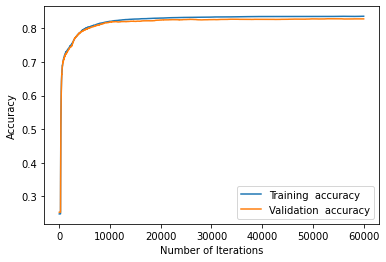

In [65]:
plt.plot(range(len(model.accuracy_history)), model.accuracy_history, label = "Training  accuracy" )
plt.plot(range(len(model.valid_accuracy_history)), model.valid_accuracy_history, label = "Validation  accuracy" )
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

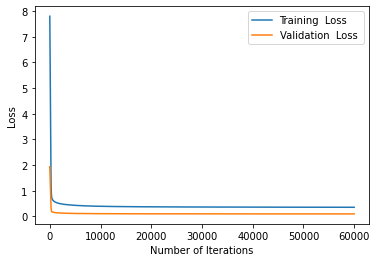

In [66]:
plt.plot(range(len(model.loss_history)), model.loss_history, label = "Training  Loss " )
plt.plot(range(len(model.valid_loss_history)), model.valid_loss_history, label = "Validation  Loss " )
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model2 = LogisticRegression(n_iter=60000,l_rate=0.01,regularization = "L2" )
model2.fit(np.array(X_train),np.array(Y_train),np.array(X_valid),np.array(Y_valid))

Iteration :  0 0.24795888764557172 7.796924749764637
Iteration :  1 0.24795888764557172 7.768102288330899
Iteration :  2 0.24795888764557172 7.7392763270512335
Iteration :  3 0.24795888764557172 7.710447007903963
Iteration :  4 0.24795888764557172 7.681614467693519
Iteration :  5 0.24795888764557172 7.6527788382613995
Iteration :  6 0.24795888764557172 7.623940246689455
Iteration :  7 0.24795888764557172 7.595098815496158
Iteration :  8 0.24795888764557172 7.566254662825912
Iteration :  9 0.24795888764557172 7.537407902631996
Iteration :  10 0.24795888764557172 7.508558644852776
Iteration :  11 0.24795888764557172 7.479706995582163
Iteration :  12 0.24795888764557172 7.450853057234177
Iteration :  13 0.24795888764557172 7.42199692870175
Iteration :  14 0.24795888764557172 7.393138705510433
Iteration :  15 0.24795888764557172 7.36427847996671
Iteration :  16 0.24795888764557172 7.33541634130155
Iteration :  17 0.24795888764557172 7.3065523758092406
Iteration :  18 0.24795888764557172 7.

Iteration :  151 0.24795888764557172 3.4564553421903255
Iteration :  152 0.24795888764557172 3.4285083276970907
Iteration :  153 0.24795888764557172 3.4006001915929565
Iteration :  154 0.24795888764557172 3.372732424862362
Iteration :  155 0.24795888764557172 3.34490656979141
Iteration :  156 0.24795888764557172 3.317124221245936
Iteration :  157 0.24795888764557172 3.289387027939466
Iteration :  158 0.24795888764557172 3.261696693686607
Iteration :  159 0.24795888764557172 3.2340549786370705
Iteration :  160 0.24795888764557172 3.206463700485139
Iteration :  161 0.24795888764557172 3.1789247356490034
Iteration :  162 0.24795888764557172 3.151440020413998
Iteration :  163 0.24795888764557172 3.124011552033352
Iteration :  164 0.24795888764557172 3.096641389779649
Iteration :  165 0.24795888764557172 3.0693316559397905
Iteration :  166 0.24795888764557172 3.0420845367458056
Iteration :  167 0.24795888764557172 3.0149022832334467
Iteration :  168 0.24795888764557172 2.987787212020092
Ite

Iteration :  301 0.5037506734634672 0.9075520086127858
Iteration :  302 0.5055742053131087 0.9033949232346167
Iteration :  303 0.5069832981060135 0.8993205551162773
Iteration :  304 0.5091798251067181 0.8953270437865559
Iteration :  305 0.5108790252393386 0.8914125681448055
Iteration :  306 0.5126196692776327 0.8875753459691968
Iteration :  307 0.5146918645613162 0.8838136334031211
Iteration :  308 0.5166397281279788 0.8801257244223447
Iteration :  309 0.5182974843549256 0.8765099502853562
Iteration :  310 0.5199137966761987 0.8729646789691962
Iteration :  311 0.5210327821293879 0.8694883145928951
Iteration :  312 0.522276099299598 0.8660792968305113
Iteration :  313 0.5238509677151975 0.862736100315618
Iteration :  314 0.5252186166024286 0.8594572340389594
Iteration :  315 0.5265862654896597 0.8562412407408658
Iteration :  316 0.5279124704712173 0.8530866962999065
Iteration :  317 0.5296945584151851 0.8499922091191396
Iteration :  318 0.5315595341705003 0.8469564195112137
Iteration : 

Iteration :  458 0.6536947241908078 0.6779210107398419
Iteration :  459 0.6540677193418708 0.6774440074544233
Iteration :  460 0.6546893779269758 0.6769705492617749
Iteration :  461 0.6551867047950599 0.6765005803173186
Iteration :  462 0.6552695926064073 0.676034045857679
Iteration :  463 0.655559699946123 0.6755708921776945
Iteration :  464 0.655559699946123 0.675111066607961
Iteration :  465 0.6558912511915123 0.6746545174928916
Iteration :  466 0.6562228024369017 0.6742011941692804
Iteration :  467 0.6567201293049857 0.6737510469453586
Iteration :  468 0.6570931244560487 0.6733040270803298
Iteration :  469 0.6574246757014381 0.6728600867643741
Iteration :  470 0.6577562269468274 0.6724191790991065
Iteration :  471 0.6581292220978905 0.6719812580784819
Iteration :  472 0.6585022172489535 0.6715462785701325
Iteration :  473 0.6587923245886692 0.6711141962971302
Iteration :  474 0.6592896514567533 0.670684967820161
Iteration :  475 0.6597455344191636 0.6702585505201017
Iteration :  47

Iteration :  621 0.6897923660325749 0.6253276312153057
Iteration :  622 0.6900824733722906 0.6250898418823206
Iteration :  623 0.6902068050893116 0.6248526482503574
Iteration :  624 0.6901653611836379 0.6246160465562288
Iteration :  625 0.6903311368063326 0.6243800330859955
Iteration :  626 0.6903311368063326 0.624144604174141
Iteration :  627 0.6906212441460483 0.6239097562027607
Iteration :  628 0.6907455758630693 0.6236754856007651
Iteration :  629 0.690787019768743 0.6234417888430998
Iteration :  630 0.6909942392971113 0.6232086624499754
Iteration :  631 0.6910771271084587 0.6229761029861156
Iteration :  632 0.6914501222595217 0.6227441070600158
Iteration :  633 0.6916987856935638 0.6225126713232164
Iteration :  634 0.6918231174105848 0.6222817924695884
Iteration :  635 0.6918645613162584 0.6220514672346321
Iteration :  636 0.6919888930332795 0.6218216923947896
Iteration :  637 0.6920717808446268 0.6215924647667668
Iteration :  638 0.6920717808446268 0.6213637812068694
Iteration : 

Iteration :  773 0.7047121720750964 0.5945550696860934
Iteration :  774 0.7048365037921174 0.5943816098243557
Iteration :  775 0.7048365037921174 0.594208464974044
Iteration :  776 0.7049608355091384 0.5940356342145461
Iteration :  777 0.7049608355091384 0.5938631166304725
Iteration :  778 0.7050851672261594 0.5936909113115953
Iteration :  779 0.705250942848854 0.5935190173527878
Iteration :  780 0.7054167184715487 0.5933474338539644
Iteration :  781 0.7054996062828961 0.5931761599200218
Iteration :  782 0.7055824940942435 0.5930051946607827
Iteration :  783 0.7057897136226118 0.5928345371909368
Iteration :  784 0.7059969331509801 0.5926641866299862
Iteration :  785 0.7060383770566538 0.5924941421021903
Iteration :  786 0.7060798209623275 0.5923244027365109
Iteration :  787 0.7060798209623275 0.5921549676665597
Iteration :  788 0.7061627087736748 0.5919858360305452
Iteration :  789 0.7062041526793486 0.591817006971221
Iteration :  790 0.7062455965850222 0.5916484796358352
Iteration :  

Iteration :  936 0.7140370508516722 0.5698970710973367
Iteration :  937 0.714078494757346 0.56976535888468
Iteration :  938 0.7141199386630196 0.5696338545362193
Iteration :  939 0.7142442703800406 0.5695025575662305
Iteration :  940 0.7143686020970617 0.5693714674904224
Iteration :  941 0.7143686020970617 0.569240583825927
Iteration :  942 0.7144100460027353 0.5691099060912955
Iteration :  943 0.7144929338140826 0.5689794338064899
Iteration :  944 0.7146172655311036 0.5688491664928772
Iteration :  945 0.7146587094367773 0.5687191036732231
Iteration :  946 0.7149073728708193 0.5685892448716848
Iteration :  947 0.714948816776493 0.5684595896138058
Iteration :  948 0.7149073728708193 0.5683301374265086
Iteration :  949 0.7149902606821666 0.568200887838089
Iteration :  950 0.7149902606821666 0.5680718403782096
Iteration :  951 0.715073148493514 0.5679429945778941
Iteration :  952 0.7152389241162087 0.567814349969521
Iteration :  953 0.7153218119275561 0.5676859060868178
Iteration :  954 0

Iteration :  1093 0.7221600563637117 0.5514872431078405
Iteration :  1094 0.7221600563637117 0.5513829952073461
Iteration :  1095 0.7222843880807327 0.5512788932937815
Iteration :  1096 0.7222843880807327 0.5511749370501754
Iteration :  1097 0.72236727589208 0.5510711261603757
Iteration :  1098 0.7225330515147748 0.5509674603090478
Iteration :  1099 0.7226573832317957 0.550863939181671
Iteration :  1100 0.7226573832317957 0.5507605624645373
Iteration :  1101 0.7226988271374695 0.5506573298447481
Iteration :  1102 0.7226988271374695 0.5505542410102126
Iteration :  1103 0.7228231588544904 0.5504512956496447
Iteration :  1104 0.7229474905715114 0.5503484934525611
Iteration :  1105 0.7229889344771852 0.5502458341092787
Iteration :  1106 0.7230718222885325 0.5501433173109129
Iteration :  1107 0.7230718222885325 0.5500409427493744
Iteration :  1108 0.7230718222885325 0.5499387101173674
Iteration :  1109 0.7231547100998799 0.5498366191083867
Iteration :  1110 0.7230718222885325 0.549734669416

Iteration :  1254 0.7277135397239836 0.5363875008353148
Iteration :  1255 0.7277549836296573 0.5363031754357539
Iteration :  1256 0.7277135397239836 0.5362189541103694
Iteration :  1257 0.7277964275353309 0.536134836648184
Iteration :  1258 0.7278793153466783 0.5360508228387413
Iteration :  1259 0.7278793153466783 0.5359669124721047
Iteration :  1260 0.7278793153466783 0.5358831053388564
Iteration :  1261 0.7279207592523519 0.5357994012300953
Iteration :  1262 0.7280865348750466 0.5357157999374362
Iteration :  1263 0.7280865348750466 0.5356323012530083
Iteration :  1264 0.7281279787807203 0.5355489049694532
Iteration :  1265 0.728169422686394 0.5354656108799243
Iteration :  1266 0.728169422686394 0.5353824187780847
Iteration :  1267 0.7281279787807203 0.535299328458107
Iteration :  1268 0.7281279787807203 0.5352163397146699
Iteration :  1269 0.7281279787807203 0.5351334523429585
Iteration :  1270 0.7282937544034149 0.5350506661386631
Iteration :  1271 0.7283351983090887 0.5349679808979

Iteration :  1417 0.7315678229516349 0.5238806456435025
Iteration :  1418 0.7316507107629823 0.5238108312774102
Iteration :  1419 0.731692154668656 0.5237410925769165
Iteration :  1420 0.731692154668656 0.5236714293998224
Iteration :  1421 0.731692154668656 0.5236018416042659
Iteration :  1422 0.731692154668656 0.5235323290487188
Iteration :  1423 0.7317335985743296 0.5234628915919878
Iteration :  1424 0.7317335985743296 0.523393529093212
Iteration :  1425 0.7317750424800034 0.5233242414118637
Iteration :  1426 0.7317750424800034 0.5232550284077461
Iteration :  1427 0.7317750424800034 0.5231858899409925
Iteration :  1428 0.7317750424800034 0.5231168258720669
Iteration :  1429 0.7317750424800034 0.5230478360617615
Iteration :  1430 0.731816486385677 0.5229789203711964
Iteration :  1431 0.731816486385677 0.5229100786618187
Iteration :  1432 0.731816486385677 0.5228413107954021
Iteration :  1433 0.731816486385677 0.5227726166340448
Iteration :  1434 0.7318993741970243 0.5227039960401707
I

Iteration :  1567 0.7352148866509179 0.5141819707915761
Iteration :  1568 0.7352563305565917 0.5141220856839446
Iteration :  1569 0.735339218367939 0.5140622582209083
Iteration :  1570 0.7353806622736127 0.5140024883019406
Iteration :  1571 0.7354221061792864 0.5139427758267413
Iteration :  1572 0.7354221061792864 0.5138831206952366
Iteration :  1573 0.7354221061792864 0.5138235228075781
Iteration :  1574 0.7354221061792864 0.5137639820641423
Iteration :  1575 0.7354221061792864 0.5137044983655303
Iteration :  1576 0.73546355008496 0.5136450716125672
Iteration :  1577 0.735587881801981 0.513585701706301
Iteration :  1578 0.7356707696133283 0.5135263885480026
Iteration :  1579 0.7357122135190021 0.5134671320391649
Iteration :  1580 0.7357122135190021 0.5134079320815025
Iteration :  1581 0.735836545236023 0.5133487885769509
Iteration :  1582 0.735836545236023 0.5132897014276658
Iteration :  1583 0.735836545236023 0.5132306705360233
Iteration :  1584 0.7357951013303494 0.5131716958046182


Iteration :  1723 0.7377429648970119 0.5054794176204783
Iteration :  1724 0.7377844088026856 0.5054274376683046
Iteration :  1725 0.7377844088026856 0.5053755020933393
Iteration :  1726 0.7378672966140329 0.5053236108242838
Iteration :  1727 0.7377844088026856 0.5052717637899921
Iteration :  1728 0.7378258527083592 0.5052199609194707
Iteration :  1729 0.7379087405197066 0.5051682021418784
Iteration :  1730 0.7379501844253803 0.5051164873865257
Iteration :  1731 0.7379087405197066 0.5050648165828738
Iteration :  1732 0.7379501844253803 0.5050131896605355
Iteration :  1733 0.7379501844253803 0.5049616065492739
Iteration :  1734 0.7379501844253803 0.5049100671790023
Iteration :  1735 0.7379501844253803 0.5048585714797841
Iteration :  1736 0.7379916283310539 0.5048071193818314
Iteration :  1737 0.7380330722367275 0.5047557108155061
Iteration :  1738 0.7380745161424013 0.5047043457113188
Iteration :  1739 0.7381574039537486 0.5046530239999281
Iteration :  1740 0.7381574039537486 0.504601745

Iteration :  1879 0.7415972481246633 0.4978661883438386
Iteration :  1880 0.7416386920303369 0.4978203557856098
Iteration :  1881 0.7416801359360106 0.49777455811714666
Iteration :  1882 0.7417215798416843 0.49772879528698927
Iteration :  1883 0.7417630237473579 0.49768306724378236
Iteration :  1884 0.7418459115587053 0.4976373739362749
Iteration :  1885 0.7418459115587053 0.49759171531331997
Iteration :  1886 0.741887355464379 0.4975460913238746
Iteration :  1887 0.741887355464379 0.49750050191699924
Iteration :  1888 0.741887355464379 0.49745494704185783
Iteration :  1889 0.7419287993700526 0.49740942664771726
Iteration :  1890 0.7419287993700526 0.49736394068394757
Iteration :  1891 0.7419287993700526 0.49731848910002097
Iteration :  1892 0.741887355464379 0.4972730718455123
Iteration :  1893 0.741887355464379 0.4972276888700985
Iteration :  1894 0.7418459115587053 0.4971823401235584
Iteration :  1895 0.7418459115587053 0.49713702555577255
Iteration :  1896 0.7418044676530317 0.4970

Iteration :  2034 0.7453271996352936 0.4911494843108911
Iteration :  2035 0.7453686435409673 0.4911085038235326
Iteration :  2036 0.745410087446641 0.4910675513603862
Iteration :  2037 0.745410087446641 0.49102662688359344
Iteration :  2038 0.7454515313523147 0.4909857303553682
Iteration :  2039 0.7454515313523147 0.49094486173799734
Iteration :  2040 0.7454929752579883 0.49090402099384
Iteration :  2041 0.7454929752579883 0.49086320808532796
Iteration :  2042 0.745534419163662 0.49082242297496487
Iteration :  2043 0.7455758630693357 0.4907816656253267
Iteration :  2044 0.7455758630693357 0.49074093599906093
Iteration :  2045 0.7455758630693357 0.4907002340588871
Iteration :  2046 0.7455758630693357 0.4906595597675958
Iteration :  2047 0.7455758630693357 0.4906189130880494
Iteration :  2048 0.7456173069750093 0.49057829398318137
Iteration :  2049 0.7456173069750093 0.49053770241599615
Iteration :  2050 0.745658750880683 0.4904971383495689
Iteration :  2051 0.7457001947863566 0.49045660

Iteration :  2193 0.7488499316175556 0.4849624555821177
Iteration :  2194 0.7488499316175556 0.48492549933492757
Iteration :  2195 0.7488913755232293 0.48488856590806295
Iteration :  2196 0.7488913755232293 0.48485165527340957
Iteration :  2197 0.748932819428903 0.48481476740290386
Iteration :  2198 0.7488913755232293 0.4847779022685334
Iteration :  2199 0.7488913755232293 0.48474105984233656
Iteration :  2200 0.7488499316175556 0.4847042400964024
Iteration :  2201 0.7488499316175556 0.48466744300287057
Iteration :  2202 0.7488499316175556 0.48463066853393094
Iteration :  2203 0.7488913755232293 0.48459391666182433
Iteration :  2204 0.7488913755232293 0.4845571873588414
Iteration :  2205 0.748932819428903 0.484520480597323
Iteration :  2206 0.748932819428903 0.4844837963496601
Iteration :  2207 0.748932819428903 0.4844471345882936
Iteration :  2208 0.748932819428903 0.4844104952857142
Iteration :  2209 0.748932819428903 0.4843738784144622
Iteration :  2210 0.748932819428903 0.484337283

Iteration :  2350 0.7515852293920179 0.4794231591528887
Iteration :  2351 0.7515437854863443 0.47938947117244624
Iteration :  2352 0.7516681172033652 0.4793558021589308
Iteration :  2353 0.7516681172033652 0.4793221520910312
Iteration :  2354 0.7516681172033652 0.4792885209474727
Iteration :  2355 0.751709561109039 0.47925490870701715
Iteration :  2356 0.751709561109039 0.47922131534846246
Iteration :  2357 0.7517510050147126 0.4791877408506426
Iteration :  2358 0.751709561109039 0.47915418519242853
Iteration :  2359 0.7516681172033652 0.479120648352726
Iteration :  2360 0.7516681172033652 0.47908713031047795
Iteration :  2361 0.7516681172033652 0.4790536310446626
Iteration :  2362 0.7516681172033652 0.47902015053429414
Iteration :  2363 0.751709561109039 0.47898668875842265
Iteration :  2364 0.7517510050147126 0.4789532456961337
Iteration :  2365 0.7517510050147126 0.47891982132654864
Iteration :  2366 0.7517510050147126 0.47888641562882445
Iteration :  2367 0.7517510050147126 0.47885

Iteration :  2497 0.7543205271664801 0.4746641488417467
Iteration :  2498 0.7544448588835012 0.4746330378822526
Iteration :  2499 0.7544863027891748 0.47460194311166687
Iteration :  2500 0.7544863027891748 0.4745708645133034
Iteration :  2501 0.7544863027891748 0.4745398020705028
Iteration :  2502 0.7545691906005222 0.47450875576663226
Iteration :  2503 0.7546520784118695 0.4744777255850866
Iteration :  2504 0.7547349662232169 0.4744467115092866
Iteration :  2505 0.7548178540345643 0.47441571352268025
Iteration :  2506 0.7548592979402379 0.47438473160874217
Iteration :  2507 0.7549421857515852 0.4743537657509734
Iteration :  2508 0.7550250735629326 0.4743228159329016
Iteration :  2509 0.7550250735629326 0.4742918821380811
Iteration :  2510 0.7550665174686062 0.47426096435009263
Iteration :  2511 0.7550665174686062 0.47423006255254335
Iteration :  2512 0.7550250735629326 0.47419917672906664
Iteration :  2513 0.7550250735629326 0.4741683068633222
Iteration :  2514 0.7550250735629326 0.47

Iteration :  2645 0.7585478055451946 0.4702274847766446
Iteration :  2646 0.7585478055451946 0.47019860155007964
Iteration :  2647 0.7585478055451946 0.47016973230945786
Iteration :  2648 0.7586721372622156 0.47014087704155083
Iteration :  2649 0.7586721372622156 0.4701120357331503
Iteration :  2650 0.7587964689792366 0.47008320837106804
Iteration :  2651 0.7588379128849103 0.47005439494213586
Iteration :  2652 0.7588793567905839 0.47002559543320566
Iteration :  2653 0.7589622446019313 0.46999680983114916
Iteration :  2654 0.7590451324132786 0.4699680381228581
Iteration :  2655 0.7590865763189523 0.4699392802952441
Iteration :  2656 0.7590865763189523 0.46991053633523855
Iteration :  2657 0.7591694641302996 0.46988180622979275
Iteration :  2658 0.7591694641302996 0.46985308996587777
Iteration :  2659 0.7591694641302996 0.4698243875304843
Iteration :  2660 0.759128020224626 0.46979569891062267
Iteration :  2661 0.7592109080359734 0.4697670240933232
Iteration :  2662 0.7592109080359734 0

Iteration :  2796 0.7632309668863194 0.4660174638033513
Iteration :  2797 0.763272410791993 0.46599055319783167
Iteration :  2798 0.7632309668863194 0.4659636547883801
Iteration :  2799 0.763272410791993 0.46593676856440963
Iteration :  2800 0.763272410791993 0.46590989451534853
Iteration :  2801 0.763272410791993 0.4658830326306403
Iteration :  2802 0.7633138546976667 0.46585618289974284
Iteration :  2803 0.7633552986033404 0.4658293453121299
Iteration :  2804 0.763396742509014 0.46580251985728965
Iteration :  2805 0.763396742509014 0.46577570652472544
Iteration :  2806 0.7634796303203614 0.46574890530395563
Iteration :  2807 0.7635210742260351 0.4657221161845135
Iteration :  2808 0.7635210742260351 0.4656953391559469
Iteration :  2809 0.7636039620373825 0.4656685742078189
Iteration :  2810 0.7636039620373825 0.46564182132970733
Iteration :  2811 0.7636039620373825 0.4656150805112046
Iteration :  2812 0.7637282937544034 0.4655883517419183
Iteration :  2813 0.7637282937544034 0.4655616

Iteration :  2956 0.7672510257366654 0.46186018408720336
Iteration :  2957 0.7672510257366654 0.46183509962009095
Iteration :  2958 0.7673339135480127 0.46181002583005554
Iteration :  2959 0.7673753574536865 0.4617849627086084
Iteration :  2960 0.7673339135480127 0.46175991024727187
Iteration :  2961 0.7673339135480127 0.46173486843758005
Iteration :  2962 0.7674168013593601 0.4617098372710779
Iteration :  2963 0.7674168013593601 0.46168481673932193
Iteration :  2964 0.7674582452650338 0.4616598068338795
Iteration :  2965 0.7674582452650338 0.4616348075463296
Iteration :  2966 0.7676240208877284 0.4616098188682619
Iteration :  2967 0.7676654647934021 0.4615848407912778
Iteration :  2968 0.7676654647934021 0.4615598733069894
Iteration :  2969 0.7677069086990758 0.4615349164070202
Iteration :  2970 0.7677483526047495 0.46150997008300476
Iteration :  2971 0.7678312404160968 0.4614850343265886
Iteration :  2972 0.7678312404160968 0.4614601091294284
Iteration :  2973 0.7678312404160968 0.46

Iteration :  3117 0.7720170748891375 0.4579535996168767
Iteration :  3118 0.7719756309834639 0.4579301320344121
Iteration :  3119 0.7719756309834639 0.4579066738953147
Iteration :  3120 0.7720585187948112 0.4578832251926837
Iteration :  3121 0.7720999627004849 0.457859785919627
Iteration :  3122 0.7720999627004849 0.457836356069261
Iteration :  3123 0.7720999627004849 0.4578129356347104
Iteration :  3124 0.7720999627004849 0.45778952460910893
Iteration :  3125 0.7720585187948112 0.4577661229855983
Iteration :  3126 0.7721828505118322 0.457742730757329
Iteration :  3127 0.772224294417506 0.4577193479174599
Iteration :  3128 0.772224294417506 0.4576959744591584
Iteration :  3129 0.7723071822288532 0.45767261037560014
Iteration :  3130 0.7723071822288532 0.4576492556599693
Iteration :  3131 0.7723900700402005 0.45762591030545846
Iteration :  3132 0.7723900700402005 0.45760257430526885
Iteration :  3133 0.7723900700402005 0.45757924765260954
Iteration :  3134 0.7724315139458743 0.457555930

Iteration :  3270 0.7744622653238841 0.45446900689565367
Iteration :  3271 0.7744622653238841 0.4544469086142365
Iteration :  3272 0.7745037092295578 0.4544248188119813
Iteration :  3273 0.7745037092295578 0.45440273748314364
Iteration :  3274 0.7745037092295578 0.4543806646219858
Iteration :  3275 0.7745037092295578 0.45435860022277663
Iteration :  3276 0.7745037092295578 0.4543365442797915
Iteration :  3277 0.7745451531352314 0.45431449678731245
Iteration :  3278 0.7745865970409052 0.45429245773962823
Iteration :  3279 0.7745865970409052 0.45427042713103416
Iteration :  3280 0.7745451531352314 0.4542484049558321
Iteration :  3281 0.7745865970409052 0.4542263912083302
Iteration :  3282 0.7746280409465788 0.45420438588284373
Iteration :  3283 0.7746694848522525 0.4541823889736943
Iteration :  3284 0.7746280409465788 0.45416040047520956
Iteration :  3285 0.7746694848522525 0.4541384203817243
Iteration :  3286 0.7747109287579261 0.4541164486875797
Iteration :  3287 0.7747938165692735 0.4

Iteration :  3428 0.7774462265323884 0.45107909873067753
Iteration :  3429 0.7774876704380621 0.45105827294027834
Iteration :  3430 0.7775291143437357 0.45103745479738394
Iteration :  3431 0.7775291143437357 0.4510166442971791
Iteration :  3432 0.7774876704380621 0.45099584143485305
Iteration :  3433 0.7774876704380621 0.4509750462056008
Iteration :  3434 0.7774876704380621 0.4509542586046224
Iteration :  3435 0.7774462265323884 0.4509334786271229
Iteration :  3436 0.7775291143437357 0.4509127062683127
Iteration :  3437 0.7775291143437357 0.45089194152340717
Iteration :  3438 0.7775291143437357 0.45087118438762674
Iteration :  3439 0.7775291143437357 0.4508504348561973
Iteration :  3440 0.7775705582494095 0.4508296929243496
Iteration :  3441 0.7776120021550831 0.45080895858731945
Iteration :  3442 0.7776120021550831 0.45078823184034805
Iteration :  3443 0.7776534460607568 0.4507675126786813
Iteration :  3444 0.7776534460607568 0.4507468010975704
Iteration :  3445 0.7777363338721041 0.4

Iteration :  3574 0.7803887438352191 0.44811712563586825
Iteration :  3575 0.7803887438352191 0.44809736790289284
Iteration :  3576 0.7803887438352191 0.44807761716538547
Iteration :  3577 0.7803887438352191 0.44805787341920933
Iteration :  3578 0.7803887438352191 0.44803813666023196
Iteration :  3579 0.7804716316465664 0.4480184068843251
Iteration :  3580 0.7804716316465664 0.4479986840873645
Iteration :  3581 0.7804716316465664 0.4479789682652302
Iteration :  3582 0.7805545194579138 0.44795925941380627
Iteration :  3583 0.7805545194579138 0.44793955752898096
Iteration :  3584 0.780637407269261 0.4479198626066465
Iteration :  3585 0.7806788511749347 0.4479001746426995
Iteration :  3586 0.7806788511749347 0.44788049363304056
Iteration :  3587 0.7806788511749347 0.4478608195735742
Iteration :  3588 0.7806788511749347 0.44784115246020945
Iteration :  3589 0.7806788511749347 0.4478214922888589
Iteration :  3590 0.7806788511749347 0.4478018390554397
Iteration :  3591 0.7807202950806084 0.4

Iteration :  3727 0.7830411537983339 0.44517320218995704
Iteration :  3728 0.7830411537983339 0.4451544689701996
Iteration :  3729 0.7830411537983339 0.4451357421580295
Iteration :  3730 0.7830825977040077 0.4451170217498816
Iteration :  3731 0.7831240416096813 0.445098307742194
Iteration :  3732 0.7831240416096813 0.4450796001314083
Iteration :  3733 0.7831240416096813 0.44506089891396916
Iteration :  3734 0.7831240416096813 0.44504220408632494
Iteration :  3735 0.7831240416096813 0.44502351564492715
Iteration :  3736 0.7831240416096813 0.4450048335862305
Iteration :  3737 0.7831654855153549 0.4449861579066931
Iteration :  3738 0.7831240416096813 0.4449674886027764
Iteration :  3739 0.7831240416096813 0.4449488256709453
Iteration :  3740 0.7831240416096813 0.44493016910766775
Iteration :  3741 0.7831654855153549 0.4449115189094151
Iteration :  3742 0.7832483733267023 0.4448928750726619
Iteration :  3743 0.783289817232376 0.4448742375938862
Iteration :  3744 0.783289817232376 0.4448556

Iteration :  3880 0.7853620125160595 0.4423795108252361
Iteration :  3881 0.7853620125160595 0.4423617183696962
Iteration :  3882 0.7854034564217331 0.4423439318125822
Iteration :  3883 0.7854034564217331 0.4423261511507907
Iteration :  3884 0.7854449003274069 0.4423083763812209
Iteration :  3885 0.7854863442330805 0.4422906075007747
Iteration :  3886 0.7854863442330805 0.4422728445063569
Iteration :  3887 0.7854863442330805 0.4422550873948746
Iteration :  3888 0.7854863442330805 0.44223733616323824
Iteration :  3889 0.7854863442330805 0.44221959080836015
Iteration :  3890 0.7854863442330805 0.44220185132715606
Iteration :  3891 0.7854863442330805 0.44218411771654387
Iteration :  3892 0.7854863442330805 0.4421663899734446
Iteration :  3893 0.7855277881387542 0.4421486680947818
Iteration :  3894 0.7855277881387542 0.44213095207748154
Iteration :  3895 0.7854863442330805 0.4421132419184727
Iteration :  3896 0.7854863442330805 0.44209553761468684
Iteration :  3897 0.7854863442330805 0.442

Iteration :  4029 0.786936880931659 0.4397918458463727
Iteration :  4030 0.786936880931659 0.43977489943713743
Iteration :  4031 0.7869783248373327 0.43975795849202876
Iteration :  4032 0.7869783248373327 0.4397410230083115
Iteration :  4033 0.7869783248373327 0.4397240929832525
Iteration :  4034 0.7869783248373327 0.43970716841412094
Iteration :  4035 0.7869783248373327 0.4396902492981882
Iteration :  4036 0.7869783248373327 0.4396733356327278
Iteration :  4037 0.7870197687430064 0.4396564274150158
Iteration :  4038 0.7870197687430064 0.43963952464233025
Iteration :  4039 0.78706121264868 0.4396226273119514
Iteration :  4040 0.78706121264868 0.4396057354211617
Iteration :  4041 0.78706121264868 0.43958884896724626
Iteration :  4042 0.7871441004600274 0.4395719679474917
Iteration :  4043 0.7871441004600274 0.4395550923591873
Iteration :  4044 0.787185544365701 0.4395382221996245
Iteration :  4045 0.787185544365701 0.43952135746609694
Iteration :  4046 0.7873098760827221 0.4395044981559

Iteration :  4184 0.7891334079323635 0.4372287517967029
Iteration :  4185 0.7891748518380373 0.4372126209839771
Iteration :  4186 0.7892577396493845 0.43719649523655574
Iteration :  4187 0.7892577396493845 0.43718037455201963
Iteration :  4188 0.7892577396493845 0.43716425892795235
Iteration :  4189 0.7892577396493845 0.4371481483619386
Iteration :  4190 0.7892991835550582 0.43713204285156537
Iteration :  4191 0.7892991835550582 0.4371159423944214
Iteration :  4192 0.7894235152720792 0.4370998469880974
Iteration :  4193 0.7893820713664056 0.43708375663018567
Iteration :  4194 0.7894235152720792 0.4370676713182804
Iteration :  4195 0.7894235152720792 0.43705159104997776
Iteration :  4196 0.7895064030834266 0.43703551582287564
Iteration :  4197 0.7895064030834266 0.43701944563457396
Iteration :  4198 0.7895064030834266 0.43700338048267423
Iteration :  4199 0.7895478469891003 0.4369873203647798
Iteration :  4200 0.7895892908947739 0.43697126527849617
Iteration :  4201 0.7896307348004475 0

Iteration :  4330 0.7917443739898048 0.4349260731280625
Iteration :  4331 0.7917858178954784 0.4349106571530872
Iteration :  4332 0.7917443739898048 0.4348952459088843
Iteration :  4333 0.7917443739898048 0.4348798393932846
Iteration :  4334 0.7917858178954784 0.4348644376041204
Iteration :  4335 0.7918272618011521 0.4348490405392257
Iteration :  4336 0.7918687057068258 0.43483364819643583
Iteration :  4337 0.7919101496124995 0.4348182605735881
Iteration :  4338 0.7919101496124995 0.4348028776685207
Iteration :  4339 0.7919101496124995 0.43478749947907425
Iteration :  4340 0.7919515935181731 0.4347721260030903
Iteration :  4341 0.7919101496124995 0.434756757238412
Iteration :  4342 0.7918687057068258 0.43474139318288446
Iteration :  4343 0.7918687057068258 0.4347260338343539
Iteration :  4344 0.7918687057068258 0.4347106791906684
Iteration :  4345 0.7918687057068258 0.4346953292496773
Iteration :  4346 0.7918687057068258 0.4346799840092318
Iteration :  4347 0.7918687057068258 0.4346646

Iteration :  4484 0.7936922375564673 0.4326064856172724
Iteration :  4485 0.7936922375564673 0.4325917735246449
Iteration :  4486 0.7937751253678147 0.43257706584622796
Iteration :  4487 0.7937751253678147 0.43256236258007513
Iteration :  4488 0.7938165692734883 0.43254766372424064
Iteration :  4489 0.7938165692734883 0.43253296927678075
Iteration :  4490 0.793858013179162 0.43251827923575253
Iteration :  4491 0.7938994570848357 0.4325035935992145
Iteration :  4492 0.7939409009905093 0.4324889123652266
Iteration :  4493 0.7940237888018566 0.4324742355318499
Iteration :  4494 0.7940237888018566 0.4324595630971472
Iteration :  4495 0.7940237888018566 0.43244489505918215
Iteration :  4496 0.7940652327075304 0.4324302314160199
Iteration :  4497 0.7940652327075304 0.43241557216572707
Iteration :  4498 0.7941481205188777 0.43240091730637126
Iteration :  4499 0.7941481205188777 0.4323862668360216
Iteration :  4500 0.7942310083302251 0.4323716207527486
Iteration :  4501 0.7942310083302251 0.43

Iteration :  4633 0.7956815450288035 0.4304620285304743
Iteration :  4634 0.7957229889344772 0.4304479533810932
Iteration :  4635 0.7957644328401509 0.43043388236977476
Iteration :  4636 0.7958058767458245 0.43041981549475566
Iteration :  4637 0.7958058767458245 0.4304057527542737
Iteration :  4638 0.7958473206514982 0.4303916941465676
Iteration :  4639 0.7958473206514982 0.43037763966987747
Iteration :  4640 0.7958473206514982 0.4303635893224444
Iteration :  4641 0.7958473206514982 0.43034954310251083
Iteration :  4642 0.7958473206514982 0.4303355010083201
Iteration :  4643 0.7958887645571718 0.43032146303811675
Iteration :  4644 0.7958887645571718 0.43030742919014653
Iteration :  4645 0.7958887645571718 0.4302933994626562
Iteration :  4646 0.7959302084628456 0.43027937385389375
Iteration :  4647 0.7958887645571718 0.43026535236210817
Iteration :  4648 0.7958887645571718 0.43025133498554985
Iteration :  4649 0.7958887645571718 0.43023732172247003
Iteration :  4650 0.7959302084628456 0

Iteration :  4789 0.7970906378217083 0.42831526625721494
Iteration :  4790 0.7970906378217083 0.4283018160072612
Iteration :  4791 0.7970906378217083 0.42828836963338257
Iteration :  4792 0.7971735256330557 0.42827492713398047
Iteration :  4793 0.7971735256330557 0.42826148850745765
Iteration :  4794 0.797256413444403 0.42824805375221725
Iteration :  4795 0.7972978573500766 0.42823462286666386
Iteration :  4796 0.7972978573500766 0.42822119584920265
Iteration :  4797 0.7973393012557504 0.4282077726982403
Iteration :  4798 0.7973393012557504 0.42819435341218387
Iteration :  4799 0.7973393012557504 0.42818093798944185
Iteration :  4800 0.7973393012557504 0.42816752642842343
Iteration :  4801 0.7973393012557504 0.4281541187275389
Iteration :  4802 0.7973393012557504 0.4281407148851995
Iteration :  4803 0.7973393012557504 0.4281273148998173
Iteration :  4804 0.797380745161424 0.42811391876980576
Iteration :  4805 0.797380745161424 0.42810052649357866
Iteration :  4806 0.797380745161424 0.4

Iteration :  4936 0.7986655062373078 0.4263788623850918
Iteration :  4937 0.7986655062373078 0.4263659652557385
Iteration :  4938 0.7986655062373078 0.4263530717775291
Iteration :  4939 0.7986655062373078 0.42634018194900003
Iteration :  4940 0.7987069501429814 0.4263272957686881
Iteration :  4941 0.7987483940486552 0.42631441323513114
Iteration :  4942 0.7987483940486552 0.4263015343468679
Iteration :  4943 0.7987483940486552 0.42628865910243796
Iteration :  4944 0.7987483940486552 0.4262757875003815
Iteration :  4945 0.7987483940486552 0.42626291953924
Iteration :  4946 0.7987069501429814 0.42625005521755555
Iteration :  4947 0.7987483940486552 0.426237194533871
Iteration :  4948 0.7987483940486552 0.4262243374867303
Iteration :  4949 0.7987483940486552 0.42621148407467796
Iteration :  4950 0.7987483940486552 0.42619863429625954
Iteration :  4951 0.7987483940486552 0.4261857881500214
Iteration :  4952 0.7987483940486552 0.4261729456345108
Iteration :  4953 0.7987898379543288 0.426160

Iteration :  5089 0.7997430477848232 0.4244472186311954
Iteration :  5090 0.7997430477848232 0.4244348635898262
Iteration :  5091 0.7997430477848232 0.4244225119851555
Iteration :  5092 0.7997430477848232 0.4244101638158422
Iteration :  5093 0.7997430477848232 0.4243978190805457
Iteration :  5094 0.7997844916904969 0.42438547777792623
Iteration :  5095 0.7997844916904969 0.42437313990664494
Iteration :  5096 0.7997844916904969 0.42436080546536337
Iteration :  5097 0.7997844916904969 0.4243484744527441
Iteration :  5098 0.7997844916904969 0.4243361468674504
Iteration :  5099 0.7997844916904969 0.42432382270814634
Iteration :  5100 0.7997430477848232 0.4243115019734965
Iteration :  5101 0.7997430477848232 0.4242991846621663
Iteration :  5102 0.7997430477848232 0.4242868707728222
Iteration :  5103 0.7997430477848232 0.424274560304131
Iteration :  5104 0.7997430477848232 0.42426225325476047
Iteration :  5105 0.7997430477848232 0.424249949623379
Iteration :  5106 0.7997844916904969 0.424237

Iteration :  5251 0.8003647063699283 0.4224896072417026
Iteration :  5252 0.8003647063699283 0.4224777919588737
Iteration :  5253 0.800406150275602 0.4224659799048184
Iteration :  5254 0.800406150275602 0.42245417107830907
Iteration :  5255 0.800406150275602 0.422442365478119
Iteration :  5256 0.8004475941812756 0.42243056310302196
Iteration :  5257 0.8004475941812756 0.4224187639517922
Iteration :  5258 0.8004475941812756 0.42240696802320493
Iteration :  5259 0.8004475941812756 0.422395175316036
Iteration :  5260 0.8004475941812756 0.4223833858290616
Iteration :  5261 0.8004890380869493 0.4223715995610588
Iteration :  5262 0.8004890380869493 0.42235981651080534
Iteration :  5263 0.8004890380869493 0.42234803667707965
Iteration :  5264 0.800530481992623 0.4223362600586606
Iteration :  5265 0.8005719258982966 0.42232448665432804
Iteration :  5266 0.8005719258982966 0.422312716462862
Iteration :  5267 0.8006133698039704 0.42230094948304364
Iteration :  5268 0.8006133698039704 0.422289185

Iteration :  5404 0.8018566869741804 0.42071870877676615
Iteration :  5405 0.8018566869741804 0.4207073735956496
Iteration :  5406 0.8018566869741804 0.4206960414628343
Iteration :  5407 0.8018981308798541 0.4206847123771875
Iteration :  5408 0.8018981308798541 0.42067338633757706
Iteration :  5409 0.8018981308798541 0.4206620633428712
Iteration :  5410 0.8019395747855278 0.42065074339193886
Iteration :  5411 0.8019395747855278 0.4206394264836494
Iteration :  5412 0.8019395747855278 0.4206281126168732
Iteration :  5413 0.8019395747855278 0.42061680179048067
Iteration :  5414 0.8019810186912014 0.4206054940033432
Iteration :  5415 0.8019810186912014 0.42059418925433245
Iteration :  5416 0.8019810186912014 0.420582887542321
Iteration :  5417 0.8020224625968752 0.42057158886618184
Iteration :  5418 0.8020224625968752 0.42056029322478833
Iteration :  5419 0.8021053504082225 0.4205490006170147
Iteration :  5420 0.8021053504082225 0.4205377110417358
Iteration :  5421 0.8021053504082225 0.420

Iteration :  5551 0.8031000041443905 0.4190845715740817
Iteration :  5552 0.8031000041443905 0.41907367263133954
Iteration :  5553 0.8031000041443905 0.4190627765764105
Iteration :  5554 0.8030585602387169 0.4190518834082429
Iteration :  5555 0.8030585602387169 0.4190409931257857
Iteration :  5556 0.8030585602387169 0.4190301057279884
Iteration :  5557 0.8031000041443905 0.41901922121380086
Iteration :  5558 0.8031000041443905 0.41900833958217365
Iteration :  5559 0.8031828919557379 0.4189974608320578
Iteration :  5560 0.8032243358614116 0.41898658496240476
Iteration :  5561 0.8032243358614116 0.41897571197216665
Iteration :  5562 0.8032657797670852 0.4189648418602961
Iteration :  5563 0.8032657797670852 0.4189539746257462
Iteration :  5564 0.8032657797670852 0.4189431102674702
Iteration :  5565 0.8032657797670852 0.4189322487844228
Iteration :  5566 0.8032657797670852 0.41892139017555835
Iteration :  5567 0.8032657797670852 0.41891053443983206
Iteration :  5568 0.8032657797670852 0.41

Iteration :  5708 0.804301877408927 0.4174081488361202
Iteration :  5709 0.8042604335032534 0.417397690724282
Iteration :  5710 0.8042604335032534 0.41738723534133354
Iteration :  5711 0.8042604335032534 0.4173767826863012
Iteration :  5712 0.804301877408927 0.41736633275821156
Iteration :  5713 0.804301877408927 0.41735588555609154
Iteration :  5714 0.804301877408927 0.41734544107896887
Iteration :  5715 0.804301877408927 0.41733499932587154
Iteration :  5716 0.804301877408927 0.4173245602958282
Iteration :  5717 0.804301877408927 0.41731412398786755
Iteration :  5718 0.804301877408927 0.4173036904010193
Iteration :  5719 0.804301877408927 0.4172932595343131
Iteration :  5720 0.804301877408927 0.4172828313867795
Iteration :  5721 0.804301877408927 0.4172724059574494
Iteration :  5722 0.804301877408927 0.41726198324535385
Iteration :  5723 0.8043433213146007 0.4172515632495248
Iteration :  5724 0.8043433213146007 0.4172411459689944
Iteration :  5725 0.8043433213146007 0.417230731402795

Iteration :  5863 0.8046334286543164 0.4158191286608975
Iteration :  5864 0.8046334286543164 0.4158090821822352
Iteration :  5865 0.8046334286543164 0.4157990382869217
Iteration :  5866 0.8046334286543164 0.4157889969740521
Iteration :  5867 0.8046334286543164 0.41577895824272204
Iteration :  5868 0.8046334286543164 0.4157689220920274
Iteration :  5869 0.8046334286543164 0.41575888852106474
Iteration :  5870 0.8046334286543164 0.4157488575289306
Iteration :  5871 0.8046334286543164 0.4157388291147225
Iteration :  5872 0.8046334286543164 0.415728803277538
Iteration :  5873 0.8045919847486427 0.4157187800164751
Iteration :  5874 0.8045919847486427 0.4157087593306324
Iteration :  5875 0.8045919847486427 0.41569874121910894
Iteration :  5876 0.8045919847486427 0.41568872568100373
Iteration :  5877 0.8046334286543164 0.41567871271541684
Iteration :  5878 0.8046334286543164 0.4156687023214485
Iteration :  5879 0.8046334286543164 0.41565869449819903
Iteration :  5880 0.8046334286543164 0.4156

Iteration :  6019 0.8051307555224004 0.41428255892808374
Iteration :  6020 0.8051307555224004 0.41427290476769146
Iteration :  6021 0.8051307555224004 0.41426325305442824
Iteration :  6022 0.805172199428074 0.4142536037874519
Iteration :  6023 0.805172199428074 0.41424395696592076
Iteration :  6024 0.805172199428074 0.4142343125889934
Iteration :  6025 0.8052136433337478 0.4142246706558286
Iteration :  6026 0.8052136433337478 0.41421503116558583
Iteration :  6027 0.8052136433337478 0.4142053941174248
Iteration :  6028 0.8052136433337478 0.41419575951050563
Iteration :  6029 0.8052136433337478 0.4141861273439887
Iteration :  6030 0.8052550872394214 0.41417649761703507
Iteration :  6031 0.8052550872394214 0.4141668703288057
Iteration :  6032 0.8052550872394214 0.41415724547846255
Iteration :  6033 0.8052550872394214 0.41414762306516734
Iteration :  6034 0.8052550872394214 0.4141380030880827
Iteration :  6035 0.8052550872394214 0.41412838554637105
Iteration :  6036 0.8052550872394214 0.41

Iteration :  6169 0.8060010775415475 0.41286132484056415
Iteration :  6170 0.8060425214472212 0.4128520285439717
Iteration :  6171 0.8060839653528948 0.412842734572321
Iteration :  6172 0.8061254092585686 0.4128334429248251
Iteration :  6173 0.8061254092585686 0.41282415360069646
Iteration :  6174 0.8061668531642422 0.41281486659914857
Iteration :  6175 0.8062082970699158 0.412805581919395
Iteration :  6176 0.8062082970699158 0.4127962995606495
Iteration :  6177 0.8062497409755895 0.41278701952212654
Iteration :  6178 0.8062497409755895 0.4127777418030408
Iteration :  6179 0.8062497409755895 0.41276846640260706
Iteration :  6180 0.8062497409755895 0.41275919332004085
Iteration :  6181 0.8062497409755895 0.41274992255455767
Iteration :  6182 0.8062497409755895 0.41274065410537364
Iteration :  6183 0.8062497409755895 0.41273138797170517
Iteration :  6184 0.8062497409755895 0.4127221241527688
Iteration :  6185 0.8062911848812632 0.41271286264778173
Iteration :  6186 0.8062911848812632 0.4

Iteration :  6319 0.8069957312777156 0.41149243438856725
Iteration :  6320 0.8070371751833892 0.41148347822130077
Iteration :  6321 0.8070371751833892 0.41147452426463726
Iteration :  6322 0.8070371751833892 0.41146557251783933
Iteration :  6323 0.8070371751833892 0.4114566229801696
Iteration :  6324 0.807078619089063 0.4114476756508915
Iteration :  6325 0.8071200629947366 0.41143873052926844
Iteration :  6326 0.8071200629947366 0.4114297876145641
Iteration :  6327 0.8071200629947366 0.41142084690604264
Iteration :  6328 0.8071200629947366 0.4114119084029686
Iteration :  6329 0.8071200629947366 0.41140297210460663
Iteration :  6330 0.8071200629947366 0.4113940380102219
Iteration :  6331 0.8071200629947366 0.41138510611907964
Iteration :  6332 0.8071615069004103 0.41137617643044566
Iteration :  6333 0.8071615069004103 0.41136724894358595
Iteration :  6334 0.8071615069004103 0.4113583236577668
Iteration :  6335 0.8071615069004103 0.41134940057225494
Iteration :  6336 0.8071615069004103 0

Iteration :  6471 0.8077831654855153 0.41015604937433653
Iteration :  6472 0.8077417215798417 0.4101474209343692
Iteration :  6473 0.8077417215798417 0.4101387945964608
Iteration :  6474 0.8077831654855153 0.41013017035992033
Iteration :  6475 0.8077831654855153 0.41012154822405694
Iteration :  6476 0.8077831654855153 0.4101129281881802
Iteration :  6477 0.8077831654855153 0.41010431025159977
Iteration :  6478 0.8077831654855153 0.41009569441362576
Iteration :  6479 0.807824609391189 0.4100870806735685
Iteration :  6480 0.807824609391189 0.41007846903073875
Iteration :  6481 0.807824609391189 0.4100698594844472
Iteration :  6482 0.807824609391189 0.4100612520340053
Iteration :  6483 0.807824609391189 0.4100526466787246
Iteration :  6484 0.807824609391189 0.4100440434179166
Iteration :  6485 0.807824609391189 0.4100354422508937
Iteration :  6486 0.8078660532968627 0.4100268431769682
Iteration :  6487 0.8078660532968627 0.4100182461954528
Iteration :  6488 0.8078660532968627 0.4100096513

Iteration :  6623 0.8084048240706204 0.4088682593108917
Iteration :  6624 0.8084048240706204 0.40885994261686304
Iteration :  6625 0.8084048240706204 0.4088516279231041
Iteration :  6626 0.8084048240706204 0.4088433152289664
Iteration :  6627 0.8084048240706204 0.4088350045338016
Iteration :  6628 0.8084048240706204 0.40882669583696174
Iteration :  6629 0.808446267976294 0.408818389137799
Iteration :  6630 0.808446267976294 0.4088100844356661
Iteration :  6631 0.808446267976294 0.4088017817299156
Iteration :  6632 0.808446267976294 0.4087934810199007
Iteration :  6633 0.808446267976294 0.40878518230497457
Iteration :  6634 0.808446267976294 0.4087768855844911
Iteration :  6635 0.808446267976294 0.40876859085780387
Iteration :  6636 0.8084877118819678 0.4087602981242671
Iteration :  6637 0.8084877118819678 0.40875200738323525
Iteration :  6638 0.8084877118819678 0.40874371863406284
Iteration :  6639 0.8084877118819678 0.40873543187610506
Iteration :  6640 0.8084877118819678 0.4087271471

Iteration :  6782 0.8094823656181358 0.4075706107851358
Iteration :  6783 0.8094823656181358 0.4075626041603081
Iteration :  6784 0.8094823656181358 0.40755459943590805
Iteration :  6785 0.8094823656181358 0.40754659661132786
Iteration :  6786 0.8094823656181358 0.40753859568596
Iteration :  6787 0.8094823656181358 0.40753059665919744
Iteration :  6788 0.8094823656181358 0.40752259953043324
Iteration :  6789 0.8094823656181358 0.40751460429906067
Iteration :  6790 0.8094823656181358 0.40750661096447327
Iteration :  6791 0.8095238095238095 0.4074986195260651
Iteration :  6792 0.8095238095238095 0.40749062998322994
Iteration :  6793 0.8095238095238095 0.4074826423353622
Iteration :  6794 0.8095238095238095 0.4074746565818565
Iteration :  6795 0.8095238095238095 0.40746667272210757
Iteration :  6796 0.8095238095238095 0.40745869075551056
Iteration :  6797 0.8095238095238095 0.4074507106814606
Iteration :  6798 0.8095238095238095 0.4074427324993533
Iteration :  6799 0.8095238095238095 0.40

Iteration :  6928 0.8098553607691988 0.40642145525494966
Iteration :  6929 0.8098553607691988 0.4064137197833152
Iteration :  6930 0.8098139168635252 0.40640598612593287
Iteration :  6931 0.8098139168635252 0.4063982542822298
Iteration :  6932 0.8098139168635252 0.40639052425163313
Iteration :  6933 0.8098553607691988 0.4063827960335703
Iteration :  6934 0.8098553607691988 0.4063750696274689
Iteration :  6935 0.8098553607691988 0.40636734503275684
Iteration :  6936 0.8098553607691988 0.40635962224886235
Iteration :  6937 0.8099382485805462 0.4063519012752135
Iteration :  6938 0.8099382485805462 0.4063441821112392
Iteration :  6939 0.8099382485805462 0.406336464756368
Iteration :  6940 0.8099382485805462 0.406328749210029
Iteration :  6941 0.8099382485805462 0.4063210354716513
Iteration :  6942 0.8099382485805462 0.40631332354066463
Iteration :  6943 0.8099382485805462 0.40630561341649857
Iteration :  6944 0.8099382485805462 0.406297905098583
Iteration :  6945 0.8099382485805462 0.40629

Iteration :  7076 0.8104355754486303 0.40529604184458085
Iteration :  7077 0.8104355754486303 0.40528856876745684
Iteration :  7078 0.8104355754486303 0.4052810974221982
Iteration :  7079 0.8104355754486303 0.4052736278082647
Iteration :  7080 0.8104770193543039 0.40526615992511594
Iteration :  7081 0.8104770193543039 0.40525869377221174
Iteration :  7082 0.8104770193543039 0.4052512293490125
Iteration :  7083 0.8104770193543039 0.40524376665497835
Iteration :  7084 0.8104770193543039 0.4052363056895698
Iteration :  7085 0.8104770193543039 0.40522884645224777
Iteration :  7086 0.8104770193543039 0.4052213889424734
Iteration :  7087 0.8104770193543039 0.4052139331597075
Iteration :  7088 0.8104770193543039 0.40520647910341173
Iteration :  7089 0.8104770193543039 0.4051990267730477
Iteration :  7090 0.8104770193543039 0.40519157616807727
Iteration :  7091 0.8104770193543039 0.4051841272879623
Iteration :  7092 0.8104770193543039 0.4051766801321652
Iteration :  7093 0.8104770193543039 0.4

Iteration :  7224 0.811347341373451 0.404208583531758
Iteration :  7225 0.811347341373451 0.4042013610012791
Iteration :  7226 0.811347341373451 0.40419414012491994
Iteration :  7227 0.811347341373451 0.40418692090217
Iteration :  7228 0.811347341373451 0.4041797033325195
Iteration :  7229 0.811347341373451 0.40417248741545836
Iteration :  7230 0.8113887852791247 0.40416527315047696
Iteration :  7231 0.8114302291847983 0.40415806053706577
Iteration :  7232 0.8114716730904721 0.4041508495747154
Iteration :  7233 0.8114716730904721 0.40414364026291677
Iteration :  7234 0.8114716730904721 0.40413643260116106
Iteration :  7235 0.8114716730904721 0.40412922658893946
Iteration :  7236 0.8115131169961457 0.4041220222257433
Iteration :  7237 0.8114716730904721 0.40411481951106465
Iteration :  7238 0.8114716730904721 0.4041076184443951
Iteration :  7239 0.8114716730904721 0.40410041902522664
Iteration :  7240 0.8115131169961457 0.40409322125305164
Iteration :  7241 0.8115131169961457 0.40408602

Iteration :  7386 0.8124663268266401 0.403059755403852
Iteration :  7387 0.8124663268266401 0.403052794320186
Iteration :  7388 0.8124663268266401 0.40304583481047085
Iteration :  7389 0.8124663268266401 0.40303887687422735
Iteration :  7390 0.8125077707323138 0.40303192051097586
Iteration :  7391 0.8125077707323138 0.40302496572023694
Iteration :  7392 0.8125077707323138 0.4030180125015317
Iteration :  7393 0.8125077707323138 0.40301106085438115
Iteration :  7394 0.8125077707323138 0.4030041107783064
Iteration :  7395 0.8125077707323138 0.40299716227282917
Iteration :  7396 0.8125492146379875 0.40299021533747076
Iteration :  7397 0.8125492146379875 0.40298326997175316
Iteration :  7398 0.8125492146379875 0.4029763261751984
Iteration :  7399 0.8125492146379875 0.40296938394732834
Iteration :  7400 0.8125492146379875 0.40296244328766573
Iteration :  7401 0.8125492146379875 0.4029555041957327
Iteration :  7402 0.8125492146379875 0.4029485666710522
Iteration :  7403 0.8125077707323138 0.4

Iteration :  7537 0.8130050976003979 0.40202619070293594
Iteration :  7538 0.8130050976003979 0.4020194619542514
Iteration :  7539 0.8130050976003979 0.40201273470910076
Iteration :  7540 0.8130465415060716 0.4020060089670308
Iteration :  7541 0.8130465415060716 0.4019992847275884
Iteration :  7542 0.8130879854117452 0.4019925619903208
Iteration :  7543 0.8130879854117452 0.40198584075477545
Iteration :  7544 0.8131294293174188 0.4019791210204996
Iteration :  7545 0.8131294293174188 0.40197240278704105
Iteration :  7546 0.8131294293174188 0.40196568605394795
Iteration :  7547 0.8131294293174188 0.40195897082076776
Iteration :  7548 0.8130879854117452 0.4019522570870491
Iteration :  7549 0.8130879854117452 0.40194554485234013
Iteration :  7550 0.8130879854117452 0.40193883411618947
Iteration :  7551 0.8130879854117452 0.4019321248781458
Iteration :  7552 0.8130879854117452 0.4019254171377578
Iteration :  7553 0.8131294293174188 0.4019187108945748
Iteration :  7554 0.8132123171287662 0.4

Iteration :  7683 0.8139168635252186 0.4010594810891284
Iteration :  7684 0.8139168635252186 0.4010529671441787
Iteration :  7685 0.8139168635252186 0.40104645463835226
Iteration :  7686 0.8139168635252186 0.40103994357121997
Iteration :  7687 0.8139168635252186 0.4010334339423525
Iteration :  7688 0.8139168635252186 0.40102692575132104
Iteration :  7689 0.8139168635252186 0.40102041899769664
Iteration :  7690 0.8139168635252186 0.4010139136810508
Iteration :  7691 0.8139168635252186 0.4010074098009549
Iteration :  7692 0.8139168635252186 0.4010009073569807
Iteration :  7693 0.8139168635252186 0.4009944063487
Iteration :  7694 0.8139168635252186 0.40098790677568474
Iteration :  7695 0.8139168635252186 0.40098140863750725
Iteration :  7696 0.8139168635252186 0.4009749119337397
Iteration :  7697 0.8139168635252186 0.4009684166639545
Iteration :  7698 0.8139168635252186 0.4009619228277243
Iteration :  7699 0.8139583074308923 0.4009554304246219
Iteration :  7700 0.8139583074308923 0.400948

Iteration :  7839 0.8145385221103236 0.4000604419618257
Iteration :  7840 0.8145385221103236 0.4000541474265921
Iteration :  7841 0.8145385221103236 0.40004785426538225
Iteration :  7842 0.8145385221103236 0.40004156247779066
Iteration :  7843 0.8145385221103236 0.4000352720634119
Iteration :  7844 0.8145799660159974 0.4000289830218409
Iteration :  7845 0.8145799660159974 0.4000226953526725
Iteration :  7846 0.8145799660159974 0.40001640905550206
Iteration :  7847 0.814621409921671 0.40001012412992465
Iteration :  7848 0.814621409921671 0.4000038405755358
Iteration :  7849 0.8146628538273447 0.399997558391931
Iteration :  7850 0.8146628538273447 0.39999127757870606
Iteration :  7851 0.8147042977330183 0.39998499813545685
Iteration :  7852 0.8147457416386921 0.39997872006177915
Iteration :  7853 0.8147457416386921 0.3999724433572692
Iteration :  7854 0.8147457416386921 0.39996616802152357
Iteration :  7855 0.8147457416386921 0.39995989405413845
Iteration :  7856 0.8147457416386921 0.399

Iteration :  7995 0.8153674002237971 0.3990948582220516
Iteration :  7996 0.8153674002237971 0.39908877322231706
Iteration :  7997 0.8154088441294708 0.39908268953509424
Iteration :  7998 0.8154088441294708 0.39907660715999993
Iteration :  7999 0.8154088441294708 0.3990705260966509
Iteration :  8000 0.8154088441294708 0.3990644463446642
Iteration :  8001 0.8154088441294708 0.39905836790365695
Iteration :  8002 0.8154088441294708 0.39905229077324655
Iteration :  8003 0.8154088441294708 0.3990462149530502
Iteration :  8004 0.8154088441294708 0.39904014044268554
Iteration :  8005 0.8154088441294708 0.3990340672417705
Iteration :  8006 0.8154502880351444 0.3990279953499226
Iteration :  8007 0.8154502880351444 0.39902192476675985
Iteration :  8008 0.8154502880351444 0.39901585549190055
Iteration :  8009 0.8154917319408181 0.39900978752496274
Iteration :  8010 0.8154917319408181 0.39900372086556496
Iteration :  8011 0.8154917319408181 0.3989976555133256
Iteration :  8012 0.8154917319408181 0

Iteration :  8154 0.8157818392805338 0.398143581254107
Iteration :  8155 0.8157818392805338 0.39813770021829004
Iteration :  8156 0.8157403953748601 0.3981318204357318
Iteration :  8157 0.8157403953748601 0.3981259419060701
Iteration :  8158 0.8157403953748601 0.3981200646289429
Iteration :  8159 0.8157403953748601 0.39811418860398823
Iteration :  8160 0.8157818392805338 0.3981083138308444
Iteration :  8161 0.8157818392805338 0.39810244030914976
Iteration :  8162 0.8157818392805338 0.39809656803854276
Iteration :  8163 0.8157818392805338 0.398090697018662
Iteration :  8164 0.8157818392805338 0.39808482724914623
Iteration :  8165 0.8157818392805338 0.39807895872963417
Iteration :  8166 0.8157818392805338 0.398073091459765
Iteration :  8167 0.8157818392805338 0.39806722543917783
Iteration :  8168 0.8157818392805338 0.39806136066751163
Iteration :  8169 0.8157818392805338 0.3980554971444061
Iteration :  8170 0.8157818392805338 0.3980496348695005
Iteration :  8171 0.8157818392805338 0.3980

Iteration :  8305 0.8161962783372705 0.3972695369242043
Iteration :  8306 0.8161962783372705 0.39726384109985086
Iteration :  8307 0.8161962783372705 0.39725814647548935
Iteration :  8308 0.8161962783372705 0.3972524530507764
Iteration :  8309 0.8161962783372705 0.3972467608253688
Iteration :  8310 0.8161962783372705 0.3972410697989232
Iteration :  8311 0.8161962783372705 0.3972353799710967
Iteration :  8312 0.8161962783372705 0.3972296913415461
Iteration :  8313 0.8161962783372705 0.3972240039099289
Iteration :  8314 0.8161548344315969 0.39721831767590204
Iteration :  8315 0.8161548344315969 0.3972126326391232
Iteration :  8316 0.8161962783372705 0.39720694879924984
Iteration :  8317 0.8161962783372705 0.3972012661559394
Iteration :  8318 0.8161962783372705 0.39719558470884997
Iteration :  8319 0.8162377222429442 0.39718990445763924
Iteration :  8320 0.8162377222429442 0.3971842254019652
Iteration :  8321 0.8162377222429442 0.39717854754148607
Iteration :  8322 0.8162377222429442 0.39

Iteration :  8455 0.8165692734883335 0.3964283862504759
Iteration :  8456 0.8165692734883335 0.3964228666522409
Iteration :  8457 0.8165692734883335 0.3964173482037973
Iteration :  8458 0.8166107173940073 0.3964118309048189
Iteration :  8459 0.8166107173940073 0.39640631475498
Iteration :  8460 0.8166107173940073 0.3964007997539545
Iteration :  8461 0.8165692734883335 0.39639528590141715
Iteration :  8462 0.8165692734883335 0.39638977319704216
Iteration :  8463 0.8165692734883335 0.3963842616405043
Iteration :  8464 0.8165692734883335 0.39637875123147803
Iteration :  8465 0.8165692734883335 0.39637324196963836
Iteration :  8466 0.8166107173940073 0.3963677338546601
Iteration :  8467 0.8166107173940073 0.39636222688621847
Iteration :  8468 0.8166107173940073 0.39635672106398834
Iteration :  8469 0.8166107173940073 0.3963512163876451
Iteration :  8470 0.8166107173940073 0.39634571285686415
Iteration :  8471 0.8166107173940073 0.3963402104713209
Iteration :  8472 0.8166107173940073 0.3963

Iteration :  8612 0.8170666003564175 0.39557568612978344
Iteration :  8613 0.8170666003564175 0.39557034312697104
Iteration :  8614 0.8170666003564175 0.3955650012241214
Iteration :  8615 0.8170666003564175 0.3955596604209258
Iteration :  8616 0.8170666003564175 0.39555432071707536
Iteration :  8617 0.8171080442620913 0.39554898211226136
Iteration :  8618 0.8170666003564175 0.39554364460617536
Iteration :  8619 0.8170666003564175 0.3955383081985088
Iteration :  8620 0.8170666003564175 0.39553297288895367
Iteration :  8621 0.8170666003564175 0.39552763867720137
Iteration :  8622 0.8170666003564175 0.395522305562944
Iteration :  8623 0.8170666003564175 0.3955169735458734
Iteration :  8624 0.8170666003564175 0.39551164262568195
Iteration :  8625 0.8171080442620913 0.3955063128020615
Iteration :  8626 0.8171080442620913 0.3955009840747045
Iteration :  8627 0.8171080442620913 0.39549565644330353
Iteration :  8628 0.8171080442620913 0.3954903299075509
Iteration :  8629 0.8171080442620913 0.3

Iteration :  8762 0.8175224833188279 0.39478635963284536
Iteration :  8763 0.8175224833188279 0.394781178230306
Iteration :  8764 0.8175224833188279 0.3947759978825569
Iteration :  8765 0.8175224833188279 0.3947708185893047
Iteration :  8766 0.8175639272245017 0.39476564035025574
Iteration :  8767 0.8175639272245017 0.3947604631651169
Iteration :  8768 0.8175639272245017 0.3947552870335951
Iteration :  8769 0.8175639272245017 0.394750111955397
Iteration :  8770 0.8176053711301753 0.3947449379302296
Iteration :  8771 0.8176053711301753 0.3947397649578002
Iteration :  8772 0.8176053711301753 0.3947345930378159
Iteration :  8773 0.8176053711301753 0.3947294221699838
Iteration :  8774 0.8176053711301753 0.39472425235401165
Iteration :  8775 0.8176053711301753 0.39471908358960667
Iteration :  8776 0.817646815035849 0.3947139158764765
Iteration :  8777 0.817646815035849 0.39470874921432886
Iteration :  8778 0.817646815035849 0.39470358360287144
Iteration :  8779 0.817646815035849 0.394698419

In [ ]:
predictions = model.predict(X_test)
predictions = predictions.astype(int)
my_accuracy_score(Y_test,predictions)